# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns
import glob


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os
from ESB_functions import *

In [2]:

emulator_path=['/Users/pdh21/Google_Drive/WORK/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz']
field=['Lockman-SWIRE']
path_to_SPIRE=['/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/']
redshift_file=["/Volumes/pdh_storage/dmu_products/dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]




In [3]:
# Parameters
emulator_path = [
    "/users/pdh21/Work/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz"
]
field = ["Lockman-SWIRE"]
path_to_SPIRE = ["/users/pdh21/Work/Extreme_submm_SB_gals/data/"]
redshift_file = [
    "/users/pdh21/Work/Extreme_submm_SB_gals/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"
]


In [4]:
try:
    source = [np.int(os.environ['SGE_TASK_ID'])-1]
except:
    source=[1]

In [5]:
#ysb=Table.read('../../../data/MRRfiles/fromPaper.txt', format='ascii')
esb=Table.read('../../../data/MRR2018_tables/{}_sources.csv'.format(field[0]),format='ascii',encoding='utf-8')


In [6]:
priors,prior_list=process_prior(
                path_to_data=['../../../data/'],
                  source=source,
                  field=field,
                  path_to_SPIRE=path_to_SPIRE,
                  redshift_file=redshift_file,
                  redshift_prior=[0.1,2.0])
xidplus.save(priors,None,'./output/{}/prior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model1')
prior_list.write('./output/{}/prior_list_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model1.ascii',format='ascii',overwrite=True)

fitting 273 sources 

using 872, 447 and 221 pixels
source density = 112491.42765240249


In [7]:
def create_phys_prior(priors,prior_list,emulator_path):
    z_mu=np.empty((priors[1].nsrc))
    z_sig=np.empty((priors[1].nsrc))

    for x,i in enumerate(priors[1].ID):
        
        ind=prior_list['help_id']==str(i)
        z_mu[x]=prior_list['redshift'][ind]
        z_sig[x]=prior_list['redshift_unc'][ind]

    

    sfr_mu=1.5*z_mu+1.0
    sfr_sig=np.full(priors[1].nsrc,0.5)

    agn_frac_mu=np.full(priors[1].nsrc,-1)
    agn_frac_sig=np.full(priors[1].nsrc,1)
    params_mu=np.vstack((sfr_mu,z_mu)).T
    params_sig=np.vstack((sfr_sig,z_sig)).T
    params_names=['log10sfr','z']
    
    return xidplus.hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path[0])

In [8]:
hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
phys_prior=create_phys_prior(priors,prior_list,emulator_path)

In [9]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [10]:

## For numpyro to sample from the prior, the data needs to be set to None
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,len(priors)):
    priors_prior_pred[i].sim=None

In [11]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)

CPU times: user 6.96 s, sys: 84.6 ms, total: 7.05 s
Wall time: 6.95 s


## First pass

In [12]:
import numpyro
from numpyro.diagnostics import summary
import jax.numpy as jnp
from numpyro.infer import NUTS,MCMC
import os
numpyro.set_host_device_count(4)
from operator import attrgetter

def fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=4,chain_method='parallel'):
    nuts_kernel = NUTS(SED_prior.spire_model_CIGALE,init_strategy=numpyro.infer.init_to_feasible())
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup,num_chains=num_chains,chain_method=chain_method)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key,priors,phys_prior,hier_params)
    return mcmc

In [13]:
n_chains=4
mcmc=fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=n_chains,chain_method='parallel')

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:52:39,  6.77s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<14:15,  1.16it/s, 127 steps of size 2.31e-03. acc. prob=0.34]

warmup:   1%|          | 8/1000 [00:08<14:46,  1.12it/s, 1023 steps of size 3.75e-04. acc. prob=0.39]

warmup:   1%|          | 10/1000 [00:10<15:04,  1.09it/s, 1023 steps of size 2.13e-04. acc. prob=0.46]

warmup:   1%|          | 11/1000 [00:11<15:13,  1.08it/s, 1023 steps of size 3.53e-04. acc. prob=0.50]

warmup:   1%|          | 12/1000 [00:12<15:19,  1.07it/s, 1023 steps of size 6.72e-04. acc. prob=0.55]

warmup:   1%|▏         | 13/1000 [00:13<15:25,  1.07it/s, 1023 steps of size 1.31e-03. acc. prob=0.58]

warmup:   1%|▏         | 14/1000 [00:14<15:28,  1.06it/s, 1023 steps of size 1.87e-03. acc. prob=0.60]

warmup:   2%|▏         | 15/1000 [00:15<15:32,  1.06it/s, 1023 steps of size 3.20e-03. acc. prob=0.63]

warmup:   2%|▏         | 16/1000 [00:16<15:34,  1.05it/s, 1023 steps of size 2.58e-03. acc. prob=0.63]

warmup:   2%|▏         | 17/1000 [00:17<15:38,  1.05it/s, 1023 steps of size 4.98e-03. acc. prob=0.65]

warmup:   2%|▏         | 18/1000 [00:18<15:37,  1.05it/s, 1023 steps of size 2.46e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:19<15:37,  1.05it/s, 1023 steps of size 4.17e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:20<15:37,  1.04it/s, 1023 steps of size 7.89e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:21<12:04,  1.35it/s, 1023 steps of size 2.22e-03. acc. prob=0.67]

warmup:   2%|▏         | 23/1000 [00:22<12:56,  1.26it/s, 1023 steps of size 1.34e-03. acc. prob=0.67]

warmup:   2%|▏         | 24/1000 [00:23<13:37,  1.19it/s, 1023 steps of size 2.55e-03. acc. prob=0.68]

warmup:   2%|▎         | 25/1000 [00:24<14:08,  1.15it/s, 1023 steps of size 4.56e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:25<14:31,  1.12it/s, 1023 steps of size 6.83e-04. acc. prob=0.67]

warmup:   3%|▎         | 27/1000 [00:26<14:48,  1.10it/s, 1023 steps of size 1.29e-03. acc. prob=0.68]

warmup:   3%|▎         | 28/1000 [00:27<15:01,  1.08it/s, 1023 steps of size 2.06e-03. acc. prob=0.69]

warmup:   3%|▎         | 29/1000 [00:28<15:11,  1.07it/s, 1023 steps of size 2.72e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:29<15:15,  1.06it/s, 1023 steps of size 3.00e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:29<15:19,  1.05it/s, 1023 steps of size 4.68e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:30<15:23,  1.05it/s, 1023 steps of size 4.32e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:31<15:25,  1.04it/s, 1023 steps of size 3.48e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:32<15:25,  1.04it/s, 1023 steps of size 3.13e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:33<15:24,  1.04it/s, 1023 steps of size 4.23e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:34<15:23,  1.04it/s, 1023 steps of size 4.37e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:35<15:22,  1.04it/s, 1023 steps of size 3.92e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:36<15:22,  1.04it/s, 1023 steps of size 4.00e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:37<15:22,  1.04it/s, 1023 steps of size 5.80e-03. acc. prob=0.73]

warmup:   4%|▍         | 40/1000 [00:38<15:21,  1.04it/s, 1023 steps of size 2.55e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:39<15:19,  1.04it/s, 1023 steps of size 3.83e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:40<15:22,  1.04it/s, 1023 steps of size 5.01e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:41<15:21,  1.04it/s, 1023 steps of size 7.03e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:42<13:39,  1.17it/s, 648 steps of size 2.59e-03. acc. prob=0.72] 

warmup:   4%|▍         | 45/1000 [00:43<14:07,  1.13it/s, 1023 steps of size 4.15e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:44<14:26,  1.10it/s, 1023 steps of size 5.87e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:44<14:39,  1.08it/s, 1023 steps of size 3.75e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:45<14:48,  1.07it/s, 1023 steps of size 4.02e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:46<14:58,  1.06it/s, 1023 steps of size 3.76e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:47<15:01,  1.05it/s, 1023 steps of size 2.88e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:48<15:03,  1.05it/s, 1023 steps of size 4.47e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [00:49<15:15,  1.04it/s, 1023 steps of size 6.73e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:49<11:16,  1.40it/s, 134 steps of size 2.21e-03. acc. prob=0.73] 

warmup:   5%|▌         | 54/1000 [00:50<12:24,  1.27it/s, 1023 steps of size 2.31e-03. acc. prob=0.73]

warmup:   6%|▌         | 55/1000 [00:51<13:15,  1.19it/s, 1023 steps of size 3.60e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:52<13:47,  1.14it/s, 1023 steps of size 4.70e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:53<14:10,  1.11it/s, 1023 steps of size 6.98e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:53<10:30,  1.49it/s, 135 steps of size 1.33e-03. acc. prob=0.73] 

warmup:   6%|▌         | 59/1000 [00:54<11:51,  1.32it/s, 1023 steps of size 1.89e-03. acc. prob=0.73]

warmup:   6%|▌         | 60/1000 [00:55<12:47,  1.22it/s, 1023 steps of size 2.64e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:56<13:27,  1.16it/s, 1023 steps of size 4.20e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:57<13:56,  1.12it/s, 1023 steps of size 5.23e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:58<14:14,  1.10it/s, 1023 steps of size 7.00e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [00:59<14:29,  1.08it/s, 1023 steps of size 2.93e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:00<14:37,  1.07it/s, 1023 steps of size 3.96e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [01:01<14:43,  1.06it/s, 1023 steps of size 4.64e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:02<14:48,  1.05it/s, 1023 steps of size 3.57e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:03<14:49,  1.05it/s, 1023 steps of size 5.15e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:04<14:49,  1.05it/s, 1023 steps of size 7.16e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:04<11:57,  1.30it/s, 365 steps of size 2.57e-03. acc. prob=0.74] 

warmup:   7%|▋         | 71/1000 [01:05<12:48,  1.21it/s, 1023 steps of size 3.35e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:06<13:26,  1.15it/s, 1023 steps of size 5.22e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:07<13:26,  1.15it/s, 926 steps of size 1.39e-03. acc. prob=0.74] 

warmup:   7%|▋         | 74/1000 [01:08<13:49,  1.12it/s, 1023 steps of size 1.99e-03. acc. prob=0.74]

warmup:   8%|▊         | 75/1000 [01:09<14:08,  1.09it/s, 1023 steps of size 2.92e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:10<14:18,  1.08it/s, 1023 steps of size 4.56e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:11<14:26,  1.07it/s, 1023 steps of size 3.21e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:12<14:32,  1.06it/s, 1023 steps of size 2.26e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:13<14:35,  1.05it/s, 1023 steps of size 3.32e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:14<14:36,  1.05it/s, 1023 steps of size 2.67e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:15<14:37,  1.05it/s, 1023 steps of size 3.49e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:16<14:37,  1.05it/s, 1023 steps of size 5.29e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:17<14:39,  1.04it/s, 1023 steps of size 8.05e-03. acc. prob=0.76]

warmup:   8%|▊         | 85/1000 [01:18<11:16,  1.35it/s, 1023 steps of size 3.33e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:19<12:05,  1.26it/s, 1023 steps of size 4.89e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:20<12:43,  1.20it/s, 1023 steps of size 4.80e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:21<13:12,  1.15it/s, 1023 steps of size 2.27e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:22<13:36,  1.12it/s, 1023 steps of size 3.42e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:23<13:52,  1.09it/s, 1023 steps of size 4.38e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:23<14:02,  1.08it/s, 1023 steps of size 6.17e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:25<11:14,  1.34it/s, 1023 steps of size 3.88e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:25<12:01,  1.26it/s, 1023 steps of size 5.58e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:26<12:39,  1.19it/s, 1023 steps of size 3.09e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:27<13:09,  1.15it/s, 1023 steps of size 4.17e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:28<13:29,  1.12it/s, 1023 steps of size 5.28e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:29<10:29,  1.43it/s, 210 steps of size 1.61e-03. acc. prob=0.75] 

warmup:  10%|▉         | 99/1000 [01:30<11:37,  1.29it/s, 1023 steps of size 2.40e-03. acc. prob=0.75]

warmup:  10%|█         | 100/1000 [01:30<12:24,  1.21it/s, 1023 steps of size 2.92e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:31<13:01,  1.15it/s, 1023 steps of size 4.18e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:32<08:42,  1.72it/s, 511 steps of size 1.87e-02. acc. prob=0.75] 

warmup:  10%|█         | 105/1000 [01:33<06:56,  2.15it/s, 511 steps of size 1.47e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:33<06:58,  2.14it/s, 511 steps of size 1.72e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:33<05:45,  2.59it/s, 131 steps of size 2.40e-03. acc. prob=0.75]

warmup:  11%|█         | 108/1000 [01:34<07:55,  1.88it/s, 1023 steps of size 3.73e-03. acc. prob=0.75]

warmup:  11%|█         | 109/1000 [01:35<09:37,  1.54it/s, 1023 steps of size 6.94e-03. acc. prob=0.75]

warmup:  11%|█         | 110/1000 [01:36<10:53,  1.36it/s, 1023 steps of size 1.30e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:36<09:50,  1.50it/s, 511 steps of size 1.74e-02. acc. prob=0.76] 

warmup:  11%|█         | 112/1000 [01:37<08:03,  1.84it/s, 255 steps of size 7.67e-03. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:38<09:49,  1.51it/s, 1023 steps of size 1.38e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:38<09:00,  1.64it/s, 511 steps of size 1.22e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 115/1000 [01:39<08:26,  1.75it/s, 511 steps of size 4.74e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:40<10:06,  1.46it/s, 1023 steps of size 8.39e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:40<09:11,  1.60it/s, 511 steps of size 1.38e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 118/1000 [01:41<08:32,  1.72it/s, 511 steps of size 2.05e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:41<07:02,  2.09it/s, 255 steps of size 9.38e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:41<07:03,  2.08it/s, 511 steps of size 6.89e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:42<09:10,  1.60it/s, 1023 steps of size 7.39e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:43<10:37,  1.38it/s, 1023 steps of size 8.75e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:44<09:32,  1.53it/s, 511 steps of size 8.68e-03. acc. prob=0.76] 

warmup:  12%|█▏        | 124/1000 [01:44<08:47,  1.66it/s, 511 steps of size 1.17e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:45<08:14,  1.77it/s, 511 steps of size 1.82e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:45<06:49,  2.14it/s, 255 steps of size 1.66e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:45<05:50,  2.49it/s, 255 steps of size 2.76e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:46<06:27,  2.25it/s, 1023 steps of size 8.57e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:47<06:35,  2.20it/s, 511 steps of size 1.42e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 131/1000 [01:47<06:41,  2.17it/s, 511 steps of size 1.29e-02. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:48<06:48,  2.13it/s, 511 steps of size 4.53e-03. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:49<08:46,  1.65it/s, 1023 steps of size 7.76e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:50<10:14,  1.41it/s, 1023 steps of size 1.30e-02. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:50<09:16,  1.56it/s, 511 steps of size 1.29e-02. acc. prob=0.76] 

warmup:  14%|█▎        | 136/1000 [01:50<08:34,  1.68it/s, 511 steps of size 9.41e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [01:51<08:04,  1.78it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:51<07:45,  1.85it/s, 511 steps of size 1.29e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:52<07:29,  1.91it/s, 511 steps of size 1.60e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:52<06:16,  2.28it/s, 255 steps of size 2.37e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:52<04:14,  3.37it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:53<03:46,  3.79it/s, 171 steps of size 1.26e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:53<04:33,  3.12it/s, 511 steps of size 2.07e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:54<05:33,  2.56it/s, 1023 steps of size 6.15e-03. acc. prob=0.76]

warmup:  15%|█▍        | 147/1000 [01:55<07:26,  1.91it/s, 1023 steps of size 9.73e-03. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:55<07:16,  1.95it/s, 511 steps of size 1.20e-02. acc. prob=0.77] 

warmup:  15%|█▍        | 149/1000 [01:56<07:09,  1.98it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:56<06:08,  2.30it/s, 255 steps of size 2.84e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:56<04:54,  2.88it/s, 127 steps of size 1.48e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:57<03:28,  4.05it/s, 255 steps of size 2.13e-02. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:57<03:27,  4.07it/s, 255 steps of size 2.00e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:57<03:27,  4.07it/s, 255 steps of size 9.28e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:58<04:20,  3.24it/s, 511 steps of size 1.56e-02. acc. prob=0.77]

warmup:  16%|█▌        | 157/1000 [01:58<04:04,  3.44it/s, 255 steps of size 2.22e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [01:58<03:52,  3.62it/s, 255 steps of size 9.78e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [01:59<04:41,  2.98it/s, 511 steps of size 1.71e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:59<04:18,  3.25it/s, 255 steps of size 1.70e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:59<04:02,  3.46it/s, 255 steps of size 7.75e-03. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:59<04:49,  2.89it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [02:00<04:23,  3.18it/s, 255 steps of size 1.57e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:00<04:05,  3.41it/s, 255 steps of size 2.96e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [02:00<03:21,  4.13it/s, 127 steps of size 1.46e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:00<03:21,  4.14it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:01<03:21,  4.14it/s, 255 steps of size 3.76e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:02<04:57,  2.79it/s, 1023 steps of size 4.60e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:03<07:00,  1.97it/s, 1023 steps of size 8.44e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:03<06:54,  2.00it/s, 511 steps of size 1.54e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 172/1000 [02:03<05:55,  2.33it/s, 255 steps of size 1.76e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:03<05:11,  2.66it/s, 255 steps of size 3.22e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:05<06:02,  2.28it/s, 1023 steps of size 1.02e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:05<06:09,  2.23it/s, 511 steps of size 1.77e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 177/1000 [02:05<05:25,  2.53it/s, 255 steps of size 1.88e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:05<04:50,  2.82it/s, 255 steps of size 2.85e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:06<03:57,  3.45it/s, 127 steps of size 6.65e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:06<04:42,  2.91it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:07<05:14,  2.60it/s, 511 steps of size 1.70e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:07<04:40,  2.91it/s, 255 steps of size 2.71e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:07<03:47,  3.59it/s, 127 steps of size 2.37e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:07<03:38,  3.74it/s, 255 steps of size 7.90e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:08<04:28,  3.03it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:08<05:06,  2.65it/s, 511 steps of size 1.53e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:08<04:33,  2.97it/s, 255 steps of size 2.24e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:09<04:10,  3.24it/s, 255 steps of size 3.81e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:10<05:23,  2.50it/s, 1023 steps of size 9.15e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:10<05:39,  2.38it/s, 511 steps of size 1.31e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 192/1000 [02:11<05:51,  2.30it/s, 511 steps of size 1.58e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:11<05:08,  2.62it/s, 255 steps of size 1.26e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:11<05:31,  2.43it/s, 511 steps of size 1.64e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:12<04:57,  2.71it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:12<04:30,  2.98it/s, 255 steps of size 2.28e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:12<04:08,  3.23it/s, 255 steps of size 3.18e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:13<03:48,  3.51it/s, 511 steps of size 1.54e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:13<03:39,  3.64it/s, 255 steps of size 1.56e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:13<03:32,  3.75it/s, 255 steps of size 2.18e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:13<03:27,  3.85it/s, 255 steps of size 2.00e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:14<03:22,  3.93it/s, 255 steps of size 9.87e-03. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:14<04:13,  3.14it/s, 511 steps of size 1.59e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:14<03:55,  3.38it/s, 255 steps of size 1.63e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:15<03:42,  3.57it/s, 255 steps of size 1.54e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:15<03:33,  3.72it/s, 255 steps of size 2.30e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:15<03:26,  3.83it/s, 255 steps of size 3.53e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:16<04:50,  2.72it/s, 1023 steps of size 1.06e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:16<05:12,  2.52it/s, 511 steps of size 1.49e-02. acc. prob=0.77] 

warmup:  21%|██        | 212/1000 [02:17<04:40,  2.81it/s, 255 steps of size 1.69e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:17<04:15,  3.08it/s, 255 steps of size 2.65e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:17<03:56,  3.32it/s, 255 steps of size 5.91e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:18<06:23,  2.05it/s, 1023 steps of size 8.96e-03. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:19<06:21,  2.06it/s, 511 steps of size 8.94e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 217/1000 [02:19<06:20,  2.06it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:20<06:20,  2.06it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:20<05:22,  2.42it/s, 255 steps of size 2.65e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:20<04:15,  3.06it/s, 127 steps of size 2.29e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:20<03:54,  3.32it/s, 255 steps of size 2.87e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:20<03:12,  4.04it/s, 127 steps of size 3.94e-02. acc. prob=0.78]

warmup:  22%|██▏       | 224/1000 [02:21<03:16,  3.95it/s, 511 steps of size 1.08e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:21<04:00,  3.22it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:22<03:46,  3.42it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:22<03:35,  3.59it/s, 255 steps of size 2.39e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:22<03:27,  3.73it/s, 255 steps of size 8.58e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:23<04:14,  3.03it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:23<04:47,  2.68it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:24<05:10,  2.47it/s, 511 steps of size 1.90e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:24<04:33,  2.81it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:24<04:07,  3.10it/s, 255 steps of size 6.83e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:24<04:42,  2.71it/s, 511 steps of size 9.90e-03. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:25<05:07,  2.49it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:25<04:30,  2.83it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:25<04:04,  3.13it/s, 255 steps of size 1.74e-02. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:26<03:45,  3.38it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:26<03:32,  3.57it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:26<03:25,  3.71it/s, 255 steps of size 2.69e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:26<03:18,  3.82it/s, 255 steps of size 3.09e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:27<02:46,  4.55it/s, 127 steps of size 1.96e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:27<02:51,  4.41it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:27<02:55,  4.30it/s, 255 steps of size 6.57e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:28<05:41,  2.21it/s, 1023 steps of size 9.53e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [02:28<05:48,  2.16it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  25%|██▍       | 247/1000 [02:29<05:53,  2.13it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:29<05:02,  2.49it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:29<04:25,  2.83it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:30<03:59,  3.13it/s, 255 steps of size 2.41e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:30<03:41,  3.37it/s, 255 steps of size 1.64e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:30<02:41,  4.64it/s, 255 steps of size 1.70e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:30<02:45,  4.50it/s, 255 steps of size 9.93e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:31<03:36,  3.43it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:31<03:26,  3.60it/s, 255 steps of size 2.11e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:31<03:18,  3.74it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:32<03:12,  3.85it/s, 255 steps of size 3.96e-02. acc. prob=0.78]

warmup:  26%|██▌       | 259/1000 [02:32<02:42,  4.56it/s, 127 steps of size 6.98e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:32<03:40,  3.35it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:33<04:19,  2.84it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:33<03:55,  3.13it/s, 255 steps of size 2.57e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:33<03:11,  3.85it/s, 127 steps of size 3.30e-02. acc. prob=0.78]

warmup:  26%|██▋       | 264/1000 [02:33<02:40,  4.57it/s, 127 steps of size 4.53e-02. acc. prob=0.78]

warmup:  26%|██▋       | 265/1000 [02:33<02:20,  5.24it/s, 127 steps of size 1.01e-02. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:34<03:24,  3.59it/s, 511 steps of size 1.75e-02. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:34<03:16,  3.73it/s, 255 steps of size 1.88e-02. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:34<03:10,  3.85it/s, 255 steps of size 2.80e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [02:34<02:39,  4.58it/s, 127 steps of size 1.15e-02. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:35<03:36,  3.37it/s, 511 steps of size 9.46e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:35<04:16,  2.84it/s, 511 steps of size 9.14e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [02:36<04:44,  2.56it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:36<04:12,  2.88it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [02:36<03:50,  3.15it/s, 255 steps of size 3.61e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:36<03:07,  3.87it/s, 127 steps of size 5.36e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [02:37<05:39,  2.13it/s, 1023 steps of size 8.22e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:38<05:41,  2.12it/s, 511 steps of size 1.42e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 278/1000 [02:38<04:50,  2.48it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:38<04:15,  2.82it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:39<03:24,  3.51it/s, 127 steps of size 6.12e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [02:39<05:51,  2.05it/s, 1023 steps of size 8.36e-03. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [02:40<05:48,  2.06it/s, 511 steps of size 1.42e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 283/1000 [02:40<04:55,  2.42it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:40<04:18,  2.77it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:41<03:52,  3.08it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:41<03:33,  3.34it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:41<03:22,  3.53it/s, 255 steps of size 9.79e-03. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:42<04:04,  2.91it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:42<03:42,  3.19it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:42<03:01,  3.90it/s, 127 steps of size 1.21e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:42<03:49,  3.09it/s, 511 steps of size 9.80e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:43<04:21,  2.70it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:43<03:54,  3.02it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:43<03:34,  3.29it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:44<03:20,  3.51it/s, 255 steps of size 2.87e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:44<02:45,  4.24it/s, 127 steps of size 1.71e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:44<02:46,  4.21it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:44<02:47,  4.19it/s, 255 steps of size 3.27e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:44<02:22,  4.91it/s, 127 steps of size 4.10e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:45<02:48,  4.16it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:45<02:48,  4.15it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:45<02:48,  4.15it/s, 255 steps of size 8.11e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:46<03:33,  3.27it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:46<04:09,  2.79it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:47<03:45,  3.07it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:47<03:28,  3.33it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:47<03:16,  3.52it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [02:47<02:43,  4.24it/s, 127 steps of size 9.80e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:48<03:33,  3.24it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:48<03:19,  3.46it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [02:48<03:08,  3.64it/s, 255 steps of size 2.69e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:48<02:37,  4.37it/s, 127 steps of size 3.74e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:48<02:13,  5.12it/s, 121 steps of size 3.98e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:49<01:58,  5.78it/s, 127 steps of size 1.33e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [02:49<02:12,  5.18it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:49<02:21,  4.82it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [02:49<02:28,  4.60it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [02:50<02:33,  4.45it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [02:50<02:36,  4.34it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [02:50<02:38,  4.28it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [02:50<02:40,  4.24it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [02:51<02:40,  4.21it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [02:51<02:41,  4.19it/s, 255 steps of size 2.82e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [02:51<02:17,  4.92it/s, 127 steps of size 1.82e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [02:51<02:25,  4.65it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [02:51<02:31,  4.45it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [02:52<02:34,  4.36it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [02:52<02:37,  4.26it/s, 255 steps of size 3.31e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [02:52<02:14,  4.99it/s, 127 steps of size 8.34e-03. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [02:52<03:11,  3.50it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [02:53<03:50,  2.90it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [02:53<04:17,  2.59it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [02:54<03:47,  2.92it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [02:54<03:27,  3.21it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [02:54<03:13,  3.44it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [02:54<02:39,  4.16it/s, 127 steps of size 3.20e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [02:54<02:15,  4.89it/s, 127 steps of size 2.98e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [02:55<01:58,  5.56it/s, 127 steps of size 3.37e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [02:55<01:47,  6.16it/s, 127 steps of size 4.40e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [02:55<01:38,  6.67it/s, 127 steps of size 1.00e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [02:55<02:43,  4.02it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [02:56<02:42,  4.05it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [02:56<02:40,  4.08it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [02:56<02:39,  4.10it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [02:56<02:40,  4.07it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [02:56<02:40,  4.08it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [02:57<03:25,  3.17it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [02:57<03:11,  3.40it/s, 255 steps of size 2.27e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [02:57<03:00,  3.60it/s, 255 steps of size 2.99e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [02:58<02:30,  4.33it/s, 127 steps of size 1.78e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [02:58<02:31,  4.27it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [02:58<02:32,  4.24it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [02:58<02:33,  4.21it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [02:59<02:33,  4.19it/s, 255 steps of size 1.45e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [02:59<02:34,  4.18it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [02:59<02:34,  4.16it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [02:59<02:34,  4.16it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [02:59<02:11,  4.88it/s, 127 steps of size 2.20e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:00<02:17,  4.64it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:00<01:59,  5.33it/s, 127 steps of size 1.43e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:00<02:10,  4.90it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:00<02:17,  4.64it/s, 255 steps of size 2.41e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:00<02:21,  4.49it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:01<02:25,  4.37it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:01<02:28,  4.26it/s, 255 steps of size 3.11e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:01<02:07,  4.97it/s, 127 steps of size 3.64e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:01<01:52,  5.64it/s, 127 steps of size 2.49e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:01<01:41,  6.23it/s, 127 steps of size 2.37e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:02<01:56,  5.42it/s, 255 steps of size 2.24e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:02<02:06,  4.97it/s, 255 steps of size 3.16e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:02<01:51,  5.65it/s, 127 steps of size 2.27e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:02<02:03,  5.08it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:02<02:11,  4.76it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:03<02:17,  4.56it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:03<01:58,  5.27it/s, 127 steps of size 3.38e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:03<01:45,  5.92it/s, 127 steps of size 1.79e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:03<01:58,  5.24it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:03<02:07,  4.87it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:04<02:13,  4.63it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:04<03:02,  3.39it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:04<02:52,  3.59it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:05<02:44,  3.74it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:05<02:39,  3.86it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:05<02:37,  3.91it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:05<02:34,  3.98it/s, 255 steps of size 3.04e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:05<02:10,  4.71it/s, 127 steps of size 4.00e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:06<01:53,  5.41it/s, 127 steps of size 2.18e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:06<02:03,  4.96it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:06<02:10,  4.67it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:06<02:16,  4.47it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:07<02:19,  4.36it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:07<01:59,  5.08it/s, 127 steps of size 2.52e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:07<01:46,  5.71it/s, 127 steps of size 1.89e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:07<01:57,  5.14it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:07<02:05,  4.80it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:07<02:11,  4.59it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:08<01:53,  5.30it/s, 127 steps of size 1.73e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:08<02:03,  4.88it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:08<02:09,  4.64it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:08<02:13,  4.48it/s, 255 steps of size 2.53e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:09<02:16,  4.38it/s, 255 steps of size 3.04e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:09<02:02,  4.86it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:10<02:36,  3.79it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:10<02:33,  3.87it/s, 255 steps of size 1.10e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:10<03:06,  3.18it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:11<02:54,  3.38it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:11<02:45,  3.57it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:11<02:38,  3.71it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:11<02:34,  3.80it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:12<02:30,  3.89it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:12<02:27,  3.97it/s, 255 steps of size 2.50e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:12<02:04,  4.68it/s, 127 steps of size 1.87e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:12<02:10,  4.49it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:12<01:52,  5.20it/s, 127 steps of size 1.64e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:13<02:00,  4.84it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:13<02:06,  4.61it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:13<02:10,  4.46it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:13<02:12,  4.36it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:13<02:14,  4.29it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:14<02:15,  4.25it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:14<02:16,  4.22it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:14<01:56,  4.94it/s, 127 steps of size 3.30e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:14<01:42,  5.61it/s, 127 steps of size 3.27e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:14<01:32,  6.21it/s, 127 steps of size 2.51e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:14<01:25,  6.70it/s, 127 steps of size 2.57e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:15<01:20,  7.10it/s, 127 steps of size 2.28e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:15<01:37,  5.84it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:15<01:49,  5.21it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:15<01:57,  4.82it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:16<02:03,  4.60it/s, 255 steps of size 2.82e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:16<01:46,  5.31it/s, 127 steps of size 2.17e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:16<01:55,  4.90it/s, 255 steps of size 2.84e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:16<01:41,  5.58it/s, 127 steps of size 2.99e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:16<01:31,  6.14it/s, 127 steps of size 3.23e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:16<01:24,  6.63it/s, 127 steps of size 1.65e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:17<01:40,  5.60it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:17<01:50,  5.08it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:17<01:57,  4.76it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:17<02:02,  4.56it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:17<02:05,  4.43it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:18<01:48,  5.15it/s, 127 steps of size 2.31e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:18<01:55,  4.80it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:18<02:00,  4.59it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:18<02:04,  4.45it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:19<02:06,  4.36it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:19<02:08,  4.29it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:19<02:09,  4.25it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:19<02:10,  4.22it/s, 255 steps of size 2.36e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:20<02:35,  3.51it/s, 1023 steps of size 3.49e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:21<03:53,  2.34it/s, 1023 steps of size 5.20e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:22<05:00,  1.81it/s, 1023 steps of size 8.69e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:23<04:49,  1.87it/s, 511 steps of size 1.35e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 458/1000 [03:23<04:07,  2.19it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [03:23<03:36,  2.50it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:24<03:48,  2.37it/s, 511 steps of size 1.97e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [03:24<03:19,  2.70it/s, 255 steps of size 8.41e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [03:24<03:36,  2.49it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:25<03:10,  2.82it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:25<03:29,  2.55it/s, 511 steps of size 2.21e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [03:25<03:05,  2.88it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:26<03:26,  2.59it/s, 511 steps of size 1.71e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [03:26<03:02,  2.91it/s, 255 steps of size 2.93e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [03:26<02:27,  3.60it/s, 127 steps of size 4.02e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [03:27<04:17,  2.06it/s, 1023 steps of size 7.40e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [03:28<04:17,  2.06it/s, 511 steps of size 1.38e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 471/1000 [03:28<03:37,  2.43it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [03:28<03:10,  2.78it/s, 255 steps of size 7.72e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [03:29<03:28,  2.52it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:29<03:41,  2.37it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:29<03:12,  2.72it/s, 255 steps of size 2.30e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [03:29<02:31,  3.46it/s, 110 steps of size 1.63e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [03:30<02:23,  3.64it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:31<03:14,  2.68it/s, 1023 steps of size 6.31e-03. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [03:32<04:30,  1.93it/s, 1023 steps of size 1.04e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:32<04:24,  1.96it/s, 511 steps of size 1.28e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 482/1000 [03:32<03:45,  2.29it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [03:33<02:42,  3.18it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [03:33<02:32,  3.37it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:33<02:11,  3.92it/s, 138 steps of size 2.87e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [03:34<03:46,  2.26it/s, 1023 steps of size 4.97e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [03:35<04:59,  1.71it/s, 1023 steps of size 6.44e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:36<05:52,  1.45it/s, 1023 steps of size 9.53e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [03:36<05:22,  1.58it/s, 511 steps of size 1.32e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 491/1000 [03:37<04:23,  1.93it/s, 255 steps of size 8.68e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [03:37<04:17,  1.97it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [03:37<03:37,  2.33it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:38<03:08,  2.68it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:38<02:48,  3.00it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:38<02:28,  3.40it/s, 511 steps of size 9.74e-03. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:39<02:50,  2.94it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [03:39<02:37,  3.19it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [03:39<02:19,  3.58it/s, 195 steps of size 1.20e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:40<02:47,  2.98it/s, 511 steps of size 1.20e-02. acc. prob=0.82]

sample:  50%|█████     | 502/1000 [03:40<03:07,  2.66it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  50%|█████     | 503/1000 [03:41<03:22,  2.46it/s, 511 steps of size 1.20e-02. acc. prob=0.91]

sample:  50%|█████     | 504/1000 [03:41<03:32,  2.33it/s, 511 steps of size 1.20e-02. acc. prob=0.92]

sample:  50%|█████     | 505/1000 [03:41<03:06,  2.65it/s, 255 steps of size 1.20e-02. acc. prob=0.90]

sample:  51%|█████     | 506/1000 [03:42<03:21,  2.45it/s, 511 steps of size 1.20e-02. acc. prob=0.90]

sample:  51%|█████     | 507/1000 [03:42<03:31,  2.33it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  51%|█████     | 508/1000 [03:43<03:03,  2.68it/s, 255 steps of size 1.20e-02. acc. prob=0.90]

sample:  51%|█████     | 509/1000 [03:43<03:18,  2.47it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  51%|█████     | 510/1000 [03:44<03:29,  2.34it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  51%|█████     | 511/1000 [03:44<03:36,  2.26it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  51%|█████     | 512/1000 [03:44<03:41,  2.20it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  51%|█████▏    | 513/1000 [03:45<03:44,  2.17it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  51%|█████▏    | 514/1000 [03:45<03:47,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  52%|█████▏    | 515/1000 [03:46<03:49,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.90]

sample:  52%|█████▏    | 516/1000 [03:46<03:51,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.90]

sample:  52%|█████▏    | 517/1000 [03:47<03:51,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  52%|█████▏    | 518/1000 [03:47<03:50,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.90]

sample:  52%|█████▏    | 519/1000 [03:48<03:51,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.90]

sample:  52%|█████▏    | 520/1000 [03:48<03:50,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  52%|█████▏    | 521/1000 [03:49<03:49,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.90]

sample:  52%|█████▏    | 522/1000 [03:49<03:49,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  52%|█████▏    | 523/1000 [03:50<03:48,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  52%|█████▏    | 524/1000 [03:50<03:48,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  52%|█████▎    | 525/1000 [03:51<03:47,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  53%|█████▎    | 526/1000 [03:51<03:48,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  53%|█████▎    | 527/1000 [03:52<03:48,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  53%|█████▎    | 528/1000 [03:52<03:47,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  53%|█████▎    | 529/1000 [03:53<03:46,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  53%|█████▎    | 530/1000 [03:53<03:45,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.86]

sample:  53%|█████▎    | 531/1000 [03:54<03:45,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.86]

sample:  53%|█████▎    | 532/1000 [03:54<03:44,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  53%|█████▎    | 533/1000 [03:55<03:44,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.86]

sample:  53%|█████▎    | 534/1000 [03:55<03:43,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  54%|█████▎    | 535/1000 [03:56<03:43,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  54%|█████▎    | 536/1000 [03:56<03:42,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  54%|█████▎    | 537/1000 [03:57<03:43,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  54%|█████▍    | 538/1000 [03:57<03:42,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  54%|█████▍    | 539/1000 [03:57<03:41,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  54%|█████▍    | 540/1000 [03:58<03:41,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.86]

sample:  54%|█████▍    | 541/1000 [03:58<03:08,  2.44it/s, 255 steps of size 1.20e-02. acc. prob=0.86]

sample:  54%|█████▍    | 542/1000 [03:58<02:44,  2.78it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  54%|█████▍    | 543/1000 [03:59<02:28,  3.09it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  54%|█████▍    | 544/1000 [03:59<02:49,  2.70it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▍    | 545/1000 [04:00<03:03,  2.48it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▍    | 546/1000 [04:00<03:13,  2.35it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▍    | 547/1000 [04:01<03:20,  2.26it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▍    | 548/1000 [04:01<03:26,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▍    | 549/1000 [04:01<02:56,  2.55it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▌    | 550/1000 [04:02<03:10,  2.37it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▌    | 551/1000 [04:02<03:17,  2.28it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▌    | 552/1000 [04:03<03:22,  2.21it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▌    | 553/1000 [04:03<03:26,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  55%|█████▌    | 554/1000 [04:04<03:28,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▌    | 555/1000 [04:04<03:29,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▌    | 556/1000 [04:05<03:30,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▌    | 557/1000 [04:05<03:31,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▌    | 558/1000 [04:06<03:31,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▌    | 559/1000 [04:06<02:59,  2.46it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▌    | 560/1000 [04:06<03:09,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▌    | 561/1000 [04:07<03:15,  2.24it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▌    | 562/1000 [04:07<03:19,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▋    | 563/1000 [04:08<03:22,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▋    | 564/1000 [04:08<03:24,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  56%|█████▋    | 565/1000 [04:09<03:25,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▋    | 566/1000 [04:09<03:25,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▋    | 567/1000 [04:10<03:26,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▋    | 568/1000 [04:10<03:25,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▋    | 569/1000 [04:11<03:25,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▋    | 570/1000 [04:11<03:25,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▋    | 571/1000 [04:12<03:25,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▋    | 572/1000 [04:12<03:25,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▋    | 573/1000 [04:12<02:54,  2.44it/s, 255 steps of size 1.20e-02. acc. prob=0.86]

sample:  57%|█████▋    | 574/1000 [04:13<03:03,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  57%|█████▊    | 575/1000 [04:13<02:38,  2.68it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 576/1000 [04:13<02:21,  2.99it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 577/1000 [04:14<02:09,  3.27it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 578/1000 [04:14<02:00,  3.49it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 579/1000 [04:14<02:24,  2.91it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 580/1000 [04:15<02:41,  2.60it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 581/1000 [04:15<02:53,  2.42it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 582/1000 [04:16<03:00,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 583/1000 [04:16<02:35,  2.68it/s, 255 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 584/1000 [04:16<02:49,  2.45it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  58%|█████▊    | 585/1000 [04:17<02:58,  2.33it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  59%|█████▊    | 586/1000 [04:17<03:03,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  59%|█████▊    | 587/1000 [04:18<03:08,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  59%|█████▉    | 588/1000 [04:18<03:10,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  59%|█████▉    | 589/1000 [04:19<03:12,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  59%|█████▉    | 590/1000 [04:19<03:14,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  59%|█████▉    | 591/1000 [04:20<03:14,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  59%|█████▉    | 592/1000 [04:20<03:14,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  59%|█████▉    | 593/1000 [04:21<03:14,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  59%|█████▉    | 594/1000 [04:21<03:15,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|█████▉    | 595/1000 [04:22<03:14,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|█████▉    | 596/1000 [04:22<03:13,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  60%|█████▉    | 597/1000 [04:23<03:13,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.87]

sample:  60%|█████▉    | 598/1000 [04:23<03:13,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|█████▉    | 599/1000 [04:24<03:12,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|██████    | 600/1000 [04:24<02:43,  2.45it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|██████    | 601/1000 [04:24<02:22,  2.80it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|██████    | 602/1000 [04:25<02:36,  2.54it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|██████    | 603/1000 [04:25<02:47,  2.36it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|██████    | 604/1000 [04:26<02:54,  2.27it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  60%|██████    | 605/1000 [04:26<02:58,  2.21it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████    | 606/1000 [04:27<03:02,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████    | 607/1000 [04:27<02:35,  2.52it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████    | 608/1000 [04:27<02:45,  2.37it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████    | 609/1000 [04:28<02:51,  2.28it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████    | 610/1000 [04:28<02:56,  2.21it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████    | 611/1000 [04:29<02:59,  2.17it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████    | 612/1000 [04:29<03:01,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████▏   | 613/1000 [04:30<02:35,  2.49it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  61%|██████▏   | 614/1000 [04:30<02:43,  2.35it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 615/1000 [04:30<02:50,  2.26it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 616/1000 [04:31<02:54,  2.20it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 617/1000 [04:31<02:57,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 618/1000 [04:32<02:59,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 619/1000 [04:32<03:00,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 620/1000 [04:33<03:00,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 621/1000 [04:33<03:00,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 622/1000 [04:34<03:00,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 623/1000 [04:34<03:00,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▏   | 624/1000 [04:35<03:00,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  62%|██████▎   | 625/1000 [04:35<02:59,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  63%|██████▎   | 626/1000 [04:36<02:59,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  63%|██████▎   | 627/1000 [04:36<02:59,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  63%|██████▎   | 628/1000 [04:37<02:59,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  63%|██████▎   | 629/1000 [04:37<02:59,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  63%|██████▎   | 630/1000 [04:38<02:58,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  63%|██████▎   | 631/1000 [04:38<02:57,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  63%|██████▎   | 632/1000 [04:39<02:57,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  63%|██████▎   | 633/1000 [04:39<02:56,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  63%|██████▎   | 634/1000 [04:40<02:56,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▎   | 635/1000 [04:40<02:55,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▎   | 636/1000 [04:41<02:55,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▎   | 637/1000 [04:41<02:54,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▍   | 638/1000 [04:42<02:55,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▍   | 639/1000 [04:42<02:54,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▍   | 640/1000 [04:43<02:53,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▍   | 641/1000 [04:43<02:26,  2.44it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▍   | 642/1000 [04:43<02:34,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▍   | 643/1000 [04:44<02:38,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▍   | 644/1000 [04:44<02:41,  2.20it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  64%|██████▍   | 645/1000 [04:45<02:44,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  65%|██████▍   | 646/1000 [04:45<02:20,  2.52it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  65%|██████▍   | 647/1000 [04:45<02:29,  2.37it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  65%|██████▍   | 648/1000 [04:46<02:09,  2.72it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  65%|██████▍   | 649/1000 [04:46<02:21,  2.49it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  65%|██████▌   | 650/1000 [04:47<02:29,  2.34it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  65%|██████▌   | 651/1000 [04:47<02:09,  2.69it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  65%|██████▌   | 652/1000 [04:47<01:55,  3.01it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  65%|██████▌   | 653/1000 [04:48<02:10,  2.65it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  65%|██████▌   | 654/1000 [04:48<02:21,  2.45it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▌   | 655/1000 [04:48<02:03,  2.79it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▌   | 656/1000 [04:49<02:15,  2.53it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▌   | 657/1000 [04:49<02:24,  2.38it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▌   | 658/1000 [04:50<02:29,  2.28it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▌   | 659/1000 [04:50<02:33,  2.22it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▌   | 660/1000 [04:51<02:37,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▌   | 661/1000 [04:51<02:39,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▌   | 662/1000 [04:51<02:15,  2.49it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▋   | 663/1000 [04:52<02:23,  2.35it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▋   | 664/1000 [04:52<02:28,  2.26it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  66%|██████▋   | 665/1000 [04:53<02:32,  2.20it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  67%|██████▋   | 666/1000 [04:53<02:34,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  67%|██████▋   | 667/1000 [04:54<02:35,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  67%|██████▋   | 668/1000 [04:54<02:36,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  67%|██████▋   | 669/1000 [04:55<02:37,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  67%|██████▋   | 670/1000 [04:55<02:37,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  67%|██████▋   | 671/1000 [04:56<02:37,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  67%|██████▋   | 672/1000 [04:56<02:38,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  67%|██████▋   | 673/1000 [04:57<02:37,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  67%|██████▋   | 674/1000 [04:57<02:36,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 675/1000 [04:58<02:36,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 676/1000 [04:58<02:35,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 677/1000 [04:59<02:36,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 678/1000 [04:59<02:36,  2.06it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 679/1000 [05:00<02:35,  2.06it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 680/1000 [05:00<02:34,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 681/1000 [05:01<02:34,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 682/1000 [05:01<02:34,  2.06it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 683/1000 [05:02<02:33,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 684/1000 [05:02<02:32,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  68%|██████▊   | 685/1000 [05:03<02:32,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  69%|██████▊   | 686/1000 [05:03<02:31,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  69%|██████▊   | 687/1000 [05:04<02:31,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  69%|██████▉   | 688/1000 [05:04<02:30,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  69%|██████▉   | 689/1000 [05:04<02:29,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  69%|██████▉   | 690/1000 [05:05<02:29,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  69%|██████▉   | 691/1000 [05:05<02:28,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  69%|██████▉   | 692/1000 [05:06<02:28,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  69%|██████▉   | 693/1000 [05:06<02:27,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  69%|██████▉   | 694/1000 [05:07<02:27,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|██████▉   | 695/1000 [05:07<02:27,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|██████▉   | 696/1000 [05:08<02:26,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|██████▉   | 697/1000 [05:08<02:04,  2.44it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|██████▉   | 698/1000 [05:09<02:10,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|██████▉   | 699/1000 [05:09<01:52,  2.67it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|███████   | 700/1000 [05:09<01:40,  2.99it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  70%|███████   | 701/1000 [05:10<01:52,  2.65it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  70%|███████   | 702/1000 [05:10<02:01,  2.44it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|███████   | 703/1000 [05:10<02:07,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|███████   | 704/1000 [05:11<01:50,  2.68it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  70%|███████   | 705/1000 [05:11<01:38,  3.00it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████   | 706/1000 [05:11<01:51,  2.64it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████   | 707/1000 [05:12<02:00,  2.44it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████   | 708/1000 [05:12<01:44,  2.78it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████   | 709/1000 [05:12<01:34,  3.09it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████   | 710/1000 [05:13<01:47,  2.69it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████   | 711/1000 [05:13<01:56,  2.48it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████   | 712/1000 [05:14<01:42,  2.82it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████▏  | 713/1000 [05:14<01:52,  2.55it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  71%|███████▏  | 714/1000 [05:15<01:59,  2.39it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 715/1000 [05:15<02:04,  2.29it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 716/1000 [05:15<01:47,  2.65it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 717/1000 [05:16<01:55,  2.45it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 718/1000 [05:16<02:01,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 719/1000 [05:17<02:05,  2.24it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 720/1000 [05:17<02:07,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 721/1000 [05:18<02:09,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 722/1000 [05:18<02:10,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 723/1000 [05:19<02:10,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▏  | 724/1000 [05:19<02:11,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  72%|███████▎  | 725/1000 [05:19<01:51,  2.47it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 726/1000 [05:20<01:37,  2.81it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 727/1000 [05:20<01:27,  3.11it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 728/1000 [05:20<01:40,  2.71it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 729/1000 [05:21<01:29,  3.02it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 730/1000 [05:21<01:21,  3.29it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 731/1000 [05:21<01:36,  2.78it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 732/1000 [05:22<01:45,  2.53it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 733/1000 [05:22<01:33,  2.87it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  73%|███████▎  | 734/1000 [05:23<01:43,  2.57it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▎  | 735/1000 [05:23<01:50,  2.40it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▎  | 736/1000 [05:23<01:54,  2.30it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▎  | 737/1000 [05:24<01:39,  2.65it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▍  | 738/1000 [05:24<01:28,  2.98it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▍  | 739/1000 [05:24<01:38,  2.64it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▍  | 740/1000 [05:25<01:46,  2.44it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▍  | 741/1000 [05:25<01:51,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▍  | 742/1000 [05:26<01:55,  2.24it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▍  | 743/1000 [05:26<01:57,  2.18it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▍  | 744/1000 [05:27<01:40,  2.54it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  74%|███████▍  | 745/1000 [05:27<01:46,  2.39it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▍  | 746/1000 [05:27<01:32,  2.74it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▍  | 747/1000 [05:28<01:41,  2.50it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▍  | 748/1000 [05:28<01:46,  2.36it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▍  | 749/1000 [05:29<01:32,  2.71it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▌  | 750/1000 [05:29<01:23,  3.01it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▌  | 751/1000 [05:29<01:16,  3.26it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▌  | 752/1000 [05:30<01:29,  2.78it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▌  | 753/1000 [05:30<01:19,  3.09it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  75%|███████▌  | 754/1000 [05:30<01:31,  2.70it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▌  | 755/1000 [05:31<01:39,  2.46it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▌  | 756/1000 [05:31<01:44,  2.33it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▌  | 757/1000 [05:32<01:48,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▌  | 758/1000 [05:32<01:50,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▌  | 759/1000 [05:33<01:51,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▌  | 760/1000 [05:33<01:52,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▌  | 761/1000 [05:34<01:52,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▌  | 762/1000 [05:34<01:52,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▋  | 763/1000 [05:35<01:52,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▋  | 764/1000 [05:35<01:52,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  76%|███████▋  | 765/1000 [05:36<01:53,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 766/1000 [05:36<01:52,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 767/1000 [05:37<01:52,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 768/1000 [05:37<01:35,  2.43it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 769/1000 [05:37<01:40,  2.31it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 770/1000 [05:38<01:42,  2.24it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 771/1000 [05:38<01:44,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 772/1000 [05:39<01:45,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 773/1000 [05:39<01:46,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  77%|███████▋  | 774/1000 [05:40<01:46,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 775/1000 [05:40<01:46,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 776/1000 [05:41<01:46,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 777/1000 [05:41<01:46,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 778/1000 [05:42<01:47,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 779/1000 [05:42<01:46,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 780/1000 [05:43<01:45,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 781/1000 [05:43<01:45,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 782/1000 [05:44<01:45,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 783/1000 [05:44<01:44,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 784/1000 [05:44<01:43,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  78%|███████▊  | 785/1000 [05:45<01:43,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▊  | 786/1000 [05:45<01:42,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▊  | 787/1000 [05:46<01:42,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▉  | 788/1000 [05:46<01:42,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▉  | 789/1000 [05:47<01:41,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▉  | 790/1000 [05:47<01:41,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▉  | 791/1000 [05:48<01:40,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▉  | 792/1000 [05:48<01:40,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▉  | 793/1000 [05:49<01:24,  2.44it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  79%|███████▉  | 794/1000 [05:49<01:28,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|███████▉  | 795/1000 [05:50<01:31,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|███████▉  | 796/1000 [05:50<01:32,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|███████▉  | 797/1000 [05:50<01:33,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|███████▉  | 798/1000 [05:51<01:20,  2.52it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|███████▉  | 799/1000 [05:51<01:10,  2.86it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|████████  | 800/1000 [05:51<01:18,  2.56it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|████████  | 801/1000 [05:52<01:08,  2.90it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|████████  | 802/1000 [05:52<01:02,  3.17it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|████████  | 803/1000 [05:52<01:11,  2.74it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|████████  | 804/1000 [05:53<01:18,  2.50it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  80%|████████  | 805/1000 [05:53<01:22,  2.36it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████  | 806/1000 [05:54<01:25,  2.27it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████  | 807/1000 [05:54<01:13,  2.62it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████  | 808/1000 [05:54<01:05,  2.95it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████  | 809/1000 [05:55<00:59,  3.23it/s, 255 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████  | 810/1000 [05:55<01:08,  2.76it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████  | 811/1000 [05:56<01:14,  2.52it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████  | 812/1000 [05:56<01:19,  2.36it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████▏ | 813/1000 [05:57<01:22,  2.26it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  81%|████████▏ | 814/1000 [05:57<01:24,  2.21it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 815/1000 [05:57<01:25,  2.17it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 816/1000 [05:58<01:25,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 817/1000 [05:58<01:26,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 818/1000 [05:59<01:26,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 819/1000 [05:59<01:26,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 820/1000 [06:00<01:26,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 821/1000 [06:00<01:25,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 822/1000 [06:01<01:25,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 823/1000 [06:01<01:25,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▏ | 824/1000 [06:02<01:24,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  82%|████████▎ | 825/1000 [06:02<01:24,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  83%|████████▎ | 826/1000 [06:03<01:23,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  83%|████████▎ | 827/1000 [06:03<01:23,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  83%|████████▎ | 828/1000 [06:04<01:22,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  83%|████████▎ | 829/1000 [06:04<01:22,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  83%|████████▎ | 830/1000 [06:05<01:21,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  83%|████████▎ | 831/1000 [06:05<01:21,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  83%|████████▎ | 832/1000 [06:06<01:20,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  83%|████████▎ | 833/1000 [06:06<01:20,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  83%|████████▎ | 834/1000 [06:07<01:20,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▎ | 835/1000 [06:07<01:19,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▎ | 836/1000 [06:08<01:18,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▎ | 837/1000 [06:08<01:18,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▍ | 838/1000 [06:09<01:18,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▍ | 839/1000 [06:09<01:17,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▍ | 840/1000 [06:10<01:17,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▍ | 841/1000 [06:10<01:16,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▍ | 842/1000 [06:10<01:16,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▍ | 843/1000 [06:11<01:15,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▍ | 844/1000 [06:11<01:15,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  84%|████████▍ | 845/1000 [06:12<01:14,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  85%|████████▍ | 846/1000 [06:12<01:14,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  85%|████████▍ | 847/1000 [06:13<01:13,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  85%|████████▍ | 848/1000 [06:13<01:13,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  85%|████████▍ | 849/1000 [06:14<01:12,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  85%|████████▌ | 850/1000 [06:14<01:12,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  85%|████████▌ | 851/1000 [06:15<01:11,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  85%|████████▌ | 852/1000 [06:15<01:11,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.88]

sample:  85%|████████▌ | 853/1000 [06:16<01:10,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  85%|████████▌ | 854/1000 [06:16<01:10,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▌ | 855/1000 [06:17<01:09,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▌ | 856/1000 [06:17<00:58,  2.44it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▌ | 857/1000 [06:17<01:01,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▌ | 858/1000 [06:18<01:03,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▌ | 859/1000 [06:18<01:04,  2.20it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▌ | 860/1000 [06:19<01:04,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▌ | 861/1000 [06:19<01:05,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▌ | 862/1000 [06:20<01:05,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▋ | 863/1000 [06:20<01:05,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▋ | 864/1000 [06:21<01:04,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  86%|████████▋ | 865/1000 [06:21<01:04,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 866/1000 [06:22<01:04,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 867/1000 [06:22<01:03,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 868/1000 [06:23<00:53,  2.45it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 869/1000 [06:23<00:46,  2.79it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 870/1000 [06:23<00:51,  2.52it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 871/1000 [06:24<00:54,  2.37it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 872/1000 [06:24<00:56,  2.28it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 873/1000 [06:24<00:48,  2.63it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  87%|████████▋ | 874/1000 [06:25<00:42,  2.96it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 875/1000 [06:25<00:47,  2.62it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 876/1000 [06:25<00:42,  2.94it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 877/1000 [06:26<00:38,  3.23it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 878/1000 [06:26<00:44,  2.76it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 879/1000 [06:26<00:39,  3.06it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 880/1000 [06:27<00:36,  3.32it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 881/1000 [06:27<00:42,  2.81it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 882/1000 [06:28<00:46,  2.54it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 883/1000 [06:28<00:49,  2.39it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 884/1000 [06:29<00:50,  2.29it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  88%|████████▊ | 885/1000 [06:29<00:52,  2.20it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▊ | 886/1000 [06:30<00:52,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▊ | 887/1000 [06:30<00:53,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▉ | 888/1000 [06:30<00:52,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▉ | 889/1000 [06:31<00:53,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▉ | 890/1000 [06:31<00:52,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▉ | 891/1000 [06:32<00:52,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▉ | 892/1000 [06:32<00:51,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▉ | 893/1000 [06:33<00:51,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  89%|████████▉ | 894/1000 [06:33<00:50,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|████████▉ | 895/1000 [06:34<00:50,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|████████▉ | 896/1000 [06:34<00:42,  2.45it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|████████▉ | 897/1000 [06:35<00:44,  2.33it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|████████▉ | 898/1000 [06:35<00:45,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|████████▉ | 899/1000 [06:36<00:46,  2.20it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|█████████ | 900/1000 [06:36<00:46,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|█████████ | 901/1000 [06:36<00:39,  2.51it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|█████████ | 902/1000 [06:37<00:41,  2.36it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|█████████ | 903/1000 [06:37<00:42,  2.27it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|█████████ | 904/1000 [06:38<00:43,  2.21it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  90%|█████████ | 905/1000 [06:38<00:43,  2.17it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████ | 906/1000 [06:39<00:43,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████ | 907/1000 [06:39<00:43,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████ | 908/1000 [06:40<00:43,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████ | 909/1000 [06:40<00:36,  2.47it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████ | 910/1000 [06:40<00:38,  2.34it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████ | 911/1000 [06:41<00:39,  2.26it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████ | 912/1000 [06:41<00:40,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████▏| 913/1000 [06:42<00:40,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  91%|█████████▏| 914/1000 [06:42<00:40,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 915/1000 [06:43<00:40,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 916/1000 [06:43<00:40,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 917/1000 [06:44<00:39,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 918/1000 [06:44<00:39,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 919/1000 [06:45<00:38,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 920/1000 [06:45<00:38,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 921/1000 [06:46<00:37,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 922/1000 [06:46<00:37,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 923/1000 [06:47<00:37,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▏| 924/1000 [06:47<00:36,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  92%|█████████▎| 925/1000 [06:48<00:36,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 926/1000 [06:48<00:35,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 927/1000 [06:48<00:29,  2.44it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 928/1000 [06:49<00:30,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 929/1000 [06:49<00:31,  2.24it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 930/1000 [06:50<00:31,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 931/1000 [06:50<00:32,  2.15it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 932/1000 [06:51<00:31,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 933/1000 [06:51<00:31,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  93%|█████████▎| 934/1000 [06:52<00:31,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▎| 935/1000 [06:52<00:31,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▎| 936/1000 [06:53<00:30,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▎| 937/1000 [06:53<00:30,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▍| 938/1000 [06:54<00:29,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▍| 939/1000 [06:54<00:29,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▍| 940/1000 [06:55<00:28,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▍| 941/1000 [06:55<00:28,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▍| 942/1000 [06:56<00:27,  2.08it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▍| 943/1000 [06:56<00:27,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▍| 944/1000 [06:56<00:27,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  94%|█████████▍| 945/1000 [06:57<00:22,  2.43it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▍| 946/1000 [06:57<00:23,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▍| 947/1000 [06:58<00:23,  2.24it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▍| 948/1000 [06:58<00:23,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▍| 949/1000 [06:59<00:23,  2.16it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▌| 950/1000 [06:59<00:23,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▌| 951/1000 [07:00<00:23,  2.11it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▌| 952/1000 [07:00<00:22,  2.10it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▌| 953/1000 [07:01<00:22,  2.09it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  95%|█████████▌| 954/1000 [07:01<00:22,  2.05it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▌| 955/1000 [07:02<00:21,  2.05it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▌| 956/1000 [07:02<00:21,  2.05it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▌| 957/1000 [07:03<00:20,  2.06it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▌| 958/1000 [07:03<00:20,  2.06it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▌| 959/1000 [07:04<00:19,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▌| 960/1000 [07:04<00:19,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▌| 961/1000 [07:04<00:18,  2.07it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▌| 962/1000 [07:05<00:15,  2.44it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▋| 963/1000 [07:05<00:15,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▋| 964/1000 [07:06<00:16,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  96%|█████████▋| 965/1000 [07:06<00:15,  2.19it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 966/1000 [07:07<00:15,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 967/1000 [07:07<00:15,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 968/1000 [07:07<00:12,  2.48it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 969/1000 [07:08<00:13,  2.34it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 970/1000 [07:08<00:13,  2.26it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 971/1000 [07:09<00:11,  2.60it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 972/1000 [07:09<00:11,  2.42it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 973/1000 [07:09<00:09,  2.77it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  97%|█████████▋| 974/1000 [07:10<00:10,  2.52it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 975/1000 [07:10<00:10,  2.37it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 976/1000 [07:11<00:10,  2.27it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 977/1000 [07:11<00:08,  2.63it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 978/1000 [07:11<00:09,  2.42it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 979/1000 [07:12<00:07,  2.77it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 980/1000 [07:12<00:08,  2.49it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 981/1000 [07:13<00:08,  2.36it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 982/1000 [07:13<00:07,  2.26it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 983/1000 [07:14<00:07,  2.20it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 984/1000 [07:14<00:07,  2.17it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  98%|█████████▊| 985/1000 [07:14<00:05,  2.53it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▊| 986/1000 [07:15<00:04,  2.87it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▊| 987/1000 [07:15<00:05,  2.57it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▉| 988/1000 [07:16<00:05,  2.40it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▉| 989/1000 [07:16<00:04,  2.29it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▉| 990/1000 [07:17<00:04,  2.18it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▉| 991/1000 [07:17<00:04,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▉| 992/1000 [07:18<00:03,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▉| 993/1000 [07:18<00:02,  2.48it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample:  99%|█████████▉| 994/1000 [07:18<00:02,  2.82it/s, 255 steps of size 1.20e-02. acc. prob=0.89]

sample: 100%|█████████▉| 995/1000 [07:19<00:01,  2.54it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample: 100%|█████████▉| 996/1000 [07:19<00:01,  2.39it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample: 100%|█████████▉| 997/1000 [07:19<00:01,  2.29it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample: 100%|█████████▉| 998/1000 [07:20<00:00,  2.23it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample: 100%|█████████▉| 999/1000 [07:20<00:00,  2.18it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [07:21<00:00,  2.15it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [07:21<00:00,  2.27it/s, 511 steps of size 1.20e-02. acc. prob=0.89]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:49:24,  6.57s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<13:41,  1.21it/s, 63 steps of size 3.85e-03. acc. prob=0.37] 

warmup:   1%|          | 9/1000 [00:07<10:53,  1.52it/s, 1023 steps of size 4.65e-04. acc. prob=0.45]

warmup:   1%|          | 11/1000 [00:09<12:19,  1.34it/s, 1023 steps of size 1.03e-03. acc. prob=0.54]

warmup:   1%|          | 12/1000 [00:10<12:55,  1.27it/s, 1023 steps of size 1.98e-03. acc. prob=0.57]

warmup:   1%|▏         | 13/1000 [00:11<13:28,  1.22it/s, 1023 steps of size 2.05e-03. acc. prob=0.59]

warmup:   1%|▏         | 14/1000 [00:12<13:57,  1.18it/s, 1023 steps of size 4.01e-03. acc. prob=0.62]

warmup:   2%|▏         | 15/1000 [00:13<14:21,  1.14it/s, 1023 steps of size 6.05e-03. acc. prob=0.64]

warmup:   2%|▏         | 16/1000 [00:14<14:43,  1.11it/s, 1023 steps of size 1.08e-03. acc. prob=0.61]

warmup:   2%|▏         | 17/1000 [00:15<14:58,  1.09it/s, 1023 steps of size 1.88e-03. acc. prob=0.63]

warmup:   2%|▏         | 18/1000 [00:16<15:09,  1.08it/s, 1023 steps of size 2.94e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:17<15:16,  1.07it/s, 1023 steps of size 4.78e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:18<15:21,  1.06it/s, 1023 steps of size 2.55e-03. acc. prob=0.66]

warmup:   2%|▏         | 21/1000 [00:19<15:25,  1.06it/s, 1023 steps of size 4.71e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:20<15:30,  1.05it/s, 1023 steps of size 6.27e-03. acc. prob=0.69]

warmup:   2%|▏         | 23/1000 [00:20<11:41,  1.39it/s, 172 steps of size 2.84e-03. acc. prob=0.68] 

warmup:   2%|▏         | 24/1000 [00:21<12:52,  1.26it/s, 1023 steps of size 5.05e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:22<13:39,  1.19it/s, 1023 steps of size 1.43e-03. acc. prob=0.68]

warmup:   3%|▎         | 26/1000 [00:23<14:15,  1.14it/s, 1023 steps of size 1.89e-03. acc. prob=0.68]

warmup:   3%|▎         | 27/1000 [00:24<14:38,  1.11it/s, 1023 steps of size 3.48e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:25<15:03,  1.08it/s, 1023 steps of size 4.88e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:26<15:11,  1.07it/s, 1023 steps of size 3.17e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:27<15:15,  1.06it/s, 1023 steps of size 4.57e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:28<15:18,  1.06it/s, 1023 steps of size 6.60e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:29<12:05,  1.33it/s, 1023 steps of size 2.36e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:30<12:56,  1.24it/s, 1023 steps of size 3.42e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:31<13:34,  1.18it/s, 1023 steps of size 5.48e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:31<10:45,  1.49it/s, 209 steps of size 1.32e-03. acc. prob=0.70] 

warmup:   4%|▎         | 37/1000 [00:32<12:02,  1.33it/s, 1023 steps of size 2.30e-03. acc. prob=0.71]

warmup:   4%|▍         | 38/1000 [00:33<12:59,  1.23it/s, 1023 steps of size 3.34e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:34<13:41,  1.17it/s, 1023 steps of size 4.12e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:35<14:11,  1.13it/s, 1023 steps of size 3.77e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:36<14:30,  1.10it/s, 1023 steps of size 5.35e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:37<14:45,  1.08it/s, 1023 steps of size 4.12e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:38<15:01,  1.06it/s, 1023 steps of size 6.07e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:38<12:16,  1.30it/s, 391 steps of size 2.12e-03. acc. prob=0.72] 

warmup:   4%|▍         | 45/1000 [00:39<13:11,  1.21it/s, 1023 steps of size 3.57e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:40<13:49,  1.15it/s, 1023 steps of size 4.68e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:41<14:18,  1.11it/s, 1023 steps of size 5.11e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:42<14:36,  1.09it/s, 1023 steps of size 1.64e-03. acc. prob=0.72]

warmup:   5%|▍         | 49/1000 [00:43<14:48,  1.07it/s, 1023 steps of size 2.69e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:44<15:00,  1.05it/s, 1023 steps of size 3.67e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:45<15:04,  1.05it/s, 1023 steps of size 2.39e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:46<15:07,  1.04it/s, 1023 steps of size 3.05e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [00:47<15:07,  1.04it/s, 1023 steps of size 2.77e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:48<15:08,  1.04it/s, 1023 steps of size 4.62e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:49<15:07,  1.04it/s, 1023 steps of size 2.89e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:50<15:10,  1.04it/s, 1023 steps of size 1.76e-03. acc. prob=0.73]

warmup:   6%|▌         | 57/1000 [00:51<15:09,  1.04it/s, 1023 steps of size 2.78e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:52<15:07,  1.04it/s, 1023 steps of size 3.36e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:53<15:05,  1.04it/s, 1023 steps of size 5.37e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:54<15:03,  1.04it/s, 1023 steps of size 5.59e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:54<13:04,  1.20it/s, 570 steps of size 2.05e-03. acc. prob=0.74] 

warmup:   6%|▌         | 62/1000 [00:55<13:41,  1.14it/s, 1023 steps of size 2.60e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:56<14:04,  1.11it/s, 1023 steps of size 2.76e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:57<14:20,  1.09it/s, 1023 steps of size 2.59e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:58<14:31,  1.07it/s, 1023 steps of size 4.06e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:59<14:39,  1.06it/s, 1023 steps of size 5.07e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:00<14:45,  1.05it/s, 1023 steps of size 2.29e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:01<14:47,  1.05it/s, 1023 steps of size 3.08e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [01:02<14:59,  1.04it/s, 1023 steps of size 4.84e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:03<14:58,  1.03it/s, 1023 steps of size 3.69e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:04<14:56,  1.04it/s, 1023 steps of size 5.00e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:05<14:56,  1.03it/s, 1023 steps of size 3.51e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:06<14:53,  1.04it/s, 1023 steps of size 5.11e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:07<14:51,  1.04it/s, 1023 steps of size 6.17e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:07<13:56,  1.11it/s, 814 steps of size 4.48e-03. acc. prob=0.75] 

warmup:   8%|▊         | 76/1000 [01:08<14:11,  1.08it/s, 1023 steps of size 5.68e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:09<14:25,  1.07it/s, 1023 steps of size 8.29e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:10<11:34,  1.33it/s, 1023 steps of size 2.90e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:11<12:24,  1.24it/s, 1023 steps of size 4.01e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:12<13:00,  1.18it/s, 1023 steps of size 3.74e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:13<13:29,  1.13it/s, 1023 steps of size 4.20e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:14<13:50,  1.10it/s, 1023 steps of size 2.61e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:15<14:04,  1.08it/s, 1023 steps of size 3.75e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:16<14:15,  1.07it/s, 1023 steps of size 3.11e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:17<14:24,  1.06it/s, 1023 steps of size 4.44e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:18<14:27,  1.05it/s, 1023 steps of size 1.54e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:19<14:31,  1.05it/s, 1023 steps of size 2.31e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:20<14:32,  1.04it/s, 1023 steps of size 1.59e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:21<14:31,  1.04it/s, 1023 steps of size 2.36e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:22<14:31,  1.04it/s, 1023 steps of size 2.39e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [01:23<14:30,  1.04it/s, 1023 steps of size 3.58e-03. acc. prob=0.75]

warmup:   9%|▉         | 93/1000 [01:24<14:30,  1.04it/s, 1023 steps of size 5.27e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:25<14:29,  1.04it/s, 1023 steps of size 3.85e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:26<14:27,  1.04it/s, 1023 steps of size 4.16e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:27<14:26,  1.04it/s, 1023 steps of size 4.28e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:28<14:25,  1.04it/s, 1023 steps of size 5.82e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:29<14:33,  1.03it/s, 1023 steps of size 3.68e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:30<14:31,  1.03it/s, 1023 steps of size 3.43e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:31<14:28,  1.04it/s, 1023 steps of size 4.89e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:32<14:27,  1.04it/s, 1023 steps of size 6.81e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:32<08:37,  1.73it/s, 255 steps of size 3.12e-02. acc. prob=0.76] 

warmup:  10%|█         | 104/1000 [01:32<07:22,  2.03it/s, 255 steps of size 3.23e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:32<05:55,  2.52it/s, 127 steps of size 4.52e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:32<04:47,  3.11it/s, 127 steps of size 5.13e-03. acc. prob=0.75]

warmup:  11%|█         | 107/1000 [01:33<07:27,  1.99it/s, 1023 steps of size 7.86e-03. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:34<09:25,  1.58it/s, 1023 steps of size 1.31e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:35<08:49,  1.68it/s, 511 steps of size 1.19e-02. acc. prob=0.76] 

warmup:  11%|█         | 110/1000 [01:35<08:19,  1.78it/s, 511 steps of size 2.01e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:36<06:55,  2.14it/s, 255 steps of size 1.92e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:36<05:55,  2.50it/s, 255 steps of size 3.08e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:36<05:12,  2.84it/s, 255 steps of size 3.49e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:36<04:11,  3.53it/s, 127 steps of size 2.31e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:36<03:59,  3.69it/s, 255 steps of size 1.52e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:37<04:59,  2.95it/s, 511 steps of size 1.94e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:37<04:33,  3.23it/s, 255 steps of size 3.09e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:37<03:43,  3.95it/s, 127 steps of size 4.93e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:37<03:08,  4.67it/s, 127 steps of size 1.29e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:38<04:19,  3.39it/s, 511 steps of size 2.37e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:38<04:04,  3.59it/s, 255 steps of size 3.37e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:38<03:22,  4.33it/s, 127 steps of size 4.69e-02. acc. prob=0.77]

warmup:  12%|█▏        | 123/1000 [01:38<02:53,  5.05it/s, 127 steps of size 5.67e-02. acc. prob=0.77]

warmup:  12%|█▏        | 124/1000 [01:39<02:33,  5.71it/s, 127 steps of size 1.10e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:39<03:53,  3.74it/s, 511 steps of size 1.77e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:39<03:48,  3.83it/s, 255 steps of size 2.67e-02. acc. prob=0.77]

warmup:  13%|█▎        | 127/1000 [01:39<03:42,  3.92it/s, 255 steps of size 4.41e-02. acc. prob=0.77]

warmup:  13%|█▎        | 128/1000 [01:40<03:07,  4.65it/s, 127 steps of size 7.41e-02. acc. prob=0.77]

warmup:  13%|█▎        | 130/1000 [01:40<03:26,  4.21it/s, 511 steps of size 1.46e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:41<04:19,  3.35it/s, 511 steps of size 2.42e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:41<04:06,  3.53it/s, 255 steps of size 2.93e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:41<03:56,  3.66it/s, 255 steps of size 3.91e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:41<03:19,  4.34it/s, 127 steps of size 5.40e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:41<02:52,  5.02it/s, 127 steps of size 9.07e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [01:42<04:03,  3.55it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:42<04:52,  2.95it/s, 511 steps of size 1.22e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:43<05:28,  2.63it/s, 511 steps of size 1.88e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:43<04:52,  2.95it/s, 255 steps of size 3.14e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:43<04:26,  3.23it/s, 255 steps of size 1.44e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:44<05:12,  2.75it/s, 511 steps of size 1.82e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:44<04:40,  3.06it/s, 255 steps of size 1.99e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:44<04:18,  3.32it/s, 255 steps of size 1.67e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:44<04:03,  3.52it/s, 255 steps of size 2.58e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:45<03:52,  3.68it/s, 255 steps of size 3.97e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:45<03:47,  3.75it/s, 511 steps of size 2.33e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:45<03:42,  3.84it/s, 255 steps of size 3.66e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:46<03:11,  4.44it/s, 127 steps of size 2.80e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:46<03:14,  4.36it/s, 255 steps of size 4.21e-02. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:46<02:48,  5.02it/s, 511 steps of size 8.63e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:47<03:36,  3.90it/s, 511 steps of size 9.64e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:47<04:19,  3.26it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  16%|█▌        | 156/1000 [01:48<04:05,  3.43it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  16%|█▌        | 157/1000 [01:48<03:54,  3.59it/s, 255 steps of size 2.38e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [01:48<03:45,  3.73it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:48<03:38,  3.84it/s, 255 steps of size 3.50e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:48<03:05,  4.53it/s, 127 steps of size 4.79e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:49<04:45,  2.94it/s, 1023 steps of size 5.69e-03. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:50<06:50,  2.04it/s, 1023 steps of size 9.66e-03. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [01:51<06:47,  2.05it/s, 511 steps of size 1.67e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 165/1000 [01:51<05:51,  2.37it/s, 255 steps of size 2.86e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:51<05:09,  2.69it/s, 255 steps of size 4.42e-03. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:52<07:27,  1.86it/s, 1023 steps of size 8.28e-03. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:53<07:14,  1.91it/s, 511 steps of size 1.54e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 169/1000 [01:53<06:05,  2.27it/s, 255 steps of size 2.40e-02. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [01:53<05:17,  2.62it/s, 255 steps of size 2.54e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [01:53<04:41,  2.94it/s, 255 steps of size 1.43e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [01:54<04:17,  3.22it/s, 255 steps of size 2.46e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [01:54<04:00,  3.43it/s, 255 steps of size 1.40e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [01:54<03:48,  3.61it/s, 255 steps of size 7.27e-03. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [01:55<04:39,  2.95it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [01:55<05:13,  2.62it/s, 511 steps of size 1.80e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [01:55<04:38,  2.95it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [01:56<04:14,  3.23it/s, 255 steps of size 2.74e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [01:56<03:28,  3.95it/s, 127 steps of size 4.69e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [01:56<03:26,  3.97it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [01:57<04:12,  3.24it/s, 511 steps of size 9.18e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [01:57<04:48,  2.83it/s, 511 steps of size 5.94e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [01:58<07:10,  1.90it/s, 1023 steps of size 9.75e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [01:59<06:58,  1.95it/s, 511 steps of size 1.17e-02. acc. prob=0.77] 

warmup:  19%|█▊        | 186/1000 [01:59<06:51,  1.98it/s, 511 steps of size 1.70e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [01:59<05:48,  2.33it/s, 255 steps of size 1.13e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:00<06:00,  2.25it/s, 511 steps of size 1.93e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:00<05:11,  2.60it/s, 255 steps of size 8.48e-03. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:01<05:34,  2.42it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:01<04:52,  2.77it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:01<04:22,  3.07it/s, 255 steps of size 2.20e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:01<04:02,  3.33it/s, 255 steps of size 2.80e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:01<03:19,  4.04it/s, 127 steps of size 2.90e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:02<02:48,  4.77it/s, 127 steps of size 4.64e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:02<02:23,  5.61it/s, 107 steps of size 9.42e-03. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:02<03:35,  3.72it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:03<04:27,  3.00it/s, 511 steps of size 2.01e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:03<04:04,  3.28it/s, 255 steps of size 2.65e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:03<03:48,  3.50it/s, 255 steps of size 4.04e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:04<03:37,  3.67it/s, 511 steps of size 1.55e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:04<03:31,  3.77it/s, 255 steps of size 2.44e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:04<03:26,  3.85it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:04<03:22,  3.93it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:05<03:19,  3.98it/s, 255 steps of size 1.55e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:05<03:17,  4.02it/s, 255 steps of size 9.10e-03. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:05<04:09,  3.17it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:06<03:52,  3.41it/s, 255 steps of size 1.93e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:06<03:39,  3.60it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:06<03:30,  3.74it/s, 255 steps of size 2.08e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:06<03:24,  3.86it/s, 255 steps of size 2.34e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:07<03:19,  3.94it/s, 255 steps of size 2.20e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:07<03:17,  3.99it/s, 255 steps of size 1.69e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:07<03:14,  4.03it/s, 255 steps of size 2.64e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:07<03:12,  4.07it/s, 255 steps of size 2.83e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:07<02:43,  4.79it/s, 127 steps of size 6.35e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:08<05:40,  2.30it/s, 1023 steps of size 8.21e-03. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:09<05:50,  2.23it/s, 511 steps of size 9.43e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 220/1000 [02:09<05:58,  2.18it/s, 511 steps of size 8.85e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:10<06:02,  2.15it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:10<06:05,  2.13it/s, 511 steps of size 2.03e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:11<05:12,  2.49it/s, 255 steps of size 3.06e-02. acc. prob=0.78]

warmup:  22%|██▏       | 224/1000 [02:11<04:06,  3.15it/s, 127 steps of size 1.35e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:11<04:44,  2.72it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:12<05:10,  2.49it/s, 511 steps of size 1.75e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:12<04:33,  2.82it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [02:12<04:07,  3.12it/s, 255 steps of size 7.44e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:13<04:43,  2.72it/s, 511 steps of size 1.13e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:13<05:09,  2.49it/s, 511 steps of size 1.25e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:14<05:27,  2.35it/s, 511 steps of size 1.77e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:14<04:45,  2.69it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:14<04:15,  3.00it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [02:14<03:54,  3.27it/s, 255 steps of size 7.25e-03. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:15<04:34,  2.79it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:15<05:01,  2.53it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:15<04:25,  2.87it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:16<04:01,  3.16it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:16<03:43,  3.41it/s, 255 steps of size 1.29e-02. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [02:16<04:25,  2.86it/s, 511 steps of size 1.76e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:17<04:00,  3.15it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:17<03:41,  3.42it/s, 511 steps of size 5.59e-03. acc. prob=0.77]

warmup:  24%|██▍       | 244/1000 [02:18<05:45,  2.19it/s, 1023 steps of size 7.82e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:19<05:49,  2.16it/s, 511 steps of size 9.64e-03. acc. prob=0.77] 

warmup:  25%|██▍       | 246/1000 [02:19<05:53,  2.13it/s, 511 steps of size 1.11e-02. acc. prob=0.77]

warmup:  25%|██▍       | 247/1000 [02:20<05:56,  2.11it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:20<05:06,  2.45it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:20<04:30,  2.78it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:20<04:03,  3.08it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:21<03:44,  3.34it/s, 255 steps of size 1.47e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:21<02:43,  4.58it/s, 255 steps of size 2.30e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:21<02:46,  4.47it/s, 255 steps of size 2.47e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:21<02:51,  4.35it/s, 255 steps of size 3.67e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:22<04:15,  2.90it/s, 1023 steps of size 9.93e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:23<04:39,  2.66it/s, 511 steps of size 1.75e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 259/1000 [02:23<04:13,  2.92it/s, 255 steps of size 2.21e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:23<03:53,  3.17it/s, 255 steps of size 1.55e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:24<03:38,  3.39it/s, 255 steps of size 2.28e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:24<03:26,  3.57it/s, 255 steps of size 2.00e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:24<03:18,  3.71it/s, 255 steps of size 2.16e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:24<03:13,  3.81it/s, 255 steps of size 3.88e-02. acc. prob=0.78]

warmup:  26%|██▋       | 265/1000 [02:24<02:42,  4.52it/s, 127 steps of size 6.34e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:25<03:38,  3.36it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:25<04:17,  2.85it/s, 511 steps of size 1.99e-02. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:26<03:53,  3.13it/s, 255 steps of size 3.45e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [02:26<03:10,  3.84it/s, 127 steps of size 3.49e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:27<05:42,  2.13it/s, 1023 steps of size 6.35e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:27<05:49,  2.08it/s, 511 steps of size 1.18e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 272/1000 [02:28<05:49,  2.09it/s, 511 steps of size 8.57e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:28<05:48,  2.08it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:28<04:56,  2.45it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:29<04:19,  2.80it/s, 255 steps of size 4.32e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [02:30<06:30,  1.85it/s, 1023 steps of size 6.17e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:30<06:17,  1.92it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 278/1000 [02:31<06:10,  1.95it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:31<05:11,  2.32it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:31<04:29,  2.67it/s, 255 steps of size 1.01e-02. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [02:31<04:51,  2.46it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:32<04:17,  2.79it/s, 255 steps of size 2.41e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:32<03:51,  3.10it/s, 255 steps of size 7.99e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [02:32<04:25,  2.70it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:33<03:56,  3.02it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:33<03:37,  3.29it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:33<02:58,  3.99it/s, 127 steps of size 3.60e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:33<02:30,  4.73it/s, 127 steps of size 1.29e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:33<02:36,  4.54it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:34<02:40,  4.42it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:34<02:43,  4.33it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:34<02:46,  4.24it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:34<02:47,  4.21it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:35<02:48,  4.20it/s, 255 steps of size 2.99e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:35<02:23,  4.91it/s, 127 steps of size 2.44e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:35<02:06,  5.58it/s, 127 steps of size 2.63e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:35<01:53,  6.17it/s, 127 steps of size 1.86e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:35<02:10,  5.39it/s, 255 steps of size 3.05e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:35<01:34,  7.41it/s, 127 steps of size 5.82e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:36<03:57,  2.95it/s, 1023 steps of size 7.63e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:37<04:23,  2.65it/s, 511 steps of size 1.21e-02. acc. prob=0.78] 

warmup:  30%|███       | 303/1000 [02:37<04:43,  2.46it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:38<04:10,  2.78it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:38<03:22,  3.43it/s, 127 steps of size 2.00e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:38<03:12,  3.61it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:38<03:04,  3.75it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:38<02:58,  3.87it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [02:39<02:55,  3.95it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:39<02:52,  4.00it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:39<02:50,  4.03it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [02:39<02:49,  4.06it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:40<02:47,  4.09it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:40<02:22,  4.82it/s, 127 steps of size 2.53e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:40<02:04,  5.49it/s, 127 steps of size 3.73e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [02:40<01:51,  6.11it/s, 127 steps of size 7.70e-03. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:40<02:56,  3.87it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [02:41<03:41,  3.08it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [02:41<03:23,  3.34it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [02:41<03:11,  3.55it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [02:42<03:04,  3.68it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [02:42<02:58,  3.81it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [02:42<02:53,  3.91it/s, 255 steps of size 2.73e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [02:42<02:26,  4.61it/s, 127 steps of size 3.00e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [02:43<02:05,  5.38it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [02:43<01:54,  5.89it/s, 127 steps of size 2.25e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [02:43<02:06,  5.29it/s, 255 steps of size 2.48e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [02:43<02:16,  4.91it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [02:43<02:24,  4.65it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [02:44<02:30,  4.45it/s, 255 steps of size 2.98e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [02:44<02:10,  5.11it/s, 127 steps of size 3.78e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [02:44<01:56,  5.74it/s, 127 steps of size 1.31e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [02:44<02:09,  5.16it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [02:44<02:18,  4.81it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [02:45<03:13,  3.44it/s, 511 steps of size 1.79e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [02:45<03:02,  3.63it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [02:45<02:31,  4.36it/s, 127 steps of size 2.28e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [02:45<02:34,  4.29it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [02:46<02:35,  4.24it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [02:46<02:11,  5.01it/s, 120 steps of size 2.85e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [02:46<01:55,  5.68it/s, 127 steps of size 3.30e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [02:46<01:44,  6.26it/s, 127 steps of size 1.42e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [02:46<02:00,  5.42it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [02:47<02:11,  4.97it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [02:47<02:19,  4.69it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [02:47<02:24,  4.52it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [02:47<02:27,  4.41it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [02:48<02:30,  4.33it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [02:48<02:32,  4.27it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [02:48<02:33,  4.23it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [02:48<02:33,  4.21it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [02:49<02:34,  4.19it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [02:49<02:34,  4.18it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [02:49<02:35,  4.16it/s, 255 steps of size 2.65e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [02:49<02:12,  4.86it/s, 127 steps of size 2.42e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [02:49<02:19,  4.62it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [02:50<02:23,  4.46it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [02:50<02:03,  5.18it/s, 127 steps of size 1.92e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [02:50<02:13,  4.80it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [02:50<01:56,  5.49it/s, 127 steps of size 9.93e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [02:51<02:53,  3.68it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [02:51<02:47,  3.81it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [02:51<02:42,  3.91it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [02:51<02:39,  3.98it/s, 255 steps of size 2.73e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [02:51<02:14,  4.71it/s, 127 steps of size 1.16e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [02:52<03:05,  3.42it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [02:52<02:54,  3.61it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [02:52<02:33,  4.11it/s, 175 steps of size 1.61e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [02:53<02:32,  4.12it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [02:53<02:32,  4.13it/s, 255 steps of size 2.34e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [02:53<02:31,  4.13it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [02:53<02:31,  4.13it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [02:53<02:31,  4.14it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [02:54<02:30,  4.15it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [02:54<02:31,  4.13it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [02:54<02:31,  4.12it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [02:54<02:30,  4.13it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [02:55<02:30,  4.14it/s, 255 steps of size 3.17e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [02:55<02:30,  4.11it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [02:55<02:30,  4.12it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [02:56<02:29,  4.13it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [02:56<02:29,  4.13it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [02:56<02:28,  4.14it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [02:56<02:12,  4.63it/s, 159 steps of size 1.48e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [02:57<02:16,  4.48it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [02:57<02:19,  4.38it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [02:57<02:21,  4.31it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [02:57<02:23,  4.26it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [02:58<02:23,  4.23it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [02:58<02:24,  4.21it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [02:58<02:24,  4.19it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [02:58<02:24,  4.18it/s, 255 steps of size 2.87e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [02:58<02:04,  4.87it/s, 127 steps of size 3.33e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [02:58<01:48,  5.55it/s, 127 steps of size 2.34e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [02:59<01:59,  5.05it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [02:59<02:07,  4.72it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [02:59<02:13,  4.51it/s, 255 steps of size 3.13e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [02:59<01:49,  5.49it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:00<01:57,  5.09it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:00<02:04,  4.80it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:00<02:09,  4.61it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:00<02:12,  4.48it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:01<02:15,  4.38it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:01<02:17,  4.31it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:01<02:18,  4.27it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:01<02:19,  4.23it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:02<03:02,  3.24it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:02<02:49,  3.47it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:02<02:41,  3.65it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:03<02:35,  3.79it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:03<02:30,  3.88it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:03<02:27,  3.96it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:03<02:25,  4.02it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:04<02:23,  4.06it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:04<02:22,  4.09it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:04<03:04,  3.14it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:05<02:51,  3.39it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:05<02:41,  3.59it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:05<02:34,  3.74it/s, 255 steps of size 1.30e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:05<02:29,  3.85it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:06<02:26,  3.94it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:06<02:23,  4.00it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:06<02:21,  4.05it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:06<02:20,  4.08it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:06<02:19,  4.10it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:07<02:18,  4.11it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:07<02:18,  4.11it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:07<02:17,  4.12it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:07<02:17,  4.13it/s, 255 steps of size 2.48e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:08<01:56,  4.87it/s, 126 steps of size 1.69e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:08<02:02,  4.63it/s, 255 steps of size 9.22e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:08<02:46,  3.39it/s, 511 steps of size 9.66e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:09<03:17,  2.86it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:09<03:40,  2.55it/s, 511 steps of size 1.58e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:09<03:15,  2.88it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:10<02:57,  3.16it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:10<02:44,  3.40it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:10<02:35,  3.60it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:10<02:28,  3.75it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:11<02:24,  3.86it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:11<02:21,  3.94it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:11<02:18,  4.00it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:11<02:16,  4.05it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:12<02:15,  4.08it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:12<02:14,  4.10it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:12<02:13,  4.12it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:12<02:13,  4.13it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:13<02:12,  4.14it/s, 255 steps of size 1.74e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [03:13<01:26,  6.29it/s, 127 steps of size 3.06e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:14<03:15,  2.79it/s, 1023 steps of size 4.04e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:15<04:43,  1.92it/s, 1023 steps of size 5.30e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:16<05:47,  1.57it/s, 1023 steps of size 8.09e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:16<05:22,  1.68it/s, 511 steps of size 1.15e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 458/1000 [03:16<04:27,  2.03it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [03:17<03:47,  2.38it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:17<03:18,  2.72it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [03:17<02:58,  3.02it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [03:17<02:44,  3.28it/s, 255 steps of size 9.09e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:18<03:11,  2.80it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:18<02:53,  3.08it/s, 255 steps of size 2.43e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [03:18<02:21,  3.79it/s, 127 steps of size 7.93e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:19<02:55,  3.04it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [03:19<02:41,  3.30it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [03:19<02:32,  3.49it/s, 255 steps of size 3.17e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [03:20<04:19,  2.05it/s, 1023 steps of size 5.70e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [03:21<05:38,  1.57it/s, 1023 steps of size 8.33e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [03:22<05:12,  1.69it/s, 511 steps of size 9.36e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 472/1000 [03:22<04:55,  1.79it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [03:22<04:04,  2.16it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:23<03:28,  2.52it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:23<03:03,  2.86it/s, 255 steps of size 2.61e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [03:23<02:27,  3.55it/s, 127 steps of size 2.99e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [03:24<04:14,  2.05it/s, 1023 steps of size 4.99e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [03:25<05:28,  1.59it/s, 1023 steps of size 8.97e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:25<05:05,  1.70it/s, 511 steps of size 1.49e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 480/1000 [03:26<04:11,  2.07it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:26<03:14,  2.66it/s, 127 steps of size 5.66e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [03:27<04:45,  1.82it/s, 1023 steps of size 9.87e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [03:27<04:36,  1.87it/s, 511 steps of size 1.33e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 484/1000 [03:27<03:50,  2.24it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [03:28<03:17,  2.60it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:28<02:55,  2.93it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [03:28<02:39,  3.22it/s, 249 steps of size 2.70e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [03:29<04:18,  1.98it/s, 1023 steps of size 4.65e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:30<05:28,  1.56it/s, 1023 steps of size 7.89e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [03:31<05:02,  1.68it/s, 511 steps of size 1.34e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 491/1000 [03:31<04:08,  2.05it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [03:31<03:30,  2.42it/s, 255 steps of size 3.32e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:31<02:49,  2.99it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:32<02:37,  3.21it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [03:32<02:27,  3.41it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:32<02:20,  3.58it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:32<02:14,  3.72it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [03:33<02:10,  3.84it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [03:33<02:07,  3.93it/s, 255 steps of size 1.24e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:33<02:05,  3.99it/s, 255 steps of size 1.24e-02. acc. prob=0.95]

sample:  50%|█████     | 502/1000 [03:33<02:03,  4.03it/s, 255 steps of size 1.24e-02. acc. prob=0.97]

sample:  50%|█████     | 503/1000 [03:34<02:37,  3.16it/s, 511 steps of size 1.24e-02. acc. prob=0.97]

sample:  50%|█████     | 504/1000 [03:34<02:26,  3.38it/s, 255 steps of size 1.24e-02. acc. prob=0.96]

sample:  50%|█████     | 505/1000 [03:34<02:18,  3.57it/s, 255 steps of size 1.24e-02. acc. prob=0.97]

sample:  51%|█████     | 506/1000 [03:35<02:12,  3.73it/s, 255 steps of size 1.24e-02. acc. prob=0.96]

sample:  51%|█████     | 507/1000 [03:35<02:08,  3.84it/s, 255 steps of size 1.24e-02. acc. prob=0.96]

sample:  51%|█████     | 508/1000 [03:35<02:40,  3.07it/s, 511 steps of size 1.24e-02. acc. prob=0.93]

sample:  51%|█████     | 509/1000 [03:36<02:27,  3.33it/s, 255 steps of size 1.24e-02. acc. prob=0.93]

sample:  51%|█████     | 510/1000 [03:36<02:18,  3.54it/s, 255 steps of size 1.24e-02. acc. prob=0.94]

sample:  51%|█████     | 511/1000 [03:36<02:11,  3.71it/s, 255 steps of size 1.24e-02. acc. prob=0.93]

sample:  51%|█████     | 512/1000 [03:36<02:07,  3.83it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  51%|█████▏    | 513/1000 [03:37<02:04,  3.92it/s, 255 steps of size 1.24e-02. acc. prob=0.92]

sample:  51%|█████▏    | 514/1000 [03:37<02:02,  3.98it/s, 255 steps of size 1.24e-02. acc. prob=0.92]

sample:  52%|█████▏    | 515/1000 [03:37<02:00,  4.02it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  52%|█████▏    | 516/1000 [03:37<01:59,  4.05it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  52%|█████▏    | 517/1000 [03:38<01:58,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  52%|█████▏    | 518/1000 [03:38<01:57,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  52%|█████▏    | 519/1000 [03:38<01:56,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  52%|█████▏    | 520/1000 [03:38<01:56,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  52%|█████▏    | 521/1000 [03:38<01:56,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  52%|█████▏    | 522/1000 [03:39<01:55,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  52%|█████▏    | 523/1000 [03:39<01:55,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  52%|█████▏    | 524/1000 [03:39<01:56,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  52%|█████▎    | 525/1000 [03:39<01:55,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  53%|█████▎    | 526/1000 [03:40<01:54,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  53%|█████▎    | 527/1000 [03:40<01:54,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  53%|█████▎    | 528/1000 [03:40<01:54,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  53%|█████▎    | 529/1000 [03:40<01:53,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  53%|█████▎    | 530/1000 [03:41<01:53,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  53%|█████▎    | 531/1000 [03:41<02:26,  3.20it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  53%|█████▎    | 532/1000 [03:41<02:16,  3.44it/s, 255 steps of size 1.24e-02. acc. prob=0.92]

sample:  53%|█████▎    | 533/1000 [03:42<02:08,  3.63it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  53%|█████▎    | 534/1000 [03:42<02:03,  3.77it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▎    | 535/1000 [03:42<02:33,  3.03it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▎    | 536/1000 [03:43<02:53,  2.67it/s, 511 steps of size 1.24e-02. acc. prob=0.92]

sample:  54%|█████▎    | 537/1000 [03:43<02:34,  2.99it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▍    | 538/1000 [03:44<02:55,  2.63it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▍    | 539/1000 [03:44<02:35,  2.96it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▍    | 540/1000 [03:44<02:23,  3.21it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▍    | 541/1000 [03:44<02:14,  3.41it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▍    | 542/1000 [03:45<02:07,  3.59it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▍    | 543/1000 [03:45<02:35,  2.94it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  54%|█████▍    | 544/1000 [03:45<02:54,  2.61it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▍    | 545/1000 [03:46<03:07,  2.43it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▍    | 546/1000 [03:46<02:43,  2.77it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▍    | 547/1000 [03:46<02:26,  3.08it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▍    | 548/1000 [03:47<02:15,  3.34it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▍    | 549/1000 [03:47<02:06,  3.55it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▌    | 550/1000 [03:47<02:01,  3.71it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▌    | 551/1000 [03:47<01:57,  3.83it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▌    | 552/1000 [03:48<01:54,  3.92it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▌    | 553/1000 [03:48<01:52,  3.99it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  55%|█████▌    | 554/1000 [03:48<01:50,  4.03it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▌    | 555/1000 [03:48<01:49,  4.07it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▌    | 556/1000 [03:49<01:49,  4.06it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▌    | 557/1000 [03:49<01:48,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▌    | 558/1000 [03:49<02:19,  3.17it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▌    | 559/1000 [03:50<02:09,  3.41it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▌    | 560/1000 [03:50<02:02,  3.60it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▌    | 561/1000 [03:50<01:57,  3.74it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▌    | 562/1000 [03:50<01:53,  3.85it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▋    | 563/1000 [03:51<01:50,  3.94it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▋    | 564/1000 [03:51<01:48,  4.00it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  56%|█████▋    | 565/1000 [03:51<01:47,  4.05it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 566/1000 [03:51<01:46,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 567/1000 [03:52<01:45,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 568/1000 [03:52<01:44,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 569/1000 [03:52<01:44,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 570/1000 [03:52<02:15,  3.18it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 571/1000 [03:53<02:05,  3.42it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 572/1000 [03:53<02:29,  2.87it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 573/1000 [03:53<02:15,  3.16it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▋    | 574/1000 [03:54<02:05,  3.40it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  57%|█████▊    | 575/1000 [03:54<02:29,  2.85it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 576/1000 [03:55<02:45,  2.56it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 577/1000 [03:55<02:26,  2.89it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 578/1000 [03:55<02:13,  3.17it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 579/1000 [03:55<02:03,  3.41it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 580/1000 [03:56<01:56,  3.61it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 581/1000 [03:56<01:51,  3.76it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 582/1000 [03:56<01:49,  3.82it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 583/1000 [03:56<01:46,  3.92it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 584/1000 [03:57<01:44,  3.99it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  58%|█████▊    | 585/1000 [03:57<01:42,  4.04it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▊    | 586/1000 [03:57<01:41,  4.07it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▊    | 587/1000 [03:57<01:41,  4.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▉    | 588/1000 [03:58<01:40,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▉    | 589/1000 [03:58<01:39,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▉    | 590/1000 [03:58<02:08,  3.18it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▉    | 591/1000 [03:59<01:59,  3.43it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▉    | 592/1000 [03:59<02:52,  2.37it/s, 767 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▉    | 593/1000 [03:59<02:29,  2.72it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  59%|█████▉    | 594/1000 [04:00<02:13,  3.03it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|█████▉    | 595/1000 [04:00<02:02,  3.30it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|█████▉    | 596/1000 [04:00<01:54,  3.51it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|█████▉    | 597/1000 [04:00<01:49,  3.69it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|█████▉    | 598/1000 [04:01<01:45,  3.82it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|█████▉    | 599/1000 [04:01<01:42,  3.91it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|██████    | 600/1000 [04:01<02:09,  3.10it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|██████    | 601/1000 [04:02<01:58,  3.36it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|██████    | 602/1000 [04:02<01:51,  3.56it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|██████    | 603/1000 [04:02<01:46,  3.72it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|██████    | 604/1000 [04:03<02:11,  3.01it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  60%|██████    | 605/1000 [04:03<02:00,  3.28it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████    | 606/1000 [04:03<01:52,  3.49it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████    | 607/1000 [04:04<02:15,  2.91it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████    | 608/1000 [04:04<02:31,  2.59it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████    | 609/1000 [04:05<02:42,  2.41it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████    | 610/1000 [04:05<02:21,  2.76it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████    | 611/1000 [04:05<02:06,  3.07it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████    | 612/1000 [04:05<01:56,  3.32it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████▏   | 613/1000 [04:06<01:49,  3.53it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  61%|██████▏   | 614/1000 [04:06<01:44,  3.69it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 615/1000 [04:06<02:08,  3.00it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 616/1000 [04:06<01:57,  3.27it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 617/1000 [04:07<01:49,  3.49it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 618/1000 [04:07<02:11,  2.90it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 619/1000 [04:08<02:26,  2.60it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 620/1000 [04:08<02:37,  2.42it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 621/1000 [04:09<02:44,  2.31it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 622/1000 [04:09<02:22,  2.66it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [04:09<02:34,  2.45it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▏   | 624/1000 [04:10<02:41,  2.33it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  62%|██████▎   | 625/1000 [04:10<02:46,  2.25it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 626/1000 [04:11<02:23,  2.61it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 627/1000 [04:11<02:33,  2.43it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 628/1000 [04:12<02:41,  2.31it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [04:12<02:19,  2.66it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [04:12<02:04,  2.98it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [04:12<01:53,  3.26it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [04:13<02:12,  2.78it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [04:13<01:58,  3.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [04:13<01:49,  3.33it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [04:14<02:09,  2.82it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  64%|██████▎   | 636/1000 [04:14<01:57,  3.10it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▎   | 637/1000 [04:14<01:49,  3.32it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▍   | 638/1000 [04:15<02:08,  2.81it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▍   | 639/1000 [04:15<01:56,  3.11it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▍   | 640/1000 [04:15<01:47,  3.36it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▍   | 641/1000 [04:15<01:40,  3.57it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▍   | 642/1000 [04:16<01:36,  3.73it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▍   | 643/1000 [04:16<01:58,  3.01it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▍   | 644/1000 [04:17<02:14,  2.65it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  64%|██████▍   | 645/1000 [04:17<02:24,  2.45it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  65%|██████▍   | 646/1000 [04:18<02:32,  2.33it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  65%|██████▍   | 647/1000 [04:18<02:11,  2.68it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  65%|██████▍   | 648/1000 [04:18<01:57,  3.00it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  65%|██████▍   | 649/1000 [04:18<01:47,  3.27it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  65%|██████▌   | 650/1000 [04:19<02:05,  2.78it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  65%|██████▌   | 651/1000 [04:19<02:18,  2.52it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  65%|██████▌   | 652/1000 [04:20<02:26,  2.37it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  65%|██████▌   | 653/1000 [04:20<02:07,  2.72it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  65%|██████▌   | 654/1000 [04:20<01:54,  3.03it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▌   | 655/1000 [04:20<01:44,  3.29it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [04:21<02:02,  2.81it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [04:21<01:50,  3.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [04:21<01:41,  3.36it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [04:22<01:35,  3.56it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [04:22<01:32,  3.69it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [04:22<01:28,  3.82it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [04:22<01:26,  3.91it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [04:23<01:24,  3.98it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [04:23<01:47,  3.13it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [04:24<02:03,  2.72it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [04:24<01:50,  3.03it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  67%|██████▋   | 667/1000 [04:24<01:41,  3.28it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  67%|██████▋   | 668/1000 [04:24<01:35,  3.49it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  67%|██████▋   | 669/1000 [04:25<01:54,  2.90it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  67%|██████▋   | 670/1000 [04:25<02:07,  2.59it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  67%|██████▋   | 671/1000 [04:26<01:52,  2.92it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  67%|██████▋   | 672/1000 [04:26<01:42,  3.21it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  67%|██████▋   | 673/1000 [04:26<01:34,  3.44it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  67%|██████▋   | 674/1000 [04:26<01:29,  3.63it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [04:26<01:26,  3.78it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 676/1000 [04:27<01:23,  3.88it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 677/1000 [04:27<01:22,  3.93it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 678/1000 [04:27<01:20,  3.99it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 679/1000 [04:27<01:19,  4.04it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 680/1000 [04:28<01:18,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 681/1000 [04:28<01:17,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  68%|██████▊   | 682/1000 [04:28<01:17,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  68%|██████▊   | 683/1000 [04:28<01:16,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 684/1000 [04:29<01:16,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  68%|██████▊   | 685/1000 [04:29<01:16,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  69%|██████▊   | 686/1000 [04:29<01:16,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  69%|██████▊   | 687/1000 [04:29<01:16,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  69%|██████▉   | 688/1000 [04:30<01:15,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  69%|██████▉   | 689/1000 [04:30<01:15,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  69%|██████▉   | 690/1000 [04:30<01:14,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  69%|██████▉   | 691/1000 [04:31<01:36,  3.19it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  69%|██████▉   | 692/1000 [04:31<01:51,  2.76it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  69%|██████▉   | 693/1000 [04:32<02:02,  2.51it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  69%|██████▉   | 694/1000 [04:32<02:09,  2.37it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  70%|██████▉   | 695/1000 [04:32<01:52,  2.72it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  70%|██████▉   | 696/1000 [04:33<02:01,  2.49it/s, 511 steps of size 1.24e-02. acc. prob=0.91]

sample:  70%|██████▉   | 697/1000 [04:33<01:46,  2.83it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  70%|██████▉   | 698/1000 [04:33<01:36,  3.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  70%|██████▉   | 699/1000 [04:34<01:50,  2.72it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  70%|███████   | 700/1000 [04:34<01:38,  3.03it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  70%|███████   | 701/1000 [04:34<01:52,  2.66it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  70%|███████   | 702/1000 [04:35<02:01,  2.45it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  70%|███████   | 703/1000 [04:35<01:46,  2.78it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  70%|███████   | 704/1000 [04:35<01:35,  3.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  70%|███████   | 705/1000 [04:36<01:49,  2.70it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████   | 706/1000 [04:36<01:58,  2.48it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████   | 707/1000 [04:37<01:43,  2.82it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████   | 708/1000 [04:37<01:33,  3.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████   | 709/1000 [04:37<01:47,  2.70it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████   | 710/1000 [04:38<01:36,  3.02it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████   | 711/1000 [04:38<01:27,  3.29it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████   | 712/1000 [04:38<01:22,  3.51it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████▏  | 713/1000 [04:38<01:18,  3.68it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  71%|███████▏  | 714/1000 [04:39<01:15,  3.81it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 715/1000 [04:39<01:33,  3.05it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 716/1000 [04:39<01:26,  3.29it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 717/1000 [04:40<01:20,  3.51it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 718/1000 [04:40<01:16,  3.68it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 719/1000 [04:40<01:13,  3.81it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 720/1000 [04:40<01:11,  3.89it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 721/1000 [04:40<01:10,  3.97it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 722/1000 [04:41<01:09,  4.02it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 723/1000 [04:41<01:08,  4.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▏  | 724/1000 [04:41<01:07,  4.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  72%|███████▎  | 725/1000 [04:41<01:06,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  73%|███████▎  | 726/1000 [04:42<01:06,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  73%|███████▎  | 727/1000 [04:42<01:06,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  73%|███████▎  | 728/1000 [04:42<01:05,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  73%|███████▎  | 729/1000 [04:42<01:05,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  73%|███████▎  | 730/1000 [04:43<01:05,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  73%|███████▎  | 731/1000 [04:43<01:04,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  73%|███████▎  | 732/1000 [04:43<01:04,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  73%|███████▎  | 733/1000 [04:43<01:04,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  73%|███████▎  | 734/1000 [04:44<01:04,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▎  | 735/1000 [04:44<01:03,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▎  | 736/1000 [04:44<01:23,  3.17it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▎  | 737/1000 [04:45<01:17,  3.39it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▍  | 738/1000 [04:45<01:14,  3.52it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▍  | 739/1000 [04:45<01:10,  3.69it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▍  | 740/1000 [04:45<01:08,  3.80it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  74%|███████▍  | 741/1000 [04:46<01:06,  3.89it/s, 255 steps of size 1.24e-02. acc. prob=0.91]

sample:  74%|███████▍  | 742/1000 [04:46<01:24,  3.06it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▍  | 743/1000 [04:46<01:17,  3.32it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▍  | 744/1000 [04:47<01:12,  3.53it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  74%|███████▍  | 745/1000 [04:47<01:09,  3.69it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▍  | 746/1000 [04:47<01:24,  3.00it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▍  | 747/1000 [04:48<01:17,  3.27it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▍  | 748/1000 [04:48<01:30,  2.79it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▍  | 749/1000 [04:48<01:39,  2.53it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▌  | 750/1000 [04:49<01:27,  2.84it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▌  | 751/1000 [04:49<01:19,  3.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▌  | 752/1000 [04:49<01:13,  3.38it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▌  | 753/1000 [04:50<01:26,  2.84it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  75%|███████▌  | 754/1000 [04:50<01:36,  2.56it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▌  | 755/1000 [04:50<01:25,  2.87it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▌  | 756/1000 [04:51<01:17,  3.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▌  | 757/1000 [04:51<01:11,  3.39it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▌  | 758/1000 [04:51<01:07,  3.59it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▌  | 759/1000 [04:51<01:04,  3.73it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▌  | 760/1000 [04:52<01:02,  3.85it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▌  | 761/1000 [04:52<01:00,  3.94it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▌  | 762/1000 [04:52<01:16,  3.10it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▋  | 763/1000 [04:53<01:10,  3.35it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▋  | 764/1000 [04:53<01:06,  3.56it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  76%|███████▋  | 765/1000 [04:53<01:20,  2.92it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 766/1000 [04:54<01:12,  3.21it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 767/1000 [04:54<01:07,  3.44it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 768/1000 [04:54<01:04,  3.58it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 769/1000 [04:55<01:18,  2.93it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 770/1000 [04:55<01:28,  2.61it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 771/1000 [04:56<01:35,  2.40it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 772/1000 [04:56<01:23,  2.74it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 773/1000 [04:57<02:03,  1.84it/s, 1023 steps of size 1.24e-02. acc. prob=0.90]

sample:  77%|███████▋  | 774/1000 [04:57<01:58,  1.90it/s, 511 steps of size 1.24e-02. acc. prob=0.90] 

sample:  78%|███████▊  | 775/1000 [04:57<01:38,  2.27it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 776/1000 [04:58<01:25,  2.63it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 777/1000 [04:58<01:15,  2.96it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 778/1000 [04:58<01:08,  3.24it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 779/1000 [04:58<01:03,  3.47it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 780/1000 [04:59<01:00,  3.65it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 781/1000 [04:59<01:13,  2.97it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 782/1000 [05:00<01:25,  2.56it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 783/1000 [05:00<01:15,  2.89it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 784/1000 [05:00<01:23,  2.59it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  78%|███████▊  | 785/1000 [05:01<01:29,  2.41it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▊  | 786/1000 [05:01<01:17,  2.75it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▊  | 787/1000 [05:01<01:09,  3.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▉  | 788/1000 [05:02<01:03,  3.33it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▉  | 789/1000 [05:02<01:14,  2.82it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▉  | 790/1000 [05:02<01:07,  3.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▉  | 791/1000 [05:03<01:01,  3.37it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▉  | 792/1000 [05:03<00:58,  3.58it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▉  | 793/1000 [05:03<01:10,  2.95it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  79%|███████▉  | 794/1000 [05:04<01:03,  3.23it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|███████▉  | 795/1000 [05:04<00:59,  3.46it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|███████▉  | 796/1000 [05:04<01:10,  2.88it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|███████▉  | 797/1000 [05:05<01:18,  2.58it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|███████▉  | 798/1000 [05:05<01:09,  2.90it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|███████▉  | 799/1000 [05:05<01:03,  3.19it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|████████  | 800/1000 [05:05<00:58,  3.42it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|████████  | 801/1000 [05:06<00:55,  3.62it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|████████  | 802/1000 [05:06<01:06,  2.97it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|████████  | 803/1000 [05:07<01:15,  2.60it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|████████  | 804/1000 [05:07<01:07,  2.92it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  80%|████████  | 805/1000 [05:07<01:00,  3.21it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████  | 806/1000 [05:07<00:56,  3.44it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████  | 807/1000 [05:08<00:53,  3.63it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████  | 808/1000 [05:08<00:50,  3.77it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████  | 809/1000 [05:08<00:49,  3.88it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████  | 810/1000 [05:08<00:47,  3.96it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████  | 811/1000 [05:09<00:47,  4.02it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████  | 812/1000 [05:09<00:46,  4.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████▏ | 813/1000 [05:09<00:45,  4.07it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  81%|████████▏ | 814/1000 [05:09<00:45,  4.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 815/1000 [05:10<00:45,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 816/1000 [05:10<00:44,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 817/1000 [05:10<00:44,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 818/1000 [05:11<00:57,  3.19it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 819/1000 [05:11<00:52,  3.43it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 820/1000 [05:11<00:49,  3.62it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 821/1000 [05:11<00:47,  3.76it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 822/1000 [05:11<00:46,  3.87it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 823/1000 [05:12<00:44,  3.94it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▏ | 824/1000 [05:12<00:43,  4.01it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  82%|████████▎ | 825/1000 [05:12<00:43,  4.05it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 826/1000 [05:12<00:42,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 827/1000 [05:13<00:42,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 828/1000 [05:13<00:41,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 829/1000 [05:13<00:41,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 830/1000 [05:13<00:41,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 831/1000 [05:14<00:40,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 832/1000 [05:14<00:40,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 833/1000 [05:14<00:40,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  83%|████████▎ | 834/1000 [05:14<00:40,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▎ | 835/1000 [05:15<00:40,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▎ | 836/1000 [05:15<00:39,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▎ | 837/1000 [05:15<00:39,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▍ | 838/1000 [05:15<00:39,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▍ | 839/1000 [05:16<00:39,  4.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▍ | 840/1000 [05:16<00:38,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▍ | 841/1000 [05:16<00:38,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▍ | 842/1000 [05:16<00:38,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▍ | 843/1000 [05:17<00:38,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▍ | 844/1000 [05:17<00:37,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  84%|████████▍ | 845/1000 [05:17<00:37,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▍ | 846/1000 [05:17<00:37,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▍ | 847/1000 [05:18<00:36,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▍ | 848/1000 [05:18<00:36,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▍ | 849/1000 [05:18<00:36,  4.16it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▌ | 850/1000 [05:18<00:36,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▌ | 851/1000 [05:18<00:35,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▌ | 852/1000 [05:19<00:46,  3.18it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▌ | 853/1000 [05:19<00:42,  3.42it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  85%|████████▌ | 854/1000 [05:19<00:40,  3.61it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▌ | 855/1000 [05:20<00:38,  3.76it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▌ | 856/1000 [05:20<00:37,  3.87it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▌ | 857/1000 [05:20<00:36,  3.96it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▌ | 858/1000 [05:20<00:35,  4.02it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▌ | 859/1000 [05:21<00:34,  4.04it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▌ | 860/1000 [05:21<00:34,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▌ | 861/1000 [05:21<00:33,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▌ | 862/1000 [05:21<00:33,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▋ | 863/1000 [05:22<00:33,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▋ | 864/1000 [05:22<00:32,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  86%|████████▋ | 865/1000 [05:22<00:32,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 866/1000 [05:22<00:32,  4.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 867/1000 [05:23<00:32,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 868/1000 [05:23<00:32,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 869/1000 [05:23<00:41,  3.19it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 870/1000 [05:24<00:47,  2.75it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 871/1000 [05:24<00:51,  2.50it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 872/1000 [05:25<00:54,  2.36it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 873/1000 [05:25<00:55,  2.27it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  87%|████████▋ | 874/1000 [05:26<00:57,  2.21it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 875/1000 [05:26<00:57,  2.17it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 876/1000 [05:26<00:48,  2.53it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 877/1000 [05:27<00:43,  2.86it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 878/1000 [05:27<00:38,  3.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 879/1000 [05:27<00:35,  3.39it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 880/1000 [05:27<00:33,  3.59it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 881/1000 [05:28<00:31,  3.74it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 882/1000 [05:28<00:30,  3.86it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 883/1000 [05:28<00:29,  3.94it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 884/1000 [05:28<00:28,  4.00it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  88%|████████▊ | 885/1000 [05:29<00:28,  4.04it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▊ | 886/1000 [05:29<00:28,  4.07it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▊ | 887/1000 [05:29<00:27,  4.07it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▉ | 888/1000 [05:30<00:35,  3.16it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▉ | 889/1000 [05:30<00:32,  3.41it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▉ | 890/1000 [05:30<00:30,  3.60it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▉ | 891/1000 [05:30<00:29,  3.75it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▉ | 892/1000 [05:31<00:27,  3.86it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▉ | 893/1000 [05:31<00:27,  3.92it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  89%|████████▉ | 894/1000 [05:31<00:26,  3.99it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|████████▉ | 895/1000 [05:31<00:25,  4.04it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|████████▉ | 896/1000 [05:32<00:25,  4.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|████████▉ | 897/1000 [05:32<00:25,  4.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|████████▉ | 898/1000 [05:32<00:24,  4.10it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|████████▉ | 899/1000 [05:32<00:24,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|█████████ | 900/1000 [05:32<00:24,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|█████████ | 901/1000 [05:33<00:24,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|█████████ | 902/1000 [05:33<00:23,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|█████████ | 903/1000 [05:33<00:23,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|█████████ | 904/1000 [05:34<00:30,  3.19it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  90%|█████████ | 905/1000 [05:34<00:27,  3.43it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████ | 906/1000 [05:34<00:26,  3.59it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████ | 907/1000 [05:34<00:24,  3.74it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████ | 908/1000 [05:35<00:23,  3.85it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████ | 909/1000 [05:35<00:23,  3.93it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████ | 910/1000 [05:35<00:22,  4.00it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████ | 911/1000 [05:35<00:21,  4.05it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████ | 912/1000 [05:36<00:21,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████▏| 913/1000 [05:36<00:21,  4.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  91%|█████████▏| 914/1000 [05:36<00:21,  4.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 915/1000 [05:36<00:20,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 916/1000 [05:37<00:26,  3.16it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 917/1000 [05:37<00:24,  3.41it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 918/1000 [05:37<00:22,  3.60it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 919/1000 [05:38<00:21,  3.75it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 920/1000 [05:38<00:20,  3.86it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 921/1000 [05:38<00:19,  3.95it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 922/1000 [05:38<00:19,  4.01it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 923/1000 [05:39<00:18,  4.05it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▏| 924/1000 [05:39<00:18,  4.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  92%|█████████▎| 925/1000 [05:39<00:18,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 926/1000 [05:39<00:18,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 927/1000 [05:40<00:23,  3.17it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 928/1000 [05:40<00:26,  2.74it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 929/1000 [05:40<00:23,  3.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 930/1000 [05:41<00:21,  3.29it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 931/1000 [05:41<00:19,  3.51it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 932/1000 [05:41<00:18,  3.68it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 933/1000 [05:41<00:17,  3.81it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  93%|█████████▎| 934/1000 [05:42<00:16,  3.90it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▎| 935/1000 [05:42<00:16,  3.97it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▎| 936/1000 [05:42<00:15,  4.03it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▎| 937/1000 [05:42<00:15,  4.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▍| 938/1000 [05:43<00:19,  3.16it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▍| 939/1000 [05:43<00:17,  3.41it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▍| 940/1000 [05:44<00:20,  2.86it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▍| 941/1000 [05:44<00:18,  3.16it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▍| 942/1000 [05:44<00:17,  3.39it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▍| 943/1000 [05:44<00:15,  3.57it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▍| 944/1000 [05:45<00:15,  3.72it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  94%|█████████▍| 945/1000 [05:45<00:14,  3.83it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▍| 946/1000 [05:45<00:13,  3.91it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▍| 947/1000 [05:45<00:13,  3.98it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▍| 948/1000 [05:46<00:12,  4.03it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▍| 949/1000 [05:46<00:12,  4.03it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▌| 950/1000 [05:46<00:12,  4.05it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▌| 951/1000 [05:46<00:12,  4.08it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▌| 952/1000 [05:46<00:11,  4.09it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▌| 953/1000 [05:47<00:11,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  95%|█████████▌| 954/1000 [05:47<00:11,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▌| 955/1000 [05:47<00:10,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▌| 956/1000 [05:47<00:10,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▌| 957/1000 [05:48<00:10,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▌| 958/1000 [05:48<00:10,  4.14it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▌| 959/1000 [05:48<00:09,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▌| 960/1000 [05:48<00:09,  4.15it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▌| 961/1000 [05:49<00:09,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▌| 962/1000 [05:49<00:09,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▋| 963/1000 [05:49<00:08,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▋| 964/1000 [05:49<00:08,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  96%|█████████▋| 965/1000 [05:50<00:08,  4.11it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 966/1000 [05:50<00:08,  4.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 967/1000 [05:50<00:07,  4.13it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 968/1000 [05:51<00:10,  3.17it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 969/1000 [05:51<00:11,  2.74it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 970/1000 [05:51<00:09,  3.06it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 971/1000 [05:52<00:08,  3.31it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 972/1000 [05:52<00:09,  2.82it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 973/1000 [05:53<00:10,  2.54it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  97%|█████████▋| 974/1000 [05:53<00:09,  2.88it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 975/1000 [05:53<00:07,  3.17it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 976/1000 [05:54<00:08,  2.73it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 977/1000 [05:54<00:09,  2.49it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 978/1000 [05:54<00:07,  2.82it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 979/1000 [05:54<00:06,  3.12it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 980/1000 [05:55<00:05,  3.36it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 981/1000 [05:55<00:05,  3.56it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 982/1000 [05:55<00:04,  3.73it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 983/1000 [05:56<00:05,  3.01it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 984/1000 [05:56<00:04,  3.28it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  98%|█████████▊| 985/1000 [05:56<00:04,  3.51it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▊| 986/1000 [05:56<00:03,  3.65it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▊| 987/1000 [05:57<00:03,  3.78it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▉| 988/1000 [05:57<00:03,  3.88it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▉| 989/1000 [05:57<00:03,  3.08it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▉| 990/1000 [05:58<00:03,  2.69it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▉| 991/1000 [05:58<00:02,  3.00it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▉| 992/1000 [05:59<00:03,  2.65it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▉| 993/1000 [05:59<00:02,  2.44it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample:  99%|█████████▉| 994/1000 [06:00<00:02,  2.32it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample: 100%|█████████▉| 995/1000 [06:00<00:02,  2.24it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample: 100%|█████████▉| 996/1000 [06:00<00:01,  2.19it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample: 100%|█████████▉| 997/1000 [06:01<00:01,  2.16it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample: 100%|█████████▉| 998/1000 [06:01<00:00,  2.52it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample: 100%|█████████▉| 999/1000 [06:01<00:00,  2.86it/s, 255 steps of size 1.24e-02. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [06:02<00:00,  2.57it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [06:02<00:00,  2.76it/s, 511 steps of size 1.24e-02. acc. prob=0.90]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:51:30,  6.70s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:07<12:57,  1.28it/s, 519 steps of size 9.35e-04. acc. prob=0.37]

warmup:   1%|          | 8/1000 [00:07<12:04,  1.37it/s, 511 steps of size 9.75e-04. acc. prob=0.43]

warmup:   1%|          | 9/1000 [00:08<11:14,  1.47it/s, 511 steps of size 1.10e-03. acc. prob=0.48]

warmup:   1%|          | 10/1000 [00:09<12:14,  1.35it/s, 1023 steps of size 1.39e-03. acc. prob=0.52]

warmup:   1%|          | 11/1000 [00:10<13:06,  1.26it/s, 1023 steps of size 2.36e-03. acc. prob=0.56]

warmup:   1%|          | 12/1000 [00:11<13:49,  1.19it/s, 1023 steps of size 2.99e-03. acc. prob=0.59]

warmup:   1%|▏         | 13/1000 [00:12<14:23,  1.14it/s, 1023 steps of size 5.64e-03. acc. prob=0.62]

warmup:   1%|▏         | 14/1000 [00:12<13:51,  1.19it/s, 808 steps of size 3.53e-03. acc. prob=0.62] 

warmup:   2%|▏         | 15/1000 [00:13<14:22,  1.14it/s, 1023 steps of size 6.35e-03. acc. prob=0.64]

warmup:   2%|▏         | 16/1000 [00:14<11:22,  1.44it/s, 257 steps of size 1.08e-03. acc. prob=0.61] 

warmup:   2%|▏         | 17/1000 [00:15<12:39,  1.29it/s, 1023 steps of size 2.11e-03. acc. prob=0.64]

warmup:   2%|▏         | 18/1000 [00:15<13:32,  1.21it/s, 1023 steps of size 4.10e-03. acc. prob=0.66]

warmup:   2%|▏         | 19/1000 [00:16<14:12,  1.15it/s, 1023 steps of size 5.92e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:17<12:09,  1.34it/s, 474 steps of size 5.12e-03. acc. prob=0.67] 

warmup:   2%|▏         | 21/1000 [00:18<13:11,  1.24it/s, 1023 steps of size 6.76e-04. acc. prob=0.65]

warmup:   2%|▏         | 22/1000 [00:19<13:54,  1.17it/s, 1023 steps of size 1.28e-03. acc. prob=0.66]

warmup:   2%|▏         | 23/1000 [00:20<14:24,  1.13it/s, 1023 steps of size 2.18e-03. acc. prob=0.67]

warmup:   2%|▏         | 24/1000 [00:21<14:44,  1.10it/s, 1023 steps of size 3.92e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:22<15:11,  1.07it/s, 1023 steps of size 4.30e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:23<15:19,  1.06it/s, 1023 steps of size 2.52e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:24<15:23,  1.05it/s, 1023 steps of size 2.49e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:25<15:24,  1.05it/s, 1023 steps of size 4.64e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:26<15:28,  1.05it/s, 1023 steps of size 5.80e-03. acc. prob=0.71]

warmup:   3%|▎         | 30/1000 [00:26<13:46,  1.17it/s, 643 steps of size 4.73e-03. acc. prob=0.71] 

warmup:   3%|▎         | 31/1000 [00:27<14:20,  1.13it/s, 1023 steps of size 2.39e-03. acc. prob=0.70]

warmup:   3%|▎         | 32/1000 [00:28<14:41,  1.10it/s, 1023 steps of size 2.84e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:29<14:54,  1.08it/s, 1023 steps of size 4.27e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:30<15:05,  1.07it/s, 1023 steps of size 2.39e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:31<15:12,  1.06it/s, 1023 steps of size 3.00e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:32<15:16,  1.05it/s, 1023 steps of size 5.35e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:33<15:18,  1.05it/s, 1023 steps of size 1.84e-03. acc. prob=0.71]

warmup:   4%|▍         | 38/1000 [00:34<15:19,  1.05it/s, 1023 steps of size 2.77e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:35<15:19,  1.05it/s, 1023 steps of size 2.48e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:36<15:18,  1.05it/s, 1023 steps of size 4.30e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:37<15:20,  1.04it/s, 1023 steps of size 5.63e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:38<15:19,  1.04it/s, 1023 steps of size 4.40e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:39<15:18,  1.04it/s, 1023 steps of size 5.54e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:39<14:20,  1.11it/s, 810 steps of size 1.82e-03. acc. prob=0.72] 

warmup:   4%|▍         | 45/1000 [00:40<14:36,  1.09it/s, 1023 steps of size 3.09e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:41<14:49,  1.07it/s, 1023 steps of size 3.98e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:42<14:56,  1.06it/s, 1023 steps of size 5.32e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:43<15:00,  1.06it/s, 1023 steps of size 7.64e-03. acc. prob=0.74]

warmup:   5%|▌         | 50/1000 [00:44<11:43,  1.35it/s, 1023 steps of size 3.95e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:45<12:36,  1.26it/s, 1023 steps of size 2.63e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:46<13:17,  1.19it/s, 1023 steps of size 4.33e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:47<13:47,  1.14it/s, 1023 steps of size 2.23e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:48<14:09,  1.11it/s, 1023 steps of size 3.65e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:49<14:26,  1.09it/s, 1023 steps of size 5.55e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:50<14:37,  1.08it/s, 1023 steps of size 2.47e-03. acc. prob=0.73]

warmup:   6%|▌         | 57/1000 [00:51<14:45,  1.06it/s, 1023 steps of size 2.43e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:52<14:51,  1.06it/s, 1023 steps of size 3.83e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:53<14:56,  1.05it/s, 1023 steps of size 6.25e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:53<11:52,  1.32it/s, 319 steps of size 1.27e-03. acc. prob=0.73] 

warmup:   6%|▌         | 61/1000 [00:54<12:48,  1.22it/s, 1023 steps of size 1.98e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:55<13:27,  1.16it/s, 1023 steps of size 3.16e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:56<13:57,  1.12it/s, 1023 steps of size 1.96e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:57<14:15,  1.09it/s, 1023 steps of size 2.44e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:58<14:26,  1.08it/s, 1023 steps of size 2.63e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:59<14:36,  1.07it/s, 1023 steps of size 4.18e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [01:00<14:41,  1.06it/s, 1023 steps of size 6.39e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:00<11:19,  1.37it/s, 239 steps of size 3.34e-03. acc. prob=0.74] 

warmup:   7%|▋         | 69/1000 [01:01<12:24,  1.25it/s, 1023 steps of size 2.36e-03. acc. prob=0.74]

warmup:   7%|▋         | 70/1000 [01:02<13:09,  1.18it/s, 1023 steps of size 2.94e-03. acc. prob=0.74]

warmup:   7%|▋         | 71/1000 [01:03<13:39,  1.13it/s, 1023 steps of size 3.63e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:04<14:02,  1.10it/s, 1023 steps of size 5.58e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:05<14:15,  1.08it/s, 1023 steps of size 7.99e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:06<11:10,  1.38it/s, 1023 steps of size 1.70e-03. acc. prob=0.74]

warmup:   8%|▊         | 76/1000 [01:07<12:03,  1.28it/s, 1023 steps of size 2.67e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:08<12:45,  1.21it/s, 1023 steps of size 3.98e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:09<13:17,  1.16it/s, 1023 steps of size 6.18e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:09<10:13,  1.50it/s, 163 steps of size 3.87e-03. acc. prob=0.75] 

warmup:   8%|▊         | 80/1000 [01:10<11:30,  1.33it/s, 1023 steps of size 5.98e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:11<10:20,  1.48it/s, 521 steps of size 2.71e-03. acc. prob=0.75] 

warmup:   8%|▊         | 82/1000 [01:11<11:40,  1.31it/s, 1023 steps of size 4.02e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:12<12:32,  1.22it/s, 1023 steps of size 3.81e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:13<13:09,  1.16it/s, 1023 steps of size 3.44e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:14<13:35,  1.12it/s, 1023 steps of size 4.88e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:15<13:52,  1.10it/s, 1023 steps of size 5.41e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:16<14:09,  1.07it/s, 1023 steps of size 3.34e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:17<14:16,  1.06it/s, 1023 steps of size 3.06e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:18<14:21,  1.06it/s, 1023 steps of size 3.99e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:19<14:25,  1.05it/s, 1023 steps of size 5.06e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:20<14:27,  1.05it/s, 1023 steps of size 3.87e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [01:21<14:29,  1.04it/s, 1023 steps of size 5.77e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:22<14:28,  1.04it/s, 1023 steps of size 3.57e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:23<14:28,  1.04it/s, 1023 steps of size 4.02e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:24<14:27,  1.04it/s, 1023 steps of size 2.92e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:25<14:27,  1.04it/s, 1023 steps of size 4.21e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:26<14:26,  1.04it/s, 1023 steps of size 4.50e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:27<14:29,  1.04it/s, 1023 steps of size 6.40e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:27<10:58,  1.37it/s, 196 steps of size 6.52e-03. acc. prob=0.76] 

warmup:  10%|█         | 100/1000 [01:27<08:20,  1.80it/s, 154 steps of size 1.94e-03. acc. prob=0.75]

warmup:  10%|█         | 101/1000 [01:28<10:08,  1.48it/s, 1023 steps of size 2.78e-02. acc. prob=0.76]

warmup:  10%|█         | 102/1000 [01:28<08:09,  1.83it/s, 255 steps of size 7.17e-03. acc. prob=0.75] 

warmup:  10%|█         | 103/1000 [01:29<10:02,  1.49it/s, 1023 steps of size 8.72e-03. acc. prob=0.75]

warmup:  10%|█         | 104/1000 [01:30<09:10,  1.63it/s, 511 steps of size 1.35e-02. acc. prob=0.75] 

warmup:  10%|█         | 105/1000 [01:30<08:33,  1.74it/s, 511 steps of size 2.37e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:31<07:03,  2.11it/s, 255 steps of size 2.19e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:31<06:00,  2.47it/s, 255 steps of size 2.94e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:31<05:18,  2.80it/s, 255 steps of size 1.21e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:32<05:53,  2.52it/s, 511 steps of size 1.18e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:32<06:15,  2.37it/s, 511 steps of size 1.93e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:32<05:26,  2.72it/s, 255 steps of size 1.37e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:33<05:55,  2.50it/s, 511 steps of size 2.02e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:33<05:13,  2.83it/s, 255 steps of size 3.59e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:33<04:11,  3.52it/s, 127 steps of size 8.10e-03. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:34<05:03,  2.92it/s, 511 steps of size 1.46e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:34<05:41,  2.59it/s, 511 steps of size 2.59e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:34<05:02,  2.92it/s, 255 steps of size 1.13e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:35<05:38,  2.61it/s, 511 steps of size 1.32e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:35<06:03,  2.42it/s, 511 steps of size 2.17e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:36<05:17,  2.77it/s, 255 steps of size 3.36e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:36<04:40,  3.14it/s, 511 steps of size 1.24e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:37<05:15,  2.78it/s, 511 steps of size 1.81e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:37<04:47,  3.05it/s, 255 steps of size 3.02e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:38<05:53,  2.47it/s, 1023 steps of size 1.05e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:38<06:08,  2.37it/s, 511 steps of size 1.52e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 128/1000 [01:39<05:28,  2.65it/s, 255 steps of size 2.60e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:39<04:57,  2.93it/s, 255 steps of size 3.18e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:39<03:51,  3.75it/s, 255 steps of size 2.55e-02. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:39<03:46,  3.83it/s, 255 steps of size 1.63e-02. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:40<03:41,  3.91it/s, 255 steps of size 1.57e-02. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:40<03:38,  3.97it/s, 255 steps of size 2.34e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:40<03:35,  4.01it/s, 255 steps of size 3.85e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:41<05:05,  2.82it/s, 1023 steps of size 6.44e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [01:42<07:13,  1.99it/s, 1023 steps of size 9.96e-03. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [01:43<07:08,  2.01it/s, 511 steps of size 1.61e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 140/1000 [01:43<06:08,  2.33it/s, 255 steps of size 2.59e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:43<05:23,  2.65it/s, 255 steps of size 4.26e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:44<06:03,  2.36it/s, 1023 steps of size 9.32e-03. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:44<06:14,  2.29it/s, 511 steps of size 1.47e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 145/1000 [01:45<05:31,  2.58it/s, 255 steps of size 1.37e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:45<05:51,  2.43it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:45<05:10,  2.74it/s, 255 steps of size 2.53e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:46<04:40,  3.04it/s, 255 steps of size 6.36e-03. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:47<07:15,  1.95it/s, 1023 steps of size 9.63e-03. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:47<07:10,  1.98it/s, 511 steps of size 1.54e-02. acc. prob=0.77] 

warmup:  15%|█▌        | 151/1000 [01:47<06:04,  2.33it/s, 255 steps of size 1.90e-01. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [01:48<04:03,  3.48it/s, 511 steps of size 7.96e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:48<04:38,  3.04it/s, 511 steps of size 1.09e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:49<05:06,  2.75it/s, 511 steps of size 1.44e-02. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:49<04:41,  3.00it/s, 255 steps of size 1.32e-02. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [01:49<04:20,  3.23it/s, 255 steps of size 2.20e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:50<04:04,  3.44it/s, 255 steps of size 3.40e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:51<05:17,  2.64it/s, 1023 steps of size 7.53e-03. acc. prob=0.76]

warmup:  16%|█▌        | 162/1000 [01:51<05:38,  2.48it/s, 511 steps of size 8.93e-03. acc. prob=0.76] 

warmup:  16%|█▋        | 163/1000 [01:51<05:54,  2.36it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [01:52<06:06,  2.28it/s, 511 steps of size 7.65e-03. acc. prob=0.76]

warmup:  16%|█▋        | 165/1000 [01:52<06:15,  2.22it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:53<06:22,  2.18it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:53<06:27,  2.15it/s, 511 steps of size 2.00e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:54<05:32,  2.50it/s, 255 steps of size 3.40e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [01:54<04:24,  3.14it/s, 127 steps of size 3.71e-03. acc. prob=0.76]

warmup:  17%|█▋        | 170/1000 [01:55<07:01,  1.97it/s, 1023 steps of size 6.28e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [01:56<08:52,  1.56it/s, 1023 steps of size 1.13e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [01:56<08:14,  1.67it/s, 511 steps of size 1.55e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [01:56<06:46,  2.04it/s, 255 steps of size 1.69e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [01:57<05:43,  2.40it/s, 255 steps of size 1.97e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [01:57<05:00,  2.75it/s, 255 steps of size 2.59e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [01:57<04:32,  3.03it/s, 255 steps of size 1.45e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [01:57<04:09,  3.30it/s, 255 steps of size 1.54e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [01:58<03:53,  3.52it/s, 255 steps of size 1.88e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [01:58<03:42,  3.68it/s, 255 steps of size 3.02e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [01:59<05:12,  2.62it/s, 1023 steps of size 6.72e-03. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:00<07:08,  1.91it/s, 1023 steps of size 8.82e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:00<06:58,  1.95it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 184/1000 [02:01<06:51,  1.98it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:01<05:51,  2.32it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:01<05:08,  2.64it/s, 255 steps of size 3.66e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:02<05:46,  2.35it/s, 1023 steps of size 8.24e-03. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:03<05:56,  2.27it/s, 511 steps of size 1.09e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 190/1000 [02:03<06:04,  2.22it/s, 511 steps of size 1.60e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:03<05:19,  2.53it/s, 255 steps of size 2.24e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:04<04:44,  2.84it/s, 255 steps of size 2.91e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:04<03:51,  3.48it/s, 127 steps of size 4.61e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:05<06:27,  2.08it/s, 1023 steps of size 7.63e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:05<06:26,  2.08it/s, 511 steps of size 1.23e-02. acc. prob=0.77] 

warmup:  20%|█▉        | 196/1000 [02:06<06:26,  2.08it/s, 511 steps of size 1.83e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:06<05:29,  2.44it/s, 255 steps of size 1.75e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:06<04:50,  2.76it/s, 255 steps of size 2.24e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:07<04:20,  3.07it/s, 255 steps of size 2.21e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:07<04:00,  3.33it/s, 255 steps of size 2.78e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:07<03:17,  4.05it/s, 127 steps of size 6.80e-03. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:07<04:12,  3.16it/s, 511 steps of size 9.44e-03. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:08<04:51,  2.74it/s, 511 steps of size 1.18e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:08<05:18,  2.50it/s, 511 steps of size 1.74e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:09<04:40,  2.83it/s, 255 steps of size 2.42e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:09<04:13,  3.13it/s, 255 steps of size 2.54e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:09<03:54,  3.38it/s, 255 steps of size 1.72e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:09<03:41,  3.58it/s, 255 steps of size 2.67e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:10<02:49,  4.67it/s, 255 steps of size 1.78e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:10<02:53,  4.53it/s, 255 steps of size 2.50e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:10<02:58,  4.42it/s, 255 steps of size 4.94e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:11<05:35,  2.35it/s, 1023 steps of size 7.44e-03. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:11<05:47,  2.26it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 215/1000 [02:12<05:56,  2.20it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:12<05:07,  2.55it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:12<04:32,  2.87it/s, 255 steps of size 1.39e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:13<04:07,  3.16it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:13<03:49,  3.40it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:13<03:37,  3.59it/s, 255 steps of size 1.50e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:13<03:28,  3.74it/s, 255 steps of size 1.76e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:14<03:21,  3.85it/s, 255 steps of size 1.83e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:14<03:17,  3.93it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:14<03:14,  4.00it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:14<03:12,  4.03it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:15<03:10,  4.07it/s, 255 steps of size 1.68e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:15<03:08,  4.10it/s, 255 steps of size 1.74e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:15<03:07,  4.11it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:15<03:06,  4.12it/s, 255 steps of size 2.48e-02. acc. prob=0.78]

warmup:  23%|██▎       | 230/1000 [02:16<03:06,  4.13it/s, 255 steps of size 1.37e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:16<03:05,  4.14it/s, 255 steps of size 1.61e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:16<03:05,  4.13it/s, 255 steps of size 1.97e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:16<03:07,  4.10it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [02:17<03:06,  4.11it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [02:17<03:05,  4.12it/s, 255 steps of size 8.98e-03. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:17<04:00,  3.17it/s, 511 steps of size 1.29e-02. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:18<04:39,  2.73it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:18<05:06,  2.49it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [02:19<05:23,  2.35it/s, 511 steps of size 1.11e-02. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [02:19<05:35,  2.26it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  24%|██▍       | 241/1000 [02:19<04:49,  2.62it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:20<04:17,  2.95it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:20<03:54,  3.23it/s, 255 steps of size 1.14e-02. acc. prob=0.77]

warmup:  24%|██▍       | 244/1000 [02:20<04:33,  2.76it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:21<05:02,  2.50it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:21<04:25,  2.84it/s, 255 steps of size 1.22e-02. acc. prob=0.77]

warmup:  25%|██▍       | 247/1000 [02:22<04:54,  2.55it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:22<04:21,  2.88it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:22<04:51,  2.58it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:23<04:17,  2.91it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:23<03:54,  3.19it/s, 255 steps of size 1.60e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:23<02:47,  4.45it/s, 255 steps of size 1.19e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:24<03:34,  3.47it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:24<04:11,  2.96it/s, 511 steps of size 1.82e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:24<03:52,  3.20it/s, 255 steps of size 2.72e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:24<03:12,  3.86it/s, 127 steps of size 8.16e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:25<03:58,  3.11it/s, 511 steps of size 9.19e-03. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:25<04:32,  2.72it/s, 511 steps of size 1.59e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:26<04:04,  3.03it/s, 255 steps of size 1.02e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:26<04:37,  2.66it/s, 511 steps of size 1.84e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:26<04:08,  2.97it/s, 255 steps of size 2.65e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:27<06:24,  1.91it/s, 1023 steps of size 4.97e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:28<08:00,  1.53it/s, 1023 steps of size 8.09e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:29<07:21,  1.66it/s, 511 steps of size 1.24e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 266/1000 [02:29<06:54,  1.77it/s, 511 steps of size 1.71e-02. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:29<05:43,  2.14it/s, 255 steps of size 4.99e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:30<07:30,  1.63it/s, 1023 steps of size 9.34e-03. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [02:31<07:00,  1.74it/s, 511 steps of size 7.70e-03. acc. prob=0.77] 

warmup:  27%|██▋       | 270/1000 [02:31<06:40,  1.82it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:32<05:32,  2.19it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [02:33<05:42,  2.12it/s, 1023 steps of size 9.52e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:33<05:43,  2.11it/s, 511 steps of size 1.21e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 275/1000 [02:34<05:45,  2.10it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [02:34<05:46,  2.09it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [02:34<04:57,  2.43it/s, 255 steps of size 6.52e-03. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [02:35<05:12,  2.31it/s, 511 steps of size 8.71e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [02:35<05:21,  2.24it/s, 511 steps of size 1.22e-02. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [02:36<05:27,  2.20it/s, 511 steps of size 4.00e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [02:37<07:15,  1.65it/s, 1023 steps of size 5.57e-03. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [02:38<08:30,  1.41it/s, 1023 steps of size 8.97e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [02:38<07:40,  1.56it/s, 511 steps of size 1.28e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 284/1000 [02:38<06:14,  1.91it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:39<04:10,  2.86it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:39<03:50,  3.09it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:39<03:29,  3.39it/s, 511 steps of size 7.63e-03. acc. prob=0.77]

warmup:  29%|██▉       | 290/1000 [02:40<03:59,  2.97it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:40<04:23,  2.69it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:41<03:59,  2.96it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:41<03:22,  3.49it/s, 156 steps of size 2.27e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:42<04:32,  2.59it/s, 1023 steps of size 6.04e-03. acc. prob=0.77]

warmup:  30%|██▉       | 296/1000 [02:43<06:09,  1.91it/s, 1023 steps of size 9.75e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:43<06:01,  1.94it/s, 511 steps of size 1.29e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 298/1000 [02:44<05:10,  2.26it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:44<05:16,  2.21it/s, 511 steps of size 7.30e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:44<05:22,  2.17it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:45<05:26,  2.14it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:45<04:40,  2.49it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:46<05:16,  2.20it/s, 1023 steps of size 5.67e-03. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:47<06:43,  1.72it/s, 1023 steps of size 8.89e-03. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:48<06:25,  1.80it/s, 511 steps of size 1.37e-02. acc. prob=0.78] 

warmup:  31%|███       | 307/1000 [02:48<05:26,  2.13it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:48<04:42,  2.45it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [02:48<04:10,  2.76it/s, 255 steps of size 5.67e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:49<06:09,  1.87it/s, 1023 steps of size 8.60e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:50<05:58,  1.92it/s, 511 steps of size 1.33e-02. acc. prob=0.78] 

warmup:  31%|███       | 312/1000 [02:50<05:01,  2.29it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:51<05:10,  2.21it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:51<05:16,  2.17it/s, 511 steps of size 1.78e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:51<04:31,  2.53it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [02:52<03:59,  2.86it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:52<03:36,  3.15it/s, 255 steps of size 8.56e-03. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [02:52<04:09,  2.73it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [02:53<04:33,  2.49it/s, 511 steps of size 1.77e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [02:53<04:00,  2.83it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [02:53<04:26,  2.55it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [02:54<04:43,  2.39it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [02:54<04:55,  2.29it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [02:55<04:15,  2.64it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [02:55<03:47,  2.97it/s, 255 steps of size 2.24e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [02:55<03:27,  3.25it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [02:55<03:14,  3.46it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [02:56<03:04,  3.64it/s, 255 steps of size 4.98e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [02:57<05:23,  2.08it/s, 1023 steps of size 7.18e-03. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [02:57<05:22,  2.08it/s, 511 steps of size 9.80e-03. acc. prob=0.78] 

warmup:  33%|███▎      | 331/1000 [02:58<05:21,  2.08it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [02:58<04:33,  2.45it/s, 255 steps of size 5.75e-03. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [02:59<06:23,  1.74it/s, 1023 steps of size 7.88e-03. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [02:59<06:04,  1.83it/s, 511 steps of size 8.28e-03. acc. prob=0.78] 

warmup:  34%|███▎      | 335/1000 [03:00<05:50,  1.90it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:00<05:40,  1.95it/s, 511 steps of size 7.87e-03. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:01<05:33,  1.99it/s, 511 steps of size 9.56e-03. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:01<05:29,  2.01it/s, 511 steps of size 9.42e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:02<05:25,  2.03it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:02<04:35,  2.40it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:02<04:00,  2.74it/s, 255 steps of size 8.00e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:03<04:22,  2.51it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:03<04:38,  2.36it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:03<04:01,  2.72it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:04<03:36,  3.03it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:04<03:18,  3.29it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:05<04:12,  2.58it/s, 1023 steps of size 6.35e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:06<05:44,  1.89it/s, 1023 steps of size 8.01e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:06<05:36,  1.93it/s, 511 steps of size 9.49e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 351/1000 [03:07<05:29,  1.97it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:07<05:23,  2.00it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:07<04:35,  2.35it/s, 255 steps of size 1.06e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:08<04:45,  2.26it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:08<04:07,  2.61it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:08<03:40,  2.93it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:09<04:07,  2.60it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:09<03:39,  2.92it/s, 255 steps of size 9.81e-03. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:10<04:05,  2.61it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:10<03:38,  2.94it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:10<03:18,  3.22it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:11<03:50,  2.77it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:11<03:27,  3.07it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:11<02:37,  4.03it/s, 255 steps of size 7.22e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:12<03:14,  3.26it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:12<03:42,  2.84it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:13<04:04,  2.58it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:13<04:20,  2.42it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:13<03:50,  2.73it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:14<03:27,  3.03it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:14<03:11,  3.29it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:14<02:59,  3.49it/s, 255 steps of size 2.95e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:15<02:57,  3.53it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:15<02:50,  3.66it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:15<02:44,  3.78it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:15<02:40,  3.88it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:15<02:21,  4.40it/s, 154 steps of size 1.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:16<03:05,  3.34it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:16<03:38,  2.83it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:17<03:18,  3.12it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:17<03:03,  3.36it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:17<02:52,  3.56it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:17<02:45,  3.72it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:18<02:40,  3.84it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:18<03:20,  3.06it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:18<03:04,  3.32it/s, 255 steps of size 8.26e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:19<03:37,  2.82it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:19<04:01,  2.53it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:20<03:33,  2.86it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:20<03:13,  3.15it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:20<02:59,  3.39it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:20<02:48,  3.59it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:20<02:22,  4.25it/s, 141 steps of size 1.51e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:21<02:23,  4.22it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:21<02:24,  4.19it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:21<02:24,  4.15it/s, 255 steps of size 6.53e-03. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:22<03:08,  3.20it/s, 511 steps of size 8.17e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:22<03:38,  2.75it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:23<03:58,  2.51it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:23<04:13,  2.36it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:23<03:39,  2.71it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:24<02:39,  3.73it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:24<02:35,  3.82it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:24<03:08,  3.14it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:25<02:55,  3.36it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:25<02:46,  3.55it/s, 255 steps of size 5.37e-03. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:26<04:40,  2.10it/s, 1023 steps of size 6.99e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:26<04:41,  2.09it/s, 511 steps of size 7.16e-03. acc. prob=0.78] 

warmup:  41%|████      | 412/1000 [03:27<04:41,  2.09it/s, 511 steps of size 7.70e-03. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:27<04:41,  2.09it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:28<04:40,  2.09it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:28<03:59,  2.45it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:28<03:29,  2.78it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:28<03:08,  3.09it/s, 255 steps of size 5.43e-03. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:29<04:59,  1.95it/s, 1023 steps of size 6.97e-03. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:30<04:52,  1.98it/s, 511 steps of size 8.75e-03. acc. prob=0.78] 

warmup:  42%|████▏     | 420/1000 [03:30<04:47,  2.01it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:31<04:44,  2.03it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:31<04:43,  2.04it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:32<03:59,  2.41it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:32<03:29,  2.76it/s, 255 steps of size 1.06e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:32<03:49,  2.50it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:33<04:03,  2.36it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:33<03:31,  2.71it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:33<03:09,  3.02it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:34<02:53,  3.29it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:34<02:30,  3.80it/s, 176 steps of size 1.64e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:34<02:26,  3.88it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:34<02:01,  4.68it/s, 116 steps of size 1.56e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:34<02:05,  4.51it/s, 255 steps of size 5.25e-03. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:35<04:13,  2.24it/s, 1023 steps of size 5.94e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:36<05:41,  1.65it/s, 1023 steps of size 4.87e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:37<06:41,  1.41it/s, 1023 steps of size 6.34e-03. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:38<07:23,  1.27it/s, 1023 steps of size 6.40e-03. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:39<07:52,  1.19it/s, 1023 steps of size 8.21e-03. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:40<06:52,  1.36it/s, 511 steps of size 9.71e-03. acc. prob=0.78] 

warmup:  44%|████▍     | 440/1000 [03:40<06:08,  1.52it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:41<05:38,  1.65it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:41<04:37,  2.01it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:41<03:38,  2.54it/s, 159 steps of size 1.68e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:41<03:13,  2.87it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:42<02:22,  3.89it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:42<02:53,  3.19it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:42<02:42,  3.40it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:42<02:34,  3.57it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:43<02:28,  3.70it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:43<03:02,  3.00it/s, 511 steps of size 1.35e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [03:43<02:10,  4.20it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:44<02:10,  4.18it/s, 255 steps of size 3.39e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:45<03:06,  2.91it/s, 1023 steps of size 4.85e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:46<04:22,  2.07it/s, 1023 steps of size 8.56e-03. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:46<04:22,  2.07it/s, 511 steps of size 1.41e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 459/1000 [03:46<03:48,  2.37it/s, 255 steps of size 2.27e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:47<03:21,  2.68it/s, 255 steps of size 2.86e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [03:47<02:41,  3.33it/s, 117 steps of size 1.38e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [03:47<02:32,  3.53it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:47<02:07,  4.22it/s, 127 steps of size 2.69e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:47<01:48,  4.92it/s, 127 steps of size 2.17e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [03:47<01:54,  4.66it/s, 255 steps of size 3.16e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [03:48<03:03,  2.90it/s, 1023 steps of size 6.99e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [03:49<03:21,  2.64it/s, 511 steps of size 9.18e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 469/1000 [03:49<03:35,  2.47it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [03:50<03:11,  2.77it/s, 255 steps of size 2.93e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [03:51<03:45,  2.35it/s, 1023 steps of size 5.93e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [03:51<03:52,  2.27it/s, 511 steps of size 1.06e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 474/1000 [03:52<04:01,  2.18it/s, 511 steps of size 1.91e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:52<03:31,  2.49it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [03:52<03:07,  2.80it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [03:52<02:49,  3.08it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [03:53<02:36,  3.33it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:53<03:04,  2.83it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [03:54<03:22,  2.56it/s, 511 steps of size 2.00e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:54<02:59,  2.89it/s, 255 steps of size 3.26e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [03:54<02:13,  3.88it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [03:54<02:10,  3.95it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [03:55<02:09,  3.99it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:55<02:07,  4.03it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [03:55<02:06,  4.07it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [03:55<02:05,  4.09it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:55<01:46,  4.78it/s, 127 steps of size 3.84e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [03:56<01:55,  4.42it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [03:56<02:26,  3.47it/s, 511 steps of size 8.65e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [03:57<02:51,  2.96it/s, 511 steps of size 9.66e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:57<03:10,  2.66it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:58<02:51,  2.95it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [03:58<02:36,  3.21it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:58<02:26,  3.43it/s, 255 steps of size 2.45e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:58<02:01,  4.14it/s, 127 steps of size 2.62e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [03:58<01:43,  4.84it/s, 127 steps of size 1.90e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [03:59<01:48,  4.62it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:59<01:51,  4.46it/s, 255 steps of size 1.67e-02. acc. prob=0.82]

sample:  50%|█████     | 502/1000 [03:59<01:54,  4.36it/s, 255 steps of size 1.67e-02. acc. prob=0.79]

sample:  50%|█████     | 503/1000 [03:59<01:55,  4.29it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  50%|█████     | 504/1000 [04:00<01:56,  4.25it/s, 255 steps of size 1.67e-02. acc. prob=0.88]

sample:  50%|█████     | 505/1000 [04:00<01:57,  4.21it/s, 255 steps of size 1.67e-02. acc. prob=0.90]

sample:  51%|█████     | 506/1000 [04:00<01:58,  4.18it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  51%|█████     | 507/1000 [04:00<01:58,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  51%|█████     | 508/1000 [04:01<01:58,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  51%|█████     | 509/1000 [04:01<01:58,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  51%|█████     | 510/1000 [04:01<01:58,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.81]

sample:  51%|█████     | 511/1000 [04:01<02:00,  4.07it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  51%|█████     | 512/1000 [04:02<02:02,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  51%|█████▏    | 513/1000 [04:02<02:00,  4.03it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  51%|█████▏    | 514/1000 [04:02<01:59,  4.05it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▏    | 515/1000 [04:02<01:58,  4.08it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  52%|█████▏    | 516/1000 [04:03<01:57,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  52%|█████▏    | 517/1000 [04:03<01:57,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  52%|█████▏    | 518/1000 [04:03<01:56,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  52%|█████▏    | 519/1000 [04:03<01:56,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▏    | 520/1000 [04:03<01:55,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▏    | 521/1000 [04:04<01:55,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  52%|█████▏    | 522/1000 [04:04<01:55,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▏    | 523/1000 [04:04<01:55,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▏    | 524/1000 [04:04<01:55,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  52%|█████▎    | 525/1000 [04:05<01:55,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  53%|█████▎    | 526/1000 [04:05<01:54,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 527/1000 [04:05<01:54,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 528/1000 [04:05<01:53,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 529/1000 [04:06<01:53,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 530/1000 [04:06<01:53,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 531/1000 [04:06<01:53,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  53%|█████▎    | 532/1000 [04:06<01:53,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 533/1000 [04:07<01:53,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 534/1000 [04:07<01:52,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▎    | 535/1000 [04:07<01:52,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▎    | 536/1000 [04:07<01:52,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▎    | 537/1000 [04:08<01:51,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  54%|█████▍    | 538/1000 [04:08<01:51,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▍    | 539/1000 [04:08<01:51,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▍    | 540/1000 [04:08<01:51,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▍    | 541/1000 [04:09<01:50,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▍    | 542/1000 [04:09<01:50,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▍    | 543/1000 [04:09<01:50,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  54%|█████▍    | 544/1000 [04:09<01:49,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▍    | 545/1000 [04:10<01:49,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▍    | 546/1000 [04:10<01:49,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▍    | 547/1000 [04:10<01:50,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▍    | 548/1000 [04:10<01:50,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▍    | 549/1000 [04:11<01:49,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▌    | 550/1000 [04:11<01:48,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▌    | 551/1000 [04:11<01:49,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▌    | 552/1000 [04:11<01:49,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▌    | 553/1000 [04:11<01:48,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▌    | 554/1000 [04:12<01:48,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 555/1000 [04:12<01:48,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 556/1000 [04:12<01:47,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 557/1000 [04:12<01:47,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 558/1000 [04:13<01:47,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 559/1000 [04:13<01:46,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 560/1000 [04:13<01:46,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 561/1000 [04:13<01:46,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  56%|█████▌    | 562/1000 [04:14<01:45,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▋    | 563/1000 [04:14<01:45,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▋    | 564/1000 [04:14<01:45,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▋    | 565/1000 [04:14<01:45,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 566/1000 [04:15<01:44,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 567/1000 [04:15<01:44,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 568/1000 [04:15<01:44,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 569/1000 [04:15<01:44,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 570/1000 [04:16<01:44,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 571/1000 [04:16<01:43,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 572/1000 [04:16<01:44,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 573/1000 [04:16<01:43,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 574/1000 [04:17<01:43,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▊    | 575/1000 [04:17<01:42,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 576/1000 [04:17<01:42,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 577/1000 [04:17<01:42,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 578/1000 [04:18<01:42,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 579/1000 [04:18<01:41,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 580/1000 [04:18<01:41,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 581/1000 [04:18<01:40,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 582/1000 [04:18<01:40,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 583/1000 [04:19<01:40,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 584/1000 [04:19<01:40,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 585/1000 [04:19<01:40,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▊    | 586/1000 [04:19<01:40,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▊    | 587/1000 [04:20<01:39,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 588/1000 [04:20<01:39,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 589/1000 [04:20<01:39,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 590/1000 [04:20<01:38,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 591/1000 [04:21<01:39,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 592/1000 [04:21<01:39,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 593/1000 [04:21<01:39,  4.08it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 594/1000 [04:21<01:39,  4.07it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 595/1000 [04:22<01:39,  4.09it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 596/1000 [04:22<01:38,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 597/1000 [04:22<01:38,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 598/1000 [04:22<01:37,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 599/1000 [04:23<01:37,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 600/1000 [04:23<01:36,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 601/1000 [04:23<01:36,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 602/1000 [04:23<01:36,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 603/1000 [04:24<01:35,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 604/1000 [04:24<01:35,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 605/1000 [04:24<01:35,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 606/1000 [04:24<01:35,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 607/1000 [04:25<01:34,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 608/1000 [04:25<01:34,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 609/1000 [04:25<01:34,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 610/1000 [04:25<01:33,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 611/1000 [04:26<01:33,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 612/1000 [04:26<01:33,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████▏   | 613/1000 [04:26<01:33,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████▏   | 614/1000 [04:26<01:33,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 615/1000 [04:26<01:33,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 616/1000 [04:27<01:32,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 617/1000 [04:27<01:32,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 618/1000 [04:27<01:32,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  62%|██████▏   | 619/1000 [04:27<01:32,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  62%|██████▏   | 620/1000 [04:28<01:31,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 621/1000 [04:28<01:31,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 622/1000 [04:28<01:31,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 623/1000 [04:28<01:30,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 624/1000 [04:29<01:30,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▎   | 625/1000 [04:29<01:30,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 626/1000 [04:29<01:30,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 627/1000 [04:29<01:29,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 628/1000 [04:30<01:29,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 629/1000 [04:30<01:29,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 630/1000 [04:30<01:29,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 631/1000 [04:30<01:28,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 632/1000 [04:31<01:28,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 633/1000 [04:31<01:28,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 634/1000 [04:31<01:28,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▎   | 635/1000 [04:31<01:28,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▎   | 636/1000 [04:32<01:28,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▎   | 637/1000 [04:32<01:27,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▍   | 638/1000 [04:32<01:27,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▍   | 639/1000 [04:32<01:27,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▍   | 640/1000 [04:33<01:26,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 641/1000 [04:33<01:26,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 642/1000 [04:33<01:26,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 643/1000 [04:33<01:25,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 644/1000 [04:33<01:25,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 645/1000 [04:34<01:25,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▍   | 646/1000 [04:34<01:25,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▍   | 647/1000 [04:34<01:25,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▍   | 648/1000 [04:34<01:24,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▍   | 649/1000 [04:35<01:24,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▌   | 650/1000 [04:35<01:24,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▌   | 651/1000 [04:35<01:24,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▌   | 652/1000 [04:35<01:24,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▌   | 653/1000 [04:36<01:23,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▌   | 654/1000 [04:36<01:23,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▌   | 655/1000 [04:36<01:23,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▌   | 656/1000 [04:36<01:23,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▌   | 657/1000 [04:37<01:23,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▌   | 658/1000 [04:37<01:22,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▌   | 659/1000 [04:37<01:22,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▌   | 660/1000 [04:37<01:22,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▌   | 661/1000 [04:38<01:21,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▌   | 662/1000 [04:38<01:21,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▋   | 663/1000 [04:38<01:21,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▋   | 664/1000 [04:38<01:21,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▋   | 665/1000 [04:39<01:20,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 666/1000 [04:39<01:20,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 667/1000 [04:39<01:20,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 668/1000 [04:39<01:19,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 669/1000 [04:40<01:19,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 670/1000 [04:40<01:19,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 671/1000 [04:40<01:19,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 672/1000 [04:40<01:19,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 673/1000 [04:40<01:18,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 674/1000 [04:41<01:18,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 675/1000 [04:41<01:18,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 676/1000 [04:41<01:18,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 677/1000 [04:41<01:18,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 678/1000 [04:42<01:18,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 679/1000 [04:42<01:17,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 680/1000 [04:42<01:17,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 681/1000 [04:42<01:17,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 682/1000 [04:43<01:16,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 683/1000 [04:43<01:16,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 684/1000 [04:43<01:16,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 685/1000 [04:43<01:15,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▊   | 686/1000 [04:44<01:15,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▊   | 687/1000 [04:44<01:15,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 688/1000 [04:44<01:15,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 689/1000 [04:44<01:14,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 690/1000 [04:45<01:14,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 691/1000 [04:45<01:14,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 692/1000 [04:45<01:14,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 693/1000 [04:45<01:13,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 694/1000 [04:46<01:13,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 695/1000 [04:46<01:13,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 696/1000 [04:46<01:13,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 697/1000 [04:46<01:13,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 698/1000 [04:47<01:13,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 699/1000 [04:47<01:13,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 700/1000 [04:47<01:12,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 701/1000 [04:47<01:12,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 702/1000 [04:48<01:11,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 703/1000 [04:48<01:11,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 704/1000 [04:48<01:11,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 705/1000 [04:48<01:11,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 706/1000 [04:48<01:10,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 707/1000 [04:49<01:10,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 708/1000 [04:49<01:10,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 709/1000 [04:49<01:10,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 710/1000 [04:49<01:10,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 711/1000 [04:50<01:09,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 712/1000 [04:50<01:09,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████▏  | 713/1000 [04:50<01:09,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████▏  | 714/1000 [04:50<01:09,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 715/1000 [04:51<01:08,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 716/1000 [04:51<01:08,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 717/1000 [04:51<01:09,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 718/1000 [04:51<01:08,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 719/1000 [04:52<01:08,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 720/1000 [04:52<01:08,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 721/1000 [04:52<01:07,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 722/1000 [04:52<01:07,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 723/1000 [04:53<01:07,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 724/1000 [04:53<01:06,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▎  | 725/1000 [04:53<01:06,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 726/1000 [04:53<01:06,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 727/1000 [04:54<01:06,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 728/1000 [04:54<01:05,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 729/1000 [04:54<01:05,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 730/1000 [04:54<01:05,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  73%|███████▎  | 731/1000 [04:55<01:04,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  73%|███████▎  | 732/1000 [04:55<01:04,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  73%|███████▎  | 733/1000 [04:55<01:04,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  73%|███████▎  | 734/1000 [04:55<01:04,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▎  | 735/1000 [04:55<01:03,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▎  | 736/1000 [04:56<01:04,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▎  | 737/1000 [04:56<01:03,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▍  | 738/1000 [04:56<01:03,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▍  | 739/1000 [04:56<01:03,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▍  | 740/1000 [04:57<01:02,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▍  | 741/1000 [04:57<01:02,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▍  | 742/1000 [04:57<01:02,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▍  | 743/1000 [04:57<01:01,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▍  | 744/1000 [04:58<01:01,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  74%|███████▍  | 745/1000 [04:58<01:01,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▍  | 746/1000 [04:58<01:01,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▍  | 747/1000 [04:58<01:01,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▍  | 748/1000 [04:59<01:00,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▍  | 749/1000 [04:59<01:00,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▌  | 750/1000 [04:59<01:00,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▌  | 751/1000 [04:59<01:00,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▌  | 752/1000 [05:00<00:59,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▌  | 753/1000 [05:00<00:59,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  75%|███████▌  | 754/1000 [05:00<00:59,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▌  | 755/1000 [05:00<00:59,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▌  | 756/1000 [05:01<00:58,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▌  | 757/1000 [05:01<00:58,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▌  | 758/1000 [05:01<00:58,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▌  | 759/1000 [05:01<00:58,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▌  | 760/1000 [05:02<00:58,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▌  | 761/1000 [05:02<00:57,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▌  | 762/1000 [05:02<00:57,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▋  | 763/1000 [05:02<00:57,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▋  | 764/1000 [05:02<00:56,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  76%|███████▋  | 765/1000 [05:03<00:56,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 766/1000 [05:03<00:56,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 767/1000 [05:03<00:56,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 768/1000 [05:03<00:55,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 769/1000 [05:04<00:55,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 770/1000 [05:04<00:55,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 771/1000 [05:04<00:55,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 772/1000 [05:04<00:55,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 773/1000 [05:05<00:54,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  77%|███████▋  | 774/1000 [05:05<00:54,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 775/1000 [05:05<00:54,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 776/1000 [05:05<00:54,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 777/1000 [05:06<00:53,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 778/1000 [05:06<00:53,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 779/1000 [05:06<00:53,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 780/1000 [05:06<00:53,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 781/1000 [05:07<00:53,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 782/1000 [05:07<00:52,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 783/1000 [05:07<00:52,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 784/1000 [05:07<00:52,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 785/1000 [05:08<00:51,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▊  | 786/1000 [05:08<00:51,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▊  | 787/1000 [05:08<00:51,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 788/1000 [05:08<00:51,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 789/1000 [05:09<00:50,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 790/1000 [05:09<00:50,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 791/1000 [05:09<00:50,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 792/1000 [05:09<00:50,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 793/1000 [05:09<00:50,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 794/1000 [05:10<00:49,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 795/1000 [05:10<00:49,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 796/1000 [05:10<00:49,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 797/1000 [05:10<00:48,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 798/1000 [05:11<00:48,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 799/1000 [05:11<00:48,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 800/1000 [05:11<00:48,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 801/1000 [05:11<00:48,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 802/1000 [05:12<00:48,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 803/1000 [05:12<00:47,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 804/1000 [05:12<00:47,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 805/1000 [05:12<00:47,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 806/1000 [05:13<00:46,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 807/1000 [05:13<00:46,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 808/1000 [05:13<00:46,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 809/1000 [05:13<00:46,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 810/1000 [05:14<00:45,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 811/1000 [05:14<00:45,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 812/1000 [05:14<00:45,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████▏ | 813/1000 [05:14<00:45,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████▏ | 814/1000 [05:15<00:44,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 815/1000 [05:15<00:44,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 816/1000 [05:15<00:44,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 817/1000 [05:15<00:44,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 818/1000 [05:16<00:43,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 819/1000 [05:16<00:43,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 820/1000 [05:16<00:43,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 821/1000 [05:16<00:43,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 822/1000 [05:17<00:43,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 823/1000 [05:17<00:42,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 824/1000 [05:17<00:42,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▎ | 825/1000 [05:17<00:42,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 826/1000 [05:17<00:41,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 827/1000 [05:18<00:41,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 828/1000 [05:18<00:41,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 829/1000 [05:18<00:41,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 830/1000 [05:18<00:41,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 831/1000 [05:19<00:40,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 832/1000 [05:19<00:40,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 833/1000 [05:19<00:40,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 834/1000 [05:19<00:40,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▎ | 835/1000 [05:20<00:39,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▎ | 836/1000 [05:20<00:39,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▎ | 837/1000 [05:20<00:39,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 838/1000 [05:20<00:39,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 839/1000 [05:21<00:38,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 840/1000 [05:21<00:38,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 841/1000 [05:21<00:38,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 842/1000 [05:21<00:38,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 843/1000 [05:22<00:38,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 844/1000 [05:22<00:37,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 845/1000 [05:22<00:37,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▍ | 846/1000 [05:22<00:37,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▍ | 847/1000 [05:23<00:37,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▍ | 848/1000 [05:23<00:36,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▍ | 849/1000 [05:23<00:36,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 850/1000 [05:23<00:36,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 851/1000 [05:24<00:36,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 852/1000 [05:24<00:35,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 853/1000 [05:24<00:35,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 854/1000 [05:24<00:35,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 855/1000 [05:24<00:35,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 856/1000 [05:25<00:34,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 857/1000 [05:25<00:34,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 858/1000 [05:25<00:34,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 859/1000 [05:25<00:34,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 860/1000 [05:26<00:34,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 861/1000 [05:26<00:33,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 862/1000 [05:26<00:33,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▋ | 863/1000 [05:26<00:33,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▋ | 864/1000 [05:27<00:32,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▋ | 865/1000 [05:27<00:32,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 866/1000 [05:27<00:32,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 867/1000 [05:27<00:32,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 868/1000 [05:28<00:31,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 869/1000 [05:28<00:31,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 870/1000 [05:28<00:31,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 871/1000 [05:28<00:31,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 872/1000 [05:29<00:30,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 873/1000 [05:29<00:30,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 874/1000 [05:29<00:30,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 875/1000 [05:29<00:30,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 876/1000 [05:30<00:29,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 877/1000 [05:30<00:29,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 878/1000 [05:30<00:29,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 879/1000 [05:30<00:29,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 880/1000 [05:31<00:28,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 881/1000 [05:31<00:28,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 882/1000 [05:31<00:28,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 883/1000 [05:31<00:28,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 884/1000 [05:31<00:28,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 885/1000 [05:32<00:27,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▊ | 886/1000 [05:32<00:27,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▊ | 887/1000 [05:32<00:27,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  89%|████████▉ | 888/1000 [05:32<00:27,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 889/1000 [05:33<00:26,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 890/1000 [05:33<00:26,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 891/1000 [05:33<00:26,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 892/1000 [05:33<00:26,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 893/1000 [05:34<00:26,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 894/1000 [05:34<00:25,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  90%|████████▉ | 895/1000 [05:34<00:25,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|████████▉ | 896/1000 [05:34<00:25,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|████████▉ | 897/1000 [05:35<00:24,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  90%|████████▉ | 898/1000 [05:35<00:24,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  90%|████████▉ | 899/1000 [05:35<00:24,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  90%|█████████ | 900/1000 [05:35<00:24,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 901/1000 [05:36<00:23,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  90%|█████████ | 902/1000 [05:36<00:23,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  90%|█████████ | 903/1000 [05:36<00:23,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 904/1000 [05:36<00:23,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 905/1000 [05:37<00:23,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  91%|█████████ | 906/1000 [05:37<00:22,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 907/1000 [05:37<00:22,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 908/1000 [05:37<00:22,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 909/1000 [05:38<00:21,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 910/1000 [05:38<00:21,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 911/1000 [05:38<00:21,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 912/1000 [05:38<00:21,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████▏| 913/1000 [05:39<00:20,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  91%|█████████▏| 914/1000 [05:39<00:20,  4.16it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  92%|█████████▏| 915/1000 [05:39<00:20,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 916/1000 [05:39<00:20,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 917/1000 [05:39<00:19,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 918/1000 [05:40<00:19,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 919/1000 [05:40<00:19,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 920/1000 [05:40<00:19,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 921/1000 [05:40<00:19,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 922/1000 [05:41<00:18,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 923/1000 [05:41<00:18,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 924/1000 [05:41<00:18,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▎| 925/1000 [05:41<00:18,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 926/1000 [05:42<00:17,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 927/1000 [05:42<00:17,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 928/1000 [05:42<00:17,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 929/1000 [05:42<00:17,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 930/1000 [05:43<00:16,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 931/1000 [05:43<00:16,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 932/1000 [05:43<00:16,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 933/1000 [05:43<00:16,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 934/1000 [05:44<00:15,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▎| 935/1000 [05:44<00:15,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▎| 936/1000 [05:44<00:15,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▎| 937/1000 [05:44<00:15,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 938/1000 [05:45<00:15,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 939/1000 [05:45<00:14,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 940/1000 [05:45<00:14,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 941/1000 [05:45<00:14,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 942/1000 [05:46<00:14,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 943/1000 [05:46<00:13,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 944/1000 [05:46<00:13,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 945/1000 [05:46<00:13,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▍| 946/1000 [05:46<00:13,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▍| 947/1000 [05:47<00:12,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▍| 948/1000 [05:47<00:12,  4.09it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▍| 949/1000 [05:47<00:12,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 950/1000 [05:47<00:12,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 951/1000 [05:48<00:11,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 952/1000 [05:48<00:11,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 953/1000 [05:48<00:11,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 954/1000 [05:48<00:11,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 955/1000 [05:49<00:10,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 956/1000 [05:49<00:10,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 957/1000 [05:49<00:10,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 958/1000 [05:49<00:10,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 959/1000 [05:50<00:09,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 960/1000 [05:50<00:09,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 961/1000 [05:50<00:09,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 962/1000 [05:50<00:09,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▋| 963/1000 [05:51<00:08,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▋| 964/1000 [05:51<00:08,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▋| 965/1000 [05:51<00:08,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 966/1000 [05:51<00:08,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 967/1000 [05:52<00:08,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 968/1000 [05:52<00:07,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 969/1000 [05:52<00:07,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 970/1000 [05:52<00:07,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 971/1000 [05:53<00:06,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 972/1000 [05:53<00:06,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 973/1000 [05:53<00:06,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 974/1000 [05:53<00:06,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 975/1000 [05:54<00:06,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 976/1000 [05:54<00:05,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 977/1000 [05:54<00:05,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 978/1000 [05:54<00:05,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 979/1000 [05:54<00:05,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 980/1000 [05:55<00:04,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  98%|█████████▊| 981/1000 [05:55<00:04,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  98%|█████████▊| 982/1000 [05:55<00:04,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  98%|█████████▊| 983/1000 [05:55<00:04,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  98%|█████████▊| 984/1000 [05:56<00:03,  4.10it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  98%|█████████▊| 985/1000 [05:56<00:03,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▊| 986/1000 [05:56<00:03,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▊| 987/1000 [05:56<00:03,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▉| 988/1000 [05:57<00:02,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▉| 989/1000 [05:57<00:02,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▉| 990/1000 [05:57<00:02,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▉| 991/1000 [05:57<00:02,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▉| 992/1000 [05:58<00:01,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▉| 993/1000 [05:58<00:01,  4.15it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  99%|█████████▉| 994/1000 [05:58<00:01,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample: 100%|█████████▉| 995/1000 [05:58<00:01,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample: 100%|█████████▉| 996/1000 [05:59<00:00,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample: 100%|█████████▉| 997/1000 [05:59<00:00,  4.11it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample: 100%|█████████▉| 998/1000 [05:59<00:00,  4.12it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample: 100%|█████████▉| 999/1000 [05:59<00:00,  4.13it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample: 100%|██████████| 1000/1000 [06:00<00:00,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample: 100%|██████████| 1000/1000 [06:00<00:00,  2.78it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:52:27,  6.75s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:07<12:25,  1.33it/s, 255 steps of size 5.97e-04. acc. prob=0.35]

warmup:   1%|          | 9/1000 [00:08<13:27,  1.23it/s, 1023 steps of size 6.96e-04. acc. prob=0.46]

warmup:   1%|          | 10/1000 [00:09<13:52,  1.19it/s, 1023 steps of size 6.07e-04. acc. prob=0.49]

warmup:   1%|          | 11/1000 [00:10<14:18,  1.15it/s, 1023 steps of size 5.00e-04. acc. prob=0.51]

warmup:   1%|          | 12/1000 [00:11<14:39,  1.12it/s, 1023 steps of size 9.59e-04. acc. prob=0.56]

warmup:   1%|▏         | 13/1000 [00:12<14:54,  1.10it/s, 1023 steps of size 1.59e-03. acc. prob=0.59]

warmup:   1%|▏         | 14/1000 [00:13<15:06,  1.09it/s, 1023 steps of size 2.88e-03. acc. prob=0.61]

warmup:   2%|▏         | 15/1000 [00:14<15:17,  1.07it/s, 1023 steps of size 5.26e-03. acc. prob=0.64]

warmup:   2%|▏         | 16/1000 [00:15<15:26,  1.06it/s, 1023 steps of size 7.51e-03. acc. prob=0.65]

warmup:   2%|▏         | 18/1000 [00:16<12:15,  1.34it/s, 1023 steps of size 1.32e-03. acc. prob=0.64]

warmup:   2%|▏         | 19/1000 [00:17<13:03,  1.25it/s, 1023 steps of size 2.36e-03. acc. prob=0.65]

warmup:   2%|▏         | 20/1000 [00:18<13:42,  1.19it/s, 1023 steps of size 4.38e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:19<14:13,  1.15it/s, 1023 steps of size 6.02e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:20<11:39,  1.40it/s, 1023 steps of size 2.19e-03. acc. prob=0.67]

warmup:   2%|▏         | 24/1000 [00:21<12:40,  1.28it/s, 1023 steps of size 4.15e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:22<13:23,  1.21it/s, 1023 steps of size 8.66e-04. acc. prob=0.67]

warmup:   3%|▎         | 26/1000 [00:23<13:57,  1.16it/s, 1023 steps of size 1.51e-03. acc. prob=0.68]

warmup:   3%|▎         | 27/1000 [00:24<14:23,  1.13it/s, 1023 steps of size 2.43e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:25<14:45,  1.10it/s, 1023 steps of size 3.91e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:26<15:00,  1.08it/s, 1023 steps of size 9.26e-04. acc. prob=0.68]

warmup:   3%|▎         | 30/1000 [00:27<15:08,  1.07it/s, 1023 steps of size 1.69e-03. acc. prob=0.69]

warmup:   3%|▎         | 31/1000 [00:28<15:13,  1.06it/s, 1023 steps of size 3.07e-03. acc. prob=0.70]

warmup:   3%|▎         | 32/1000 [00:29<15:17,  1.06it/s, 1023 steps of size 2.88e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:30<15:19,  1.05it/s, 1023 steps of size 5.23e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:31<15:28,  1.04it/s, 1023 steps of size 2.81e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:32<15:28,  1.04it/s, 1023 steps of size 5.07e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:33<15:34,  1.03it/s, 1023 steps of size 4.32e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:34<15:31,  1.03it/s, 1023 steps of size 7.40e-04. acc. prob=0.70]

warmup:   4%|▍         | 38/1000 [00:35<15:27,  1.04it/s, 1023 steps of size 1.27e-03. acc. prob=0.71]

warmup:   4%|▍         | 39/1000 [00:36<15:27,  1.04it/s, 1023 steps of size 2.26e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:37<15:24,  1.04it/s, 1023 steps of size 3.15e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:38<15:22,  1.04it/s, 1023 steps of size 5.20e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:38<15:15,  1.05it/s, 1005 steps of size 1.43e-03. acc. prob=0.72]

warmup:   4%|▍         | 43/1000 [00:39<15:15,  1.05it/s, 1023 steps of size 2.38e-03. acc. prob=0.72]

warmup:   4%|▍         | 44/1000 [00:40<15:16,  1.04it/s, 1023 steps of size 4.13e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:41<15:21,  1.04it/s, 1023 steps of size 2.85e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:42<15:19,  1.04it/s, 1023 steps of size 4.13e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:43<15:18,  1.04it/s, 1023 steps of size 4.70e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:44<15:19,  1.04it/s, 1023 steps of size 3.26e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:45<15:16,  1.04it/s, 1023 steps of size 5.53e-03. acc. prob=0.74]

warmup:   5%|▌         | 50/1000 [00:46<14:22,  1.10it/s, 821 steps of size 2.19e-03. acc. prob=0.73] 

warmup:   5%|▌         | 51/1000 [00:47<14:36,  1.08it/s, 1023 steps of size 2.95e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:48<14:45,  1.07it/s, 1023 steps of size 3.84e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [00:49<14:51,  1.06it/s, 1023 steps of size 1.67e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:50<14:55,  1.06it/s, 1023 steps of size 2.31e-03. acc. prob=0.73]

warmup:   6%|▌         | 55/1000 [00:51<15:02,  1.05it/s, 1023 steps of size 3.78e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:52<15:05,  1.04it/s, 1023 steps of size 2.81e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:53<15:03,  1.04it/s, 1023 steps of size 3.44e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:54<15:03,  1.04it/s, 1023 steps of size 5.08e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:55<15:03,  1.04it/s, 1023 steps of size 8.06e-03. acc. prob=0.75]

warmup:   6%|▌         | 61/1000 [00:56<11:39,  1.34it/s, 1023 steps of size 2.41e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:57<12:32,  1.25it/s, 1023 steps of size 2.10e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:58<13:10,  1.19it/s, 1023 steps of size 3.24e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:59<13:41,  1.14it/s, 1023 steps of size 4.90e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:59<11:40,  1.33it/s, 448 steps of size 9.64e-04. acc. prob=0.73] 

warmup:   7%|▋         | 66/1000 [01:00<12:36,  1.24it/s, 1023 steps of size 1.37e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [01:01<13:17,  1.17it/s, 1023 steps of size 2.17e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:02<13:45,  1.13it/s, 1023 steps of size 3.15e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [01:03<14:04,  1.10it/s, 1023 steps of size 2.21e-03. acc. prob=0.74]

warmup:   7%|▋         | 70/1000 [01:04<14:20,  1.08it/s, 1023 steps of size 2.58e-03. acc. prob=0.74]

warmup:   7%|▋         | 71/1000 [01:05<14:28,  1.07it/s, 1023 steps of size 3.85e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:06<14:37,  1.06it/s, 1023 steps of size 4.86e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:07<14:40,  1.05it/s, 1023 steps of size 3.62e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:08<14:44,  1.05it/s, 1023 steps of size 2.23e-03. acc. prob=0.74]

warmup:   8%|▊         | 75/1000 [01:09<14:44,  1.05it/s, 1023 steps of size 3.29e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:10<14:45,  1.04it/s, 1023 steps of size 3.21e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:11<14:50,  1.04it/s, 1023 steps of size 4.67e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:11<14:48,  1.04it/s, 1023 steps of size 5.95e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:12<14:36,  1.05it/s, 986 steps of size 6.10e-03. acc. prob=0.75] 

warmup:   8%|▊         | 80/1000 [01:13<14:37,  1.05it/s, 1023 steps of size 4.90e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:14<14:37,  1.05it/s, 1023 steps of size 3.32e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:15<14:37,  1.05it/s, 1023 steps of size 4.07e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:16<14:39,  1.04it/s, 1023 steps of size 4.84e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:17<14:42,  1.04it/s, 1023 steps of size 1.40e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:18<14:40,  1.04it/s, 1023 steps of size 1.69e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:19<14:39,  1.04it/s, 1023 steps of size 2.11e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:20<14:37,  1.04it/s, 1023 steps of size 3.10e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:21<14:40,  1.04it/s, 1023 steps of size 3.97e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:22<14:40,  1.04it/s, 1023 steps of size 4.99e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:23<14:37,  1.04it/s, 1023 steps of size 3.59e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:24<14:34,  1.04it/s, 1023 steps of size 4.76e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:25<14:35,  1.04it/s, 1023 steps of size 6.33e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:25<10:49,  1.40it/s, 146 steps of size 1.59e-03. acc. prob=0.75] 

warmup:   9%|▉         | 94/1000 [01:26<11:56,  1.26it/s, 1023 steps of size 2.40e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [01:27<12:41,  1.19it/s, 1023 steps of size 3.42e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:28<13:17,  1.13it/s, 1023 steps of size 4.88e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:29<13:37,  1.10it/s, 1023 steps of size 5.27e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:30<13:51,  1.08it/s, 1023 steps of size 4.68e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:31<14:02,  1.07it/s, 1023 steps of size 4.73e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:32<14:08,  1.06it/s, 1023 steps of size 5.59e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:33<14:11,  1.06it/s, 1023 steps of size 7.40e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:33<09:18,  1.60it/s, 511 steps of size 1.56e-02. acc. prob=0.76] 

warmup:  10%|█         | 104/1000 [01:34<07:53,  1.89it/s, 255 steps of size 2.09e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:34<06:46,  2.20it/s, 255 steps of size 9.71e-03. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:34<06:52,  2.17it/s, 511 steps of size 1.68e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:34<05:57,  2.50it/s, 255 steps of size 1.77e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:35<05:16,  2.82it/s, 255 steps of size 1.44e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:35<05:48,  2.56it/s, 511 steps of size 1.54e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:35<05:09,  2.87it/s, 255 steps of size 2.57e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:36<04:42,  3.15it/s, 255 steps of size 1.85e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:36<04:21,  3.39it/s, 255 steps of size 2.49e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:36<04:07,  3.58it/s, 255 steps of size 7.50e-03. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:37<05:00,  2.95it/s, 511 steps of size 6.08e-03. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:38<07:46,  1.90it/s, 1023 steps of size 6.94e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:39<09:39,  1.52it/s, 1023 steps of size 1.24e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:39<08:52,  1.66it/s, 511 steps of size 2.27e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 118/1000 [01:39<07:16,  2.02it/s, 255 steps of size 3.26e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:40<07:11,  2.04it/s, 1023 steps of size 4.98e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:41<08:55,  1.64it/s, 1023 steps of size 7.04e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:42<10:15,  1.43it/s, 1023 steps of size 9.37e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:43<09:21,  1.56it/s, 511 steps of size 9.44e-03. acc. prob=0.76] 

warmup:  12%|█▏        | 124/1000 [01:43<08:41,  1.68it/s, 511 steps of size 1.27e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:44<08:12,  1.78it/s, 511 steps of size 1.29e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:44<07:51,  1.86it/s, 511 steps of size 1.72e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:44<06:34,  2.21it/s, 255 steps of size 2.67e-02. acc. prob=0.77]

warmup:  13%|█▎        | 128/1000 [01:45<05:39,  2.56it/s, 255 steps of size 1.56e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:45<05:01,  2.89it/s, 255 steps of size 1.48e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:45<04:33,  3.18it/s, 255 steps of size 1.39e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:46<05:18,  2.73it/s, 511 steps of size 2.34e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:46<04:45,  3.04it/s, 255 steps of size 1.40e-02. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:46<05:24,  2.67it/s, 511 steps of size 1.60e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:47<04:49,  2.99it/s, 255 steps of size 2.12e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:47<04:24,  3.27it/s, 255 steps of size 2.36e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:47<04:08,  3.48it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:47<03:56,  3.65it/s, 255 steps of size 1.34e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:48<04:49,  2.98it/s, 511 steps of size 2.24e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:48<04:24,  3.25it/s, 255 steps of size 3.59e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:49<05:48,  2.47it/s, 1023 steps of size 1.06e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:50<06:03,  2.36it/s, 511 steps of size 1.65e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 143/1000 [01:50<05:22,  2.66it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:50<04:50,  2.95it/s, 255 steps of size 1.81e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:50<04:26,  3.21it/s, 255 steps of size 1.54e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:51<05:09,  2.76it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:51<04:39,  3.05it/s, 255 steps of size 1.08e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:51<05:17,  2.69it/s, 511 steps of size 1.73e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:52<04:44,  2.99it/s, 255 steps of size 1.19e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:52<05:22,  2.64it/s, 511 steps of size 1.76e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:52<04:47,  2.96it/s, 255 steps of size 2.11e-01. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [01:53<04:38,  3.03it/s, 1023 steps of size 5.62e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:54<06:34,  2.14it/s, 1023 steps of size 6.70e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:55<08:10,  1.72it/s, 1023 steps of size 1.02e-02. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:56<07:49,  1.79it/s, 511 steps of size 1.39e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 158/1000 [01:56<07:33,  1.86it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:57<07:19,  1.91it/s, 511 steps of size 1.87e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:57<06:12,  2.25it/s, 255 steps of size 9.73e-03. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:58<06:21,  2.20it/s, 511 steps of size 1.51e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:58<05:28,  2.55it/s, 255 steps of size 2.38e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [01:59<06:04,  2.29it/s, 1023 steps of size 6.78e-03. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:59<06:14,  2.23it/s, 511 steps of size 1.09e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 166/1000 [02:00<06:25,  2.17it/s, 511 steps of size 1.88e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:00<05:35,  2.49it/s, 255 steps of size 1.20e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:00<05:53,  2.35it/s, 511 steps of size 2.23e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:01<05:11,  2.67it/s, 255 steps of size 2.52e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:02<06:01,  2.29it/s, 1023 steps of size 1.08e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:02<06:10,  2.24it/s, 511 steps of size 1.39e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [02:03<06:17,  2.19it/s, 511 steps of size 2.19e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:04<06:34,  2.09it/s, 1023 steps of size 4.22e-03. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:05<08:06,  1.70it/s, 1023 steps of size 7.55e-03. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:05<07:42,  1.78it/s, 511 steps of size 1.28e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 178/1000 [02:06<07:26,  1.84it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:06<07:12,  1.90it/s, 511 steps of size 9.78e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:07<07:02,  1.94it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:07<06:57,  1.96it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:08<06:54,  1.98it/s, 511 steps of size 2.00e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:08<05:50,  2.33it/s, 255 steps of size 2.55e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:09<06:10,  2.20it/s, 1023 steps of size 5.81e-03. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:10<07:52,  1.72it/s, 1023 steps of size 1.00e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:10<07:31,  1.80it/s, 511 steps of size 5.35e-03. acc. prob=0.77] 

warmup:  19%|█▉        | 188/1000 [02:11<09:01,  1.50it/s, 1023 steps of size 9.10e-03. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:12<08:19,  1.63it/s, 511 steps of size 1.31e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 190/1000 [02:12<07:47,  1.73it/s, 511 steps of size 1.62e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:12<06:27,  2.09it/s, 255 steps of size 1.15e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:13<06:27,  2.08it/s, 511 steps of size 8.32e-03. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:13<06:27,  2.08it/s, 511 steps of size 1.09e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:14<06:27,  2.08it/s, 511 steps of size 8.82e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:14<06:26,  2.08it/s, 511 steps of size 7.54e-03. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:15<06:27,  2.08it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:15<06:27,  2.07it/s, 511 steps of size 4.96e-03. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:16<08:23,  1.59it/s, 1023 steps of size 8.07e-03. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:17<07:49,  1.71it/s, 511 steps of size 1.32e-02. acc. prob=0.77] 

warmup:  20%|██        | 200/1000 [02:17<07:23,  1.80it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:18<07:05,  1.88it/s, 511 steps of size 2.03e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:18<05:54,  2.25it/s, 255 steps of size 2.18e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:19<06:13,  2.13it/s, 1023 steps of size 8.33e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:19<06:16,  2.11it/s, 511 steps of size 1.24e-02. acc. prob=0.77] 

warmup:  21%|██        | 206/1000 [02:20<06:17,  2.10it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:20<05:26,  2.43it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:20<04:49,  2.74it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:21<04:22,  3.02it/s, 255 steps of size 2.10e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:21<04:01,  3.28it/s, 255 steps of size 1.09e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:21<04:41,  2.81it/s, 511 steps of size 1.62e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:22<04:14,  3.10it/s, 255 steps of size 1.90e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:22<03:54,  3.35it/s, 255 steps of size 1.24e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:22<04:37,  2.84it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:23<04:11,  3.13it/s, 255 steps of size 2.04e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:23<03:52,  3.37it/s, 255 steps of size 2.49e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:23<03:08,  4.16it/s, 114 steps of size 1.68e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:23<03:07,  4.16it/s, 255 steps of size 2.54e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:24<04:48,  2.71it/s, 1023 steps of size 6.74e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:25<05:09,  2.52it/s, 511 steps of size 8.39e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 222/1000 [02:25<05:25,  2.39it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:26<05:40,  2.28it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:26<05:49,  2.22it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:27<05:56,  2.18it/s, 511 steps of size 7.20e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:27<06:01,  2.14it/s, 511 steps of size 9.96e-03. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:28<06:03,  2.12it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:28<05:11,  2.48it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  23%|██▎       | 229/1000 [02:28<04:33,  2.82it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  23%|██▎       | 230/1000 [02:28<04:07,  3.12it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  23%|██▎       | 231/1000 [02:29<03:48,  3.37it/s, 255 steps of size 4.92e-03. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:30<06:20,  2.02it/s, 1023 steps of size 7.16e-03. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:30<06:17,  2.03it/s, 511 steps of size 1.00e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 234/1000 [02:30<06:15,  2.04it/s, 511 steps of size 1.11e-02. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:31<06:19,  2.01it/s, 511 steps of size 1.39e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:31<06:17,  2.02it/s, 511 steps of size 1.68e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:32<05:19,  2.39it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:32<04:38,  2.74it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:32<04:09,  3.05it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:32<03:49,  3.32it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:33<03:35,  3.52it/s, 255 steps of size 6.55e-03. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [02:34<06:15,  2.02it/s, 1023 steps of size 8.40e-03. acc. prob=0.77]

warmup:  24%|██▍       | 243/1000 [02:34<06:11,  2.04it/s, 511 steps of size 1.05e-02. acc. prob=0.77] 

warmup:  24%|██▍       | 244/1000 [02:35<06:08,  2.05it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:35<05:12,  2.41it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:35<04:34,  2.75it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:36<05:02,  2.49it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:36<05:20,  2.35it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:37<05:32,  2.26it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:37<04:47,  2.61it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:37<04:15,  2.93it/s, 255 steps of size 1.13e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:37<02:59,  4.17it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:38<02:59,  4.16it/s, 255 steps of size 1.95e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:38<02:59,  4.16it/s, 255 steps of size 7.04e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:38<03:47,  3.27it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:39<04:23,  2.82it/s, 511 steps of size 8.66e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:39<04:50,  2.55it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:39<04:17,  2.88it/s, 255 steps of size 9.86e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:40<04:45,  2.59it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:40<04:13,  2.91it/s, 255 steps of size 3.09e-02. acc. prob=0.78]

warmup:  26%|██▋       | 263/1000 [02:41<03:46,  3.25it/s, 511 steps of size 1.62e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:41<03:34,  3.44it/s, 255 steps of size 1.56e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:41<03:25,  3.58it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  27%|██▋       | 266/1000 [02:41<03:17,  3.72it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  27%|██▋       | 267/1000 [02:42<03:11,  3.83it/s, 255 steps of size 3.00e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:43<05:45,  2.12it/s, 1023 steps of size 5.58e-03. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [02:44<07:28,  1.63it/s, 1023 steps of size 9.32e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:44<07:03,  1.73it/s, 511 steps of size 1.23e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 271/1000 [02:45<06:41,  1.81it/s, 511 steps of size 2.06e-02. acc. prob=0.78]

warmup:  27%|██▋       | 272/1000 [02:45<05:34,  2.18it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [02:45<04:47,  2.53it/s, 255 steps of size 7.91e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:46<05:07,  2.36it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:46<04:28,  2.70it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:46<03:59,  3.02it/s, 255 steps of size 6.80e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:47<04:31,  2.66it/s, 511 steps of size 9.32e-03. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [02:47<04:53,  2.46it/s, 511 steps of size 1.67e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:47<04:17,  2.80it/s, 255 steps of size 1.00e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:48<04:43,  2.54it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [02:48<04:10,  2.87it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:48<03:46,  3.16it/s, 255 steps of size 3.13e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:48<03:04,  3.88it/s, 127 steps of size 3.82e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [02:49<05:35,  2.13it/s, 1023 steps of size 6.67e-03. acc. prob=0.77]

warmup:  28%|██▊       | 285/1000 [02:50<05:38,  2.11it/s, 511 steps of size 1.12e-02. acc. prob=0.78] 

warmup:  29%|██▊       | 286/1000 [02:50<05:39,  2.10it/s, 511 steps of size 1.89e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:51<04:51,  2.44it/s, 255 steps of size 2.41e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:51<04:05,  2.90it/s, 201 steps of size 5.07e-03. acc. prob=0.77]

warmup:  29%|██▉       | 289/1000 [02:52<06:16,  1.89it/s, 1023 steps of size 5.55e-03. acc. prob=0.77]

warmup:  29%|██▉       | 290/1000 [02:53<07:47,  1.52it/s, 1023 steps of size 9.01e-03. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:53<07:08,  1.65it/s, 511 steps of size 1.38e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 292/1000 [02:53<05:50,  2.02it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:54<04:56,  2.39it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:55<05:31,  2.13it/s, 1023 steps of size 7.22e-03. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:55<05:32,  2.12it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 297/1000 [02:56<05:36,  2.09it/s, 511 steps of size 1.71e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:56<04:51,  2.41it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:56<04:01,  2.90it/s, 511 steps of size 9.93e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:57<04:25,  2.64it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:57<04:00,  2.91it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:57<03:40,  3.16it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:58<03:03,  3.80it/s, 127 steps of size 3.46e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:58<04:09,  2.78it/s, 1023 steps of size 8.63e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:59<04:30,  2.56it/s, 511 steps of size 9.25e-03. acc. prob=0.78] 

warmup:  31%|███       | 308/1000 [02:59<04:47,  2.41it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:00<04:14,  2.71it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:00<03:50,  3.00it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:00<03:31,  3.26it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:01<03:22,  3.38it/s, 511 steps of size 9.33e-03. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:01<03:54,  2.92it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:02<04:20,  2.63it/s, 511 steps of size 1.77e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:02<03:55,  2.91it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:02<03:35,  3.16it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:03<04:07,  2.76it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:03<03:43,  3.05it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:03<03:26,  3.30it/s, 255 steps of size 1.58e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:03<03:14,  3.49it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:04<03:05,  3.66it/s, 255 steps of size 2.43e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:04<02:34,  4.38it/s, 127 steps of size 3.25e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:04<02:12,  5.09it/s, 127 steps of size 6.70e-03. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:04<03:09,  3.56it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:05<03:49,  2.93it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:05<03:30,  3.20it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:05<03:20,  3.36it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:06<03:10,  3.51it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:06<03:02,  3.67it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:06<02:55,  3.81it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:06<02:51,  3.90it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:07<02:48,  3.97it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:07<02:45,  4.02it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:07<03:31,  3.14it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:08<03:15,  3.39it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:08<03:04,  3.59it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:08<02:57,  3.74it/s, 255 steps of size 7.41e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:09<03:38,  3.02it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:09<04:07,  2.66it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:09<04:28,  2.46it/s, 511 steps of size 9.35e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:10<04:42,  2.33it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:10<04:04,  2.68it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:10<03:39,  2.99it/s, 255 steps of size 8.44e-03. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:11<04:10,  2.61it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:11<04:30,  2.42it/s, 511 steps of size 9.91e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:12<04:43,  2.31it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:12<04:05,  2.66it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:12<03:39,  2.97it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:13<03:21,  3.23it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:13<03:07,  3.46it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:13<02:57,  3.64it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:13<02:50,  3.78it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:14<02:46,  3.88it/s, 255 steps of size 2.77e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:14<02:19,  4.62it/s, 127 steps of size 8.26e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:14<03:10,  3.38it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:15<03:45,  2.85it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:15<03:24,  3.15it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:15<03:55,  2.72it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:16<03:32,  3.02it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:16<03:14,  3.28it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:16<03:02,  3.50it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:16<02:53,  3.67it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:17<02:47,  3.80it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:17<02:42,  3.90it/s, 255 steps of size 7.43e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:17<03:24,  3.09it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:18<03:54,  2.70it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:18<03:29,  3.02it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:18<03:12,  3.29it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:19<02:59,  3.50it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:19<02:51,  3.67it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:19<03:30,  2.99it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:20<03:12,  3.26it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:20<02:59,  3.48it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:20<02:35,  4.02it/s, 165 steps of size 1.13e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:20<03:19,  3.13it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:21<03:49,  2.71it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:21<03:25,  3.03it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:22<03:53,  2.66it/s, 511 steps of size 8.17e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:22<04:12,  2.46it/s, 511 steps of size 7.87e-03. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:23<04:25,  2.33it/s, 511 steps of size 9.22e-03. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:23<04:34,  2.25it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:23<03:56,  2.61it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:24<03:30,  2.93it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:24<03:11,  3.21it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:24<02:36,  3.93it/s, 127 steps of size 1.30e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:24<02:33,  4.00it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:24<02:31,  4.04it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:25<02:29,  4.08it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:25<02:28,  4.10it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:25<02:27,  4.12it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:25<02:28,  4.10it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:26<02:28,  4.09it/s, 255 steps of size 7.32e-03. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:26<03:11,  3.17it/s, 511 steps of size 9.49e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:27<03:40,  2.74it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:27<04:01,  2.50it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:27<03:32,  2.84it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:28<03:11,  3.14it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:28<02:57,  3.38it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:28<02:47,  3.58it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:28<02:40,  3.73it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:28<02:35,  3.85it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:29<02:31,  3.94it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:29<02:29,  3.99it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:29<02:27,  4.04it/s, 255 steps of size 2.27e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:29<02:25,  4.07it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:30<02:25,  4.09it/s, 255 steps of size 8.33e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:30<03:06,  3.17it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:31<03:36,  2.73it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:31<03:56,  2.50it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:32<04:09,  2.36it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:32<03:37,  2.71it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:32<03:14,  3.02it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:32<02:58,  3.29it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:33<02:47,  3.49it/s, 255 steps of size 7.65e-03. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:33<03:23,  2.87it/s, 511 steps of size 8.62e-03. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:34<03:47,  2.57it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:34<04:02,  2.40it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:34<03:31,  2.75it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:35<03:51,  2.50it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:35<03:24,  2.83it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:35<03:05,  3.12it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:36<02:51,  3.37it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:36<02:41,  3.57it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:36<02:34,  3.72it/s, 255 steps of size 9.31e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:36<03:11,  3.00it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:37<02:54,  3.28it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:37<02:45,  3.46it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:37<02:36,  3.64it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:37<02:31,  3.77it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:38<02:26,  3.88it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:38<02:23,  3.95it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:38<02:21,  4.01it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:38<02:19,  4.05it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:39<02:18,  4.08it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:39<02:18,  4.09it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:39<02:17,  4.11it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:39<02:16,  4.12it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:40<02:04,  4.50it/s, 184 steps of size 1.23e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:40<02:08,  4.37it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:40<02:10,  4.29it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:40<02:11,  4.25it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:41<02:12,  4.19it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:41<02:13,  4.17it/s, 255 steps of size 2.45e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:41<01:53,  4.88it/s, 127 steps of size 1.71e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:41<02:00,  4.61it/s, 255 steps of size 1.16e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:42<02:43,  3.38it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:42<02:34,  3.58it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:42<02:27,  3.73it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:42<02:23,  3.83it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:43<02:59,  3.06it/s, 511 steps of size 1.66e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [03:43<01:51,  4.89it/s, 127 steps of size 3.52e-02. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:43<01:40,  5.43it/s, 127 steps of size 8.37e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:44<02:22,  3.83it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:44<02:19,  3.91it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:44<02:16,  3.98it/s, 255 steps of size 2.88e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:44<01:56,  4.66it/s, 127 steps of size 5.82e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [03:45<03:52,  2.32it/s, 1023 steps of size 9.71e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:46<04:00,  2.24it/s, 511 steps of size 1.73e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 461/1000 [03:46<03:28,  2.59it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [03:46<03:05,  2.90it/s, 255 steps of size 2.87e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:46<02:29,  3.60it/s, 127 steps of size 2.95e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:46<02:03,  4.32it/s, 127 steps of size 2.10e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [03:47<02:05,  4.27it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:47<01:46,  4.99it/s, 127 steps of size 3.74e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [03:47<01:34,  5.67it/s, 127 steps of size 5.14e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [03:48<03:38,  2.44it/s, 1023 steps of size 9.60e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [03:48<03:49,  2.32it/s, 511 steps of size 1.65e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 470/1000 [03:48<03:18,  2.67it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [03:49<02:37,  3.35it/s, 127 steps of size 6.58e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [03:49<03:06,  2.83it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [03:50<03:26,  2.56it/s, 511 steps of size 1.80e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:50<03:02,  2.89it/s, 255 steps of size 2.27e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:50<02:45,  3.18it/s, 255 steps of size 8.45e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [03:51<03:11,  2.73it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [03:51<02:52,  3.04it/s, 255 steps of size 8.97e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [03:51<03:15,  2.67it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:52<02:54,  2.99it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [03:52<02:39,  3.26it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:52<02:28,  3.49it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [03:52<02:21,  3.66it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [03:52<02:16,  3.79it/s, 255 steps of size 3.08e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [03:53<01:54,  4.52it/s, 127 steps of size 2.33e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [03:53<01:56,  4.40it/s, 255 steps of size 2.96e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:53<01:40,  5.12it/s, 127 steps of size 4.46e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [03:54<02:00,  4.26it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:54<02:31,  3.38it/s, 511 steps of size 1.90e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [03:54<02:23,  3.55it/s, 255 steps of size 2.65e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [03:54<02:01,  4.20it/s, 127 steps of size 1.94e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [03:55<02:01,  4.19it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [03:55<02:01,  4.18it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:55<02:37,  3.21it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:56<02:27,  3.42it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [03:56<02:19,  3.60it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:56<01:56,  4.32it/s, 127 steps of size 2.83e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:56<01:39,  5.04it/s, 127 steps of size 4.53e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [03:57<01:52,  4.44it/s, 511 steps of size 1.80e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:57<01:54,  4.36it/s, 255 steps of size 1.80e-02. acc. prob=0.94]

sample:  50%|█████     | 502/1000 [03:57<01:55,  4.30it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  50%|█████     | 503/1000 [03:57<01:56,  4.26it/s, 255 steps of size 1.80e-02. acc. prob=0.90]

sample:  50%|█████     | 504/1000 [03:58<01:57,  4.23it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  50%|█████     | 505/1000 [03:58<01:57,  4.21it/s, 255 steps of size 1.80e-02. acc. prob=0.89]

sample:  51%|█████     | 506/1000 [03:58<01:57,  4.19it/s, 255 steps of size 1.80e-02. acc. prob=0.91]

sample:  51%|█████     | 507/1000 [03:58<01:57,  4.18it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  51%|█████     | 508/1000 [03:58<01:57,  4.17it/s, 255 steps of size 1.80e-02. acc. prob=0.89]

sample:  51%|█████     | 509/1000 [03:59<01:57,  4.17it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  51%|█████     | 510/1000 [03:59<01:57,  4.16it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  51%|█████     | 511/1000 [03:59<01:57,  4.16it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  51%|█████     | 512/1000 [03:59<01:57,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  51%|█████▏    | 513/1000 [04:00<01:57,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  51%|█████▏    | 514/1000 [04:00<01:57,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  52%|█████▏    | 515/1000 [04:00<01:57,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  52%|█████▏    | 516/1000 [04:00<01:57,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  52%|█████▏    | 517/1000 [04:01<01:57,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  52%|█████▏    | 518/1000 [04:01<01:56,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  52%|█████▏    | 519/1000 [04:01<01:56,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  52%|█████▏    | 520/1000 [04:01<01:55,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  52%|█████▏    | 521/1000 [04:02<01:55,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  52%|█████▏    | 522/1000 [04:02<01:55,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  52%|█████▏    | 523/1000 [04:02<01:54,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  52%|█████▏    | 524/1000 [04:02<01:54,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  52%|█████▎    | 525/1000 [04:03<01:54,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 526/1000 [04:03<01:54,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 527/1000 [04:03<01:54,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  53%|█████▎    | 528/1000 [04:03<01:54,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 529/1000 [04:04<01:54,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 530/1000 [04:04<01:54,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  53%|█████▎    | 531/1000 [04:04<01:54,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 532/1000 [04:04<01:54,  4.08it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 533/1000 [04:05<01:53,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 534/1000 [04:05<01:53,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  54%|█████▎    | 535/1000 [04:05<01:53,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  54%|█████▎    | 536/1000 [04:05<01:53,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  54%|█████▎    | 537/1000 [04:06<01:52,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  54%|█████▍    | 538/1000 [04:06<01:52,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  54%|█████▍    | 539/1000 [04:06<01:51,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  54%|█████▍    | 540/1000 [04:06<01:51,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  54%|█████▍    | 541/1000 [04:06<01:50,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 542/1000 [04:07<01:50,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 543/1000 [04:07<01:50,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 544/1000 [04:07<01:50,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▍    | 545/1000 [04:07<01:49,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▍    | 546/1000 [04:08<01:49,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▍    | 547/1000 [04:08<01:49,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▍    | 548/1000 [04:08<01:48,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▍    | 549/1000 [04:08<01:48,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▌    | 550/1000 [04:09<01:48,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▌    | 551/1000 [04:09<01:48,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▌    | 552/1000 [04:09<01:48,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▌    | 553/1000 [04:09<01:47,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  55%|█████▌    | 554/1000 [04:10<01:47,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  56%|█████▌    | 555/1000 [04:10<01:47,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  56%|█████▌    | 556/1000 [04:10<01:47,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  56%|█████▌    | 557/1000 [04:10<01:47,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  56%|█████▌    | 558/1000 [04:11<01:48,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  56%|█████▌    | 559/1000 [04:11<01:47,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  56%|█████▌    | 560/1000 [04:11<01:47,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  56%|█████▌    | 561/1000 [04:11<01:46,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  56%|█████▌    | 562/1000 [04:12<01:46,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  56%|█████▋    | 563/1000 [04:12<01:45,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  56%|█████▋    | 564/1000 [04:12<01:45,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  56%|█████▋    | 565/1000 [04:12<01:45,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  57%|█████▋    | 566/1000 [04:13<01:45,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  57%|█████▋    | 567/1000 [04:13<01:44,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  57%|█████▋    | 568/1000 [04:13<01:45,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  57%|█████▋    | 569/1000 [04:13<01:44,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  57%|█████▋    | 570/1000 [04:14<01:44,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  57%|█████▋    | 571/1000 [04:14<01:43,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  57%|█████▋    | 572/1000 [04:14<01:43,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  57%|█████▋    | 573/1000 [04:14<01:42,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  57%|█████▋    | 574/1000 [04:14<01:42,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  57%|█████▊    | 575/1000 [04:15<01:42,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  58%|█████▊    | 576/1000 [04:15<01:42,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  58%|█████▊    | 577/1000 [04:15<01:41,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  58%|█████▊    | 578/1000 [04:15<01:42,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  58%|█████▊    | 579/1000 [04:16<01:42,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  58%|█████▊    | 580/1000 [04:16<01:41,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  58%|█████▊    | 581/1000 [04:16<01:41,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  58%|█████▊    | 582/1000 [04:16<01:41,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  58%|█████▊    | 583/1000 [04:17<01:41,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  58%|█████▊    | 584/1000 [04:17<01:40,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  58%|█████▊    | 585/1000 [04:17<01:40,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  59%|█████▊    | 586/1000 [04:17<01:40,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  59%|█████▊    | 587/1000 [04:18<01:40,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  59%|█████▉    | 588/1000 [04:18<01:39,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  59%|█████▉    | 589/1000 [04:18<01:40,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  59%|█████▉    | 590/1000 [04:18<01:39,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  59%|█████▉    | 591/1000 [04:19<01:39,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  59%|█████▉    | 592/1000 [04:19<01:38,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  59%|█████▉    | 593/1000 [04:19<01:38,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  59%|█████▉    | 594/1000 [04:19<01:38,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  60%|█████▉    | 595/1000 [04:20<01:38,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  60%|█████▉    | 596/1000 [04:20<01:37,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  60%|█████▉    | 597/1000 [04:20<01:37,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  60%|█████▉    | 598/1000 [04:20<01:37,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  60%|█████▉    | 599/1000 [04:21<01:37,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  60%|██████    | 600/1000 [04:21<01:37,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  60%|██████    | 601/1000 [04:21<01:37,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  60%|██████    | 602/1000 [04:21<01:36,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.82]

sample:  60%|██████    | 603/1000 [04:22<01:36,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  60%|██████    | 604/1000 [04:22<01:35,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  60%|██████    | 605/1000 [04:22<01:35,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████    | 606/1000 [04:22<01:35,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████    | 607/1000 [04:22<01:35,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████    | 608/1000 [04:23<01:34,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████    | 609/1000 [04:23<01:34,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████    | 610/1000 [04:23<01:34,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████    | 611/1000 [04:23<01:34,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████    | 612/1000 [04:24<01:33,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████▏   | 613/1000 [04:24<01:33,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  61%|██████▏   | 614/1000 [04:24<01:33,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  62%|██████▏   | 615/1000 [04:24<01:33,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  62%|██████▏   | 616/1000 [04:25<01:32,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  62%|██████▏   | 617/1000 [04:25<01:33,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  62%|██████▏   | 618/1000 [04:25<01:33,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  62%|██████▏   | 619/1000 [04:25<01:33,  4.06it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  62%|██████▏   | 620/1000 [04:26<01:33,  4.07it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  62%|██████▏   | 621/1000 [04:26<01:33,  4.05it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  62%|██████▏   | 622/1000 [04:26<01:32,  4.07it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  62%|██████▏   | 623/1000 [04:26<01:32,  4.08it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  62%|██████▏   | 624/1000 [04:27<01:31,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  62%|██████▎   | 625/1000 [04:27<01:31,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  63%|██████▎   | 626/1000 [04:27<01:30,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  63%|██████▎   | 627/1000 [04:27<01:30,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  63%|██████▎   | 628/1000 [04:28<01:30,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  63%|██████▎   | 629/1000 [04:28<01:30,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  63%|██████▎   | 630/1000 [04:28<01:29,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  63%|██████▎   | 631/1000 [04:28<01:29,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  63%|██████▎   | 632/1000 [04:29<01:29,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  63%|██████▎   | 633/1000 [04:29<01:28,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  63%|██████▎   | 634/1000 [04:29<01:28,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▎   | 635/1000 [04:29<01:28,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▎   | 636/1000 [04:30<01:28,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▎   | 637/1000 [04:30<01:27,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▍   | 638/1000 [04:30<01:27,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▍   | 639/1000 [04:30<01:27,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▍   | 640/1000 [04:31<01:27,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▍   | 641/1000 [04:31<01:27,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▍   | 642/1000 [04:31<01:27,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▍   | 643/1000 [04:31<01:26,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▍   | 644/1000 [04:31<01:26,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  64%|██████▍   | 645/1000 [04:32<01:26,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  65%|██████▍   | 646/1000 [04:32<01:25,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  65%|██████▍   | 647/1000 [04:32<01:25,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  65%|██████▍   | 648/1000 [04:32<01:25,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  65%|██████▍   | 649/1000 [04:33<01:25,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  65%|██████▌   | 650/1000 [04:33<01:24,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  65%|██████▌   | 651/1000 [04:33<01:25,  4.08it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  65%|██████▌   | 652/1000 [04:33<01:25,  4.08it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  65%|██████▌   | 653/1000 [04:34<01:24,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  65%|██████▌   | 654/1000 [04:34<01:24,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▌   | 655/1000 [04:34<01:23,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▌   | 656/1000 [04:34<01:23,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▌   | 657/1000 [04:35<01:23,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▌   | 658/1000 [04:35<01:23,  4.08it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▌   | 659/1000 [04:35<01:24,  4.05it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▌   | 660/1000 [04:35<01:24,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▌   | 661/1000 [04:36<01:25,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▌   | 662/1000 [04:36<01:24,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▋   | 663/1000 [04:36<01:23,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▋   | 664/1000 [04:36<01:23,  4.04it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  66%|██████▋   | 665/1000 [04:37<01:22,  4.07it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 666/1000 [04:37<01:21,  4.08it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 667/1000 [04:37<01:21,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 668/1000 [04:37<01:20,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 669/1000 [04:38<01:20,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 670/1000 [04:38<01:19,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 671/1000 [04:38<01:19,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 672/1000 [04:38<01:19,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 673/1000 [04:39<01:19,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  67%|██████▋   | 674/1000 [04:39<01:18,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 675/1000 [04:39<01:18,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 676/1000 [04:39<01:18,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 677/1000 [04:40<01:18,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 678/1000 [04:40<01:17,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 679/1000 [04:40<01:17,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 680/1000 [04:40<01:18,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 681/1000 [04:41<01:17,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 682/1000 [04:41<01:17,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 683/1000 [04:41<01:16,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 684/1000 [04:41<01:17,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  68%|██████▊   | 685/1000 [04:41<01:16,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▊   | 686/1000 [04:42<01:16,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▊   | 687/1000 [04:42<01:16,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▉   | 688/1000 [04:42<01:16,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▉   | 689/1000 [04:42<01:16,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▉   | 690/1000 [04:43<01:15,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▉   | 691/1000 [04:43<01:15,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▉   | 692/1000 [04:43<01:14,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▉   | 693/1000 [04:43<01:14,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  69%|██████▉   | 694/1000 [04:44<01:14,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|██████▉   | 695/1000 [04:44<01:13,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|██████▉   | 696/1000 [04:44<01:13,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|██████▉   | 697/1000 [04:44<01:13,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|██████▉   | 698/1000 [04:45<01:13,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|██████▉   | 699/1000 [04:45<01:12,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|███████   | 700/1000 [04:45<01:12,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|███████   | 701/1000 [04:45<01:12,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|███████   | 702/1000 [04:46<01:12,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|███████   | 703/1000 [04:46<01:12,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|███████   | 704/1000 [04:46<01:11,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  70%|███████   | 705/1000 [04:46<01:11,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  71%|███████   | 706/1000 [04:47<01:11,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  71%|███████   | 707/1000 [04:47<01:11,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  71%|███████   | 708/1000 [04:47<01:11,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  71%|███████   | 709/1000 [04:47<01:10,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  71%|███████   | 710/1000 [04:48<01:10,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  71%|███████   | 711/1000 [04:48<01:10,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  71%|███████   | 712/1000 [04:48<01:09,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  71%|███████▏  | 713/1000 [04:48<01:09,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  71%|███████▏  | 714/1000 [04:49<01:09,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 715/1000 [04:49<01:09,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 716/1000 [04:49<01:09,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 717/1000 [04:49<01:08,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 718/1000 [04:49<01:08,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 719/1000 [04:50<01:08,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 720/1000 [04:50<01:07,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 721/1000 [04:50<01:07,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 722/1000 [04:50<01:07,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 723/1000 [04:51<01:08,  4.04it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▏  | 724/1000 [04:51<01:07,  4.07it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  72%|███████▎  | 725/1000 [04:51<01:07,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 726/1000 [04:51<01:06,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 727/1000 [04:52<01:06,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 728/1000 [04:52<01:05,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 729/1000 [04:52<01:05,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 730/1000 [04:52<01:05,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 731/1000 [04:53<01:05,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 732/1000 [04:53<01:04,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 733/1000 [04:53<01:04,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  73%|███████▎  | 734/1000 [04:53<01:04,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▎  | 735/1000 [04:54<01:04,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▎  | 736/1000 [04:54<01:03,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▎  | 737/1000 [04:54<01:03,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▍  | 738/1000 [04:54<01:03,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▍  | 739/1000 [04:55<01:03,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▍  | 740/1000 [04:55<01:02,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▍  | 741/1000 [04:55<01:02,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▍  | 742/1000 [04:55<01:02,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▍  | 743/1000 [04:56<01:02,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▍  | 744/1000 [04:56<01:02,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  74%|███████▍  | 745/1000 [04:56<01:01,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▍  | 746/1000 [04:56<01:01,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▍  | 747/1000 [04:57<01:01,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▍  | 748/1000 [04:57<01:01,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▍  | 749/1000 [04:57<01:00,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▌  | 750/1000 [04:57<01:00,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▌  | 751/1000 [04:58<01:00,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▌  | 752/1000 [04:58<00:59,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▌  | 753/1000 [04:58<00:59,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  75%|███████▌  | 754/1000 [04:58<00:59,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▌  | 755/1000 [04:58<00:59,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▌  | 756/1000 [04:59<00:59,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▌  | 757/1000 [04:59<00:58,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▌  | 758/1000 [04:59<00:58,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▌  | 759/1000 [04:59<00:58,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▌  | 760/1000 [05:00<00:58,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▌  | 761/1000 [05:00<00:58,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▌  | 762/1000 [05:00<00:57,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▋  | 763/1000 [05:00<00:57,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▋  | 764/1000 [05:01<00:57,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  76%|███████▋  | 765/1000 [05:01<00:57,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 766/1000 [05:01<00:56,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 767/1000 [05:01<00:56,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 768/1000 [05:02<00:56,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 769/1000 [05:02<00:55,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 770/1000 [05:02<00:55,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 771/1000 [05:02<00:55,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 772/1000 [05:03<00:55,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 773/1000 [05:03<00:54,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  77%|███████▋  | 774/1000 [05:03<00:54,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 775/1000 [05:03<00:54,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 776/1000 [05:04<00:54,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 777/1000 [05:04<00:54,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 778/1000 [05:04<00:53,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 779/1000 [05:04<00:53,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 780/1000 [05:05<00:53,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 781/1000 [05:05<00:53,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 782/1000 [05:05<00:52,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 783/1000 [05:05<00:52,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 784/1000 [05:06<00:52,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  78%|███████▊  | 785/1000 [05:06<00:53,  4.04it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▊  | 786/1000 [05:06<00:52,  4.04it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▊  | 787/1000 [05:06<00:53,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▉  | 788/1000 [05:07<00:52,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▉  | 789/1000 [05:07<00:52,  4.05it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▉  | 790/1000 [05:07<00:51,  4.07it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▉  | 791/1000 [05:07<00:51,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▉  | 792/1000 [05:08<00:50,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▉  | 793/1000 [05:08<00:50,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  79%|███████▉  | 794/1000 [05:08<00:50,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|███████▉  | 795/1000 [05:08<00:49,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|███████▉  | 796/1000 [05:08<00:49,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|███████▉  | 797/1000 [05:09<00:49,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.83]

sample:  80%|███████▉  | 798/1000 [05:09<00:49,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|███████▉  | 799/1000 [05:09<00:48,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|████████  | 800/1000 [05:09<00:48,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|████████  | 801/1000 [05:10<00:48,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|████████  | 802/1000 [05:10<00:48,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|████████  | 803/1000 [05:10<00:47,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|████████  | 804/1000 [05:10<00:47,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  80%|████████  | 805/1000 [05:11<00:47,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████  | 806/1000 [05:11<00:47,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████  | 807/1000 [05:11<00:46,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████  | 808/1000 [05:11<00:46,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████  | 809/1000 [05:12<00:46,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████  | 810/1000 [05:12<00:46,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████  | 811/1000 [05:12<00:45,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████  | 812/1000 [05:12<00:45,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████▏ | 813/1000 [05:13<00:45,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  81%|████████▏ | 814/1000 [05:13<00:45,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 815/1000 [05:13<00:44,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 816/1000 [05:13<00:44,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 817/1000 [05:14<00:44,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 818/1000 [05:14<00:44,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 819/1000 [05:14<00:43,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 820/1000 [05:14<00:43,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 821/1000 [05:15<00:43,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 822/1000 [05:15<00:43,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 823/1000 [05:15<00:42,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▏ | 824/1000 [05:15<00:42,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  82%|████████▎ | 825/1000 [05:16<00:42,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 826/1000 [05:16<00:42,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 827/1000 [05:16<00:42,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 828/1000 [05:16<00:41,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 829/1000 [05:16<00:41,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 830/1000 [05:17<00:41,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 831/1000 [05:17<00:40,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 832/1000 [05:17<00:40,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 833/1000 [05:17<00:40,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  83%|████████▎ | 834/1000 [05:18<00:40,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▎ | 835/1000 [05:18<00:39,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▎ | 836/1000 [05:18<00:39,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▎ | 837/1000 [05:18<00:39,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▍ | 838/1000 [05:19<00:39,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▍ | 839/1000 [05:19<00:39,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▍ | 840/1000 [05:19<00:38,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▍ | 841/1000 [05:19<00:38,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▍ | 842/1000 [05:20<00:38,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▍ | 843/1000 [05:20<00:38,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▍ | 844/1000 [05:20<00:37,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  84%|████████▍ | 845/1000 [05:20<00:37,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▍ | 846/1000 [05:21<00:37,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▍ | 847/1000 [05:21<00:37,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▍ | 848/1000 [05:21<00:36,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▍ | 849/1000 [05:21<00:36,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▌ | 850/1000 [05:22<00:36,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▌ | 851/1000 [05:22<00:36,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▌ | 852/1000 [05:22<00:35,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▌ | 853/1000 [05:22<00:35,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  85%|████████▌ | 854/1000 [05:23<00:35,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▌ | 855/1000 [05:23<00:35,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▌ | 856/1000 [05:23<00:34,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▌ | 857/1000 [05:23<00:34,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▌ | 858/1000 [05:24<00:34,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▌ | 859/1000 [05:24<00:34,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▌ | 860/1000 [05:24<00:33,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▌ | 861/1000 [05:24<00:33,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▌ | 862/1000 [05:24<00:33,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▋ | 863/1000 [05:25<00:33,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▋ | 864/1000 [05:25<00:33,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  86%|████████▋ | 865/1000 [05:25<00:32,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 866/1000 [05:25<00:32,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 867/1000 [05:26<00:32,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 868/1000 [05:26<00:32,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 869/1000 [05:26<00:31,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 870/1000 [05:26<00:31,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 871/1000 [05:27<00:31,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 872/1000 [05:27<00:30,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 873/1000 [05:27<00:30,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  87%|████████▋ | 874/1000 [05:27<00:30,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 875/1000 [05:28<00:30,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 876/1000 [05:28<00:29,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 877/1000 [05:28<00:29,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 878/1000 [05:28<00:29,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 879/1000 [05:29<00:29,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 880/1000 [05:29<00:28,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 881/1000 [05:29<00:28,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 882/1000 [05:29<00:28,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 883/1000 [05:30<00:28,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 884/1000 [05:30<00:27,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  88%|████████▊ | 885/1000 [05:30<00:27,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▊ | 886/1000 [05:30<00:27,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▊ | 887/1000 [05:31<00:27,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▉ | 888/1000 [05:31<00:27,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▉ | 889/1000 [05:31<00:26,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▉ | 890/1000 [05:31<00:26,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▉ | 891/1000 [05:31<00:26,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▉ | 892/1000 [05:32<00:26,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▉ | 893/1000 [05:32<00:25,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  89%|████████▉ | 894/1000 [05:32<00:25,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|████████▉ | 895/1000 [05:32<00:25,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|████████▉ | 896/1000 [05:33<00:25,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|████████▉ | 897/1000 [05:33<00:24,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|████████▉ | 898/1000 [05:33<00:24,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|████████▉ | 899/1000 [05:33<00:24,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|█████████ | 900/1000 [05:34<00:24,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|█████████ | 901/1000 [05:34<00:23,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|█████████ | 902/1000 [05:34<00:23,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|█████████ | 903/1000 [05:34<00:23,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|█████████ | 904/1000 [05:35<00:23,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  90%|█████████ | 905/1000 [05:35<00:22,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████ | 906/1000 [05:35<00:22,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████ | 907/1000 [05:35<00:22,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████ | 908/1000 [05:36<00:22,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████ | 909/1000 [05:36<00:22,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████ | 910/1000 [05:36<00:21,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████ | 911/1000 [05:36<00:21,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████ | 912/1000 [05:37<00:21,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████▏| 913/1000 [05:37<00:21,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  91%|█████████▏| 914/1000 [05:37<00:20,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 915/1000 [05:37<00:20,  4.07it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 916/1000 [05:38<00:20,  4.06it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 917/1000 [05:38<00:20,  4.07it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 918/1000 [05:38<00:20,  4.07it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 919/1000 [05:38<00:19,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 920/1000 [05:39<00:19,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 921/1000 [05:39<00:19,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 922/1000 [05:39<00:18,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 923/1000 [05:39<00:18,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▏| 924/1000 [05:40<00:18,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  92%|█████████▎| 925/1000 [05:40<00:18,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 926/1000 [05:40<00:17,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 927/1000 [05:40<00:17,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 928/1000 [05:40<00:17,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 929/1000 [05:41<00:17,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 930/1000 [05:41<00:16,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 931/1000 [05:41<00:16,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 932/1000 [05:41<00:16,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 933/1000 [05:42<00:16,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  93%|█████████▎| 934/1000 [05:42<00:15,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▎| 935/1000 [05:42<00:15,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▎| 936/1000 [05:42<00:15,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▎| 937/1000 [05:43<00:15,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▍| 938/1000 [05:43<00:14,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▍| 939/1000 [05:43<00:14,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▍| 940/1000 [05:43<00:14,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▍| 941/1000 [05:44<00:14,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▍| 942/1000 [05:44<00:14,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▍| 943/1000 [05:44<00:13,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▍| 944/1000 [05:44<00:13,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  94%|█████████▍| 945/1000 [05:45<00:13,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▍| 946/1000 [05:45<00:13,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▍| 947/1000 [05:45<00:12,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▍| 948/1000 [05:45<00:12,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▍| 949/1000 [05:46<00:12,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▌| 950/1000 [05:46<00:12,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▌| 951/1000 [05:46<00:11,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▌| 952/1000 [05:46<00:11,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▌| 953/1000 [05:47<00:11,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  95%|█████████▌| 954/1000 [05:47<00:11,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▌| 955/1000 [05:47<00:10,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▌| 956/1000 [05:47<00:10,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▌| 957/1000 [05:47<00:10,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▌| 958/1000 [05:48<00:10,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▌| 959/1000 [05:48<00:09,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▌| 960/1000 [05:48<00:09,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▌| 961/1000 [05:48<00:09,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▌| 962/1000 [05:49<00:09,  4.10it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▋| 963/1000 [05:49<00:08,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▋| 964/1000 [05:49<00:08,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  96%|█████████▋| 965/1000 [05:49<00:08,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 966/1000 [05:50<00:08,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 967/1000 [05:50<00:08,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 968/1000 [05:50<00:07,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 969/1000 [05:50<00:07,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 970/1000 [05:51<00:07,  4.08it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 971/1000 [05:51<00:07,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 972/1000 [05:51<00:06,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 973/1000 [05:51<00:06,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  97%|█████████▋| 974/1000 [05:52<00:06,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  98%|█████████▊| 975/1000 [05:52<00:06,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  98%|█████████▊| 976/1000 [05:52<00:05,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  98%|█████████▊| 977/1000 [05:52<00:05,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  98%|█████████▊| 978/1000 [05:53<00:05,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  98%|█████████▊| 979/1000 [05:53<00:05,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  98%|█████████▊| 980/1000 [05:53<00:04,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  98%|█████████▊| 981/1000 [05:53<00:04,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  98%|█████████▊| 982/1000 [05:54<00:04,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 983/1000 [05:54<00:04,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 984/1000 [05:54<00:03,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 985/1000 [05:54<00:03,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  99%|█████████▊| 986/1000 [05:55<00:03,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  99%|█████████▊| 987/1000 [05:55<00:03,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 988/1000 [05:55<00:02,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 989/1000 [05:55<00:02,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 990/1000 [05:55<00:02,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 991/1000 [05:56<00:02,  4.09it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 992/1000 [05:56<00:01,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 993/1000 [05:56<00:01,  4.12it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 994/1000 [05:56<00:01,  4.13it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 995/1000 [05:57<00:01,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 996/1000 [05:57<00:00,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 997/1000 [05:57<00:00,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 998/1000 [05:57<00:00,  4.14it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 999/1000 [05:58<00:00,  4.15it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|██████████| 1000/1000 [05:58<00:00,  4.11it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

In [14]:
from operator import attrgetter
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)

## Check diagnostics
When running any MCMC algorithm, you need to check that it has explored the full posterior probability space, and not got stuck in local minima. The standard MCMC diagnostics are:
* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* $n_{eff}$ effective sample size which is a measure of autocorrelation within the chains. More autocorrelation increases uncertainty in estimates. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since NUTS HMC is efficient, there is little need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

The other diagnostic, exclusive to The NUTS sampler, is the identification of `divergent transitions`. These identify areas in parameter space where because of some the gradient is very different to the rest of parameter space, such that the tuned NUTS sampler cannot perform its next step accuractely. These tend to occur in funnel like or VERY correlated posterior spaces. Another good explanation can be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762). If `divergent transitions` are found, the posterior cannot be trusted and some reparamaterisation is required. Note: Standard MCMC algorithms cannot identify divergent transitions, but that does not mean they do not occur.

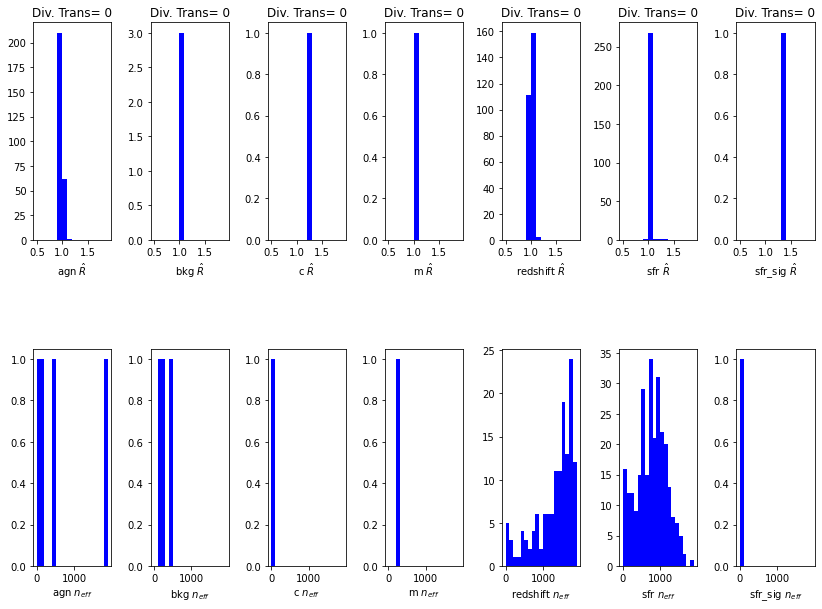

In [15]:
fig,axes=plt.subplots(2,len(samples),figsize=(2*len(samples),10))
for i,k in enumerate(samples):

    axes[0,i].hist(stats_summary[k]['r_hat'].flatten(),color='Blue',bins=np.arange(0.5,2,0.1))
    axes[1,i].hist(stats_summary[k]['n_eff'].flatten(),color='Blue',bins=np.arange(0,samples['m'].shape[0],100))
    axes[0,i].set_xlabel(k+' $ \hat{R}$')
    axes[0,i].set_title('Div. Trans= {}'.format(np.sum(divergences)))
    axes[1,i].set_xlabel(k+' $ n_{eff}$')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

All diagnostics look fine. 

## Posterior Probability distributions

#### Hierarchical parameters

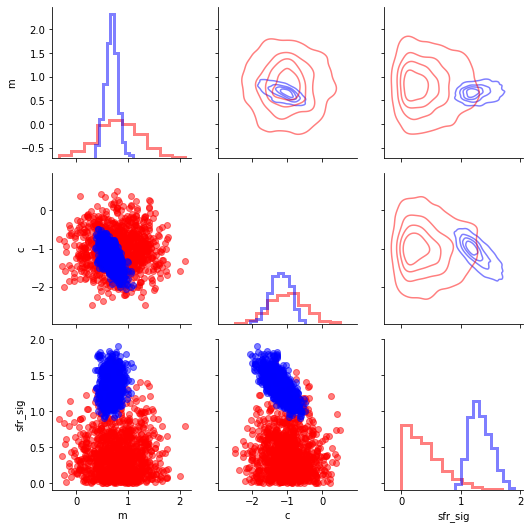

In [16]:
import pandas as pd
hier_param_names=['m','c','sfr_sig']

df_prior=pd.DataFrame(np.array([prior_pred[s] for s in hier_param_names]).T,columns=hier_param_names)
g=sns.PairGrid(df_prior)
g.map_lower(plt.scatter,alpha=0.5,color='Red')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Red',density=True)

df_post=pd.DataFrame(np.array([samples[s] for s in hier_param_names]).T,columns=hier_param_names)
g.data=df_post
g.map_lower(plt.scatter,alpha=0.5,color='Blue')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Blue',density=True)
g.map_upper(sns.kdeplot,alpha=0.5,color='Blue',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#for some reason the contour plots will delete other plots so do last
g.data=df_prior
g.map_upper(sns.kdeplot,alpha=0.5,color='Red',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#### Source parameters 

Text(0, 0.5, 'Redshift')

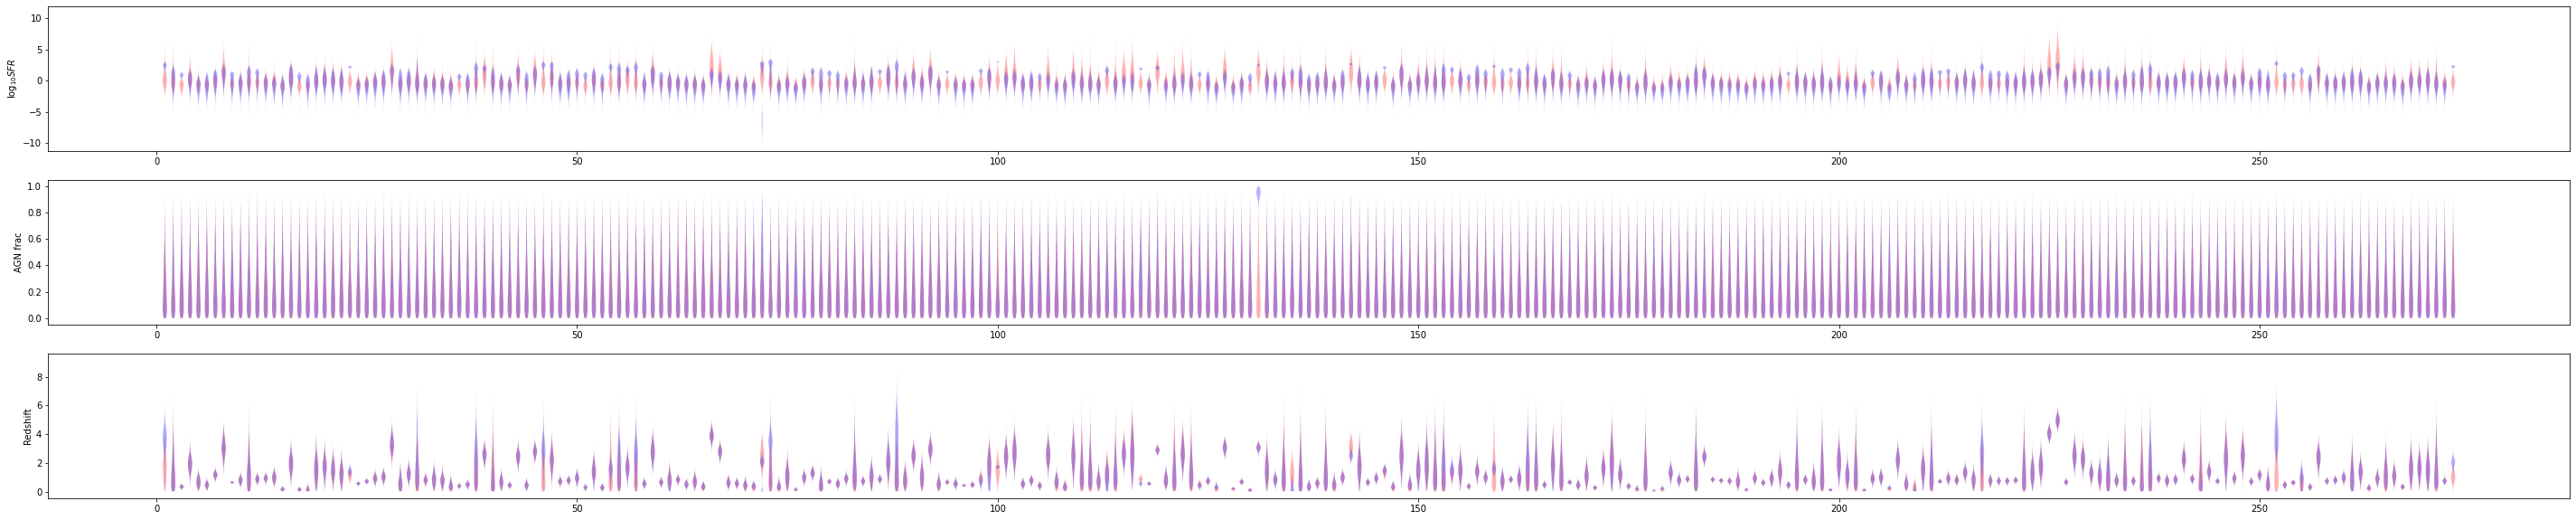

In [17]:
fig,axes=plt.subplots(3,1,figsize=(50,10))
phys_params=['sfr','agn','redshift']
for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')

axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].set_ylabel('AGN frac')
axes[2].set_ylabel('Redshift')

### Posterior Predicitive Checks

In [18]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = samples, num_samples = 50)
prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]

CPU times: user 2.08 s, sys: 29.5 ms, total: 2.11 s
Wall time: 2.05 s


In [19]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array_samp,50)

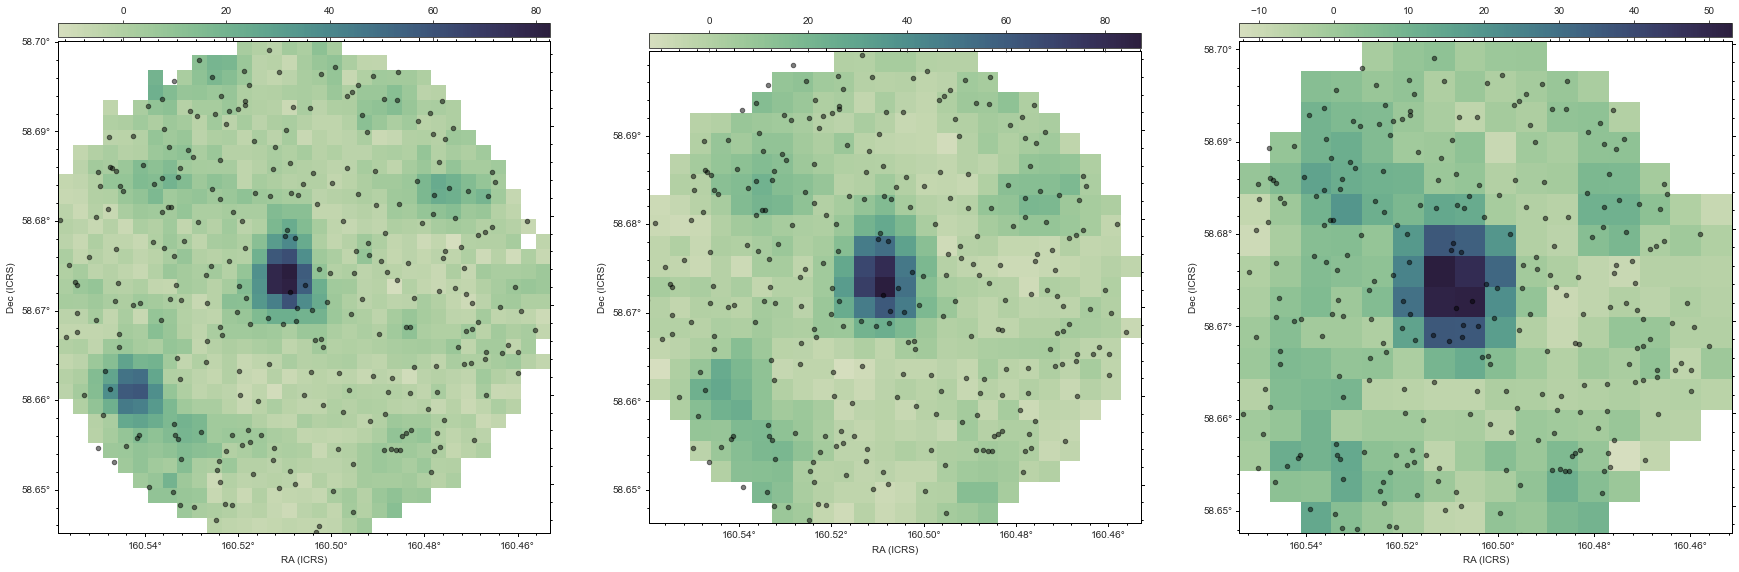

In [20]:
figures,fig=xidplus.plot_map(priors)

## Save the samples using arviz

In [21]:
import arviz as az

In [22]:
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior_pred,
    posterior_predictive=prior_pred_samp,
    coords={"src": np.arange(0,priors[0].nsrc),
           "band":np.arange(0,3)},
    dims={"agn": ["src"],
         "bkg":["band"],
         "redshift":["src"],
          "sfr":["src"]},
)

In [23]:
numpyro_data.to_netcdf('./output/{}/posterior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model1.nc')

'./output/Lockman-SWIRE/posterior_Lockman-SWIRE_1_model1.nc'

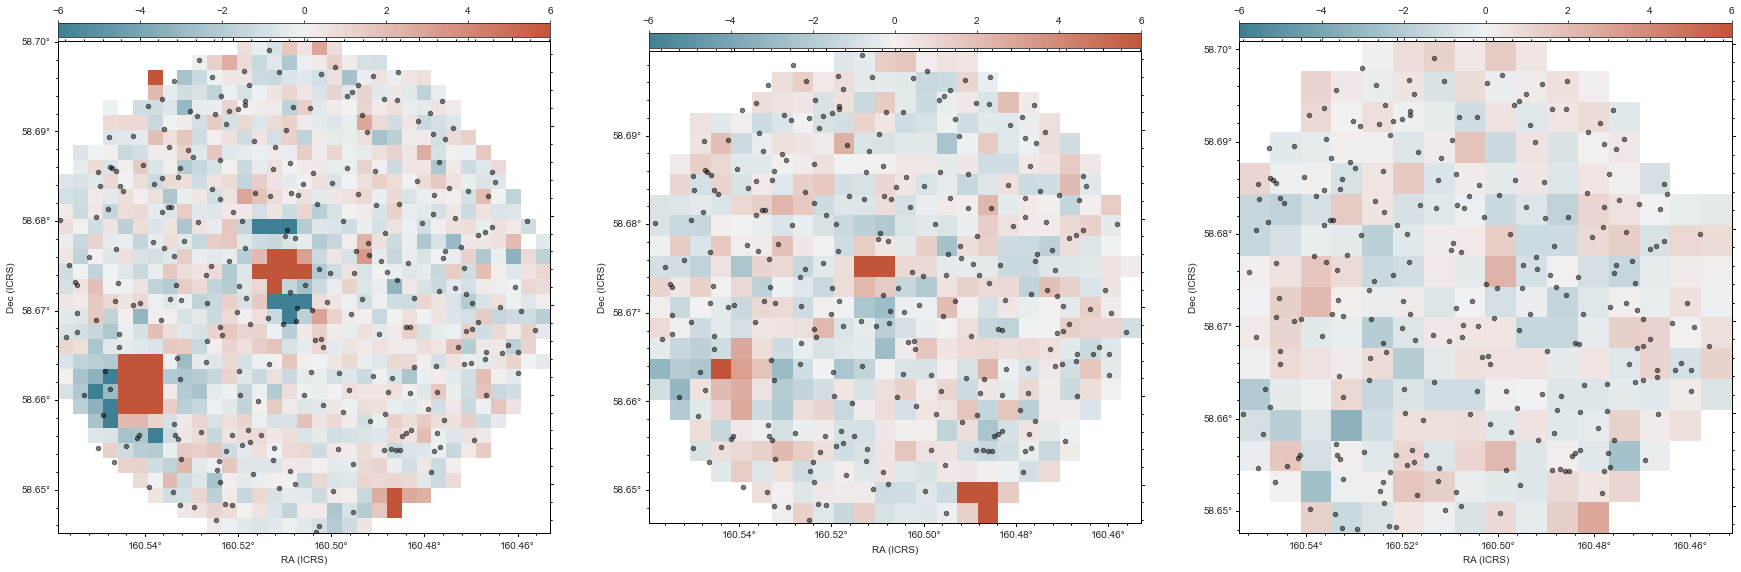

In [24]:
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(10 * len(priors), 10))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))
    
    
for i in range(0, len(priors)):
    figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                         marker='o', s=20, alpha=0.5)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')

In [25]:
fits_images=[postmaps.make_fits_image(priors[i],postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i])) for i in range(0,3)]



In [26]:
def Bayes_pval_sources(fits_images):
    #reproject
    from reproject import reproject_interp
    array350, footprint350 = reproject_interp(fits_images[1][1], fits_images[0][1].header,order=0)
    array500, footprint500 = reproject_interp(fits_images[2][1], fits_images[0][1].header,order=0)
    
    # get xx and yy
    xx,yy=np.meshgrid(np.arange(0,array350.shape[0]),np.arange(0,array350.shape[1]))
    
    #get average zscore
    combined_pval_map=(fits_images[0][1].data+array350+array500)/3.0
    ind=combined_pval_map>2
    
    from sklearn.cluster import DBSCAN
    X=np.vstack((xx[ind],yy[ind])).T
    
    # Compute DBSCAN
    db = DBSCAN(eps=2, min_samples=2).fit(X)
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    from astropy.table import QTable
    from astropy.wcs import WCS

    w=WCS(fits_images[0][1].header)
    pix_coords=np.asarray([[np.mean(xx[ind][labels==i]),np.mean(yy[ind][labels==i])] for i in range(0,n_clusters_)])
   
    coords_new=w.pixel_to_world(pix_coords[:,0],pix_coords[:,1])
    t=QTable()
    t['ra']=coords_new.ra
    t['dec']=coords_new.dec
    return t

In [27]:
t=Bayes_pval_sources(fits_images)

0


0


0


fitting 276 sources 

using 872, 447 and 221 pixels
source density = 113727.59718704427


  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:54:00,  6.85s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<14:19,  1.16it/s, 111 steps of size 1.10e-03. acc. prob=0.30]

warmup:   1%|          | 9/1000 [00:09<13:59,  1.18it/s, 1023 steps of size 3.49e-04. acc. prob=0.44]

warmup:   1%|          | 11/1000 [00:11<14:33,  1.13it/s, 1023 steps of size 1.07e-03. acc. prob=0.54]

warmup:   1%|          | 12/1000 [00:12<14:47,  1.11it/s, 1023 steps of size 1.21e-03. acc. prob=0.56]

warmup:   1%|▏         | 13/1000 [00:13<15:01,  1.10it/s, 1023 steps of size 2.16e-03. acc. prob=0.59]

warmup:   1%|▏         | 14/1000 [00:14<15:14,  1.08it/s, 1023 steps of size 2.98e-03. acc. prob=0.61]

warmup:   2%|▏         | 15/1000 [00:15<15:25,  1.06it/s, 1023 steps of size 5.53e-03. acc. prob=0.64]

warmup:   2%|▏         | 16/1000 [00:16<15:32,  1.06it/s, 1023 steps of size 9.60e-03. acc. prob=0.66]

warmup:   2%|▏         | 17/1000 [00:16<12:27,  1.32it/s, 255 steps of size 1.42e-03. acc. prob=0.63] 

warmup:   2%|▏         | 18/1000 [00:17<13:34,  1.21it/s, 1023 steps of size 2.56e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:18<14:13,  1.15it/s, 1023 steps of size 4.85e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:19<14:43,  1.11it/s, 1023 steps of size 8.52e-03. acc. prob=0.68]

warmup:   2%|▏         | 21/1000 [00:19<11:35,  1.41it/s, 253 steps of size 4.09e-03. acc. prob=0.67] 

warmup:   2%|▏         | 22/1000 [00:20<12:49,  1.27it/s, 1023 steps of size 7.06e-03. acc. prob=0.69]

warmup:   2%|▏         | 23/1000 [00:21<13:42,  1.19it/s, 1023 steps of size 8.36e-04. acc. prob=0.66]

warmup:   2%|▏         | 24/1000 [00:22<14:20,  1.13it/s, 1023 steps of size 1.54e-03. acc. prob=0.67]

warmup:   2%|▎         | 25/1000 [00:23<14:46,  1.10it/s, 1023 steps of size 2.85e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:24<15:06,  1.07it/s, 1023 steps of size 5.07e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:25<15:19,  1.06it/s, 1023 steps of size 6.68e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:26<15:32,  1.04it/s, 1023 steps of size 6.14e-03. acc. prob=0.71]

warmup:   3%|▎         | 29/1000 [00:27<15:42,  1.03it/s, 1023 steps of size 2.04e-03. acc. prob=0.69]

warmup:   3%|▎         | 30/1000 [00:28<15:42,  1.03it/s, 1023 steps of size 3.55e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:29<15:44,  1.03it/s, 1023 steps of size 6.43e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:30<15:43,  1.03it/s, 1023 steps of size 1.13e-02. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:31<12:05,  1.33it/s, 1023 steps of size 2.43e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:32<12:58,  1.24it/s, 1023 steps of size 4.28e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:33<13:39,  1.18it/s, 1023 steps of size 4.37e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:34<14:12,  1.13it/s, 1023 steps of size 7.75e-03. acc. prob=0.73]

warmup:   4%|▍         | 38/1000 [00:34<12:24,  1.29it/s, 511 steps of size 9.85e-03. acc. prob=0.73] 

warmup:   4%|▍         | 40/1000 [00:35<10:25,  1.53it/s, 1023 steps of size 2.40e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:36<11:39,  1.37it/s, 1023 steps of size 4.12e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:37<12:38,  1.26it/s, 1023 steps of size 6.09e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:38<13:25,  1.19it/s, 1023 steps of size 9.75e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:38<10:23,  1.53it/s, 161 steps of size 1.89e-03. acc. prob=0.72] 

warmup:   4%|▍         | 45/1000 [00:39<11:51,  1.34it/s, 1023 steps of size 3.26e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:40<12:53,  1.23it/s, 1023 steps of size 5.20e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:41<13:38,  1.16it/s, 1023 steps of size 5.35e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:42<14:10,  1.12it/s, 1023 steps of size 2.57e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:43<14:32,  1.09it/s, 1023 steps of size 4.33e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:44<14:49,  1.07it/s, 1023 steps of size 6.65e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [00:45<14:59,  1.06it/s, 1023 steps of size 9.27e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [00:46<12:20,  1.28it/s, 407 steps of size 2.33e-03. acc. prob=0.73] 

warmup:   5%|▌         | 53/1000 [00:47<13:14,  1.19it/s, 1023 steps of size 3.86e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:48<13:52,  1.14it/s, 1023 steps of size 4.95e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:49<14:19,  1.10it/s, 1023 steps of size 7.14e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:50<14:37,  1.08it/s, 1023 steps of size 6.03e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:51<14:49,  1.06it/s, 1023 steps of size 4.26e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:52<15:05,  1.04it/s, 1023 steps of size 4.46e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:53<15:07,  1.04it/s, 1023 steps of size 5.59e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:54<15:09,  1.03it/s, 1023 steps of size 3.46e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:55<15:12,  1.03it/s, 1023 steps of size 5.60e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:56<15:45,  1.01s/it, 1023 steps of size 6.14e-03. acc. prob=0.75]

warmup:   6%|▋         | 63/1000 [00:57<15:35,  1.00it/s, 1023 steps of size 9.88e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [00:57<11:22,  1.37it/s, 99 steps of size 2.08e-03. acc. prob=0.74]  

warmup:   6%|▋         | 65/1000 [00:58<12:34,  1.24it/s, 1023 steps of size 3.32e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:59<13:22,  1.16it/s, 1023 steps of size 4.43e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:00<13:53,  1.12it/s, 1023 steps of size 4.64e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:01<14:15,  1.09it/s, 1023 steps of size 6.70e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:02<14:30,  1.07it/s, 1023 steps of size 3.94e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:03<14:40,  1.06it/s, 1023 steps of size 5.77e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:04<14:47,  1.05it/s, 1023 steps of size 6.57e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:05<14:53,  1.04it/s, 1023 steps of size 7.93e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:05<12:40,  1.22it/s, 511 steps of size 6.03e-03. acc. prob=0.75] 

warmup:   7%|▋         | 74/1000 [01:06<13:22,  1.15it/s, 1023 steps of size 5.74e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:07<13:51,  1.11it/s, 1023 steps of size 4.12e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:08<14:11,  1.09it/s, 1023 steps of size 5.19e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:09<14:26,  1.06it/s, 1023 steps of size 7.70e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:10<14:35,  1.05it/s, 1023 steps of size 5.53e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:11<14:41,  1.04it/s, 1023 steps of size 4.91e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:12<14:44,  1.04it/s, 1023 steps of size 4.04e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:13<14:47,  1.04it/s, 1023 steps of size 4.19e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:14<14:50,  1.03it/s, 1023 steps of size 5.54e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:15<14:50,  1.03it/s, 1023 steps of size 7.96e-03. acc. prob=0.76]

warmup:   8%|▊         | 84/1000 [01:16<14:50,  1.03it/s, 1023 steps of size 4.22e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:17<14:51,  1.03it/s, 1023 steps of size 4.00e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:18<14:50,  1.03it/s, 1023 steps of size 6.00e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:19<14:50,  1.03it/s, 1023 steps of size 8.09e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [01:19<11:59,  1.27it/s, 368 steps of size 2.36e-03. acc. prob=0.75] 

warmup:   9%|▉         | 89/1000 [01:20<12:49,  1.18it/s, 1023 steps of size 2.92e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:21<13:23,  1.13it/s, 1023 steps of size 3.69e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:22<13:47,  1.10it/s, 1023 steps of size 5.55e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:23<14:03,  1.08it/s, 1023 steps of size 6.73e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:24<14:16,  1.06it/s, 1023 steps of size 3.14e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:25<14:24,  1.05it/s, 1023 steps of size 3.98e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:26<14:28,  1.04it/s, 1023 steps of size 3.76e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:27<14:31,  1.04it/s, 1023 steps of size 5.32e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:28<14:33,  1.03it/s, 1023 steps of size 6.78e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:29<14:42,  1.02it/s, 1023 steps of size 5.83e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:30<14:41,  1.02it/s, 1023 steps of size 8.59e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:30<11:19,  1.32it/s, 244 steps of size 3.80e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:31<12:17,  1.22it/s, 1023 steps of size 4.82e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:31<08:18,  1.80it/s, 511 steps of size 1.03e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:32<08:03,  1.85it/s, 511 steps of size 1.61e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:32<06:53,  2.16it/s, 255 steps of size 1.27e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:33<06:59,  2.13it/s, 511 steps of size 8.25e-03. acc. prob=0.75]

warmup:  11%|█         | 107/1000 [01:33<07:04,  2.10it/s, 511 steps of size 1.06e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:34<07:08,  2.08it/s, 511 steps of size 1.71e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:34<06:07,  2.42it/s, 255 steps of size 1.22e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:34<06:26,  2.30it/s, 511 steps of size 2.23e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:35<05:36,  2.64it/s, 255 steps of size 7.28e-03. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:36<08:12,  1.80it/s, 1023 steps of size 8.65e-03. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:36<07:54,  1.87it/s, 511 steps of size 1.55e-02. acc. prob=0.76] 

warmup:  11%|█▏        | 114/1000 [01:37<07:41,  1.92it/s, 511 steps of size 1.35e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:37<07:32,  1.96it/s, 511 steps of size 1.87e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:37<06:21,  2.32it/s, 255 steps of size 3.40e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:38<06:45,  2.17it/s, 1023 steps of size 6.18e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:39<08:38,  1.70it/s, 1023 steps of size 1.04e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:40<08:14,  1.78it/s, 511 steps of size 1.84e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 121/1000 [01:40<06:58,  2.10it/s, 255 steps of size 1.24e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:41<07:00,  2.09it/s, 511 steps of size 1.25e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:41<07:03,  2.07it/s, 511 steps of size 1.22e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:41<07:04,  2.07it/s, 511 steps of size 1.86e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:42<06:02,  2.42it/s, 255 steps of size 2.40e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:42<05:18,  2.74it/s, 255 steps of size 9.99e-03. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:42<05:50,  2.49it/s, 511 steps of size 9.98e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:43<06:12,  2.34it/s, 511 steps of size 1.76e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:43<05:24,  2.68it/s, 255 steps of size 2.60e-02. acc. prob=0.77]

warmup:  13%|█▎        | 131/1000 [01:44<06:22,  2.27it/s, 1023 steps of size 1.12e-02. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:45<06:32,  2.21it/s, 511 steps of size 1.86e-02. acc. prob=0.77] 

warmup:  13%|█▎        | 133/1000 [01:45<05:45,  2.51it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:45<05:08,  2.81it/s, 255 steps of size 3.70e-03. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:46<07:37,  1.89it/s, 1023 steps of size 6.30e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [01:47<09:27,  1.52it/s, 1023 steps of size 9.83e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [01:48<08:44,  1.64it/s, 511 steps of size 1.10e-02. acc. prob=0.76] 

warmup:  14%|█▍        | 138/1000 [01:48<08:14,  1.74it/s, 511 steps of size 1.82e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:48<06:50,  2.10it/s, 255 steps of size 1.51e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:49<06:53,  2.08it/s, 511 steps of size 2.46e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:49<05:52,  2.43it/s, 255 steps of size 1.06e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:50<06:12,  2.30it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:50<06:25,  2.22it/s, 511 steps of size 1.83e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:50<05:32,  2.57it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:51<05:57,  2.39it/s, 511 steps of size 1.98e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:51<05:13,  2.73it/s, 255 steps of size 2.11e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:51<04:41,  3.03it/s, 255 steps of size 2.10e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:52<04:19,  3.29it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:52<04:03,  3.49it/s, 255 steps of size 6.88e-03. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:53<06:58,  2.03it/s, 1023 steps of size 9.97e-03. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:53<06:57,  2.03it/s, 511 steps of size 1.17e-01. acc. prob=0.77] 

warmup:  15%|█▌        | 153/1000 [01:54<04:32,  3.10it/s, 255 steps of size 2.24e-02. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:54<03:56,  3.58it/s, 154 steps of size 1.34e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:54<03:49,  3.69it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  16%|█▌        | 156/1000 [01:54<03:42,  3.79it/s, 255 steps of size 5.74e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:55<06:30,  2.16it/s, 1023 steps of size 1.01e-02. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [01:56<06:36,  2.13it/s, 511 steps of size 1.77e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 159/1000 [01:56<05:33,  2.52it/s, 226 steps of size 3.63e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [01:57<07:55,  1.77it/s, 1023 steps of size 6.74e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [01:57<07:35,  1.84it/s, 511 steps of size 1.13e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 162/1000 [01:58<07:21,  1.90it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:58<07:11,  1.94it/s, 511 steps of size 2.14e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:59<07:02,  1.97it/s, 1023 steps of size 5.68e-03. acc. prob=0.76]

warmup:  17%|█▋        | 166/1000 [02:00<08:42,  1.60it/s, 1023 steps of size 1.02e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:01<08:12,  1.69it/s, 511 steps of size 1.53e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 169/1000 [02:02<07:48,  1.78it/s, 1023 steps of size 3.36e-03. acc. prob=0.76]

warmup:  17%|█▋        | 170/1000 [02:03<09:07,  1.52it/s, 1023 steps of size 6.25e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:04<10:13,  1.35it/s, 1023 steps of size 6.68e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:05<11:03,  1.25it/s, 1023 steps of size 7.58e-03. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:05<09:55,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 174/1000 [02:06<09:00,  1.53it/s, 511 steps of size 9.22e-03. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:06<08:20,  1.65it/s, 511 steps of size 1.09e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:07<07:51,  1.75it/s, 511 steps of size 6.51e-03. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:08<09:27,  1.45it/s, 1023 steps of size 1.10e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:08<08:38,  1.59it/s, 511 steps of size 1.25e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 179/1000 [02:09<08:03,  1.70it/s, 511 steps of size 1.86e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:09<06:40,  2.05it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:09<05:40,  2.40it/s, 255 steps of size 1.81e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:09<04:58,  2.74it/s, 255 steps of size 3.15e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:10<05:47,  2.35it/s, 1023 steps of size 7.44e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:11<05:59,  2.27it/s, 511 steps of size 7.44e-03. acc. prob=0.77] 

warmup:  19%|█▊        | 186/1000 [02:11<06:09,  2.21it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:12<06:16,  2.16it/s, 511 steps of size 1.66e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:12<05:26,  2.49it/s, 255 steps of size 1.71e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:12<04:42,  2.87it/s, 222 steps of size 1.12e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:13<05:14,  2.57it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:13<04:22,  3.08it/s, 176 steps of size 6.63e-03. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:14<06:58,  1.93it/s, 1023 steps of size 9.76e-03. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:14<06:50,  1.96it/s, 511 steps of size 8.26e-03. acc. prob=0.77] 

warmup:  19%|█▉        | 194/1000 [02:15<06:44,  1.99it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:15<05:42,  2.35it/s, 255 steps of size 1.86e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:16<06:10,  2.17it/s, 1023 steps of size 6.15e-03. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:17<07:52,  1.70it/s, 1023 steps of size 8.05e-03. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:18<07:30,  1.78it/s, 511 steps of size 8.18e-03. acc. prob=0.77] 

warmup:  20%|██        | 200/1000 [02:18<07:14,  1.84it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:19<07:01,  1.89it/s, 511 steps of size 2.63e-03. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:20<08:43,  1.52it/s, 1023 steps of size 4.14e-03. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:21<09:56,  1.34it/s, 1023 steps of size 5.86e-03. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:22<10:48,  1.23it/s, 1023 steps of size 8.52e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:22<09:31,  1.39it/s, 511 steps of size 1.09e-02. acc. prob=0.77] 

warmup:  21%|██        | 206/1000 [02:23<08:35,  1.54it/s, 511 steps of size 9.99e-03. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:23<07:57,  1.66it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:23<06:31,  2.02it/s, 255 steps of size 1.74e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:24<04:29,  2.93it/s, 255 steps of size 4.12e-03. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:25<06:34,  2.00it/s, 1023 steps of size 5.42e-03. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:26<08:11,  1.60it/s, 1023 steps of size 5.70e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:27<09:25,  1.39it/s, 1023 steps of size 7.62e-03. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:27<08:33,  1.53it/s, 511 steps of size 1.18e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 215/1000 [02:27<07:56,  1.65it/s, 511 steps of size 1.58e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:28<06:17,  2.08it/s, 180 steps of size 4.14e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:29<08:11,  1.59it/s, 1023 steps of size 5.93e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:30<09:34,  1.36it/s, 1023 steps of size 8.15e-03. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:30<08:37,  1.51it/s, 511 steps of size 8.48e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 220/1000 [02:31<07:57,  1.63it/s, 511 steps of size 8.55e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:31<07:30,  1.73it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:32<07:10,  1.81it/s, 511 steps of size 1.47e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:32<05:58,  2.16it/s, 255 steps of size 1.40e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:32<05:07,  2.52it/s, 255 steps of size 1.94e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:32<04:32,  2.84it/s, 255 steps of size 2.83e-02. acc. prob=0.78]

warmup:  23%|██▎       | 226/1000 [02:32<03:37,  3.55it/s, 118 steps of size 3.86e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [02:33<03:30,  3.66it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:33<04:12,  3.05it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:34<04:44,  2.71it/s, 511 steps of size 1.59e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:34<04:18,  2.98it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:34<03:58,  3.22it/s, 255 steps of size 1.31e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:35<04:36,  2.77it/s, 511 steps of size 7.89e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:35<05:04,  2.52it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:36<05:24,  2.36it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:36<05:38,  2.26it/s, 511 steps of size 8.77e-03. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:37<05:48,  2.19it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:37<05:54,  2.15it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:38<05:04,  2.50it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:38<04:28,  2.83it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:38<04:03,  3.11it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:39<04:35,  2.74it/s, 511 steps of size 1.78e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:39<04:12,  3.00it/s, 255 steps of size 6.85e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:40<04:46,  2.64it/s, 511 steps of size 9.05e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [02:40<05:08,  2.44it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:41<05:24,  2.32it/s, 511 steps of size 7.75e-03. acc. prob=0.77]

warmup:  25%|██▍       | 248/1000 [02:41<05:36,  2.23it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:42<05:44,  2.18it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:42<04:56,  2.53it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:42<05:17,  2.36it/s, 511 steps of size 6.63e-02. acc. prob=0.77]

warmup:  25%|██▌       | 253/1000 [02:43<04:15,  2.93it/s, 511 steps of size 7.40e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:43<04:41,  2.65it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:44<05:03,  2.45it/s, 511 steps of size 1.51e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:45<05:42,  2.17it/s, 1023 steps of size 5.98e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:45<05:47,  2.14it/s, 511 steps of size 8.86e-03. acc. prob=0.77] 

warmup:  26%|██▌       | 259/1000 [02:46<05:50,  2.12it/s, 511 steps of size 7.99e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:46<05:53,  2.09it/s, 511 steps of size 8.70e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:47<05:56,  2.07it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:47<05:18,  2.32it/s, 314 steps of size 9.10e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:48<05:30,  2.23it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:48<05:38,  2.18it/s, 511 steps of size 4.90e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:49<07:29,  1.63it/s, 1023 steps of size 8.77e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:50<07:02,  1.74it/s, 511 steps of size 1.52e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 268/1000 [02:51<06:32,  1.86it/s, 1023 steps of size 2.44e-03. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [02:52<07:50,  1.55it/s, 1023 steps of size 4.03e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:53<08:52,  1.37it/s, 1023 steps of size 6.59e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:53<08:03,  1.51it/s, 511 steps of size 1.15e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 272/1000 [02:54<07:28,  1.62it/s, 511 steps of size 3.92e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:55<08:44,  1.39it/s, 1023 steps of size 6.99e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:55<07:54,  1.53it/s, 511 steps of size 8.32e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 275/1000 [02:55<07:18,  1.65it/s, 511 steps of size 9.11e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [02:56<06:52,  1.75it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [02:56<05:42,  2.11it/s, 255 steps of size 4.43e-03. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [02:57<07:32,  1.59it/s, 1023 steps of size 7.17e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [02:58<07:02,  1.71it/s, 511 steps of size 1.15e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 280/1000 [02:58<06:40,  1.80it/s, 511 steps of size 2.30e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [02:59<08:11,  1.46it/s, 1023 steps of size 3.86e-03. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [03:00<09:13,  1.30it/s, 1023 steps of size 6.79e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [03:01<08:11,  1.46it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 284/1000 [03:01<07:29,  1.59it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [03:01<05:57,  2.00it/s, 208 steps of size 1.26e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [03:02<04:50,  2.46it/s, 197 steps of size 4.17e-03. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [03:02<06:51,  1.73it/s, 1023 steps of size 5.24e-03. acc. prob=0.77]

warmup:  29%|██▉       | 288/1000 [03:03<08:20,  1.42it/s, 1023 steps of size 6.80e-03. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [03:04<07:37,  1.56it/s, 511 steps of size 7.54e-03. acc. prob=0.78] 

warmup:  29%|██▉       | 290/1000 [03:04<07:04,  1.67it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [03:05<05:44,  2.06it/s, 235 steps of size 8.48e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [03:05<05:44,  2.05it/s, 511 steps of size 7.40e-03. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [03:06<05:44,  2.05it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [03:07<05:52,  2.00it/s, 1023 steps of size 5.78e-03. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [03:08<07:14,  1.62it/s, 1023 steps of size 8.04e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [03:08<06:50,  1.71it/s, 511 steps of size 1.27e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 298/1000 [03:09<06:08,  1.91it/s, 377 steps of size 1.43e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:10<06:07,  1.90it/s, 1023 steps of size 5.34e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:11<07:22,  1.58it/s, 1023 steps of size 6.96e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:11<06:55,  1.68it/s, 511 steps of size 8.43e-03. acc. prob=0.78] 

warmup:  30%|███       | 303/1000 [03:12<06:35,  1.76it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:12<06:19,  1.84it/s, 511 steps of size 7.11e-03. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:13<06:08,  1.89it/s, 511 steps of size 7.35e-03. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:13<05:59,  1.93it/s, 511 steps of size 7.55e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:14<05:52,  1.97it/s, 511 steps of size 6.54e-03. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:14<07:27,  1.55it/s, 1023 steps of size 6.62e-03. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:15<06:54,  1.67it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  31%|███       | 310/1000 [03:15<06:21,  1.81it/s, 461 steps of size 2.62e-03. acc. prob=0.77]

warmup:  31%|███       | 311/1000 [03:16<07:47,  1.47it/s, 1023 steps of size 3.79e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:17<08:47,  1.30it/s, 1023 steps of size 5.85e-03. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:18<09:29,  1.21it/s, 1023 steps of size 9.05e-03. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:19<08:19,  1.37it/s, 511 steps of size 1.19e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 315/1000 [03:19<07:29,  1.52it/s, 511 steps of size 1.76e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:20<06:36,  1.72it/s, 1023 steps of size 5.13e-03. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:21<07:42,  1.48it/s, 1023 steps of size 7.18e-03. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:22<07:07,  1.59it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 320/1000 [03:22<06:41,  1.70it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:23<06:11,  1.83it/s, 1023 steps of size 7.33e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:24<06:01,  1.87it/s, 511 steps of size 1.11e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 324/1000 [03:24<05:53,  1.91it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:25<05:50,  1.92it/s, 1023 steps of size 4.69e-03. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:26<07:00,  1.60it/s, 1023 steps of size 6.11e-03. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:27<08:03,  1.39it/s, 1023 steps of size 9.18e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:28<07:22,  1.52it/s, 511 steps of size 6.40e-03. acc. prob=0.78] 

warmup:  33%|███▎      | 330/1000 [03:29<08:19,  1.34it/s, 1023 steps of size 8.33e-03. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:29<07:31,  1.48it/s, 511 steps of size 1.17e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 332/1000 [03:30<06:54,  1.61it/s, 511 steps of size 1.67e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:31<06:14,  1.78it/s, 1023 steps of size 7.31e-03. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:31<06:01,  1.84it/s, 511 steps of size 1.02e-02. acc. prob=0.78] 

warmup:  34%|███▎      | 336/1000 [03:32<05:51,  1.89it/s, 511 steps of size 8.93e-03. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:32<05:43,  1.93it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:32<04:55,  2.24it/s, 270 steps of size 7.13e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:33<05:02,  2.18it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:33<05:07,  2.14it/s, 511 steps of size 7.16e-03. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:34<05:12,  2.11it/s, 511 steps of size 8.38e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:34<05:16,  2.08it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:35<04:39,  2.35it/s, 304 steps of size 8.41e-03. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:35<04:52,  2.24it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:36<05:00,  2.18it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:36<05:06,  2.14it/s, 511 steps of size 3.94e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:37<06:47,  1.60it/s, 1023 steps of size 5.71e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:38<07:54,  1.37it/s, 1023 steps of size 8.24e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:39<07:08,  1.52it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  35%|███▌      | 350/1000 [03:39<06:34,  1.65it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:40<06:10,  1.75it/s, 511 steps of size 5.14e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:41<07:28,  1.45it/s, 1023 steps of size 7.20e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:41<06:47,  1.59it/s, 511 steps of size 7.58e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 354/1000 [03:41<06:19,  1.70it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:42<05:59,  1.80it/s, 511 steps of size 5.39e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:43<07:19,  1.47it/s, 1023 steps of size 7.31e-03. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:43<06:43,  1.59it/s, 511 steps of size 5.99e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 358/1000 [03:44<07:50,  1.36it/s, 1023 steps of size 7.71e-03. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:45<07:03,  1.51it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  36%|███▌      | 360/1000 [03:45<06:29,  1.64it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:46<04:49,  2.21it/s, 511 steps of size 5.15e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:47<06:11,  1.71it/s, 1023 steps of size 7.32e-03. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:47<05:55,  1.79it/s, 511 steps of size 7.43e-03. acc. prob=0.78] 

warmup:  36%|███▋      | 365/1000 [03:48<05:45,  1.84it/s, 511 steps of size 9.61e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:48<05:35,  1.89it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:49<04:43,  2.23it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:50<05:03,  2.08it/s, 1023 steps of size 6.25e-03. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:50<05:04,  2.07it/s, 511 steps of size 7.51e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 371/1000 [03:51<05:04,  2.07it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:51<05:04,  2.06it/s, 511 steps of size 9.49e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:52<05:04,  2.06it/s, 511 steps of size 7.07e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:52<05:04,  2.06it/s, 511 steps of size 8.61e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:53<05:04,  2.06it/s, 511 steps of size 7.03e-03. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:53<05:04,  2.05it/s, 511 steps of size 7.56e-03. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:54<05:04,  2.05it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:54<05:04,  2.04it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:54<04:13,  2.45it/s, 221 steps of size 1.52e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:54<03:18,  3.13it/s, 113 steps of size 1.25e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:55<03:42,  2.78it/s, 477 steps of size 1.26e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:55<04:06,  2.50it/s, 511 steps of size 7.61e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:56<04:22,  2.35it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:56<04:33,  2.25it/s, 511 steps of size 4.52e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:57<06:10,  1.66it/s, 1023 steps of size 5.91e-03. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:58<07:18,  1.40it/s, 1023 steps of size 7.44e-03. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:59<06:37,  1.54it/s, 511 steps of size 9.89e-03. acc. prob=0.78] 

warmup:  39%|███▉      | 388/1000 [03:59<06:07,  1.67it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [04:00<05:46,  1.76it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [04:00<05:31,  1.84it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [04:01<04:18,  2.35it/s, 511 steps of size 9.64e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [04:01<04:27,  2.27it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [04:01<03:41,  2.74it/s, 156 steps of size 1.00e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [04:02<04:01,  2.51it/s, 511 steps of size 6.06e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [04:03<05:37,  1.79it/s, 1023 steps of size 8.24e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [04:03<05:25,  1.85it/s, 511 steps of size 8.48e-03. acc. prob=0.78] 

warmup:  40%|███▉      | 398/1000 [04:04<05:16,  1.90it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [04:04<05:09,  1.94it/s, 511 steps of size 9.42e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [04:05<05:04,  1.97it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [04:05<05:00,  2.00it/s, 511 steps of size 9.48e-03. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [04:06<04:59,  2.00it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [04:06<03:53,  2.55it/s, 511 steps of size 8.58e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [04:07<04:08,  2.40it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [04:07<04:18,  2.30it/s, 511 steps of size 9.12e-03. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [04:08<04:26,  2.22it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [04:08<04:33,  2.17it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [04:09<03:56,  2.50it/s, 255 steps of size 1.11e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [04:09<04:11,  2.35it/s, 511 steps of size 6.57e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [04:10<04:21,  2.25it/s, 511 steps of size 8.83e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [04:10<04:28,  2.19it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [04:11<04:34,  2.14it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [04:11<04:37,  2.11it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [04:12<04:39,  2.09it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [04:12<04:40,  2.08it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [04:13<03:47,  2.55it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [04:13<04:01,  2.41it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [04:14<04:25,  2.18it/s, 1023 steps of size 4.70e-03. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [04:15<05:33,  1.74it/s, 1023 steps of size 5.45e-03. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [04:16<06:28,  1.48it/s, 1023 steps of size 6.83e-03. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [04:17<06:00,  1.60it/s, 511 steps of size 9.13e-03. acc. prob=0.78] 

warmup:  42%|████▎     | 425/1000 [04:17<05:38,  1.70it/s, 511 steps of size 7.47e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [04:18<05:21,  1.78it/s, 511 steps of size 9.75e-03. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:18<05:09,  1.85it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:19<05:00,  1.90it/s, 511 steps of size 9.80e-03. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:19<04:56,  1.93it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:20<04:50,  1.96it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:20<04:05,  2.32it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [04:20<03:20,  2.82it/s, 511 steps of size 6.78e-03. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:21<03:39,  2.58it/s, 511 steps of size 7.03e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:21<03:53,  2.42it/s, 511 steps of size 5.45e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:22<05:18,  1.77it/s, 1023 steps of size 7.08e-03. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:23<05:05,  1.84it/s, 511 steps of size 9.39e-03. acc. prob=0.78] 

warmup:  44%|████▍     | 438/1000 [04:23<04:56,  1.90it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:23<03:56,  2.37it/s, 171 steps of size 7.70e-03. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:24<04:08,  2.25it/s, 511 steps of size 8.51e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:24<04:18,  2.16it/s, 511 steps of size 7.89e-03. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:25<04:22,  2.13it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:25<04:24,  2.10it/s, 511 steps of size 8.83e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:26<04:26,  2.09it/s, 511 steps of size 8.69e-03. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:26<04:27,  2.07it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:27<04:11,  2.21it/s, 404 steps of size 1.21e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:27<04:04,  2.27it/s, 427 steps of size 9.75e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:28<04:11,  2.19it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:28<04:00,  2.29it/s, 401 steps of size 1.43e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:28<03:28,  2.64it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:28<03:06,  2.95it/s, 255 steps of size 2.39e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:29<03:02,  2.99it/s, 1023 steps of size 4.93e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:30<04:16,  2.13it/s, 1023 steps of size 6.83e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:31<04:18,  2.11it/s, 511 steps of size 1.01e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 457/1000 [04:31<04:19,  2.09it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [04:32<03:45,  2.40it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:33<04:05,  2.20it/s, 1023 steps of size 2.90e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:34<05:11,  1.73it/s, 1023 steps of size 5.41e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:35<06:04,  1.47it/s, 1023 steps of size 5.29e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [04:36<06:46,  1.32it/s, 1023 steps of size 8.83e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:36<06:06,  1.46it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 465/1000 [04:37<05:36,  1.59it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:37<04:37,  1.92it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:37<03:55,  2.27it/s, 255 steps of size 2.05e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:38<05:20,  1.66it/s, 1023 steps of size 3.86e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:39<06:19,  1.40it/s, 1023 steps of size 7.06e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:40<05:43,  1.54it/s, 511 steps of size 9.64e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 471/1000 [04:40<05:17,  1.67it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:41<04:58,  1.77it/s, 511 steps of size 1.87e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:42<04:40,  1.88it/s, 1023 steps of size 6.44e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:42<05:36,  1.56it/s, 1023 steps of size 1.04e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:43<05:15,  1.66it/s, 511 steps of size 1.51e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 477/1000 [04:43<04:23,  1.98it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:44<04:21,  2.00it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:44<03:43,  2.33it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:45<04:01,  2.15it/s, 1023 steps of size 4.22e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:46<05:04,  1.70it/s, 1023 steps of size 6.50e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:46<04:51,  1.78it/s, 511 steps of size 8.38e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 484/1000 [04:47<04:40,  1.84it/s, 511 steps of size 8.59e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:47<04:31,  1.90it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:48<03:49,  2.24it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:49<03:58,  2.14it/s, 1023 steps of size 4.98e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:50<05:01,  1.69it/s, 1023 steps of size 6.63e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:50<04:47,  1.77it/s, 511 steps of size 9.62e-03. acc. prob=0.78] 

warmup:  49%|████▉     | 491/1000 [04:51<04:36,  1.84it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:51<04:28,  1.89it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:51<03:46,  2.24it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:51<02:55,  2.88it/s, 105 steps of size 1.00e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:52<03:16,  2.57it/s, 511 steps of size 7.42e-03. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:52<03:30,  2.39it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:53<03:04,  2.73it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:53<02:45,  3.03it/s, 255 steps of size 5.67e-03. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:54<04:23,  1.90it/s, 1023 steps of size 9.32e-03. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:54<04:18,  1.94it/s, 511 steps of size 9.23e-03. acc. prob=0.78] 

sample:  50%|█████     | 501/1000 [04:55<04:14,  1.96it/s, 511 steps of size 9.23e-03. acc. prob=0.84]

sample:  50%|█████     | 502/1000 [04:55<04:10,  1.99it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  50%|█████     | 503/1000 [04:56<04:07,  2.01it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  50%|█████     | 504/1000 [04:56<04:05,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  50%|█████     | 505/1000 [04:57<04:04,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.87]

sample:  51%|█████     | 506/1000 [04:57<04:02,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  51%|█████     | 507/1000 [04:58<04:03,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  51%|█████     | 508/1000 [04:58<04:01,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  51%|█████     | 509/1000 [04:59<04:01,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  51%|█████     | 510/1000 [04:59<04:00,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  51%|█████     | 511/1000 [05:00<03:59,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  51%|█████     | 512/1000 [05:00<03:58,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  51%|█████▏    | 513/1000 [05:01<03:58,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  51%|█████▏    | 514/1000 [05:01<03:57,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.91]

sample:  52%|█████▏    | 515/1000 [05:02<03:56,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.91]

sample:  52%|█████▏    | 516/1000 [05:02<03:56,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.91]

sample:  52%|█████▏    | 517/1000 [05:03<03:55,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  52%|█████▏    | 518/1000 [05:03<03:55,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  52%|█████▏    | 519/1000 [05:04<03:55,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.91]

sample:  52%|█████▏    | 520/1000 [05:04<03:59,  2.00it/s, 511 steps of size 9.23e-03. acc. prob=0.91]

sample:  52%|█████▏    | 521/1000 [05:05<03:58,  2.01it/s, 511 steps of size 9.23e-03. acc. prob=0.91]

sample:  52%|█████▏    | 522/1000 [05:05<03:56,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.91]

sample:  52%|█████▏    | 523/1000 [05:06<03:55,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  52%|█████▏    | 524/1000 [05:06<03:53,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  52%|█████▎    | 525/1000 [05:07<03:52,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  53%|█████▎    | 526/1000 [05:07<03:51,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  53%|█████▎    | 527/1000 [05:08<03:51,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  53%|█████▎    | 528/1000 [05:08<03:50,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  53%|█████▎    | 529/1000 [05:09<03:51,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  53%|█████▎    | 530/1000 [05:09<03:51,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  53%|█████▎    | 531/1000 [05:10<03:50,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [05:10<03:49,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [05:11<03:48,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  53%|█████▎    | 534/1000 [05:11<03:47,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [05:12<03:47,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▎    | 536/1000 [05:12<03:46,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▎    | 537/1000 [05:13<03:46,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▍    | 538/1000 [05:13<03:46,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▍    | 539/1000 [05:14<03:46,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▍    | 540/1000 [05:14<03:45,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▍    | 541/1000 [05:14<03:44,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▍    | 542/1000 [05:15<03:44,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▍    | 543/1000 [05:15<03:43,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  54%|█████▍    | 544/1000 [05:16<03:42,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  55%|█████▍    | 545/1000 [05:16<03:42,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  55%|█████▍    | 546/1000 [05:17<03:41,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  55%|█████▍    | 547/1000 [05:17<03:41,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  55%|█████▍    | 548/1000 [05:18<03:40,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  55%|█████▍    | 549/1000 [05:18<03:40,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.88]

sample:  55%|█████▌    | 550/1000 [05:19<03:40,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  55%|█████▌    | 551/1000 [05:19<03:39,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  55%|█████▌    | 552/1000 [05:20<03:39,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  55%|█████▌    | 553/1000 [05:20<03:38,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  55%|█████▌    | 554/1000 [05:21<03:37,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▌    | 555/1000 [05:21<03:37,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▌    | 556/1000 [05:22<03:36,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▌    | 557/1000 [05:22<03:36,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▌    | 558/1000 [05:23<03:35,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▌    | 559/1000 [05:23<03:35,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  56%|█████▌    | 560/1000 [05:24<03:35,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▌    | 561/1000 [05:24<03:34,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▌    | 562/1000 [05:25<03:34,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▋    | 563/1000 [05:25<03:33,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▋    | 564/1000 [05:26<03:32,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  56%|█████▋    | 565/1000 [05:26<03:32,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 566/1000 [05:27<03:31,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 567/1000 [05:27<03:31,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 568/1000 [05:28<03:30,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 569/1000 [05:28<03:30,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 570/1000 [05:29<03:30,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 571/1000 [05:29<03:30,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 572/1000 [05:30<03:29,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 573/1000 [05:30<03:28,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▋    | 574/1000 [05:31<03:28,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  57%|█████▊    | 575/1000 [05:31<03:28,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 576/1000 [05:32<03:27,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 577/1000 [05:32<03:26,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 578/1000 [05:33<03:26,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 579/1000 [05:33<03:25,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 580/1000 [05:34<03:24,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 581/1000 [05:34<03:25,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 582/1000 [05:35<03:24,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 583/1000 [05:35<03:23,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 584/1000 [05:35<03:22,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  58%|█████▊    | 585/1000 [05:36<03:22,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▊    | 586/1000 [05:36<03:21,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▊    | 587/1000 [05:37<03:21,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▉    | 588/1000 [05:37<03:21,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▉    | 589/1000 [05:38<03:20,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▉    | 590/1000 [05:38<03:20,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▉    | 591/1000 [05:39<03:20,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▉    | 592/1000 [05:39<03:19,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▉    | 593/1000 [05:40<03:19,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  59%|█████▉    | 594/1000 [05:40<03:19,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|█████▉    | 595/1000 [05:41<03:19,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|█████▉    | 596/1000 [05:41<03:18,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|█████▉    | 597/1000 [05:42<03:17,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|█████▉    | 598/1000 [05:42<03:16,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|█████▉    | 599/1000 [05:43<03:15,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|██████    | 600/1000 [05:43<03:15,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|██████    | 601/1000 [05:44<03:15,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|██████    | 602/1000 [05:44<03:14,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|██████    | 603/1000 [05:45<03:13,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|██████    | 604/1000 [05:45<03:13,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  60%|██████    | 605/1000 [05:46<03:12,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  61%|██████    | 606/1000 [05:46<03:12,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  61%|██████    | 607/1000 [05:47<03:12,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  61%|██████    | 608/1000 [05:47<03:11,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  61%|██████    | 609/1000 [05:48<03:11,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  61%|██████    | 610/1000 [05:48<03:10,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  61%|██████    | 611/1000 [05:49<03:10,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  61%|██████    | 612/1000 [05:49<03:10,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  61%|██████▏   | 613/1000 [05:50<03:09,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  61%|██████▏   | 614/1000 [05:50<03:08,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  62%|██████▏   | 615/1000 [05:51<03:08,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  62%|██████▏   | 616/1000 [05:51<03:07,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  62%|██████▏   | 617/1000 [05:52<03:06,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  62%|██████▏   | 618/1000 [05:52<03:08,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  62%|██████▏   | 619/1000 [05:53<03:07,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  62%|██████▏   | 620/1000 [05:53<03:06,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  62%|██████▏   | 621/1000 [05:54<03:05,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  62%|██████▏   | 622/1000 [05:54<03:05,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [05:55<03:05,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  62%|██████▏   | 624/1000 [05:55<03:04,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  62%|██████▎   | 625/1000 [05:56<03:04,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 626/1000 [05:56<03:03,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 627/1000 [05:57<03:02,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 628/1000 [05:57<03:01,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [05:58<03:01,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [05:58<03:00,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [05:59<03:00,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [05:59<03:00,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [05:59<02:59,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [06:00<02:58,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [06:00<02:58,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▎   | 636/1000 [06:01<02:57,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▎   | 637/1000 [06:01<02:57,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▍   | 638/1000 [06:02<02:56,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▍   | 639/1000 [06:02<02:56,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▍   | 640/1000 [06:03<02:55,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▍   | 641/1000 [06:03<02:54,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▍   | 642/1000 [06:04<02:55,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▍   | 643/1000 [06:04<02:54,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▍   | 644/1000 [06:05<02:53,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  64%|██████▍   | 645/1000 [06:05<02:53,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▍   | 646/1000 [06:06<02:52,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▍   | 647/1000 [06:06<02:52,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▍   | 648/1000 [06:07<02:51,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▍   | 649/1000 [06:07<02:52,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▌   | 650/1000 [06:08<02:51,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▌   | 651/1000 [06:08<02:50,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▌   | 652/1000 [06:09<02:50,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▌   | 653/1000 [06:09<02:49,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  65%|██████▌   | 654/1000 [06:10<02:49,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▌   | 655/1000 [06:10<02:48,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [06:11<02:47,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [06:11<02:47,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [06:12<02:46,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [06:12<02:46,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [06:13<02:46,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [06:13<02:46,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [06:14<02:46,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [06:14<02:45,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [06:15<02:44,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [06:15<02:44,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [06:16<02:43,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  67%|██████▋   | 667/1000 [06:16<02:42,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  67%|██████▋   | 668/1000 [06:17<02:42,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  67%|██████▋   | 669/1000 [06:17<02:42,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  67%|██████▋   | 670/1000 [06:18<02:41,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.90]

sample:  67%|██████▋   | 671/1000 [06:18<02:42,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  67%|██████▋   | 672/1000 [06:19<02:41,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  67%|██████▋   | 673/1000 [06:19<02:40,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  67%|██████▋   | 674/1000 [06:20<02:39,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 675/1000 [06:20<02:39,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 676/1000 [06:21<02:38,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 677/1000 [06:21<02:37,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 678/1000 [06:22<02:37,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 679/1000 [06:22<02:36,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 680/1000 [06:22<02:36,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 681/1000 [06:23<02:36,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 682/1000 [06:23<02:35,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 683/1000 [06:24<02:35,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 684/1000 [06:24<02:35,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  68%|██████▊   | 685/1000 [06:25<02:34,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▊   | 686/1000 [06:25<02:33,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▊   | 687/1000 [06:26<02:32,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▉   | 688/1000 [06:26<02:32,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▉   | 689/1000 [06:27<02:31,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▉   | 690/1000 [06:27<02:31,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▉   | 691/1000 [06:28<02:30,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▉   | 692/1000 [06:28<02:30,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▉   | 693/1000 [06:29<02:30,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  69%|██████▉   | 694/1000 [06:29<02:29,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|██████▉   | 695/1000 [06:30<02:29,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|██████▉   | 696/1000 [06:30<02:28,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|██████▉   | 697/1000 [06:31<02:28,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|██████▉   | 698/1000 [06:31<02:28,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|██████▉   | 699/1000 [06:32<02:27,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|███████   | 700/1000 [06:32<02:27,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|███████   | 701/1000 [06:33<02:26,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|███████   | 702/1000 [06:33<02:25,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|███████   | 703/1000 [06:34<02:25,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|███████   | 704/1000 [06:34<02:25,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  70%|███████   | 705/1000 [06:35<02:24,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████   | 706/1000 [06:35<02:23,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████   | 707/1000 [06:36<02:23,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████   | 708/1000 [06:36<02:22,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████   | 709/1000 [06:37<02:22,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████   | 710/1000 [06:37<02:21,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████   | 711/1000 [06:38<02:21,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████   | 712/1000 [06:38<02:21,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████▏  | 713/1000 [06:39<02:20,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  71%|███████▏  | 714/1000 [06:39<02:20,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 715/1000 [06:40<02:19,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 716/1000 [06:40<02:18,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 717/1000 [06:41<02:18,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 718/1000 [06:41<02:17,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 719/1000 [06:42<02:17,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 720/1000 [06:42<02:16,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 721/1000 [06:43<02:16,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 722/1000 [06:43<02:15,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 723/1000 [06:44<02:15,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▏  | 724/1000 [06:44<02:15,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  72%|███████▎  | 725/1000 [06:45<02:15,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 726/1000 [06:45<02:15,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 727/1000 [06:46<02:14,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 728/1000 [06:46<02:13,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 729/1000 [06:46<02:12,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 730/1000 [06:47<02:12,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 731/1000 [06:47<02:11,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 732/1000 [06:48<02:10,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 733/1000 [06:48<02:10,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  73%|███████▎  | 734/1000 [06:49<02:10,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▎  | 735/1000 [06:49<02:09,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▎  | 736/1000 [06:50<02:08,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▎  | 737/1000 [06:50<02:08,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▍  | 738/1000 [06:51<02:07,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▍  | 739/1000 [06:51<02:07,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▍  | 740/1000 [06:52<02:06,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▍  | 741/1000 [06:52<02:06,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▍  | 742/1000 [06:53<02:05,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▍  | 743/1000 [06:53<02:06,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▍  | 744/1000 [06:54<02:06,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  74%|███████▍  | 745/1000 [06:54<02:05,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▍  | 746/1000 [06:55<02:05,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▍  | 747/1000 [06:55<02:04,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▍  | 748/1000 [06:56<02:03,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▍  | 749/1000 [06:56<02:03,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▌  | 750/1000 [06:57<02:02,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▌  | 751/1000 [06:57<02:01,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▌  | 752/1000 [06:58<02:01,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▌  | 753/1000 [06:58<02:00,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  75%|███████▌  | 754/1000 [06:59<02:00,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▌  | 755/1000 [06:59<01:59,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▌  | 756/1000 [07:00<01:59,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▌  | 757/1000 [07:00<01:58,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▌  | 758/1000 [07:01<01:58,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▌  | 759/1000 [07:01<01:57,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▌  | 760/1000 [07:02<01:57,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▌  | 761/1000 [07:02<01:58,  2.01it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▌  | 762/1000 [07:03<01:57,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▋  | 763/1000 [07:03<01:56,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▋  | 764/1000 [07:04<01:56,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  76%|███████▋  | 765/1000 [07:04<01:55,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 766/1000 [07:05<01:54,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 767/1000 [07:05<01:54,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 768/1000 [07:06<01:53,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 769/1000 [07:06<01:52,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 770/1000 [07:07<01:52,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 771/1000 [07:07<01:51,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 772/1000 [07:08<01:51,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 773/1000 [07:08<01:50,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  77%|███████▋  | 774/1000 [07:09<01:50,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 775/1000 [07:09<01:50,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 776/1000 [07:10<01:49,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 777/1000 [07:10<01:49,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 778/1000 [07:10<01:48,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 779/1000 [07:11<01:48,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 780/1000 [07:11<01:47,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 781/1000 [07:12<01:47,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 782/1000 [07:12<01:46,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 783/1000 [07:13<01:45,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 784/1000 [07:13<01:45,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  78%|███████▊  | 785/1000 [07:14<01:45,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▊  | 786/1000 [07:14<01:44,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▊  | 787/1000 [07:15<01:44,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▉  | 788/1000 [07:15<01:44,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▉  | 789/1000 [07:16<01:43,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▉  | 790/1000 [07:16<01:43,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▉  | 791/1000 [07:17<01:43,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▉  | 792/1000 [07:17<01:42,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▉  | 793/1000 [07:18<01:41,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  79%|███████▉  | 794/1000 [07:18<01:41,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|███████▉  | 795/1000 [07:19<01:40,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|███████▉  | 796/1000 [07:19<01:39,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|███████▉  | 797/1000 [07:20<01:39,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|███████▉  | 798/1000 [07:20<01:38,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|███████▉  | 799/1000 [07:21<01:38,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|████████  | 800/1000 [07:21<01:37,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|████████  | 801/1000 [07:22<01:37,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|████████  | 802/1000 [07:22<01:36,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|████████  | 803/1000 [07:23<01:36,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|████████  | 804/1000 [07:23<01:35,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  80%|████████  | 805/1000 [07:24<01:35,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████  | 806/1000 [07:24<01:34,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████  | 807/1000 [07:25<01:34,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████  | 808/1000 [07:25<01:34,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████  | 809/1000 [07:26<01:33,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████  | 810/1000 [07:26<01:33,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████  | 811/1000 [07:27<01:32,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████  | 812/1000 [07:27<01:32,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████▏ | 813/1000 [07:28<01:31,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  81%|████████▏ | 814/1000 [07:28<01:31,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 815/1000 [07:29<01:31,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 816/1000 [07:29<01:30,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 817/1000 [07:30<01:29,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 818/1000 [07:30<01:29,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 819/1000 [07:31<01:28,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 820/1000 [07:31<01:28,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 821/1000 [07:32<01:27,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 822/1000 [07:32<01:26,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 823/1000 [07:33<01:26,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▏ | 824/1000 [07:33<01:25,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  82%|████████▎ | 825/1000 [07:34<01:25,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 826/1000 [07:34<01:25,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 827/1000 [07:34<01:25,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 828/1000 [07:35<01:24,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 829/1000 [07:35<01:23,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 830/1000 [07:36<01:23,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 831/1000 [07:36<01:23,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 832/1000 [07:37<01:22,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 833/1000 [07:37<01:21,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  83%|████████▎ | 834/1000 [07:38<01:21,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▎ | 835/1000 [07:38<01:20,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▎ | 836/1000 [07:39<01:20,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▎ | 837/1000 [07:39<01:20,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▍ | 838/1000 [07:40<01:19,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▍ | 839/1000 [07:40<01:18,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▍ | 840/1000 [07:41<01:18,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▍ | 841/1000 [07:41<01:17,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▍ | 842/1000 [07:42<01:17,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▍ | 843/1000 [07:42<01:16,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▍ | 844/1000 [07:43<01:16,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  84%|████████▍ | 845/1000 [07:43<01:15,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▍ | 846/1000 [07:44<01:15,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▍ | 847/1000 [07:44<01:15,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▍ | 848/1000 [07:45<01:14,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▍ | 849/1000 [07:45<01:14,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▌ | 850/1000 [07:46<01:13,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▌ | 851/1000 [07:46<01:12,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▌ | 852/1000 [07:47<01:12,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▌ | 853/1000 [07:47<01:12,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  85%|████████▌ | 854/1000 [07:48<01:12,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▌ | 855/1000 [07:48<01:11,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▌ | 856/1000 [07:49<01:10,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▌ | 857/1000 [07:49<01:10,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▌ | 858/1000 [07:50<01:09,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▌ | 859/1000 [07:50<01:09,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▌ | 860/1000 [07:51<01:08,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▌ | 861/1000 [07:51<01:07,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▌ | 862/1000 [07:52<01:07,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▋ | 863/1000 [07:52<01:06,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▋ | 864/1000 [07:53<01:06,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  86%|████████▋ | 865/1000 [07:53<01:05,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 866/1000 [07:54<01:05,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 867/1000 [07:54<01:05,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 868/1000 [07:55<01:05,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 869/1000 [07:55<01:04,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 870/1000 [07:56<01:03,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 871/1000 [07:56<01:03,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 872/1000 [07:57<01:02,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 873/1000 [07:57<01:02,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  87%|████████▋ | 874/1000 [07:58<01:01,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 875/1000 [07:58<01:01,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 876/1000 [07:59<01:00,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 877/1000 [07:59<01:00,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 878/1000 [08:00<00:59,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 879/1000 [08:00<00:59,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 880/1000 [08:00<00:58,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 881/1000 [08:01<00:58,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 882/1000 [08:01<00:57,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 883/1000 [08:02<00:57,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 884/1000 [08:02<00:56,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  88%|████████▊ | 885/1000 [08:03<00:56,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▊ | 886/1000 [08:03<00:56,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▊ | 887/1000 [08:04<00:55,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▉ | 888/1000 [08:04<00:55,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▉ | 889/1000 [08:05<00:54,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▉ | 890/1000 [08:05<00:53,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▉ | 891/1000 [08:06<00:53,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▉ | 892/1000 [08:06<00:52,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▉ | 893/1000 [08:07<00:52,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  89%|████████▉ | 894/1000 [08:07<00:51,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|████████▉ | 895/1000 [08:08<00:51,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|████████▉ | 896/1000 [08:08<00:50,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|████████▉ | 897/1000 [08:09<00:50,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|████████▉ | 898/1000 [08:09<00:49,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|████████▉ | 899/1000 [08:10<00:49,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|█████████ | 900/1000 [08:10<00:51,  1.95it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|█████████ | 901/1000 [08:11<00:50,  1.97it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|█████████ | 902/1000 [08:11<00:49,  2.00it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|█████████ | 903/1000 [08:12<00:48,  2.01it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|█████████ | 904/1000 [08:12<00:47,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  90%|█████████ | 905/1000 [08:13<00:46,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████ | 906/1000 [08:13<00:46,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████ | 907/1000 [08:14<00:45,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████ | 908/1000 [08:14<00:45,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████ | 909/1000 [08:15<00:45,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████ | 910/1000 [08:15<00:44,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████ | 911/1000 [08:16<00:43,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████ | 912/1000 [08:16<00:43,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████▏| 913/1000 [08:17<00:42,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  91%|█████████▏| 914/1000 [08:17<00:42,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 915/1000 [08:18<00:41,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 916/1000 [08:18<00:41,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 917/1000 [08:19<00:41,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 918/1000 [08:19<00:40,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 919/1000 [08:20<00:39,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 920/1000 [08:20<00:39,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 921/1000 [08:21<00:38,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 922/1000 [08:21<00:38,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 923/1000 [08:22<00:37,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▏| 924/1000 [08:22<00:37,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  92%|█████████▎| 925/1000 [08:23<00:36,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 926/1000 [08:23<00:36,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 927/1000 [08:24<00:35,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 928/1000 [08:24<00:35,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 929/1000 [08:25<00:34,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 930/1000 [08:25<00:34,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 931/1000 [08:26<00:33,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 932/1000 [08:26<00:33,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 933/1000 [08:27<00:32,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  93%|█████████▎| 934/1000 [08:27<00:32,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▎| 935/1000 [08:28<00:31,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▎| 936/1000 [08:28<00:31,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▎| 937/1000 [08:28<00:30,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▍| 938/1000 [08:29<00:30,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▍| 939/1000 [08:29<00:29,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▍| 940/1000 [08:30<00:29,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▍| 941/1000 [08:30<00:28,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▍| 942/1000 [08:31<00:28,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▍| 943/1000 [08:31<00:27,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▍| 944/1000 [08:32<00:27,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  94%|█████████▍| 945/1000 [08:32<00:26,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▍| 946/1000 [08:33<00:26,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▍| 947/1000 [08:33<00:25,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▍| 948/1000 [08:34<00:25,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▍| 949/1000 [08:34<00:24,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▌| 950/1000 [08:35<00:24,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▌| 951/1000 [08:35<00:23,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▌| 952/1000 [08:36<00:23,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▌| 953/1000 [08:36<00:23,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  95%|█████████▌| 954/1000 [08:37<00:22,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▌| 955/1000 [08:37<00:22,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▌| 956/1000 [08:38<00:21,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▌| 957/1000 [08:38<00:21,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▌| 958/1000 [08:39<00:20,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▌| 959/1000 [08:39<00:20,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▌| 960/1000 [08:40<00:19,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▌| 961/1000 [08:40<00:19,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▌| 962/1000 [08:41<00:18,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▋| 963/1000 [08:41<00:18,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▋| 964/1000 [08:42<00:17,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  96%|█████████▋| 965/1000 [08:42<00:17,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 966/1000 [08:43<00:16,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 967/1000 [08:43<00:16,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 968/1000 [08:44<00:15,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 969/1000 [08:44<00:15,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 970/1000 [08:45<00:14,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 971/1000 [08:45<00:14,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 972/1000 [08:46<00:13,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 973/1000 [08:46<00:13,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  97%|█████████▋| 974/1000 [08:47<00:12,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 975/1000 [08:47<00:12,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 976/1000 [08:48<00:11,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 977/1000 [08:48<00:11,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 978/1000 [08:49<00:10,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 979/1000 [08:49<00:10,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 980/1000 [08:50<00:09,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 981/1000 [08:50<00:09,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 982/1000 [08:51<00:08,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 983/1000 [08:51<00:08,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 984/1000 [08:51<00:07,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  98%|█████████▊| 985/1000 [08:52<00:07,  2.03it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▊| 986/1000 [08:52<00:06,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▊| 987/1000 [08:53<00:06,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▉| 988/1000 [08:53<00:05,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▉| 989/1000 [08:54<00:05,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▉| 990/1000 [08:54<00:04,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▉| 991/1000 [08:55<00:04,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▉| 992/1000 [08:55<00:03,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▉| 993/1000 [08:56<00:03,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample:  99%|█████████▉| 994/1000 [08:56<00:02,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample: 100%|█████████▉| 995/1000 [08:57<00:02,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample: 100%|█████████▉| 996/1000 [08:57<00:01,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample: 100%|█████████▉| 997/1000 [08:58<00:01,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample: 100%|█████████▉| 998/1000 [08:58<00:00,  2.05it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample: 100%|█████████▉| 999/1000 [08:59<00:00,  2.04it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [08:59<00:00,  2.02it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [08:59<00:00,  1.85it/s, 511 steps of size 9.23e-03. acc. prob=0.89]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:52:15,  6.74s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<14:02,  1.18it/s, 63 steps of size 9.53e-04. acc. prob=0.30] 

warmup:   1%|          | 9/1000 [00:09<14:54,  1.11it/s, 1023 steps of size 2.09e-04. acc. prob=0.42]

warmup:   1%|          | 11/1000 [00:11<15:12,  1.08it/s, 1023 steps of size 5.69e-04. acc. prob=0.52]

warmup:   1%|          | 12/1000 [00:12<15:25,  1.07it/s, 1023 steps of size 1.10e-03. acc. prob=0.56]

warmup:   1%|▏         | 13/1000 [00:13<15:32,  1.06it/s, 1023 steps of size 2.13e-03. acc. prob=0.59]

warmup:   1%|▏         | 14/1000 [00:14<15:38,  1.05it/s, 1023 steps of size 3.93e-03. acc. prob=0.62]

warmup:   2%|▏         | 15/1000 [00:15<15:42,  1.04it/s, 1023 steps of size 5.84e-03. acc. prob=0.64]

warmup:   2%|▏         | 16/1000 [00:16<15:46,  1.04it/s, 1023 steps of size 2.86e-03. acc. prob=0.63]

warmup:   2%|▏         | 17/1000 [00:17<15:48,  1.04it/s, 1023 steps of size 5.32e-03. acc. prob=0.65]

warmup:   2%|▏         | 18/1000 [00:18<15:50,  1.03it/s, 1023 steps of size 5.42e-03. acc. prob=0.66]

warmup:   2%|▏         | 19/1000 [00:19<15:52,  1.03it/s, 1023 steps of size 9.93e-03. acc. prob=0.68]

warmup:   2%|▏         | 21/1000 [00:20<12:24,  1.32it/s, 1023 steps of size 2.01e-03. acc. prob=0.66]

warmup:   2%|▏         | 22/1000 [00:21<13:13,  1.23it/s, 1023 steps of size 3.88e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:22<14:01,  1.16it/s, 1023 steps of size 4.99e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:23<14:29,  1.12it/s, 1023 steps of size 9.22e-03. acc. prob=0.70]

warmup:   2%|▎         | 25/1000 [00:24<12:41,  1.28it/s, 511 steps of size 4.67e-03. acc. prob=0.69] 

warmup:   3%|▎         | 26/1000 [00:24<13:35,  1.19it/s, 1023 steps of size 6.68e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:25<11:56,  1.36it/s, 511 steps of size 5.58e-03. acc. prob=0.70] 

warmup:   3%|▎         | 28/1000 [00:26<13:03,  1.24it/s, 1023 steps of size 5.30e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:27<13:51,  1.17it/s, 1023 steps of size 9.77e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:28<11:15,  1.44it/s, 1023 steps of size 2.09e-03. acc. prob=0.70]

warmup:   3%|▎         | 32/1000 [00:29<12:28,  1.29it/s, 1023 steps of size 3.71e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:30<13:17,  1.21it/s, 1023 steps of size 6.70e-03. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:31<14:00,  1.15it/s, 1023 steps of size 1.11e-02. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:32<11:19,  1.42it/s, 1023 steps of size 2.55e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:33<12:19,  1.30it/s, 1023 steps of size 3.98e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:34<13:10,  1.22it/s, 1023 steps of size 4.54e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:35<13:48,  1.16it/s, 1023 steps of size 6.27e-03. acc. prob=0.73]

warmup:   4%|▍         | 40/1000 [00:36<14:17,  1.12it/s, 1023 steps of size 5.33e-03. acc. prob=0.73]

warmup:   4%|▍         | 41/1000 [00:37<14:38,  1.09it/s, 1023 steps of size 7.57e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:38<14:53,  1.07it/s, 1023 steps of size 1.01e-02. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:39<11:46,  1.35it/s, 1023 steps of size 3.37e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:40<12:40,  1.26it/s, 1023 steps of size 5.38e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:41<13:23,  1.19it/s, 1023 steps of size 4.34e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:42<13:58,  1.14it/s, 1023 steps of size 6.96e-03. acc. prob=0.74]

warmup:   5%|▍         | 48/1000 [00:43<14:22,  1.10it/s, 1023 steps of size 2.26e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:44<14:41,  1.08it/s, 1023 steps of size 3.74e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:45<14:53,  1.06it/s, 1023 steps of size 6.14e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [00:46<15:03,  1.05it/s, 1023 steps of size 1.01e-02. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:47<11:55,  1.32it/s, 1023 steps of size 2.76e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:48<12:44,  1.24it/s, 1023 steps of size 3.76e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:49<13:26,  1.17it/s, 1023 steps of size 5.82e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:50<13:56,  1.13it/s, 1023 steps of size 6.44e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:51<14:18,  1.10it/s, 1023 steps of size 9.64e-03. acc. prob=0.75]

warmup:   6%|▌         | 58/1000 [00:51<11:09,  1.41it/s, 219 steps of size 2.66e-03. acc. prob=0.74] 

warmup:   6%|▌         | 59/1000 [00:52<12:20,  1.27it/s, 1023 steps of size 3.42e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:53<13:11,  1.19it/s, 1023 steps of size 3.29e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:54<13:49,  1.13it/s, 1023 steps of size 2.21e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:55<14:19,  1.09it/s, 1023 steps of size 3.59e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:56<14:36,  1.07it/s, 1023 steps of size 5.38e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [00:57<14:45,  1.06it/s, 1023 steps of size 5.05e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [00:58<14:52,  1.05it/s, 1023 steps of size 7.22e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [00:59<15:02,  1.03it/s, 1023 steps of size 6.28e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:00<15:03,  1.03it/s, 1023 steps of size 9.66e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:00<11:49,  1.31it/s, 286 steps of size 2.34e-03. acc. prob=0.74] 

warmup:   7%|▋         | 69/1000 [01:01<12:48,  1.21it/s, 1023 steps of size 3.53e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:02<13:28,  1.15it/s, 1023 steps of size 5.10e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:03<13:56,  1.11it/s, 1023 steps of size 8.02e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:03<12:04,  1.28it/s, 511 steps of size 6.75e-03. acc. prob=0.75] 

warmup:   7%|▋         | 73/1000 [01:04<13:02,  1.18it/s, 1023 steps of size 7.65e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:05<11:22,  1.36it/s, 511 steps of size 6.21e-03. acc. prob=0.75] 

warmup:   8%|▊         | 75/1000 [01:06<12:27,  1.24it/s, 1023 steps of size 3.18e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:07<13:12,  1.17it/s, 1023 steps of size 3.59e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:08<13:43,  1.12it/s, 1023 steps of size 4.55e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:09<14:21,  1.07it/s, 1023 steps of size 6.01e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:10<14:35,  1.05it/s, 1023 steps of size 5.82e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:11<14:41,  1.04it/s, 1023 steps of size 5.09e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:12<14:48,  1.03it/s, 1023 steps of size 6.61e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:13<14:49,  1.03it/s, 1023 steps of size 8.30e-03. acc. prob=0.76]

warmup:   8%|▊         | 83/1000 [01:13<12:38,  1.21it/s, 511 steps of size 3.13e-03. acc. prob=0.75] 

warmup:   8%|▊         | 84/1000 [01:14<13:19,  1.15it/s, 1023 steps of size 4.54e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:15<13:45,  1.11it/s, 1023 steps of size 6.81e-03. acc. prob=0.76]

warmup:   9%|▊         | 86/1000 [01:16<14:04,  1.08it/s, 1023 steps of size 6.66e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:17<14:17,  1.06it/s, 1023 steps of size 8.48e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [01:17<11:08,  1.36it/s, 264 steps of size 7.30e-03. acc. prob=0.76] 

warmup:   9%|▉         | 89/1000 [01:18<12:14,  1.24it/s, 1023 steps of size 2.79e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:19<13:00,  1.17it/s, 1023 steps of size 4.08e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:20<13:31,  1.12it/s, 1023 steps of size 5.27e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:21<13:52,  1.09it/s, 1023 steps of size 7.47e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:22<14:06,  1.07it/s, 1023 steps of size 6.79e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:23<14:16,  1.06it/s, 1023 steps of size 7.38e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:24<14:25,  1.05it/s, 1023 steps of size 8.12e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:24<11:21,  1.33it/s, 295 steps of size 2.71e-03. acc. prob=0.75] 

warmup:  10%|▉         | 97/1000 [01:25<12:20,  1.22it/s, 1023 steps of size 3.36e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:26<13:05,  1.15it/s, 1023 steps of size 3.72e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:27<13:34,  1.11it/s, 1023 steps of size 4.36e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:28<13:54,  1.08it/s, 1023 steps of size 5.90e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:29<14:06,  1.06it/s, 1023 steps of size 7.32e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:30<09:16,  1.61it/s, 511 steps of size 1.24e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:30<08:46,  1.70it/s, 511 steps of size 7.98e-03. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [01:31<08:22,  1.78it/s, 511 steps of size 1.06e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:31<08:03,  1.85it/s, 511 steps of size 1.65e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:31<06:49,  2.18it/s, 255 steps of size 2.67e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:32<05:29,  2.70it/s, 511 steps of size 1.29e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:32<05:54,  2.51it/s, 511 steps of size 1.97e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:33<05:19,  2.78it/s, 255 steps of size 1.14e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:33<05:50,  2.54it/s, 511 steps of size 1.89e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:33<05:13,  2.83it/s, 255 steps of size 5.21e-03. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:34<07:49,  1.89it/s, 1023 steps of size 9.21e-03. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:35<07:39,  1.92it/s, 511 steps of size 1.58e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 116/1000 [01:35<06:29,  2.27it/s, 255 steps of size 2.35e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:36<06:59,  2.10it/s, 1023 steps of size 7.26e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:37<08:46,  1.67it/s, 1023 steps of size 1.26e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:38<08:21,  1.76it/s, 511 steps of size 1.72e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 121/1000 [01:38<07:03,  2.08it/s, 255 steps of size 1.62e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:38<06:05,  2.40it/s, 255 steps of size 1.22e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:39<06:24,  2.28it/s, 511 steps of size 8.79e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:39<06:36,  2.21it/s, 511 steps of size 1.37e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:40<06:44,  2.16it/s, 511 steps of size 1.92e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:40<05:48,  2.51it/s, 255 steps of size 2.52e-02. acc. prob=0.77]

warmup:  13%|█▎        | 127/1000 [01:40<05:08,  2.83it/s, 255 steps of size 6.54e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:41<07:48,  1.86it/s, 1023 steps of size 1.11e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:42<07:34,  1.92it/s, 511 steps of size 1.56e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 130/1000 [01:42<06:22,  2.28it/s, 255 steps of size 1.61e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:42<05:30,  2.63it/s, 255 steps of size 2.66e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:43<06:14,  2.32it/s, 1023 steps of size 7.78e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:44<06:26,  2.24it/s, 511 steps of size 1.34e-02. acc. prob=0.77] 

warmup:  14%|█▎        | 135/1000 [01:44<06:35,  2.19it/s, 511 steps of size 1.87e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:44<05:45,  2.50it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:45<05:07,  2.81it/s, 255 steps of size 2.76e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:45<04:11,  3.43it/s, 133 steps of size 5.58e-03. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [01:46<07:01,  2.04it/s, 1023 steps of size 9.33e-03. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:46<07:00,  2.05it/s, 511 steps of size 1.04e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 141/1000 [01:47<06:59,  2.05it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:47<06:59,  2.04it/s, 511 steps of size 1.94e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:47<05:56,  2.40it/s, 255 steps of size 1.14e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:48<06:14,  2.28it/s, 511 steps of size 1.89e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:48<05:24,  2.63it/s, 255 steps of size 1.79e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:48<04:50,  2.94it/s, 255 steps of size 2.89e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:49<05:50,  2.43it/s, 1023 steps of size 6.41e-03. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:50<07:48,  1.82it/s, 1023 steps of size 7.51e-03. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:51<09:21,  1.51it/s, 1023 steps of size 1.22e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:52<08:41,  1.63it/s, 511 steps of size 1.34e-01. acc. prob=0.77] 

warmup:  15%|█▌        | 153/1000 [01:52<05:38,  2.50it/s, 255 steps of size 2.67e-02. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [01:52<05:06,  2.76it/s, 255 steps of size 1.30e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:53<05:33,  2.54it/s, 511 steps of size 1.66e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:53<04:59,  2.82it/s, 255 steps of size 1.27e-02. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:53<05:30,  2.55it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [01:54<05:53,  2.38it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:54<06:09,  2.28it/s, 511 steps of size 1.93e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:55<05:21,  2.61it/s, 255 steps of size 3.26e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:56<06:04,  2.30it/s, 1023 steps of size 4.98e-03. acc. prob=0.76]

warmup:  16%|█▋        | 163/1000 [01:57<07:54,  1.76it/s, 1023 steps of size 6.21e-03. acc. prob=0.76]

warmup:  16%|█▋        | 164/1000 [01:58<09:21,  1.49it/s, 1023 steps of size 1.11e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:58<08:41,  1.60it/s, 511 steps of size 1.83e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 166/1000 [01:58<07:14,  1.92it/s, 255 steps of size 2.49e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:59<06:10,  2.25it/s, 255 steps of size 3.17e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:59<04:51,  2.85it/s, 118 steps of size 1.99e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [01:59<04:26,  3.12it/s, 255 steps of size 2.99e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:00<05:39,  2.44it/s, 1023 steps of size 5.98e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:01<07:34,  1.82it/s, 1023 steps of size 7.74e-03. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:01<07:20,  1.88it/s, 511 steps of size 1.23e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 174/1000 [02:02<07:10,  1.92it/s, 511 steps of size 2.13e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:02<06:06,  2.25it/s, 255 steps of size 1.16e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:03<06:16,  2.19it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:03<05:26,  2.52it/s, 255 steps of size 2.50e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:03<04:49,  2.84it/s, 255 steps of size 9.64e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:04<05:22,  2.54it/s, 511 steps of size 1.02e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:04<05:45,  2.37it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:05<06:01,  2.27it/s, 511 steps of size 2.13e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:05<05:12,  2.61it/s, 255 steps of size 4.89e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:06<07:36,  1.79it/s, 1023 steps of size 7.85e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:06<07:18,  1.86it/s, 511 steps of size 1.17e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 185/1000 [02:07<07:06,  1.91it/s, 511 steps of size 1.93e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:07<05:57,  2.28it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:07<05:09,  2.63it/s, 255 steps of size 2.52e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:08<04:36,  2.94it/s, 255 steps of size 1.77e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:08<04:12,  3.21it/s, 255 steps of size 1.77e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:08<03:56,  3.43it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:08<03:45,  3.59it/s, 255 steps of size 1.69e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:09<03:38,  3.71it/s, 255 steps of size 2.62e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:09<03:08,  4.27it/s, 155 steps of size 7.82e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:09<04:09,  3.23it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:10<04:52,  2.75it/s, 511 steps of size 2.15e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:10<04:23,  3.05it/s, 255 steps of size 3.03e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:10<03:33,  3.76it/s, 127 steps of size 1.89e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:10<03:28,  3.85it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:11<03:24,  3.92it/s, 255 steps of size 1.77e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:11<03:21,  3.97it/s, 255 steps of size 1.02e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:11<04:18,  3.09it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:12<03:59,  3.34it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:12<03:45,  3.53it/s, 255 steps of size 1.55e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:12<03:38,  3.65it/s, 255 steps of size 8.86e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:13<04:28,  2.96it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:13<05:04,  2.61it/s, 511 steps of size 1.55e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:13<04:31,  2.92it/s, 255 steps of size 1.53e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:14<04:08,  3.19it/s, 255 steps of size 2.42e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:14<03:52,  3.41it/s, 255 steps of size 8.80e-03. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:14<04:37,  2.84it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:15<05:09,  2.55it/s, 511 steps of size 1.96e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:15<04:34,  2.87it/s, 255 steps of size 1.67e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:15<04:09,  3.15it/s, 255 steps of size 1.04e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:16<04:49,  2.71it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:16<04:20,  3.02it/s, 255 steps of size 1.90e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:16<03:59,  3.27it/s, 255 steps of size 6.21e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:17<06:36,  1.98it/s, 1023 steps of size 7.59e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:18<06:31,  2.00it/s, 511 steps of size 1.18e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 219/1000 [02:18<06:28,  2.01it/s, 511 steps of size 1.63e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:18<05:29,  2.36it/s, 255 steps of size 1.75e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:19<04:47,  2.71it/s, 255 steps of size 1.70e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:19<04:18,  3.01it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:19<03:57,  3.27it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:19<03:43,  3.48it/s, 255 steps of size 1.72e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:20<03:32,  3.64it/s, 255 steps of size 1.94e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:20<03:25,  3.76it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  23%|██▎       | 227/1000 [02:20<02:52,  4.48it/s, 127 steps of size 2.64e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [02:20<02:29,  5.18it/s, 127 steps of size 3.10e-02. acc. prob=0.78]

warmup:  23%|██▎       | 230/1000 [02:21<02:50,  4.51it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  23%|██▎       | 231/1000 [02:21<02:55,  4.39it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:21<02:58,  4.31it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:21<02:48,  4.57it/s, 192 steps of size 6.60e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:22<05:29,  2.33it/s, 1023 steps of size 7.91e-03. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:23<05:41,  2.24it/s, 511 steps of size 1.01e-02. acc. prob=0.77] 

warmup:  24%|██▎       | 236/1000 [02:23<05:50,  2.18it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:24<05:57,  2.13it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:24<05:07,  2.48it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:24<04:31,  2.80it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:24<04:05,  3.09it/s, 255 steps of size 1.04e-02. acc. prob=0.77]

warmup:  24%|██▍       | 241/1000 [02:25<04:42,  2.68it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:25<04:13,  2.99it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:25<03:52,  3.25it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:26<04:33,  2.77it/s, 511 steps of size 9.99e-03. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:26<05:01,  2.51it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:27<05:21,  2.35it/s, 511 steps of size 1.77e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:27<04:40,  2.69it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:27<04:11,  3.00it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:28<03:50,  3.26it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:28<03:36,  3.47it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:28<03:26,  3.62it/s, 255 steps of size 1.46e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:28<02:34,  4.84it/s, 255 steps of size 9.87e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:29<03:26,  3.61it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:29<03:19,  3.73it/s, 255 steps of size 2.21e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:29<03:15,  3.80it/s, 255 steps of size 1.62e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:30<03:12,  3.86it/s, 255 steps of size 2.26e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:30<03:10,  3.90it/s, 255 steps of size 5.57e-03. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:31<05:47,  2.14it/s, 1023 steps of size 7.81e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:31<05:50,  2.11it/s, 511 steps of size 1.44e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 261/1000 [02:32<05:00,  2.46it/s, 255 steps of size 6.72e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:32<05:17,  2.32it/s, 511 steps of size 6.06e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:33<07:17,  1.68it/s, 1023 steps of size 1.00e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:34<06:53,  1.78it/s, 511 steps of size 1.19e-02. acc. prob=0.77] 

warmup:  26%|██▋       | 265/1000 [02:34<06:36,  1.85it/s, 511 steps of size 2.25e-02. acc. prob=0.78]

warmup:  27%|██▋       | 266/1000 [02:34<05:31,  2.22it/s, 255 steps of size 1.13e-02. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:35<05:38,  2.16it/s, 511 steps of size 9.82e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:35<05:43,  2.13it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [02:36<04:54,  2.49it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  27%|██▋       | 270/1000 [02:36<04:19,  2.81it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  27%|██▋       | 271/1000 [02:36<03:54,  3.11it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  27%|██▋       | 272/1000 [02:36<04:30,  2.69it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:37<04:55,  2.46it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [02:37<04:19,  2.79it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:37<03:54,  3.09it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:38<03:10,  3.79it/s, 127 steps of size 8.44e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:38<03:59,  3.02it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:39<04:34,  2.63it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:39<04:04,  2.95it/s, 255 steps of size 6.82e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [02:39<04:36,  2.60it/s, 511 steps of size 7.76e-03. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [02:40<04:58,  2.41it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:40<04:21,  2.75it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:40<03:55,  3.05it/s, 255 steps of size 5.83e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [02:41<06:13,  1.92it/s, 1023 steps of size 8.98e-03. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:42<06:05,  1.96it/s, 511 steps of size 1.55e-02. acc. prob=0.78] 

warmup:  29%|██▊       | 286/1000 [02:42<05:08,  2.32it/s, 255 steps of size 9.55e-03. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:42<05:19,  2.23it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:43<04:35,  2.58it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:43<04:04,  2.90it/s, 255 steps of size 8.21e-03. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:43<04:36,  2.57it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:44<04:57,  2.39it/s, 511 steps of size 7.75e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:44<05:11,  2.27it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:45<05:21,  2.20it/s, 511 steps of size 1.95e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:45<04:36,  2.56it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:45<04:04,  2.88it/s, 255 steps of size 2.77e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:46<04:54,  2.39it/s, 1023 steps of size 6.72e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:47<05:06,  2.29it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 299/1000 [02:47<05:14,  2.23it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:48<04:35,  2.54it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:48<04:06,  2.84it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:48<03:44,  3.11it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:48<03:29,  3.33it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:49<04:07,  2.81it/s, 511 steps of size 1.73e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:49<03:44,  3.09it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:50<04:18,  2.69it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:50<03:51,  2.99it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:50<03:32,  3.25it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [02:50<03:19,  3.46it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:51<03:10,  3.63it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:51<03:03,  3.75it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [02:51<02:58,  3.85it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:51<02:30,  4.57it/s, 127 steps of size 1.21e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:52<03:25,  3.34it/s, 511 steps of size 1.67e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:52<03:13,  3.53it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [02:52<03:05,  3.68it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:52<02:59,  3.80it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [02:53<02:55,  3.88it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [02:53<03:42,  3.06it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [02:53<03:26,  3.30it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [02:54<03:13,  3.50it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [02:54<03:05,  3.65it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [02:54<02:59,  3.77it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [02:55<03:44,  3.01it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [02:55<04:15,  2.64it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [02:55<03:48,  2.95it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [02:55<03:09,  3.56it/s, 153 steps of size 7.42e-03. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [02:56<03:50,  2.91it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [02:56<04:19,  2.59it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [02:57<04:39,  2.40it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [02:57<04:52,  2.28it/s, 511 steps of size 9.39e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [02:58<05:02,  2.21it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [02:58<05:13,  2.13it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [02:59<04:28,  2.48it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [02:59<03:56,  2.81it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [02:59<03:34,  3.10it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [02:59<03:18,  3.34it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:00<03:07,  3.54it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:00<02:59,  3.68it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:00<02:53,  3.79it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:00<02:49,  3.88it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:01<02:46,  3.94it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:01<02:45,  3.96it/s, 255 steps of size 2.97e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:01<02:18,  4.74it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:01<02:08,  5.10it/s, 154 steps of size 2.13e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:02<02:17,  4.76it/s, 255 steps of size 7.75e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:02<03:06,  3.50it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:03<03:42,  2.93it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:03<04:10,  2.59it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:03<03:43,  2.90it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:04<03:24,  3.17it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:04<03:10,  3.40it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:04<03:47,  2.85it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:05<03:26,  3.13it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:05<03:12,  3.35it/s, 255 steps of size 7.77e-03. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:05<03:48,  2.82it/s, 511 steps of size 9.47e-03. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:06<04:13,  2.54it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:06<04:30,  2.37it/s, 511 steps of size 8.66e-03. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:07<04:42,  2.26it/s, 511 steps of size 6.69e-03. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:07<04:51,  2.19it/s, 511 steps of size 8.83e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:08<04:56,  2.15it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:08<05:01,  2.11it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:08<04:17,  2.47it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:09<03:46,  2.80it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:09<03:25,  3.09it/s, 255 steps of size 9.15e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:09<03:55,  2.69it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:10<04:17,  2.46it/s, 511 steps of size 9.75e-03. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:10<04:31,  2.32it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:11<04:42,  2.23it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:11<04:03,  2.58it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:11<03:36,  2.90it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:12<02:38,  3.94it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:12<02:37,  3.97it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:12<03:15,  3.19it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:13<03:03,  3.39it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:13<02:54,  3.56it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:13<02:26,  4.24it/s, 127 steps of size 2.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:13<02:28,  4.17it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:14<02:29,  4.13it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:14<02:29,  4.12it/s, 255 steps of size 9.77e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:14<03:14,  3.17it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:15<03:01,  3.39it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:15<02:52,  3.57it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:15<03:30,  2.92it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:15<03:11,  3.20it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:16<02:58,  3.42it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:16<02:51,  3.56it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:16<02:44,  3.70it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:17<03:24,  2.98it/s, 511 steps of size 1.67e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:17<03:07,  3.24it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:17<02:55,  3.46it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:17<02:47,  3.63it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:18<02:41,  3.75it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:18<02:37,  3.85it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:18<02:11,  4.57it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:19<02:15,  4.43it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:19<02:18,  4.34it/s, 255 steps of size 9.69e-03. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:19<03:00,  3.32it/s, 511 steps of size 9.77e-03. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:20<03:31,  2.83it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:20<03:12,  3.11it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:20<02:58,  3.34it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:20<02:48,  3.53it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:21<02:42,  3.66it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:21<02:37,  3.76it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:21<02:33,  3.85it/s, 255 steps of size 9.85e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:22<03:13,  3.05it/s, 511 steps of size 6.90e-03. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:22<03:41,  2.66it/s, 511 steps of size 8.55e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:23<04:00,  2.45it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:23<04:14,  2.31it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:24<04:24,  2.22it/s, 511 steps of size 1.68e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:24<03:48,  2.57it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:24<03:22,  2.89it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:24<03:04,  3.17it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:25<02:51,  3.40it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:25<02:42,  3.58it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:25<03:18,  2.92it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:26<03:01,  3.20it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:26<02:49,  3.42it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:26<02:40,  3.60it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:26<02:34,  3.72it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:27<02:05,  4.56it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:27<02:09,  4.43it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:27<02:12,  4.34it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:27<02:15,  4.23it/s, 255 steps of size 2.96e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:28<01:50,  5.14it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:28<01:57,  4.84it/s, 255 steps of size 9.71e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:28<02:38,  3.58it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:29<03:09,  2.99it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:29<02:55,  3.23it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:29<02:44,  3.43it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:30<02:36,  3.60it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:30<02:30,  3.73it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:30<02:07,  4.42it/s, 127 steps of size 2.75e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:30<01:49,  5.11it/s, 127 steps of size 9.68e-03. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:31<02:38,  3.54it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:31<03:12,  2.91it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:31<02:55,  3.18it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:32<02:43,  3.41it/s, 255 steps of size 1.00e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:32<03:15,  2.84it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:33<03:37,  2.55it/s, 511 steps of size 1.68e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:33<03:13,  2.86it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:33<02:56,  3.13it/s, 255 steps of size 9.76e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:34<03:25,  2.68it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:34<03:45,  2.45it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:35<03:58,  2.30it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:35<04:07,  2.22it/s, 511 steps of size 9.38e-02. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [03:35<02:43,  3.34it/s, 255 steps of size 1.14e-02. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:36<03:08,  2.89it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:36<03:28,  2.61it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:37<03:07,  2.89it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:38<03:47,  2.38it/s, 1023 steps of size 3.41e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [03:39<04:59,  1.81it/s, 1023 steps of size 6.30e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:40<05:56,  1.51it/s, 1023 steps of size 1.14e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [03:40<05:31,  1.63it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 462/1000 [03:41<05:11,  1.73it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:41<04:20,  2.06it/s, 255 steps of size 3.17e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:41<03:24,  2.63it/s, 127 steps of size 4.18e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [03:42<04:56,  1.81it/s, 1023 steps of size 7.62e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:42<04:45,  1.87it/s, 511 steps of size 1.22e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 467/1000 [03:43<04:37,  1.92it/s, 511 steps of size 2.17e-02. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [03:44<04:35,  1.93it/s, 1023 steps of size 4.95e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [03:45<05:34,  1.58it/s, 1023 steps of size 8.02e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [03:45<05:14,  1.68it/s, 511 steps of size 1.46e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 472/1000 [03:46<04:24,  1.99it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [03:46<03:47,  2.32it/s, 255 steps of size 2.55e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:47<05:08,  1.71it/s, 1023 steps of size 4.67e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:48<06:07,  1.43it/s, 1023 steps of size 8.39e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [03:48<05:35,  1.56it/s, 511 steps of size 1.12e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 477/1000 [03:49<05:11,  1.68it/s, 511 steps of size 7.21e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [03:49<04:54,  1.78it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:49<04:04,  2.14it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:50<04:10,  2.07it/s, 1023 steps of size 6.40e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [03:51<04:10,  2.07it/s, 511 steps of size 9.44e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 483/1000 [03:51<04:10,  2.06it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [03:52<03:36,  2.38it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:53<04:01,  2.13it/s, 1023 steps of size 6.66e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [03:53<04:04,  2.10it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 488/1000 [03:54<04:05,  2.09it/s, 511 steps of size 9.53e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:54<04:06,  2.07it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [03:55<03:32,  2.40it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [03:55<02:51,  2.97it/s, 136 steps of size 2.35e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [03:56<03:26,  2.46it/s, 1023 steps of size 4.77e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:57<04:35,  1.84it/s, 1023 steps of size 7.92e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:57<04:27,  1.89it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 496/1000 [03:58<04:21,  1.93it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:58<04:16,  1.96it/s, 511 steps of size 9.92e-03. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:59<04:13,  1.98it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [03:59<03:35,  2.32it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:59<02:53,  2.87it/s, 511 steps of size 9.59e-03. acc. prob=0.84]

sample:  50%|█████     | 502/1000 [04:00<03:10,  2.62it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  50%|█████     | 503/1000 [04:00<03:23,  2.44it/s, 511 steps of size 9.59e-03. acc. prob=0.91]

sample:  50%|█████     | 504/1000 [04:01<03:33,  2.32it/s, 511 steps of size 9.59e-03. acc. prob=0.92]

sample:  50%|█████     | 505/1000 [04:01<03:41,  2.24it/s, 511 steps of size 9.59e-03. acc. prob=0.92]

sample:  51%|█████     | 506/1000 [04:02<03:46,  2.18it/s, 511 steps of size 9.59e-03. acc. prob=0.93]

sample:  51%|█████     | 507/1000 [04:02<03:50,  2.14it/s, 511 steps of size 9.59e-03. acc. prob=0.94]

sample:  51%|█████     | 508/1000 [04:03<03:52,  2.11it/s, 511 steps of size 9.59e-03. acc. prob=0.94]

sample:  51%|█████     | 509/1000 [04:03<03:55,  2.09it/s, 511 steps of size 9.59e-03. acc. prob=0.94]

sample:  51%|█████     | 510/1000 [04:04<03:56,  2.08it/s, 511 steps of size 9.59e-03. acc. prob=0.94]

sample:  51%|█████     | 511/1000 [04:04<03:56,  2.07it/s, 511 steps of size 9.59e-03. acc. prob=0.93]

sample:  51%|█████     | 512/1000 [04:05<03:56,  2.06it/s, 511 steps of size 9.59e-03. acc. prob=0.93]

sample:  51%|█████▏    | 513/1000 [04:05<03:57,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.92]

sample:  51%|█████▏    | 514/1000 [04:06<03:58,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.93]

sample:  52%|█████▏    | 515/1000 [04:06<03:58,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.93]

sample:  52%|█████▏    | 516/1000 [04:07<03:57,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  52%|█████▏    | 517/1000 [04:07<03:56,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  52%|█████▏    | 518/1000 [04:08<03:55,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  52%|█████▏    | 519/1000 [04:08<03:55,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  52%|█████▏    | 520/1000 [04:09<03:55,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  52%|█████▏    | 521/1000 [04:09<03:54,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  52%|█████▏    | 522/1000 [04:10<03:53,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  52%|█████▏    | 523/1000 [04:10<03:53,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  52%|█████▏    | 524/1000 [04:11<03:52,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  52%|█████▎    | 525/1000 [04:11<03:51,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  53%|█████▎    | 526/1000 [04:12<03:51,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  53%|█████▎    | 527/1000 [04:12<03:50,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  53%|█████▎    | 528/1000 [04:13<03:50,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  53%|█████▎    | 529/1000 [04:13<03:50,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  53%|█████▎    | 530/1000 [04:13<03:49,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  53%|█████▎    | 531/1000 [04:14<03:49,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [04:14<03:48,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [04:15<03:48,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  53%|█████▎    | 534/1000 [04:15<03:47,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [04:16<03:47,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  54%|█████▎    | 536/1000 [04:16<03:47,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  54%|█████▎    | 537/1000 [04:17<03:46,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  54%|█████▍    | 538/1000 [04:17<03:46,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  54%|█████▍    | 539/1000 [04:18<03:45,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  54%|█████▍    | 540/1000 [04:18<03:45,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  54%|█████▍    | 541/1000 [04:19<03:44,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  54%|█████▍    | 542/1000 [04:19<03:43,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  54%|█████▍    | 543/1000 [04:20<03:43,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  54%|█████▍    | 544/1000 [04:20<03:42,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▍    | 545/1000 [04:21<03:42,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▍    | 546/1000 [04:21<03:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▍    | 547/1000 [04:22<03:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▍    | 548/1000 [04:22<03:40,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▍    | 549/1000 [04:23<03:39,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▌    | 550/1000 [04:23<03:40,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▌    | 551/1000 [04:24<03:39,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▌    | 552/1000 [04:24<03:39,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  55%|█████▌    | 553/1000 [04:25<03:38,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  55%|█████▌    | 554/1000 [04:25<03:37,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▌    | 555/1000 [04:26<03:37,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▌    | 556/1000 [04:26<03:36,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▌    | 557/1000 [04:27<03:36,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▌    | 558/1000 [04:27<03:35,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▌    | 559/1000 [04:28<03:35,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▌    | 560/1000 [04:28<03:34,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▌    | 561/1000 [04:29<03:34,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▌    | 562/1000 [04:29<03:34,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▋    | 563/1000 [04:30<03:33,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▋    | 564/1000 [04:30<03:33,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  56%|█████▋    | 565/1000 [04:31<03:32,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  57%|█████▋    | 566/1000 [04:31<03:31,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  57%|█████▋    | 567/1000 [04:32<03:31,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  57%|█████▋    | 568/1000 [04:32<03:30,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  57%|█████▋    | 569/1000 [04:33<03:30,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  57%|█████▋    | 570/1000 [04:33<03:29,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  57%|█████▋    | 571/1000 [04:34<03:30,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  57%|█████▋    | 572/1000 [04:34<03:29,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  57%|█████▋    | 573/1000 [04:35<03:28,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  57%|█████▋    | 574/1000 [04:35<03:27,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  57%|█████▊    | 575/1000 [04:35<03:27,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  58%|█████▊    | 576/1000 [04:36<03:26,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  58%|█████▊    | 577/1000 [04:36<03:27,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  58%|█████▊    | 578/1000 [04:37<03:27,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  58%|█████▊    | 579/1000 [04:37<03:28,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  58%|█████▊    | 580/1000 [04:38<03:28,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  58%|█████▊    | 581/1000 [04:38<03:27,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  58%|█████▊    | 582/1000 [04:39<03:26,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  58%|█████▊    | 583/1000 [04:39<03:25,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  58%|█████▊    | 584/1000 [04:40<03:24,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  58%|█████▊    | 585/1000 [04:40<03:23,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▊    | 586/1000 [04:41<03:22,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▊    | 587/1000 [04:41<03:21,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▉    | 588/1000 [04:42<03:21,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▉    | 589/1000 [04:42<03:20,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▉    | 590/1000 [04:43<03:20,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▉    | 591/1000 [04:43<03:20,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▉    | 592/1000 [04:44<03:19,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▉    | 593/1000 [04:44<03:18,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.88]

sample:  59%|█████▉    | 594/1000 [04:45<03:18,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|█████▉    | 595/1000 [04:45<03:18,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|█████▉    | 596/1000 [04:46<03:17,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|█████▉    | 597/1000 [04:46<03:17,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|█████▉    | 598/1000 [04:47<03:16,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|█████▉    | 599/1000 [04:47<03:15,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|██████    | 600/1000 [04:48<03:15,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|██████    | 601/1000 [04:48<03:15,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|██████    | 602/1000 [04:49<03:14,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|██████    | 603/1000 [04:49<03:14,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|██████    | 604/1000 [04:50<03:13,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  60%|██████    | 605/1000 [04:50<03:12,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████    | 606/1000 [04:51<03:12,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████    | 607/1000 [04:51<03:11,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████    | 608/1000 [04:52<03:11,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████    | 609/1000 [04:52<03:10,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████    | 610/1000 [04:53<03:10,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████    | 611/1000 [04:53<03:09,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████    | 612/1000 [04:54<03:10,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████▏   | 613/1000 [04:54<03:09,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  61%|██████▏   | 614/1000 [04:55<03:09,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 615/1000 [04:55<03:08,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 616/1000 [04:56<03:07,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 617/1000 [04:56<03:07,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 618/1000 [04:57<03:06,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 619/1000 [04:57<03:05,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 620/1000 [04:58<03:07,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 621/1000 [04:58<03:06,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 622/1000 [04:59<03:06,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 623/1000 [04:59<03:05,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▏   | 624/1000 [04:59<03:05,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  62%|██████▎   | 625/1000 [05:00<03:04,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  63%|██████▎   | 626/1000 [05:00<03:03,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  63%|██████▎   | 627/1000 [05:01<03:03,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  63%|██████▎   | 628/1000 [05:01<03:02,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [05:02<03:01,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [05:02<03:01,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [05:03<03:00,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [05:03<03:00,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [05:04<02:59,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [05:04<02:59,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [05:05<02:58,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▎   | 636/1000 [05:05<02:57,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▎   | 637/1000 [05:06<02:57,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▍   | 638/1000 [05:06<02:56,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▍   | 639/1000 [05:07<02:56,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▍   | 640/1000 [05:07<02:55,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▍   | 641/1000 [05:08<02:55,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▍   | 642/1000 [05:08<02:55,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▍   | 643/1000 [05:09<02:55,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▍   | 644/1000 [05:09<02:55,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  64%|██████▍   | 645/1000 [05:10<02:55,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▍   | 646/1000 [05:10<02:54,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▍   | 647/1000 [05:11<02:53,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▍   | 648/1000 [05:11<02:52,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▍   | 649/1000 [05:12<02:51,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▌   | 650/1000 [05:12<02:50,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▌   | 651/1000 [05:13<02:50,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▌   | 652/1000 [05:13<02:50,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▌   | 653/1000 [05:14<02:49,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  65%|██████▌   | 654/1000 [05:14<02:49,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  66%|██████▌   | 655/1000 [05:15<02:48,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [05:15<02:48,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [05:16<02:47,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [05:16<02:47,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [05:17<02:47,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [05:17<02:46,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [05:18<02:45,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [05:18<02:45,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [05:19<02:45,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [05:19<02:44,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [05:20<02:43,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [05:20<02:43,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 667/1000 [05:21<02:42,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 668/1000 [05:21<02:42,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 669/1000 [05:22<02:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 670/1000 [05:22<02:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 671/1000 [05:22<02:40,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 672/1000 [05:23<02:40,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 673/1000 [05:23<02:40,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 674/1000 [05:24<02:41,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [05:24<02:40,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 676/1000 [05:25<02:39,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 677/1000 [05:25<02:38,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 678/1000 [05:26<02:38,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 679/1000 [05:26<02:37,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 680/1000 [05:27<02:36,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  68%|██████▊   | 681/1000 [05:27<02:36,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 682/1000 [05:28<02:35,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 683/1000 [05:28<02:35,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 684/1000 [05:29<02:34,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  68%|██████▊   | 685/1000 [05:29<02:34,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▊   | 686/1000 [05:30<02:33,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▊   | 687/1000 [05:30<02:32,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▉   | 688/1000 [05:31<02:32,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▉   | 689/1000 [05:31<02:31,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▉   | 690/1000 [05:32<02:31,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▉   | 691/1000 [05:32<02:30,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▉   | 692/1000 [05:33<02:30,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▉   | 693/1000 [05:33<02:30,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  69%|██████▉   | 694/1000 [05:34<02:29,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  70%|██████▉   | 695/1000 [05:34<02:29,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  70%|██████▉   | 696/1000 [05:35<02:28,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  70%|██████▉   | 697/1000 [05:35<02:27,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  70%|██████▉   | 698/1000 [05:36<02:27,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  70%|██████▉   | 699/1000 [05:36<02:26,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  70%|███████   | 700/1000 [05:37<02:26,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  70%|███████   | 701/1000 [05:37<02:25,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  70%|███████   | 702/1000 [05:38<02:25,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  70%|███████   | 703/1000 [05:38<02:24,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  70%|███████   | 704/1000 [05:39<02:24,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  70%|███████   | 705/1000 [05:39<02:24,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  71%|███████   | 706/1000 [05:40<02:23,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  71%|███████   | 707/1000 [05:40<02:23,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  71%|███████   | 708/1000 [05:41<02:23,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  71%|███████   | 709/1000 [05:41<02:23,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  71%|███████   | 710/1000 [05:42<02:23,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  71%|███████   | 711/1000 [05:42<02:22,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  71%|███████   | 712/1000 [05:43<02:21,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  71%|███████▏  | 713/1000 [05:43<02:21,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  71%|███████▏  | 714/1000 [05:44<02:20,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 715/1000 [05:44<02:19,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 716/1000 [05:45<02:19,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 717/1000 [05:45<02:18,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 718/1000 [05:46<02:17,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 719/1000 [05:46<02:17,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 720/1000 [05:46<02:16,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 721/1000 [05:47<02:16,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 722/1000 [05:47<02:15,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 723/1000 [05:48<02:15,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▏  | 724/1000 [05:48<02:15,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  72%|███████▎  | 725/1000 [05:49<02:14,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 726/1000 [05:49<02:13,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 727/1000 [05:50<02:13,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 728/1000 [05:50<02:12,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 729/1000 [05:51<02:12,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 730/1000 [05:51<02:11,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 731/1000 [05:52<02:11,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 732/1000 [05:52<02:10,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 733/1000 [05:53<02:10,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  73%|███████▎  | 734/1000 [05:53<02:10,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  74%|███████▎  | 735/1000 [05:54<02:09,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  74%|███████▎  | 736/1000 [05:54<02:09,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  74%|███████▎  | 737/1000 [05:55<02:08,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  74%|███████▍  | 738/1000 [05:55<02:08,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  74%|███████▍  | 739/1000 [05:56<02:07,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  74%|███████▍  | 740/1000 [05:56<02:06,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 741/1000 [05:57<02:06,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  74%|███████▍  | 742/1000 [05:57<02:05,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.89]

sample:  74%|███████▍  | 743/1000 [05:58<02:05,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 744/1000 [05:58<02:05,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 745/1000 [05:59<02:04,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▍  | 746/1000 [05:59<02:04,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▍  | 747/1000 [06:00<02:03,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▍  | 748/1000 [06:00<02:03,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▍  | 749/1000 [06:01<02:02,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 750/1000 [06:01<02:02,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 751/1000 [06:02<02:01,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 752/1000 [06:02<02:01,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 753/1000 [06:03<02:00,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 754/1000 [06:03<02:00,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 755/1000 [06:04<02:00,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 756/1000 [06:04<01:59,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 757/1000 [06:05<01:59,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 758/1000 [06:05<01:58,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 759/1000 [06:06<01:57,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 760/1000 [06:06<01:57,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 761/1000 [06:07<01:57,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 762/1000 [06:07<01:56,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▋  | 763/1000 [06:08<01:56,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▋  | 764/1000 [06:08<01:55,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  76%|███████▋  | 765/1000 [06:09<01:55,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 766/1000 [06:09<01:54,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 767/1000 [06:09<01:53,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 768/1000 [06:10<01:53,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 769/1000 [06:10<01:52,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 770/1000 [06:11<01:52,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 771/1000 [06:11<01:51,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 772/1000 [06:12<01:51,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 773/1000 [06:12<01:51,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 774/1000 [06:13<01:51,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 775/1000 [06:13<01:51,  2.01it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 776/1000 [06:14<01:54,  1.95it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 777/1000 [06:14<01:53,  1.97it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 778/1000 [06:15<01:51,  1.99it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 779/1000 [06:15<01:49,  2.01it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 780/1000 [06:16<01:48,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 781/1000 [06:16<01:48,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 782/1000 [06:17<01:47,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 783/1000 [06:17<01:46,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 784/1000 [06:18<01:46,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 785/1000 [06:18<01:45,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▊  | 786/1000 [06:19<01:44,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▊  | 787/1000 [06:19<01:44,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 788/1000 [06:20<01:43,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 789/1000 [06:20<01:43,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 790/1000 [06:21<01:42,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 791/1000 [06:21<01:42,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 792/1000 [06:22<01:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 793/1000 [06:22<01:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 794/1000 [06:23<01:40,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 795/1000 [06:23<01:40,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 796/1000 [06:24<01:39,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 797/1000 [06:24<01:39,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 798/1000 [06:25<01:38,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 799/1000 [06:25<01:38,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|████████  | 800/1000 [06:26<01:37,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|████████  | 801/1000 [06:26<01:37,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|████████  | 802/1000 [06:27<01:36,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|████████  | 803/1000 [06:27<01:36,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|████████  | 804/1000 [06:28<01:35,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  80%|████████  | 805/1000 [06:28<01:35,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████  | 806/1000 [06:29<01:35,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████  | 807/1000 [06:29<01:34,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████  | 808/1000 [06:30<01:33,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████  | 809/1000 [06:30<01:33,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████  | 810/1000 [06:31<01:32,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████  | 811/1000 [06:31<01:32,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████  | 812/1000 [06:32<01:31,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████▏ | 813/1000 [06:32<01:31,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  81%|████████▏ | 814/1000 [06:33<01:31,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 815/1000 [06:33<01:31,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 816/1000 [06:34<01:31,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 817/1000 [06:34<01:30,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 818/1000 [06:35<01:29,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 819/1000 [06:35<01:28,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 820/1000 [06:36<01:28,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 821/1000 [06:36<01:27,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 822/1000 [06:36<01:27,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 823/1000 [06:37<01:26,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 824/1000 [06:37<01:25,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  82%|████████▎ | 825/1000 [06:38<01:25,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 826/1000 [06:38<01:25,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 827/1000 [06:39<01:24,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 828/1000 [06:39<01:24,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 829/1000 [06:40<01:23,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 830/1000 [06:40<01:23,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 831/1000 [06:41<01:22,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 832/1000 [06:41<01:22,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 833/1000 [06:42<01:21,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 834/1000 [06:42<01:21,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▎ | 835/1000 [06:43<01:20,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▎ | 836/1000 [06:43<01:20,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▎ | 837/1000 [06:44<01:19,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 838/1000 [06:44<01:19,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 839/1000 [06:45<01:19,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 840/1000 [06:45<01:18,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 841/1000 [06:46<01:18,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 842/1000 [06:46<01:17,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 843/1000 [06:47<01:17,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 844/1000 [06:47<01:16,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 845/1000 [06:48<01:16,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▍ | 846/1000 [06:48<01:15,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▍ | 847/1000 [06:49<01:15,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▍ | 848/1000 [06:49<01:14,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▍ | 849/1000 [06:50<01:13,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 850/1000 [06:50<01:13,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 851/1000 [06:51<01:12,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 852/1000 [06:51<01:12,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 853/1000 [06:52<01:11,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 854/1000 [06:52<01:11,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 855/1000 [06:53<01:10,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 856/1000 [06:53<01:10,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 857/1000 [06:54<01:10,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 858/1000 [06:54<01:09,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 859/1000 [06:55<01:08,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 860/1000 [06:55<01:08,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 861/1000 [06:56<01:07,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 862/1000 [06:56<01:07,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▋ | 863/1000 [06:57<01:06,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▋ | 864/1000 [06:57<01:06,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  86%|████████▋ | 865/1000 [06:58<01:05,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 866/1000 [06:58<01:05,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 867/1000 [06:59<01:05,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 868/1000 [06:59<01:04,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 869/1000 [06:59<01:04,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 870/1000 [07:00<01:03,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 871/1000 [07:00<01:03,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 872/1000 [07:01<01:02,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 873/1000 [07:01<01:02,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 874/1000 [07:02<01:01,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 875/1000 [07:02<01:01,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 876/1000 [07:03<01:00,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 877/1000 [07:03<01:00,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 878/1000 [07:04<00:59,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 879/1000 [07:04<00:59,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 880/1000 [07:05<00:58,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 881/1000 [07:05<00:58,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 882/1000 [07:06<00:57,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 883/1000 [07:06<00:57,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 884/1000 [07:07<00:56,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 885/1000 [07:07<00:56,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▊ | 886/1000 [07:08<00:55,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▊ | 887/1000 [07:08<00:55,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 888/1000 [07:09<00:54,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 889/1000 [07:09<00:54,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 890/1000 [07:10<00:53,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 891/1000 [07:10<00:53,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 892/1000 [07:11<00:52,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 893/1000 [07:11<00:52,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 894/1000 [07:12<00:51,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 895/1000 [07:12<00:51,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 896/1000 [07:13<00:50,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 897/1000 [07:13<00:50,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 898/1000 [07:14<00:49,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 899/1000 [07:14<00:49,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 900/1000 [07:15<00:49,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 901/1000 [07:15<00:48,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 902/1000 [07:16<00:47,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 903/1000 [07:16<00:47,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 904/1000 [07:17<00:47,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 905/1000 [07:17<00:47,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 906/1000 [07:18<00:46,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 907/1000 [07:18<00:45,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 908/1000 [07:19<00:45,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 909/1000 [07:19<00:44,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 910/1000 [07:20<00:44,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 911/1000 [07:20<00:43,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 912/1000 [07:21<00:42,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████▏| 913/1000 [07:21<00:42,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  91%|█████████▏| 914/1000 [07:22<00:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 915/1000 [07:22<00:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 916/1000 [07:22<00:41,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 917/1000 [07:23<00:40,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 918/1000 [07:23<00:40,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 919/1000 [07:24<00:39,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 920/1000 [07:24<00:39,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 921/1000 [07:25<00:38,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 922/1000 [07:25<00:38,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 923/1000 [07:26<00:37,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 924/1000 [07:26<00:37,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  92%|█████████▎| 925/1000 [07:27<00:36,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 926/1000 [07:27<00:36,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 927/1000 [07:28<00:35,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 928/1000 [07:28<00:35,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 929/1000 [07:29<00:34,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 930/1000 [07:29<00:34,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 931/1000 [07:30<00:33,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 932/1000 [07:30<00:33,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 933/1000 [07:31<00:32,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 934/1000 [07:31<00:32,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▎| 935/1000 [07:32<00:31,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▎| 936/1000 [07:32<00:31,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▎| 937/1000 [07:33<00:30,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 938/1000 [07:33<00:30,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 939/1000 [07:34<00:29,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 940/1000 [07:34<00:29,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 941/1000 [07:35<00:28,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 942/1000 [07:35<00:28,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 943/1000 [07:36<00:27,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 944/1000 [07:36<00:27,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 945/1000 [07:37<00:26,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▍| 946/1000 [07:37<00:26,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▍| 947/1000 [07:38<00:25,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▍| 948/1000 [07:38<00:25,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▍| 949/1000 [07:39<00:25,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 950/1000 [07:39<00:24,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 951/1000 [07:40<00:24,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 952/1000 [07:40<00:23,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 953/1000 [07:41<00:22,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 954/1000 [07:41<00:22,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 955/1000 [07:42<00:21,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 956/1000 [07:42<00:21,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 957/1000 [07:43<00:20,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 958/1000 [07:43<00:20,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 959/1000 [07:44<00:20,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 960/1000 [07:44<00:19,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 961/1000 [07:45<00:19,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 962/1000 [07:45<00:18,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▋| 963/1000 [07:45<00:18,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▋| 964/1000 [07:46<00:17,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  96%|█████████▋| 965/1000 [07:46<00:17,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 966/1000 [07:47<00:16,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 967/1000 [07:47<00:16,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 968/1000 [07:48<00:15,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 969/1000 [07:48<00:15,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 970/1000 [07:49<00:14,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 971/1000 [07:49<00:14,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 972/1000 [07:50<00:13,  2.02it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 973/1000 [07:50<00:13,  2.03it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 974/1000 [07:51<00:12,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 975/1000 [07:51<00:12,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 976/1000 [07:52<00:11,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 977/1000 [07:52<00:11,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 978/1000 [07:53<00:10,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 979/1000 [07:53<00:10,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 980/1000 [07:54<00:09,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 981/1000 [07:54<00:09,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 982/1000 [07:55<00:08,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 983/1000 [07:55<00:08,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 984/1000 [07:56<00:07,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 985/1000 [07:56<00:07,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▊| 986/1000 [07:57<00:06,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▊| 987/1000 [07:57<00:06,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 988/1000 [07:58<00:05,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 989/1000 [07:58<00:05,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 990/1000 [07:59<00:04,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 991/1000 [07:59<00:04,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 992/1000 [08:00<00:03,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 993/1000 [08:00<00:03,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 994/1000 [08:01<00:02,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 995/1000 [08:01<00:02,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 996/1000 [08:02<00:01,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 997/1000 [08:02<00:01,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 998/1000 [08:03<00:00,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 999/1000 [08:03<00:00,  2.05it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [08:04<00:00,  2.04it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [08:04<00:00,  2.07it/s, 511 steps of size 9.59e-03. acc. prob=0.90]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:49:41,  6.59s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:06<11:40,  1.42it/s, 31 steps of size 3.02e-03. acc. prob=0.43] 

warmup:   1%|          | 10/1000 [00:09<13:22,  1.23it/s, 1023 steps of size 4.27e-05. acc. prob=0.41]

warmup:   1%|          | 12/1000 [00:11<14:04,  1.17it/s, 1023 steps of size 1.32e-04. acc. prob=0.50]

warmup:   1%|▏         | 14/1000 [00:13<14:35,  1.13it/s, 1023 steps of size 5.13e-04. acc. prob=0.57]

warmup:   2%|▏         | 15/1000 [00:14<14:54,  1.10it/s, 1023 steps of size 3.82e-04. acc. prob=0.58]

warmup:   2%|▏         | 16/1000 [00:15<15:06,  1.09it/s, 1023 steps of size 7.04e-04. acc. prob=0.61]

warmup:   2%|▏         | 17/1000 [00:16<15:20,  1.07it/s, 1023 steps of size 1.26e-03. acc. prob=0.63]

warmup:   2%|▏         | 18/1000 [00:17<15:31,  1.05it/s, 1023 steps of size 1.88e-03. acc. prob=0.64]

warmup:   2%|▏         | 19/1000 [00:18<15:36,  1.05it/s, 1023 steps of size 3.64e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:19<15:41,  1.04it/s, 1023 steps of size 6.48e-03. acc. prob=0.68]

warmup:   2%|▏         | 21/1000 [00:20<15:51,  1.03it/s, 1023 steps of size 1.19e-02. acc. prob=0.69]

warmup:   2%|▏         | 23/1000 [00:21<12:24,  1.31it/s, 1023 steps of size 4.57e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:22<13:14,  1.23it/s, 1023 steps of size 3.72e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:23<13:54,  1.17it/s, 1023 steps of size 3.72e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:24<14:25,  1.13it/s, 1023 steps of size 6.69e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:25<14:48,  1.10it/s, 1023 steps of size 1.60e-03. acc. prob=0.68]

warmup:   3%|▎         | 28/1000 [00:26<15:03,  1.08it/s, 1023 steps of size 2.89e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:27<15:14,  1.06it/s, 1023 steps of size 2.73e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:28<15:22,  1.05it/s, 1023 steps of size 3.08e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:29<15:29,  1.04it/s, 1023 steps of size 2.79e-03. acc. prob=0.70]

warmup:   3%|▎         | 32/1000 [00:30<15:32,  1.04it/s, 1023 steps of size 4.90e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:31<15:33,  1.04it/s, 1023 steps of size 7.51e-03. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:32<15:35,  1.03it/s, 1023 steps of size 3.72e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:33<15:42,  1.02it/s, 1023 steps of size 6.66e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:34<15:57,  1.01it/s, 1023 steps of size 2.38e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:35<16:04,  1.00s/it, 1023 steps of size 3.63e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:36<16:04,  1.00s/it, 1023 steps of size 6.29e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:37<15:54,  1.01it/s, 1023 steps of size 1.05e-02. acc. prob=0.73]

warmup:   4%|▍         | 41/1000 [00:38<12:11,  1.31it/s, 1023 steps of size 2.76e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:39<13:09,  1.21it/s, 1023 steps of size 4.82e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:40<13:45,  1.16it/s, 1023 steps of size 6.17e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:41<14:13,  1.12it/s, 1023 steps of size 1.05e-02. acc. prob=0.74]

warmup:   5%|▍         | 46/1000 [00:42<11:24,  1.39it/s, 1023 steps of size 3.21e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:43<12:21,  1.29it/s, 1023 steps of size 2.81e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:44<13:13,  1.20it/s, 1023 steps of size 4.10e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:45<13:51,  1.14it/s, 1023 steps of size 6.62e-03. acc. prob=0.74]

warmup:   5%|▌         | 50/1000 [00:46<14:15,  1.11it/s, 1023 steps of size 7.57e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [00:46<12:24,  1.28it/s, 511 steps of size 5.39e-03. acc. prob=0.74] 

warmup:   5%|▌         | 52/1000 [00:47<13:14,  1.19it/s, 1023 steps of size 8.38e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:47<10:41,  1.48it/s, 294 steps of size 4.03e-03. acc. prob=0.74] 

warmup:   5%|▌         | 54/1000 [00:48<12:07,  1.30it/s, 1023 steps of size 6.50e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:49<13:16,  1.19it/s, 1023 steps of size 6.71e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:50<13:52,  1.13it/s, 1023 steps of size 1.02e-02. acc. prob=0.75]

warmup:   6%|▌         | 58/1000 [00:51<11:06,  1.41it/s, 1023 steps of size 3.31e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:52<12:06,  1.29it/s, 1023 steps of size 3.28e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:53<12:56,  1.21it/s, 1023 steps of size 4.81e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:54<13:33,  1.15it/s, 1023 steps of size 7.70e-03. acc. prob=0.75]

warmup:   6%|▌         | 62/1000 [00:55<14:01,  1.11it/s, 1023 steps of size 5.15e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:56<14:20,  1.09it/s, 1023 steps of size 8.18e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [00:57<13:24,  1.16it/s, 752 steps of size 2.59e-03. acc. prob=0.74] 

warmup:   6%|▋         | 65/1000 [00:58<13:54,  1.12it/s, 1023 steps of size 4.14e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:59<14:25,  1.08it/s, 1023 steps of size 6.43e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:00<14:37,  1.06it/s, 1023 steps of size 4.98e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:01<14:45,  1.05it/s, 1023 steps of size 5.14e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:02<14:51,  1.04it/s, 1023 steps of size 5.05e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:03<14:54,  1.04it/s, 1023 steps of size 7.34e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:04<14:58,  1.03it/s, 1023 steps of size 7.29e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:05<15:07,  1.02it/s, 1023 steps of size 4.72e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:06<15:05,  1.02it/s, 1023 steps of size 6.75e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:07<15:03,  1.02it/s, 1023 steps of size 4.33e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:08<15:02,  1.02it/s, 1023 steps of size 5.28e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:09<15:01,  1.03it/s, 1023 steps of size 4.14e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:10<15:08,  1.02it/s, 1023 steps of size 3.67e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:11<15:06,  1.02it/s, 1023 steps of size 5.69e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:12<15:03,  1.02it/s, 1023 steps of size 7.70e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:13<15:00,  1.02it/s, 1023 steps of size 4.42e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:14<14:58,  1.02it/s, 1023 steps of size 2.41e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:14<14:57,  1.02it/s, 1023 steps of size 3.66e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:15<14:55,  1.02it/s, 1023 steps of size 3.92e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:16<15:01,  1.02it/s, 1023 steps of size 3.37e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:17<14:57,  1.02it/s, 1023 steps of size 3.76e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:18<15:02,  1.01it/s, 1023 steps of size 5.32e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:19<15:00,  1.01it/s, 1023 steps of size 4.17e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:20<15:00,  1.01it/s, 1023 steps of size 4.68e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:21<15:01,  1.01it/s, 1023 steps of size 7.05e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:22<14:55,  1.02it/s, 1023 steps of size 8.35e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:23<12:40,  1.20it/s, 511 steps of size 7.87e-03. acc. prob=0.76] 

warmup:   9%|▉         | 92/1000 [01:23<11:05,  1.36it/s, 511 steps of size 1.11e-02. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:24<09:22,  1.61it/s, 1023 steps of size 2.70e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [01:25<10:40,  1.41it/s, 1023 steps of size 3.83e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:26<11:42,  1.29it/s, 1023 steps of size 5.30e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:27<12:29,  1.20it/s, 1023 steps of size 7.65e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:28<11:01,  1.36it/s, 510 steps of size 2.13e-03. acc. prob=0.75] 

warmup:  10%|▉         | 99/1000 [01:29<12:04,  1.24it/s, 1023 steps of size 2.39e-03. acc. prob=0.75]

warmup:  10%|█         | 100/1000 [01:30<12:47,  1.17it/s, 1023 steps of size 3.51e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:31<13:17,  1.13it/s, 1023 steps of size 4.81e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:31<08:57,  1.67it/s, 511 steps of size 1.61e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:31<07:38,  1.95it/s, 255 steps of size 1.80e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:32<06:36,  2.26it/s, 255 steps of size 1.57e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:32<05:49,  2.56it/s, 255 steps of size 1.03e-02. acc. prob=0.75]

warmup:  11%|█         | 107/1000 [01:32<06:13,  2.39it/s, 511 steps of size 1.76e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:33<05:28,  2.72it/s, 255 steps of size 2.23e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:33<04:56,  3.01it/s, 255 steps of size 1.21e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:33<05:36,  2.65it/s, 511 steps of size 1.31e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:34<06:06,  2.42it/s, 511 steps of size 2.26e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:34<05:22,  2.76it/s, 255 steps of size 2.53e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:34<04:50,  3.06it/s, 255 steps of size 3.48e-03. acc. prob=0.75]

warmup:  11%|█▏        | 114/1000 [01:35<07:41,  1.92it/s, 1023 steps of size 6.36e-03. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:36<09:40,  1.52it/s, 1023 steps of size 9.35e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:37<08:55,  1.65it/s, 511 steps of size 1.38e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 117/1000 [01:37<08:23,  1.75it/s, 511 steps of size 1.90e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:38<06:58,  2.11it/s, 255 steps of size 2.76e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:38<05:57,  2.46it/s, 255 steps of size 2.67e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:38<05:16,  2.78it/s, 255 steps of size 3.99e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:39<07:59,  1.83it/s, 1023 steps of size 6.90e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:40<09:51,  1.48it/s, 1023 steps of size 1.18e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:40<09:01,  1.62it/s, 511 steps of size 1.95e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 124/1000 [01:41<07:22,  1.98it/s, 255 steps of size 1.90e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:41<06:13,  2.34it/s, 255 steps of size 2.80e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:41<05:25,  2.68it/s, 255 steps of size 9.18e-03. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:42<05:55,  2.45it/s, 511 steps of size 1.45e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:42<06:16,  2.32it/s, 511 steps of size 1.70e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:42<05:26,  2.67it/s, 255 steps of size 2.77e-02. acc. prob=0.77]

warmup:  13%|█▎        | 130/1000 [01:43<04:52,  2.98it/s, 255 steps of size 7.08e-03. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:44<07:39,  1.89it/s, 1023 steps of size 9.52e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:44<07:32,  1.92it/s, 511 steps of size 1.62e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 133/1000 [01:44<06:19,  2.28it/s, 255 steps of size 2.65e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:45<05:28,  2.63it/s, 255 steps of size 1.99e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:45<04:53,  2.95it/s, 255 steps of size 3.28e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:45<03:58,  3.63it/s, 127 steps of size 3.00e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:45<03:49,  3.76it/s, 255 steps of size 1.34e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:46<04:50,  2.97it/s, 511 steps of size 2.13e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:46<04:26,  3.24it/s, 255 steps of size 3.32e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:46<03:38,  3.93it/s, 127 steps of size 9.66e-03. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:47<04:38,  3.09it/s, 511 steps of size 9.79e-03. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:47<05:20,  2.68it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:48<05:48,  2.46it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:48<06:12,  2.30it/s, 511 steps of size 1.99e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:48<05:23,  2.65it/s, 255 steps of size 2.53e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:49<04:50,  2.94it/s, 255 steps of size 1.16e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:49<05:28,  2.60it/s, 511 steps of size 1.88e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:49<04:52,  2.91it/s, 255 steps of size 2.00e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:50<04:28,  3.16it/s, 255 steps of size 3.14e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:50<04:10,  3.39it/s, 255 steps of size 7.26e-03. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:50<04:59,  2.84it/s, 511 steps of size 1.04e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:51<03:30,  4.03it/s, 255 steps of size 1.88e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:52<04:57,  2.84it/s, 1023 steps of size 3.78e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:53<06:58,  2.01it/s, 1023 steps of size 6.03e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:54<08:38,  1.63it/s, 1023 steps of size 1.08e-02. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [01:54<08:11,  1.71it/s, 511 steps of size 1.14e-02. acc. prob=0.76] 

warmup:  16%|█▌        | 159/1000 [01:55<07:49,  1.79it/s, 511 steps of size 8.24e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [01:55<07:32,  1.85it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:55<06:22,  2.20it/s, 255 steps of size 1.93e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:56<06:49,  2.04it/s, 1023 steps of size 4.99e-03. acc. prob=0.76]

warmup:  16%|█▋        | 164/1000 [01:57<08:27,  1.65it/s, 1023 steps of size 7.94e-03. acc. prob=0.76]

warmup:  16%|█▋        | 165/1000 [01:58<08:01,  1.74it/s, 511 steps of size 1.49e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 166/1000 [01:58<06:46,  2.05it/s, 255 steps of size 2.56e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:59<06:48,  2.04it/s, 1023 steps of size 4.77e-03. acc. prob=0.76]

warmup:  17%|█▋        | 169/1000 [02:00<08:22,  1.65it/s, 1023 steps of size 8.69e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:01<07:56,  1.74it/s, 511 steps of size 1.00e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 171/1000 [02:01<07:37,  1.81it/s, 511 steps of size 1.77e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:01<06:26,  2.14it/s, 255 steps of size 2.66e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:01<05:08,  2.68it/s, 136 steps of size 1.87e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:02<04:39,  2.96it/s, 255 steps of size 1.37e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:02<05:14,  2.62it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:03<05:40,  2.42it/s, 511 steps of size 1.70e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:03<04:59,  2.75it/s, 255 steps of size 2.49e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:03<04:29,  3.05it/s, 255 steps of size 3.69e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:03<03:39,  3.75it/s, 127 steps of size 9.10e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:04<04:34,  2.99it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:04<04:12,  3.25it/s, 255 steps of size 2.32e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:04<03:56,  3.46it/s, 255 steps of size 9.96e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:05<04:44,  2.87it/s, 511 steps of size 9.32e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:05<05:18,  2.56it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:06<05:41,  2.39it/s, 511 steps of size 1.00e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:06<05:57,  2.28it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:06<05:09,  2.62it/s, 255 steps of size 2.33e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:07<04:36,  2.94it/s, 255 steps of size 1.18e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:07<05:11,  2.60it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:08<05:36,  2.41it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:08<04:54,  2.75it/s, 255 steps of size 2.20e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:08<04:24,  3.05it/s, 255 steps of size 2.51e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:08<04:04,  3.30it/s, 255 steps of size 1.39e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:09<03:50,  3.49it/s, 255 steps of size 1.24e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:09<04:39,  2.88it/s, 511 steps of size 1.49e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:09<04:14,  3.16it/s, 255 steps of size 2.34e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:09<03:22,  3.96it/s, 108 steps of size 3.12e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:10<04:50,  2.76it/s, 1023 steps of size 7.24e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:11<05:14,  2.54it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  20%|██        | 201/1000 [02:11<05:37,  2.37it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:12<05:51,  2.27it/s, 511 steps of size 1.08e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:12<06:02,  2.20it/s, 511 steps of size 1.58e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:13<05:15,  2.52it/s, 255 steps of size 2.44e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:13<04:40,  2.83it/s, 255 steps of size 6.77e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:13<05:11,  2.55it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:14<05:34,  2.37it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:14<05:54,  2.23it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:15<06:03,  2.17it/s, 511 steps of size 8.77e-03. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:15<06:09,  2.14it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:16<06:15,  2.10it/s, 511 steps of size 1.67e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:16<05:20,  2.46it/s, 255 steps of size 1.96e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:16<04:39,  2.81it/s, 237 steps of size 2.22e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:17<04:13,  3.11it/s, 255 steps of size 4.61e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:18<06:52,  1.90it/s, 1023 steps of size 5.85e-03. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:19<08:37,  1.51it/s, 1023 steps of size 8.63e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:19<07:56,  1.64it/s, 511 steps of size 8.85e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 218/1000 [02:20<07:27,  1.75it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:20<07:07,  1.83it/s, 511 steps of size 1.58e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:20<05:55,  2.19it/s, 255 steps of size 1.31e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:21<06:02,  2.15it/s, 511 steps of size 1.94e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:21<05:05,  2.55it/s, 226 steps of size 1.25e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:21<05:27,  2.37it/s, 511 steps of size 1.84e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:22<04:46,  2.71it/s, 255 steps of size 1.54e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:22<04:16,  3.02it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:22<03:56,  3.28it/s, 255 steps of size 1.24e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:23<04:38,  2.78it/s, 511 steps of size 1.06e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:23<05:07,  2.51it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:24<05:28,  2.35it/s, 511 steps of size 1.63e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:24<04:48,  2.67it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:24<04:18,  2.97it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:24<03:58,  3.22it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [02:25<03:48,  3.35it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [02:25<03:37,  3.52it/s, 255 steps of size 1.38e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:25<03:28,  3.66it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:26<03:24,  3.73it/s, 255 steps of size 2.53e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:26<03:27,  3.67it/s, 511 steps of size 1.00e-02. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [02:27<04:05,  3.09it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:27<03:50,  3.30it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:27<03:37,  3.48it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:27<03:28,  3.63it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:28<03:21,  3.75it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:28<03:16,  3.83it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:28<03:13,  3.89it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:28<03:10,  3.95it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:29<03:08,  3.99it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:29<03:06,  4.02it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:29<03:05,  4.04it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:30<03:38,  3.42it/s, 1023 steps of size 4.30e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:31<05:25,  2.29it/s, 1023 steps of size 4.84e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:32<06:57,  1.78it/s, 1023 steps of size 7.50e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:33<06:43,  1.84it/s, 511 steps of size 1.18e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 257/1000 [02:33<06:32,  1.89it/s, 511 steps of size 2.05e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:34<06:20,  1.95it/s, 1023 steps of size 4.00e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:35<07:39,  1.61it/s, 1023 steps of size 7.04e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:36<07:14,  1.70it/s, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 262/1000 [02:36<06:54,  1.78it/s, 511 steps of size 4.47e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:37<08:16,  1.48it/s, 1023 steps of size 6.93e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:38<07:40,  1.60it/s, 511 steps of size 1.26e-02. acc. prob=0.77] 

warmup:  26%|██▋       | 265/1000 [02:38<06:19,  1.94it/s, 255 steps of size 2.83e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:39<08:03,  1.52it/s, 1023 steps of size 5.11e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:40<09:10,  1.33it/s, 1023 steps of size 9.31e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:40<08:13,  1.48it/s, 511 steps of size 1.63e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 270/1000 [02:41<07:20,  1.66it/s, 1023 steps of size 6.77e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:42<06:58,  1.74it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 272/1000 [02:42<06:41,  1.81it/s, 511 steps of size 2.72e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:43<08:03,  1.50it/s, 1023 steps of size 4.39e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:44<09:09,  1.32it/s, 1023 steps of size 8.03e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:45<08:12,  1.47it/s, 511 steps of size 4.11e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 276/1000 [02:46<09:13,  1.31it/s, 1023 steps of size 6.88e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:46<08:14,  1.46it/s, 511 steps of size 3.22e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 278/1000 [02:47<09:14,  1.30it/s, 1023 steps of size 5.77e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [02:48<10:03,  1.19it/s, 1023 steps of size 9.18e-03. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:49<08:49,  1.36it/s, 511 steps of size 1.54e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 282/1000 [02:50<07:35,  1.58it/s, 1023 steps of size 4.11e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [02:51<08:34,  1.39it/s, 1023 steps of size 6.76e-03. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:51<07:50,  1.52it/s, 511 steps of size 9.89e-03. acc. prob=0.78] 

warmup:  28%|██▊       | 285/1000 [02:52<07:20,  1.62it/s, 511 steps of size 6.01e-03. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:53<08:30,  1.40it/s, 1023 steps of size 9.80e-03. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:53<07:43,  1.54it/s, 511 steps of size 1.08e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 288/1000 [02:54<07:09,  1.66it/s, 511 steps of size 2.40e-03. acc. prob=0.77]

warmup:  29%|██▉       | 289/1000 [02:55<08:26,  1.40it/s, 1023 steps of size 3.99e-03. acc. prob=0.77]

warmup:  29%|██▉       | 290/1000 [02:56<09:20,  1.27it/s, 1023 steps of size 6.21e-03. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:57<10:01,  1.18it/s, 1023 steps of size 2.07e-03. acc. prob=0.77]

warmup:  29%|██▉       | 292/1000 [02:57<10:29,  1.12it/s, 1023 steps of size 2.98e-03. acc. prob=0.77]

warmup:  29%|██▉       | 293/1000 [02:58<10:48,  1.09it/s, 1023 steps of size 4.94e-03. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:59<10:59,  1.07it/s, 1023 steps of size 8.15e-03. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [03:00<09:23,  1.25it/s, 511 steps of size 1.35e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 296/1000 [03:00<07:26,  1.58it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [03:01<06:54,  1.70it/s, 511 steps of size 4.83e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:02<08:14,  1.42it/s, 1023 steps of size 5.39e-03. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [03:03<09:09,  1.28it/s, 1023 steps of size 8.51e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:03<08:09,  1.43it/s, 511 steps of size 1.24e-02. acc. prob=0.78] 

warmup:  30%|███       | 301/1000 [03:04<07:25,  1.57it/s, 511 steps of size 7.34e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:04<06:55,  1.68it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:05<06:32,  1.78it/s, 511 steps of size 2.40e-03. acc. prob=0.77]

warmup:  30%|███       | 304/1000 [03:06<07:57,  1.46it/s, 1023 steps of size 3.22e-03. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:07<08:56,  1.30it/s, 1023 steps of size 5.10e-03. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:08<09:43,  1.19it/s, 1023 steps of size 8.10e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:08<08:29,  1.36it/s, 511 steps of size 3.87e-03. acc. prob=0.78] 

warmup:  31%|███       | 308/1000 [03:09<09:19,  1.24it/s, 1023 steps of size 6.17e-03. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:09<08:11,  1.40it/s, 511 steps of size 9.55e-03. acc. prob=0.78] 

warmup:  31%|███       | 310/1000 [03:10<07:24,  1.55it/s, 511 steps of size 3.72e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:11<08:31,  1.35it/s, 1023 steps of size 5.47e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:12<09:18,  1.23it/s, 1023 steps of size 6.91e-03. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:12<08:11,  1.40it/s, 511 steps of size 9.32e-03. acc. prob=0.78] 

warmup:  31%|███▏      | 314/1000 [03:13<07:23,  1.55it/s, 511 steps of size 9.24e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:13<06:50,  1.67it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:14<05:29,  2.08it/s, 207 steps of size 9.40e-03. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:14<05:38,  2.02it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:14<04:30,  2.52it/s, 174 steps of size 7.13e-03. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:15<04:52,  2.33it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:15<05:03,  2.24it/s, 511 steps of size 9.85e-03. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:16<05:14,  2.16it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:16<04:17,  2.63it/s, 193 steps of size 1.04e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:16<04:38,  2.43it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:17<04:53,  2.30it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:17<03:48,  2.96it/s, 114 steps of size 9.42e-03. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:18<04:17,  2.61it/s, 511 steps of size 9.63e-03. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:18<04:38,  2.42it/s, 511 steps of size 9.31e-03. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:19<04:53,  2.29it/s, 511 steps of size 6.07e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:20<06:47,  1.64it/s, 1023 steps of size 8.13e-03. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:20<06:22,  1.75it/s, 511 steps of size 1.12e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 331/1000 [03:20<06:05,  1.83it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:22<06:05,  1.83it/s, 1023 steps of size 5.58e-03. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:23<07:14,  1.53it/s, 1023 steps of size 7.23e-03. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:23<06:47,  1.63it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  34%|███▎      | 336/1000 [03:24<06:25,  1.72it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:24<06:07,  1.80it/s, 511 steps of size 4.05e-03. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:25<07:26,  1.48it/s, 1023 steps of size 5.60e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:26<08:23,  1.31it/s, 1023 steps of size 5.38e-03. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:27<09:03,  1.21it/s, 1023 steps of size 6.13e-03. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:28<09:31,  1.15it/s, 1023 steps of size 9.02e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:28<08:19,  1.32it/s, 511 steps of size 4.79e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 343/1000 [03:29<09:01,  1.21it/s, 1023 steps of size 6.96e-03. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:30<07:54,  1.38it/s, 511 steps of size 6.17e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 345/1000 [03:31<08:43,  1.25it/s, 1023 steps of size 9.07e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:31<07:41,  1.42it/s, 511 steps of size 1.15e-02. acc. prob=0.78] 

warmup:  35%|███▍      | 347/1000 [03:32<06:58,  1.56it/s, 511 steps of size 1.67e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:33<06:12,  1.75it/s, 1023 steps of size 5.44e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:34<07:17,  1.49it/s, 1023 steps of size 3.81e-03. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:35<08:12,  1.32it/s, 1023 steps of size 5.33e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:36<08:49,  1.22it/s, 1023 steps of size 7.61e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:36<07:49,  1.38it/s, 511 steps of size 9.89e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 354/1000 [03:37<07:04,  1.52it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:37<05:47,  1.85it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:38<05:37,  1.91it/s, 511 steps of size 9.14e-03. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:38<05:30,  1.95it/s, 511 steps of size 5.79e-03. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:39<06:58,  1.54it/s, 1023 steps of size 7.12e-03. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:39<06:26,  1.66it/s, 511 steps of size 9.28e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 360/1000 [03:40<06:06,  1.75it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:40<05:49,  1.83it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:41<04:28,  2.38it/s, 128 steps of size 7.86e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:41<04:43,  2.25it/s, 511 steps of size 9.54e-03. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:42<04:51,  2.18it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:43<05:06,  2.07it/s, 1023 steps of size 4.36e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:44<06:22,  1.65it/s, 1023 steps of size 6.17e-03. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:45<07:23,  1.43it/s, 1023 steps of size 8.67e-03. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:45<06:45,  1.56it/s, 511 steps of size 9.52e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 370/1000 [03:46<06:17,  1.67it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:46<05:14,  2.00it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:46<04:27,  2.35it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:46<03:53,  2.68it/s, 255 steps of size 8.37e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:47<04:17,  2.43it/s, 511 steps of size 9.85e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:47<04:30,  2.31it/s, 511 steps of size 8.51e-03. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:48<04:40,  2.23it/s, 511 steps of size 3.68e-03. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:49<06:18,  1.65it/s, 1023 steps of size 4.85e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:50<07:26,  1.39it/s, 1023 steps of size 6.77e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:50<06:42,  1.54it/s, 511 steps of size 9.48e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 380/1000 [03:51<06:12,  1.67it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:51<05:53,  1.75it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:52<05:37,  1.83it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:52<04:21,  2.35it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:53<04:30,  2.27it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:53<04:15,  2.41it/s, 363 steps of size 7.60e-03. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:54<04:27,  2.29it/s, 511 steps of size 9.85e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:54<04:36,  2.22it/s, 511 steps of size 9.17e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:55<04:41,  2.17it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:55<04:45,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:55<04:48,  2.11it/s, 511 steps of size 5.61e-03. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:56<06:17,  1.61it/s, 1023 steps of size 7.70e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:57<05:52,  1.72it/s, 511 steps of size 9.71e-03. acc. prob=0.78] 

warmup:  39%|███▉      | 394/1000 [03:57<05:35,  1.81it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:58<04:37,  2.18it/s, 241 steps of size 1.12e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:58<04:42,  2.14it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:58<03:58,  2.53it/s, 229 steps of size 1.16e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:59<04:15,  2.36it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:59<04:26,  2.26it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [04:00<03:36,  2.78it/s, 172 steps of size 1.14e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [04:00<03:58,  2.51it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [04:01<04:26,  2.24it/s, 1023 steps of size 6.59e-03. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [04:02<05:46,  1.72it/s, 1023 steps of size 8.32e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [04:03<05:31,  1.80it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  41%|████      | 406/1000 [04:03<05:19,  1.86it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [04:04<04:12,  2.34it/s, 511 steps of size 7.88e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [04:04<04:20,  2.27it/s, 511 steps of size 9.46e-03. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [04:05<04:26,  2.21it/s, 511 steps of size 6.19e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [04:06<05:52,  1.67it/s, 1023 steps of size 7.66e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [04:06<05:34,  1.76it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  41%|████▏     | 413/1000 [04:07<05:20,  1.83it/s, 511 steps of size 9.28e-03. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [04:07<05:09,  1.89it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [04:07<05:02,  1.94it/s, 511 steps of size 9.88e-03. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [04:08<04:56,  1.97it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [04:08<04:52,  1.99it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [04:09<03:46,  2.57it/s, 117 steps of size 7.33e-03. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [04:09<04:03,  2.39it/s, 511 steps of size 9.26e-03. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [04:10<04:14,  2.28it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [04:10<03:40,  2.63it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [04:10<02:57,  3.26it/s, 138 steps of size 5.72e-03. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [04:11<04:52,  1.98it/s, 1023 steps of size 6.39e-03. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [04:12<06:12,  1.55it/s, 1023 steps of size 5.76e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [04:13<07:07,  1.34it/s, 1023 steps of size 6.88e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [04:13<06:22,  1.50it/s, 511 steps of size 8.76e-03. acc. prob=0.78] 

warmup:  43%|████▎     | 427/1000 [04:14<05:52,  1.63it/s, 511 steps of size 9.08e-03. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:14<05:29,  1.74it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:15<05:14,  1.82it/s, 511 steps of size 6.13e-03. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:16<06:25,  1.48it/s, 1023 steps of size 5.59e-03. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:17<07:15,  1.31it/s, 1023 steps of size 7.34e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [04:17<06:27,  1.46it/s, 511 steps of size 8.31e-03. acc. prob=0.78] 

warmup:  43%|████▎     | 433/1000 [04:18<05:53,  1.60it/s, 511 steps of size 8.47e-03. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:18<05:29,  1.72it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:19<05:14,  1.80it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:19<05:02,  1.87it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:19<04:12,  2.23it/s, 255 steps of size 8.95e-03. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:20<04:18,  2.17it/s, 511 steps of size 9.87e-03. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:20<04:22,  2.14it/s, 511 steps of size 8.85e-03. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:21<04:25,  2.11it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:21<04:29,  2.07it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:22<03:39,  2.55it/s, 191 steps of size 5.23e-03. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:23<05:15,  1.76it/s, 1023 steps of size 6.85e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:23<05:01,  1.84it/s, 511 steps of size 7.36e-03. acc. prob=0.78] 

warmup:  44%|████▍     | 445/1000 [04:24<04:52,  1.90it/s, 511 steps of size 9.53e-03. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:24<04:48,  1.92it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:25<04:42,  1.96it/s, 511 steps of size 8.02e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:25<04:38,  1.98it/s, 511 steps of size 8.40e-03. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:26<04:34,  2.00it/s, 511 steps of size 9.72e-03. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:26<04:32,  2.02it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:26<04:30,  2.03it/s, 511 steps of size 1.13e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [04:27<02:56,  3.10it/s, 255 steps of size 6.19e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:27<03:18,  2.75it/s, 511 steps of size 7.48e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:28<03:35,  2.53it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:28<03:48,  2.38it/s, 511 steps of size 1.95e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:28<03:00,  3.00it/s, 111 steps of size 3.54e-03. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [04:29<04:40,  1.93it/s, 1023 steps of size 6.12e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:30<04:35,  1.97it/s, 511 steps of size 9.81e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 460/1000 [04:30<04:31,  1.99it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:30<03:49,  2.34it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:31<03:59,  2.25it/s, 511 steps of size 2.01e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [04:31<03:15,  2.74it/s, 183 steps of size 7.23e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:32<03:35,  2.49it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:32<03:48,  2.34it/s, 511 steps of size 2.26e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:33<04:10,  2.13it/s, 1023 steps of size 8.29e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:34<04:16,  2.08it/s, 511 steps of size 8.19e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 469/1000 [04:34<04:17,  2.06it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:34<03:42,  2.38it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:35<03:58,  2.21it/s, 1023 steps of size 5.39e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:36<05:03,  1.74it/s, 1023 steps of size 9.41e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:37<04:51,  1.81it/s, 511 steps of size 1.60e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 475/1000 [04:37<04:07,  2.12it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:37<03:34,  2.45it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:38<03:09,  2.76it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:38<02:49,  3.09it/s, 238 steps of size 1.11e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:38<03:14,  2.68it/s, 511 steps of size 9.11e-03. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:39<03:31,  2.46it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:39<03:06,  2.78it/s, 255 steps of size 3.61e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:40<04:42,  1.84it/s, 1023 steps of size 5.73e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:41<05:47,  1.49it/s, 1023 steps of size 1.00e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:42<05:18,  1.62it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 485/1000 [04:42<04:57,  1.73it/s, 511 steps of size 1.78e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:42<04:07,  2.08it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:43<03:30,  2.44it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:43<02:52,  2.95it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:43<02:40,  3.17it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:44<03:24,  2.49it/s, 1023 steps of size 9.70e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:45<03:33,  2.37it/s, 511 steps of size 1.35e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 494/1000 [04:45<03:12,  2.63it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:45<02:54,  2.90it/s, 255 steps of size 4.41e-03. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:46<04:19,  1.94it/s, 1023 steps of size 7.30e-03. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:47<04:15,  1.97it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 498/1000 [04:47<04:11,  1.99it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:47<03:15,  2.57it/s, 119 steps of size 1.15e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:48<03:29,  2.39it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:48<03:38,  2.28it/s, 511 steps of size 1.13e-02. acc. prob=0.82]

sample:  50%|█████     | 502/1000 [04:49<03:46,  2.20it/s, 511 steps of size 1.13e-02. acc. prob=0.76]

sample:  50%|█████     | 503/1000 [04:49<03:51,  2.15it/s, 511 steps of size 1.13e-02. acc. prob=0.77]

sample:  50%|█████     | 504/1000 [04:50<03:53,  2.12it/s, 511 steps of size 1.13e-02. acc. prob=0.82]

sample:  50%|█████     | 505/1000 [04:50<03:55,  2.10it/s, 511 steps of size 1.13e-02. acc. prob=0.84]

sample:  51%|█████     | 506/1000 [04:51<03:56,  2.09it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  51%|█████     | 507/1000 [04:51<03:57,  2.08it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  51%|█████     | 508/1000 [04:52<03:57,  2.07it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  51%|█████     | 509/1000 [04:52<03:59,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  51%|█████     | 510/1000 [04:53<03:59,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  51%|█████     | 511/1000 [04:53<03:58,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  51%|█████     | 512/1000 [04:54<04:01,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  51%|█████▏    | 513/1000 [04:54<03:59,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  51%|█████▏    | 514/1000 [04:55<04:00,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  52%|█████▏    | 515/1000 [04:55<03:58,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  52%|█████▏    | 516/1000 [04:56<04:00,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  52%|█████▏    | 517/1000 [04:56<03:58,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  52%|█████▏    | 518/1000 [04:57<03:56,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  52%|█████▏    | 519/1000 [04:57<03:55,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  52%|█████▏    | 520/1000 [04:58<03:54,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  52%|█████▏    | 521/1000 [04:58<03:56,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  52%|█████▏    | 522/1000 [04:59<03:56,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.89]

sample:  52%|█████▏    | 523/1000 [04:59<03:54,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.89]

sample:  52%|█████▏    | 524/1000 [05:00<03:53,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.89]

sample:  52%|█████▎    | 525/1000 [05:00<03:54,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.89]

sample:  53%|█████▎    | 526/1000 [05:00<03:18,  2.39it/s, 255 steps of size 1.13e-02. acc. prob=0.89]

sample:  53%|█████▎    | 527/1000 [05:01<03:29,  2.26it/s, 511 steps of size 1.13e-02. acc. prob=0.89]

sample:  53%|█████▎    | 528/1000 [05:01<03:35,  2.19it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  53%|█████▎    | 529/1000 [05:02<03:39,  2.15it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  53%|█████▎    | 530/1000 [05:02<03:41,  2.12it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  53%|█████▎    | 531/1000 [05:03<03:43,  2.10it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  53%|█████▎    | 532/1000 [05:03<03:44,  2.09it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  53%|█████▎    | 533/1000 [05:04<03:46,  2.07it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  53%|█████▎    | 534/1000 [05:04<03:45,  2.06it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  54%|█████▎    | 535/1000 [05:05<03:46,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  54%|█████▎    | 536/1000 [05:05<03:49,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  54%|█████▎    | 537/1000 [05:06<03:49,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  54%|█████▍    | 538/1000 [05:06<03:48,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  54%|█████▍    | 539/1000 [05:07<03:47,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  54%|█████▍    | 540/1000 [05:07<03:46,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  54%|█████▍    | 541/1000 [05:08<03:45,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  54%|█████▍    | 542/1000 [05:08<03:45,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  54%|█████▍    | 543/1000 [05:09<03:44,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  54%|█████▍    | 544/1000 [05:09<03:43,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  55%|█████▍    | 545/1000 [05:10<03:42,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  55%|█████▍    | 546/1000 [05:10<03:41,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  55%|█████▍    | 547/1000 [05:11<03:41,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  55%|█████▍    | 548/1000 [05:11<03:40,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  55%|█████▍    | 549/1000 [05:12<03:40,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  55%|█████▌    | 550/1000 [05:12<03:41,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  55%|█████▌    | 551/1000 [05:13<03:40,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  55%|█████▌    | 552/1000 [05:13<03:41,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  55%|█████▌    | 553/1000 [05:14<03:40,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  55%|█████▌    | 554/1000 [05:14<03:39,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  56%|█████▌    | 555/1000 [05:15<03:38,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▌    | 556/1000 [05:15<03:37,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▌    | 557/1000 [05:16<03:37,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▌    | 558/1000 [05:16<03:36,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▌    | 559/1000 [05:17<03:37,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▌    | 560/1000 [05:17<03:35,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▌    | 561/1000 [05:18<03:35,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▌    | 562/1000 [05:18<03:34,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▋    | 563/1000 [05:19<03:33,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  56%|█████▋    | 564/1000 [05:19<03:35,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  56%|█████▋    | 565/1000 [05:20<03:34,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  57%|█████▋    | 566/1000 [05:20<03:33,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  57%|█████▋    | 567/1000 [05:21<03:32,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.88]

sample:  57%|█████▋    | 568/1000 [05:21<03:31,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  57%|█████▋    | 569/1000 [05:21<03:30,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  57%|█████▋    | 570/1000 [05:22<03:30,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  57%|█████▋    | 571/1000 [05:22<03:29,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  57%|█████▋    | 572/1000 [05:23<03:28,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.87]

sample:  57%|█████▋    | 573/1000 [05:23<03:28,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  57%|█████▋    | 574/1000 [05:24<03:28,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  57%|█████▊    | 575/1000 [05:24<03:27,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 576/1000 [05:25<03:27,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 577/1000 [05:25<03:26,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 578/1000 [05:26<03:25,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 579/1000 [05:26<03:25,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 580/1000 [05:27<03:25,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 581/1000 [05:27<03:24,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 582/1000 [05:28<03:24,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  58%|█████▊    | 583/1000 [05:28<03:23,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 584/1000 [05:29<03:25,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  58%|█████▊    | 585/1000 [05:29<03:24,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  59%|█████▊    | 586/1000 [05:30<03:24,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  59%|█████▊    | 587/1000 [05:30<03:23,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  59%|█████▉    | 588/1000 [05:31<03:24,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  59%|█████▉    | 589/1000 [05:31<03:22,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  59%|█████▉    | 590/1000 [05:32<03:21,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  59%|█████▉    | 591/1000 [05:32<03:22,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  59%|█████▉    | 592/1000 [05:33<03:20,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  59%|█████▉    | 593/1000 [05:33<03:19,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  59%|█████▉    | 594/1000 [05:34<03:19,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|█████▉    | 595/1000 [05:34<03:18,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|█████▉    | 596/1000 [05:35<03:17,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|█████▉    | 597/1000 [05:35<03:16,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|█████▉    | 598/1000 [05:36<03:16,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|█████▉    | 599/1000 [05:36<03:17,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|██████    | 600/1000 [05:37<03:17,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|██████    | 601/1000 [05:37<03:18,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|██████    | 602/1000 [05:38<03:18,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|██████    | 603/1000 [05:38<03:18,  2.00it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|██████    | 604/1000 [05:39<03:17,  2.00it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  60%|██████    | 605/1000 [05:39<03:15,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████    | 606/1000 [05:40<03:14,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████    | 607/1000 [05:40<03:12,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████    | 608/1000 [05:41<03:12,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████    | 609/1000 [05:41<03:11,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████    | 610/1000 [05:42<03:10,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████    | 611/1000 [05:42<03:11,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████    | 612/1000 [05:43<03:10,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████▏   | 613/1000 [05:43<03:09,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  61%|██████▏   | 614/1000 [05:44<03:09,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 615/1000 [05:44<03:08,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 616/1000 [05:45<03:07,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 617/1000 [05:45<03:07,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 618/1000 [05:46<03:08,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 619/1000 [05:46<03:07,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 620/1000 [05:47<03:08,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 621/1000 [05:47<03:06,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 622/1000 [05:48<03:07,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 623/1000 [05:48<03:05,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▏   | 624/1000 [05:49<03:06,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  62%|██████▎   | 625/1000 [05:49<03:06,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 626/1000 [05:50<03:04,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 627/1000 [05:50<03:05,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 628/1000 [05:51<03:03,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 629/1000 [05:51<03:02,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 630/1000 [05:51<03:01,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 631/1000 [05:52<03:00,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 632/1000 [05:52<02:59,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 633/1000 [05:53<02:59,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  63%|██████▎   | 634/1000 [05:53<02:58,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▎   | 635/1000 [05:54<02:58,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▎   | 636/1000 [05:54<02:57,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▎   | 637/1000 [05:55<02:58,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▍   | 638/1000 [05:55<02:57,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▍   | 639/1000 [05:56<02:56,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▍   | 640/1000 [05:56<02:56,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▍   | 641/1000 [05:57<02:55,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▍   | 642/1000 [05:57<02:54,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▍   | 643/1000 [05:58<02:55,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▍   | 644/1000 [05:58<02:54,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  64%|██████▍   | 645/1000 [05:59<02:54,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▍   | 646/1000 [05:59<02:53,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▍   | 647/1000 [06:00<02:52,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▍   | 648/1000 [06:00<02:51,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▍   | 649/1000 [06:01<02:51,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▌   | 650/1000 [06:01<02:50,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▌   | 651/1000 [06:02<02:50,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▌   | 652/1000 [06:02<02:49,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▌   | 653/1000 [06:03<02:50,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  65%|██████▌   | 654/1000 [06:03<02:49,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▌   | 655/1000 [06:04<02:49,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▌   | 656/1000 [06:04<02:48,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▌   | 657/1000 [06:05<02:47,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▌   | 658/1000 [06:05<02:47,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▌   | 659/1000 [06:06<02:46,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▌   | 660/1000 [06:06<02:45,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▌   | 661/1000 [06:07<02:45,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▌   | 662/1000 [06:07<02:46,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▋   | 663/1000 [06:08<02:45,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▋   | 664/1000 [06:08<02:44,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  66%|██████▋   | 665/1000 [06:09<02:45,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 666/1000 [06:09<02:45,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 667/1000 [06:10<02:46,  2.00it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 668/1000 [06:10<02:45,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 669/1000 [06:11<02:45,  2.00it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 670/1000 [06:11<02:43,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 671/1000 [06:12<02:42,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 672/1000 [06:12<02:42,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 673/1000 [06:13<02:41,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  67%|██████▋   | 674/1000 [06:13<02:40,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 675/1000 [06:14<02:39,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 676/1000 [06:14<02:38,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 677/1000 [06:15<02:37,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 678/1000 [06:15<02:37,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 679/1000 [06:16<02:36,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 680/1000 [06:16<02:36,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 681/1000 [06:17<02:35,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 682/1000 [06:17<02:34,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 683/1000 [06:17<02:34,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 684/1000 [06:18<02:35,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  68%|██████▊   | 685/1000 [06:18<02:34,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▊   | 686/1000 [06:19<02:34,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▊   | 687/1000 [06:19<02:33,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▉   | 688/1000 [06:20<02:32,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▉   | 689/1000 [06:20<02:33,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▉   | 690/1000 [06:21<02:32,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▉   | 691/1000 [06:21<02:31,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▉   | 692/1000 [06:22<02:30,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▉   | 693/1000 [06:22<02:30,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  69%|██████▉   | 694/1000 [06:23<02:30,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|██████▉   | 695/1000 [06:23<02:29,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|██████▉   | 696/1000 [06:24<02:29,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|██████▉   | 697/1000 [06:24<02:28,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|██████▉   | 698/1000 [06:25<02:27,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|██████▉   | 699/1000 [06:25<02:27,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|███████   | 700/1000 [06:26<02:26,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  70%|███████   | 701/1000 [06:26<02:25,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|███████   | 702/1000 [06:27<02:25,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  70%|███████   | 703/1000 [06:27<02:24,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|███████   | 704/1000 [06:28<02:24,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  70%|███████   | 705/1000 [06:28<02:23,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  71%|███████   | 706/1000 [06:29<02:23,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  71%|███████   | 707/1000 [06:29<02:23,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  71%|███████   | 708/1000 [06:30<02:22,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  71%|███████   | 709/1000 [06:30<02:21,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  71%|███████   | 710/1000 [06:31<02:21,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  71%|███████   | 711/1000 [06:31<02:22,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  71%|███████   | 712/1000 [06:32<02:21,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  71%|███████▏  | 713/1000 [06:32<02:20,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  71%|███████▏  | 714/1000 [06:33<02:19,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 715/1000 [06:33<02:19,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 716/1000 [06:33<01:57,  2.41it/s, 255 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 717/1000 [06:34<02:04,  2.28it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 718/1000 [06:34<02:07,  2.21it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 719/1000 [06:35<02:10,  2.16it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 720/1000 [06:35<02:11,  2.13it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 721/1000 [06:36<02:12,  2.10it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 722/1000 [06:36<02:13,  2.09it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 723/1000 [06:37<02:13,  2.08it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▏  | 724/1000 [06:37<02:14,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  72%|███████▎  | 725/1000 [06:38<02:13,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  73%|███████▎  | 726/1000 [06:38<02:13,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  73%|███████▎  | 727/1000 [06:39<02:13,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  73%|███████▎  | 728/1000 [06:39<02:12,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  73%|███████▎  | 729/1000 [06:40<02:13,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  73%|███████▎  | 730/1000 [06:40<02:12,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  73%|███████▎  | 731/1000 [06:41<02:12,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  73%|███████▎  | 732/1000 [06:41<02:12,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  73%|███████▎  | 733/1000 [06:42<02:12,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  73%|███████▎  | 734/1000 [06:42<02:11,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▎  | 735/1000 [06:43<02:10,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.86]

sample:  74%|███████▎  | 736/1000 [06:43<02:09,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▎  | 737/1000 [06:44<02:09,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▍  | 738/1000 [06:44<02:09,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▍  | 739/1000 [06:45<02:08,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▍  | 740/1000 [06:45<02:07,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▍  | 741/1000 [06:46<02:06,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▍  | 742/1000 [06:46<02:06,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▍  | 743/1000 [06:47<02:05,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▍  | 744/1000 [06:47<02:05,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  74%|███████▍  | 745/1000 [06:48<02:04,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▍  | 746/1000 [06:48<02:05,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▍  | 747/1000 [06:49<02:04,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▍  | 748/1000 [06:49<02:04,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▍  | 749/1000 [06:50<02:03,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▌  | 750/1000 [06:50<02:03,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▌  | 751/1000 [06:51<02:02,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▌  | 752/1000 [06:51<02:02,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▌  | 753/1000 [06:52<02:01,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  75%|███████▌  | 754/1000 [06:52<02:00,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▌  | 755/1000 [06:53<02:00,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▌  | 756/1000 [06:53<01:59,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▌  | 757/1000 [06:54<01:59,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▌  | 758/1000 [06:54<01:58,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▌  | 759/1000 [06:55<01:59,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▌  | 760/1000 [06:55<01:58,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▌  | 761/1000 [06:56<01:57,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▌  | 762/1000 [06:56<01:56,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▋  | 763/1000 [06:56<01:56,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▋  | 764/1000 [06:57<01:55,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  76%|███████▋  | 765/1000 [06:57<01:54,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 766/1000 [06:58<01:55,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 767/1000 [06:58<01:54,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 768/1000 [06:59<01:53,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 769/1000 [06:59<01:53,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 770/1000 [07:00<01:52,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 771/1000 [07:00<01:51,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 772/1000 [07:01<01:51,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 773/1000 [07:01<01:50,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  77%|███████▋  | 774/1000 [07:02<01:51,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 775/1000 [07:02<01:50,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 776/1000 [07:03<01:49,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 777/1000 [07:03<01:49,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 778/1000 [07:04<01:48,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 779/1000 [07:04<01:48,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 780/1000 [07:05<01:47,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 781/1000 [07:05<01:47,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 782/1000 [07:06<01:46,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 783/1000 [07:06<01:46,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 784/1000 [07:07<01:45,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  78%|███████▊  | 785/1000 [07:07<01:45,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▊  | 786/1000 [07:08<01:44,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▊  | 787/1000 [07:08<01:44,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▉  | 788/1000 [07:09<01:44,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▉  | 789/1000 [07:09<01:43,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▉  | 790/1000 [07:10<01:42,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▉  | 791/1000 [07:10<01:42,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▉  | 792/1000 [07:11<01:41,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▉  | 793/1000 [07:11<01:41,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  79%|███████▉  | 794/1000 [07:12<01:40,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|███████▉  | 795/1000 [07:12<01:40,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|███████▉  | 796/1000 [07:13<01:39,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|███████▉  | 797/1000 [07:13<01:39,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|███████▉  | 798/1000 [07:14<01:39,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|███████▉  | 799/1000 [07:14<01:38,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|████████  | 800/1000 [07:15<01:39,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|████████  | 801/1000 [07:15<01:38,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|████████  | 802/1000 [07:16<01:37,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|████████  | 803/1000 [07:16<01:37,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|████████  | 804/1000 [07:17<01:36,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  80%|████████  | 805/1000 [07:17<01:35,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████  | 806/1000 [07:18<01:35,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████  | 807/1000 [07:18<01:35,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████  | 808/1000 [07:19<01:34,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████  | 809/1000 [07:19<01:33,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████  | 810/1000 [07:20<01:33,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████  | 811/1000 [07:20<01:33,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████  | 812/1000 [07:21<01:32,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████▏ | 813/1000 [07:21<01:31,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  81%|████████▏ | 814/1000 [07:22<01:31,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 815/1000 [07:22<01:30,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 816/1000 [07:22<01:29,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 817/1000 [07:23<01:29,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 818/1000 [07:23<01:29,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 819/1000 [07:24<01:29,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 820/1000 [07:24<01:28,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 821/1000 [07:25<01:27,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 822/1000 [07:25<01:27,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 823/1000 [07:26<01:26,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▏ | 824/1000 [07:26<01:26,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  82%|████████▎ | 825/1000 [07:27<01:25,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 826/1000 [07:27<01:24,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 827/1000 [07:28<01:24,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 828/1000 [07:28<01:23,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 829/1000 [07:29<01:23,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 830/1000 [07:29<01:23,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 831/1000 [07:30<01:22,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 832/1000 [07:30<01:22,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 833/1000 [07:31<01:21,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  83%|████████▎ | 834/1000 [07:31<01:21,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▎ | 835/1000 [07:32<01:20,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▎ | 836/1000 [07:32<01:19,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▎ | 837/1000 [07:33<01:19,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▍ | 838/1000 [07:33<01:18,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▍ | 839/1000 [07:34<01:19,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▍ | 840/1000 [07:34<01:18,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▍ | 841/1000 [07:35<01:17,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▍ | 842/1000 [07:35<01:17,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▍ | 843/1000 [07:36<01:16,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▍ | 844/1000 [07:36<01:16,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  84%|████████▍ | 845/1000 [07:37<01:15,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▍ | 846/1000 [07:37<01:15,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▍ | 847/1000 [07:38<01:14,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▍ | 848/1000 [07:38<01:14,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▍ | 849/1000 [07:39<01:14,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▌ | 850/1000 [07:39<01:13,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▌ | 851/1000 [07:40<01:13,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▌ | 852/1000 [07:40<01:12,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▌ | 853/1000 [07:41<01:12,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  85%|████████▌ | 854/1000 [07:41<01:11,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▌ | 855/1000 [07:42<01:11,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▌ | 856/1000 [07:42<01:10,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▌ | 857/1000 [07:43<01:10,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▌ | 858/1000 [07:43<01:09,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▌ | 859/1000 [07:44<01:09,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▌ | 860/1000 [07:44<01:08,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▌ | 861/1000 [07:45<01:08,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▌ | 862/1000 [07:45<01:07,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▋ | 863/1000 [07:46<01:07,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▋ | 864/1000 [07:46<01:07,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  86%|████████▋ | 865/1000 [07:47<01:06,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 866/1000 [07:47<01:06,  2.00it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 867/1000 [07:48<01:05,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 868/1000 [07:48<01:05,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 869/1000 [07:48<01:04,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 870/1000 [07:49<01:04,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 871/1000 [07:49<01:04,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 872/1000 [07:50<01:03,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 873/1000 [07:50<01:02,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  87%|████████▋ | 874/1000 [07:51<01:01,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 875/1000 [07:51<01:01,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 876/1000 [07:52<01:00,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 877/1000 [07:52<01:00,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 878/1000 [07:53<00:59,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 879/1000 [07:53<00:59,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 880/1000 [07:54<00:58,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 881/1000 [07:54<00:58,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 882/1000 [07:55<00:58,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 883/1000 [07:55<00:57,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 884/1000 [07:56<00:56,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  88%|████████▊ | 885/1000 [07:56<00:56,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▊ | 886/1000 [07:57<00:55,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▊ | 887/1000 [07:57<00:55,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▉ | 888/1000 [07:58<00:54,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▉ | 889/1000 [07:58<00:54,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▉ | 890/1000 [07:59<00:54,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▉ | 891/1000 [07:59<00:53,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▉ | 892/1000 [08:00<00:53,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▉ | 893/1000 [08:00<00:52,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  89%|████████▉ | 894/1000 [08:01<00:51,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|████████▉ | 895/1000 [08:01<00:51,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|████████▉ | 896/1000 [08:02<00:50,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|████████▉ | 897/1000 [08:02<00:50,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|████████▉ | 898/1000 [08:03<00:49,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|████████▉ | 899/1000 [08:03<00:49,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|█████████ | 900/1000 [08:04<00:48,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|█████████ | 901/1000 [08:04<00:48,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|█████████ | 902/1000 [08:05<00:47,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|█████████ | 903/1000 [08:05<00:47,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|█████████ | 904/1000 [08:06<00:47,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  90%|█████████ | 905/1000 [08:06<00:46,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████ | 906/1000 [08:07<00:46,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████ | 907/1000 [08:07<00:45,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████ | 908/1000 [08:08<00:44,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████ | 909/1000 [08:08<00:44,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████ | 910/1000 [08:09<00:44,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████ | 911/1000 [08:09<00:43,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████ | 912/1000 [08:10<00:43,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████▏| 913/1000 [08:10<00:42,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  91%|█████████▏| 914/1000 [08:11<00:42,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 915/1000 [08:11<00:41,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 916/1000 [08:12<00:41,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 917/1000 [08:12<00:40,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 918/1000 [08:12<00:40,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 919/1000 [08:13<00:39,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 920/1000 [08:13<00:39,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 921/1000 [08:14<00:38,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 922/1000 [08:14<00:38,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 923/1000 [08:15<00:37,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▏| 924/1000 [08:15<00:37,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  92%|█████████▎| 925/1000 [08:16<00:36,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 926/1000 [08:16<00:36,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 927/1000 [08:17<00:35,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 928/1000 [08:17<00:35,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 929/1000 [08:18<00:34,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 930/1000 [08:18<00:34,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 931/1000 [08:19<00:34,  1.99it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 932/1000 [08:19<00:34,  1.96it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 933/1000 [08:20<00:33,  1.98it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  93%|█████████▎| 934/1000 [08:20<00:32,  2.00it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▎| 935/1000 [08:21<00:32,  2.00it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▎| 936/1000 [08:21<00:31,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▎| 937/1000 [08:22<00:31,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▍| 938/1000 [08:22<00:30,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▍| 939/1000 [08:23<00:29,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▍| 940/1000 [08:23<00:29,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▍| 941/1000 [08:24<00:28,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▍| 942/1000 [08:24<00:28,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▍| 943/1000 [08:25<00:27,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▍| 944/1000 [08:25<00:27,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  94%|█████████▍| 945/1000 [08:26<00:27,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▍| 946/1000 [08:26<00:26,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▍| 947/1000 [08:27<00:25,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▍| 948/1000 [08:27<00:25,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▍| 949/1000 [08:28<00:24,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▌| 950/1000 [08:28<00:24,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▌| 951/1000 [08:29<00:24,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▌| 952/1000 [08:29<00:23,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▌| 953/1000 [08:30<00:23,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  95%|█████████▌| 954/1000 [08:30<00:22,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▌| 955/1000 [08:31<00:22,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▌| 956/1000 [08:31<00:21,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▌| 957/1000 [08:32<00:21,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▌| 958/1000 [08:32<00:20,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▌| 959/1000 [08:33<00:20,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▌| 960/1000 [08:33<00:19,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▌| 961/1000 [08:34<00:19,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▌| 962/1000 [08:34<00:18,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▋| 963/1000 [08:35<00:18,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▋| 964/1000 [08:35<00:17,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  96%|█████████▋| 965/1000 [08:36<00:17,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 966/1000 [08:36<00:16,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 967/1000 [08:37<00:16,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 968/1000 [08:37<00:15,  2.06it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 969/1000 [08:38<00:15,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 970/1000 [08:38<00:14,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 971/1000 [08:39<00:14,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 972/1000 [08:39<00:13,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 973/1000 [08:39<00:13,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  97%|█████████▋| 974/1000 [08:40<00:12,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 975/1000 [08:40<00:12,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 976/1000 [08:41<00:11,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 977/1000 [08:41<00:11,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 978/1000 [08:42<00:10,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 979/1000 [08:42<00:10,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 980/1000 [08:43<00:09,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 981/1000 [08:43<00:09,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 982/1000 [08:44<00:08,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 983/1000 [08:44<00:08,  2.02it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 984/1000 [08:45<00:07,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  98%|█████████▊| 985/1000 [08:45<00:07,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▊| 986/1000 [08:46<00:06,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▊| 987/1000 [08:46<00:06,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▉| 988/1000 [08:47<00:05,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▉| 989/1000 [08:47<00:05,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▉| 990/1000 [08:48<00:04,  2.05it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▉| 991/1000 [08:48<00:04,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▉| 992/1000 [08:49<00:03,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▉| 993/1000 [08:49<00:03,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample:  99%|█████████▉| 994/1000 [08:50<00:02,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample: 100%|█████████▉| 995/1000 [08:50<00:02,  2.03it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample: 100%|█████████▉| 996/1000 [08:51<00:01,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample: 100%|█████████▉| 997/1000 [08:51<00:01,  2.01it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample: 100%|█████████▉| 998/1000 [08:52<00:01,  1.95it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample: 100%|█████████▉| 999/1000 [08:52<00:00,  1.92it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample: 100%|██████████| 1000/1000 [08:53<00:00,  1.95it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

sample: 100%|██████████| 1000/1000 [08:53<00:00,  1.87it/s, 511 steps of size 1.13e-02. acc. prob=0.85]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:07<1:58:08,  7.10s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:07<16:40,  1.01s/it, 767 steps of size 2.37e-04. acc. prob=0.22]

warmup:   1%|          | 7/1000 [00:08<16:32,  1.00it/s, 1023 steps of size 3.39e-04. acc. prob=0.33]

warmup:   1%|          | 8/1000 [00:09<16:25,  1.01it/s, 1023 steps of size 3.15e-04. acc. prob=0.39]

warmup:   1%|          | 9/1000 [00:10<16:21,  1.01it/s, 1023 steps of size 2.64e-04. acc. prob=0.43]

warmup:   1%|          | 10/1000 [00:11<16:15,  1.01it/s, 1023 steps of size 4.46e-04. acc. prob=0.48]

warmup:   1%|          | 11/1000 [00:12<16:12,  1.02it/s, 1023 steps of size 7.57e-04. acc. prob=0.53]

warmup:   1%|          | 12/1000 [00:13<16:08,  1.02it/s, 1023 steps of size 1.45e-03. acc. prob=0.57]

warmup:   1%|▏         | 13/1000 [00:14<16:05,  1.02it/s, 1023 steps of size 2.27e-03. acc. prob=0.59]

warmup:   1%|▏         | 14/1000 [00:15<16:05,  1.02it/s, 1023 steps of size 3.52e-03. acc. prob=0.62]

warmup:   2%|▏         | 15/1000 [00:16<16:02,  1.02it/s, 1023 steps of size 4.79e-03. acc. prob=0.64]

warmup:   2%|▏         | 16/1000 [00:17<16:00,  1.02it/s, 1023 steps of size 9.35e-03. acc. prob=0.66]

warmup:   2%|▏         | 18/1000 [00:18<12:35,  1.30it/s, 1023 steps of size 3.09e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:19<13:23,  1.22it/s, 1023 steps of size 5.81e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:20<14:03,  1.16it/s, 1023 steps of size 1.11e-02. acc. prob=0.69]

warmup:   2%|▏         | 22/1000 [00:21<11:26,  1.42it/s, 1023 steps of size 2.10e-03. acc. prob=0.67]

warmup:   2%|▏         | 23/1000 [00:22<12:27,  1.31it/s, 1023 steps of size 3.34e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:23<13:17,  1.22it/s, 1023 steps of size 4.00e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:24<13:56,  1.17it/s, 1023 steps of size 6.27e-03. acc. prob=0.70]

warmup:   3%|▎         | 26/1000 [00:25<14:27,  1.12it/s, 1023 steps of size 3.86e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:26<14:58,  1.08it/s, 1023 steps of size 7.15e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:27<15:19,  1.06it/s, 1023 steps of size 5.61e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:28<15:25,  1.05it/s, 1023 steps of size 1.01e-02. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:29<12:04,  1.34it/s, 1023 steps of size 2.26e-03. acc. prob=0.70]

warmup:   3%|▎         | 32/1000 [00:30<13:01,  1.24it/s, 1023 steps of size 3.24e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:31<13:44,  1.17it/s, 1023 steps of size 4.48e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:32<14:15,  1.13it/s, 1023 steps of size 7.66e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:33<14:37,  1.10it/s, 1023 steps of size 7.62e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:34<14:56,  1.07it/s, 1023 steps of size 2.02e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:35<15:12,  1.06it/s, 1023 steps of size 2.19e-03. acc. prob=0.71]

warmup:   4%|▍         | 38/1000 [00:36<15:21,  1.04it/s, 1023 steps of size 3.81e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:37<15:27,  1.04it/s, 1023 steps of size 6.55e-03. acc. prob=0.73]

warmup:   4%|▍         | 40/1000 [00:38<15:31,  1.03it/s, 1023 steps of size 3.61e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:39<15:30,  1.03it/s, 1023 steps of size 2.84e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:40<15:32,  1.03it/s, 1023 steps of size 3.61e-03. acc. prob=0.72]

warmup:   4%|▍         | 43/1000 [00:41<15:31,  1.03it/s, 1023 steps of size 3.36e-03. acc. prob=0.72]

warmup:   4%|▍         | 44/1000 [00:42<15:30,  1.03it/s, 1023 steps of size 4.58e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:43<15:29,  1.03it/s, 1023 steps of size 5.26e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:44<15:28,  1.03it/s, 1023 steps of size 7.23e-03. acc. prob=0.74]

warmup:   5%|▍         | 47/1000 [00:44<13:08,  1.21it/s, 511 steps of size 1.11e-02. acc. prob=0.74] 

warmup:   5%|▍         | 49/1000 [00:45<10:40,  1.48it/s, 1023 steps of size 2.87e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:46<11:50,  1.34it/s, 1023 steps of size 4.37e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:47<12:45,  1.24it/s, 1023 steps of size 6.93e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [00:48<13:28,  1.17it/s, 1023 steps of size 5.55e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:49<13:58,  1.13it/s, 1023 steps of size 2.24e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:50<14:23,  1.10it/s, 1023 steps of size 3.45e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:51<14:38,  1.08it/s, 1023 steps of size 5.38e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:52<14:49,  1.06it/s, 1023 steps of size 7.66e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:52<12:41,  1.24it/s, 511 steps of size 6.45e-03. acc. prob=0.74] 

warmup:   6%|▌         | 58/1000 [00:53<13:27,  1.17it/s, 1023 steps of size 7.35e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:54<13:58,  1.12it/s, 1023 steps of size 3.67e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:55<14:23,  1.09it/s, 1023 steps of size 4.91e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:56<14:37,  1.07it/s, 1023 steps of size 4.46e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:57<14:47,  1.06it/s, 1023 steps of size 4.47e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:58<14:53,  1.05it/s, 1023 steps of size 5.54e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [00:59<14:57,  1.04it/s, 1023 steps of size 4.56e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:00<15:02,  1.04it/s, 1023 steps of size 7.08e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [01:01<15:08,  1.03it/s, 1023 steps of size 6.15e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:02<15:12,  1.02it/s, 1023 steps of size 9.29e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:03<12:51,  1.21it/s, 501 steps of size 2.27e-03. acc. prob=0.74] 

warmup:   7%|▋         | 69/1000 [01:04<13:30,  1.15it/s, 1023 steps of size 3.41e-03. acc. prob=0.74]

warmup:   7%|▋         | 70/1000 [01:05<14:00,  1.11it/s, 1023 steps of size 4.36e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:06<14:18,  1.08it/s, 1023 steps of size 6.66e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:07<14:31,  1.07it/s, 1023 steps of size 7.83e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:07<12:24,  1.24it/s, 511 steps of size 5.95e-03. acc. prob=0.75] 

warmup:   7%|▋         | 74/1000 [01:08<13:11,  1.17it/s, 1023 steps of size 4.96e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:09<13:43,  1.12it/s, 1023 steps of size 7.65e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:09<11:51,  1.30it/s, 511 steps of size 6.79e-03. acc. prob=0.75] 

warmup:   8%|▊         | 77/1000 [01:10<12:48,  1.20it/s, 1023 steps of size 5.47e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:11<13:25,  1.14it/s, 1023 steps of size 6.63e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:12<13:51,  1.11it/s, 1023 steps of size 7.25e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:13<14:09,  1.08it/s, 1023 steps of size 2.73e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:14<14:22,  1.07it/s, 1023 steps of size 3.92e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:15<14:32,  1.05it/s, 1023 steps of size 4.14e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:16<14:37,  1.04it/s, 1023 steps of size 2.35e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:17<14:41,  1.04it/s, 1023 steps of size 3.54e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:18<14:43,  1.04it/s, 1023 steps of size 4.49e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:19<14:44,  1.03it/s, 1023 steps of size 6.68e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:20<14:46,  1.03it/s, 1023 steps of size 7.84e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [01:21<12:33,  1.21it/s, 511 steps of size 1.00e-02. acc. prob=0.76] 

warmup:   9%|▉         | 90/1000 [01:22<10:12,  1.49it/s, 1023 steps of size 2.69e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:23<11:18,  1.34it/s, 1023 steps of size 4.06e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [01:24<12:11,  1.24it/s, 1023 steps of size 5.88e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:25<12:53,  1.17it/s, 1023 steps of size 5.78e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:26<13:23,  1.13it/s, 1023 steps of size 4.38e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:27<13:44,  1.10it/s, 1023 steps of size 5.44e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:28<14:08,  1.07it/s, 1023 steps of size 6.64e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:29<14:17,  1.05it/s, 1023 steps of size 4.32e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:30<14:24,  1.04it/s, 1023 steps of size 4.77e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:30<14:29,  1.04it/s, 1023 steps of size 6.81e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:31<14:30,  1.03it/s, 1023 steps of size 9.03e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:32<12:21,  1.21it/s, 511 steps of size 9.17e-02. acc. prob=0.76] 

warmup:  10%|█         | 103/1000 [01:32<08:20,  1.79it/s, 511 steps of size 1.30e-02. acc. prob=0.76]

warmup:  10%|█         | 104/1000 [01:33<08:04,  1.85it/s, 511 steps of size 1.02e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:33<07:50,  1.90it/s, 511 steps of size 1.63e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:34<06:42,  2.22it/s, 255 steps of size 1.60e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:34<05:50,  2.55it/s, 255 steps of size 4.91e-03. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:35<08:21,  1.78it/s, 1023 steps of size 7.73e-03. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:35<08:02,  1.85it/s, 511 steps of size 1.40e-02. acc. prob=0.76] 

warmup:  11%|█         | 110/1000 [01:36<07:47,  1.90it/s, 511 steps of size 1.48e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:36<07:36,  1.95it/s, 511 steps of size 1.24e-03. acc. prob=0.75]

warmup:  11%|█         | 112/1000 [01:37<09:37,  1.54it/s, 1023 steps of size 2.29e-03. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:38<11:01,  1.34it/s, 1023 steps of size 4.30e-03. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:39<12:02,  1.23it/s, 1023 steps of size 6.91e-03. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:40<12:42,  1.16it/s, 1023 steps of size 1.12e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:41<11:02,  1.33it/s, 511 steps of size 1.64e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 118/1000 [01:42<09:28,  1.55it/s, 1023 steps of size 2.77e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:43<10:39,  1.38it/s, 1023 steps of size 5.19e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:44<11:35,  1.27it/s, 1023 steps of size 8.29e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:44<10:22,  1.41it/s, 511 steps of size 1.18e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 122/1000 [01:45<09:28,  1.54it/s, 511 steps of size 1.60e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:46<08:34,  1.70it/s, 1023 steps of size 4.26e-03. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:47<09:54,  1.47it/s, 1023 steps of size 7.06e-03. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:48<11:00,  1.32it/s, 1023 steps of size 7.53e-03. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:48<09:56,  1.46it/s, 511 steps of size 1.17e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 128/1000 [01:49<09:08,  1.59it/s, 511 steps of size 5.78e-03. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:50<10:33,  1.37it/s, 1023 steps of size 1.00e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:50<09:32,  1.52it/s, 511 steps of size 1.61e-02. acc. prob=0.77] 

warmup:  13%|█▎        | 131/1000 [01:50<07:47,  1.86it/s, 255 steps of size 7.87e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:51<07:33,  1.91it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:51<07:23,  1.95it/s, 511 steps of size 1.67e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:51<05:50,  2.47it/s, 155 steps of size 1.40e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:52<06:11,  2.33it/s, 511 steps of size 5.61e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [01:53<08:38,  1.67it/s, 1023 steps of size 9.30e-03. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:53<08:08,  1.77it/s, 511 steps of size 8.91e-03. acc. prob=0.77] 

warmup:  14%|█▍        | 138/1000 [01:54<07:47,  1.84it/s, 511 steps of size 7.61e-03. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:54<07:33,  1.90it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:55<07:24,  1.94it/s, 511 steps of size 2.06e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:56<07:14,  1.98it/s, 1023 steps of size 5.33e-03. acc. prob=0.76]

warmup:  14%|█▍        | 143/1000 [01:57<08:52,  1.61it/s, 1023 steps of size 8.05e-03. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:57<08:22,  1.70it/s, 511 steps of size 1.26e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 145/1000 [01:58<07:58,  1.79it/s, 511 steps of size 1.64e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:58<06:42,  2.12it/s, 255 steps of size 2.39e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:59<06:48,  2.09it/s, 1023 steps of size 5.15e-03. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:00<08:32,  1.66it/s, 1023 steps of size 8.00e-03. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:01<08:06,  1.75it/s, 511 steps of size 9.28e-03. acc. prob=0.77] 

warmup:  15%|█▌        | 151/1000 [02:01<07:47,  1.82it/s, 511 steps of size 1.15e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:01<05:09,  2.74it/s, 255 steps of size 2.01e-02. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:02<04:44,  2.97it/s, 255 steps of size 1.30e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:02<04:24,  3.19it/s, 255 steps of size 1.82e-02. acc. prob=0.77]

warmup:  16%|█▌        | 156/1000 [02:02<04:09,  3.39it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

warmup:  16%|█▌        | 157/1000 [02:02<03:56,  3.56it/s, 255 steps of size 6.15e-03. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [02:03<06:40,  2.10it/s, 1023 steps of size 5.63e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [02:04<08:40,  1.62it/s, 1023 steps of size 9.61e-03. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [02:05<08:09,  1.72it/s, 511 steps of size 1.75e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 161/1000 [02:05<06:46,  2.06it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [02:05<05:47,  2.41it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [02:05<05:05,  2.74it/s, 255 steps of size 3.35e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:06<04:05,  3.40it/s, 127 steps of size 4.34e-03. acc. prob=0.76]

warmup:  16%|█▋        | 165/1000 [02:07<06:58,  1.99it/s, 1023 steps of size 8.20e-03. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:07<06:55,  2.01it/s, 511 steps of size 1.34e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 167/1000 [02:08<06:52,  2.02it/s, 511 steps of size 8.23e-03. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:08<06:50,  2.03it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:08<05:47,  2.39it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:09<05:03,  2.73it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:09<04:33,  3.04it/s, 255 steps of size 2.55e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:09<04:12,  3.28it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:09<03:58,  3.47it/s, 255 steps of size 4.97e-03. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:10<06:47,  2.03it/s, 1023 steps of size 9.03e-03. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:11<06:45,  2.04it/s, 511 steps of size 1.06e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 176/1000 [02:11<06:43,  2.04it/s, 511 steps of size 1.69e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:11<05:42,  2.40it/s, 255 steps of size 1.55e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:12<04:59,  2.74it/s, 255 steps of size 2.61e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:12<04:30,  3.03it/s, 255 steps of size 2.48e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:12<04:09,  3.29it/s, 255 steps of size 8.92e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:13<04:54,  2.78it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:13<05:25,  2.51it/s, 511 steps of size 2.18e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:13<04:47,  2.84it/s, 255 steps of size 9.01e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:14<05:19,  2.55it/s, 511 steps of size 1.47e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:14<04:43,  2.88it/s, 255 steps of size 2.46e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:14<04:18,  3.15it/s, 255 steps of size 1.34e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:15<04:01,  3.37it/s, 255 steps of size 1.16e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:15<04:47,  2.82it/s, 511 steps of size 1.25e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:16<05:19,  2.54it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:16<05:41,  2.37it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:16<04:58,  2.71it/s, 255 steps of size 1.97e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:17<04:27,  3.02it/s, 255 steps of size 3.15e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:17<03:18,  4.07it/s, 255 steps of size 1.82e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:17<03:17,  4.07it/s, 255 steps of size 1.48e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:17<03:17,  4.07it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:18<03:17,  4.07it/s, 255 steps of size 2.77e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:18<03:16,  4.08it/s, 255 steps of size 3.51e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:18<03:22,  3.94it/s, 511 steps of size 1.96e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:19<03:20,  3.98it/s, 255 steps of size 9.95e-03. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:19<04:08,  3.21it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:20<04:46,  2.78it/s, 511 steps of size 9.97e-03. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:20<05:15,  2.53it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:20<04:40,  2.83it/s, 255 steps of size 1.90e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:21<04:15,  3.11it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:21<03:56,  3.35it/s, 255 steps of size 6.55e-03. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:22<06:34,  2.01it/s, 1023 steps of size 9.53e-03. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:22<06:31,  2.02it/s, 511 steps of size 9.51e-03. acc. prob=0.77] 

warmup:  21%|██        | 210/1000 [02:23<06:28,  2.03it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:23<05:29,  2.39it/s, 255 steps of size 1.69e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:23<04:48,  2.73it/s, 255 steps of size 2.52e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:24<04:19,  3.03it/s, 255 steps of size 3.91e-02. acc. prob=0.78]

warmup:  22%|██▏       | 215/1000 [02:24<03:53,  3.36it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:25<04:30,  2.90it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:25<04:09,  3.13it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:25<03:53,  3.34it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:25<03:42,  3.51it/s, 255 steps of size 2.17e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:26<03:32,  3.66it/s, 255 steps of size 8.63e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:26<04:20,  2.98it/s, 511 steps of size 9.96e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:26<04:55,  2.64it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:27<05:19,  2.43it/s, 511 steps of size 1.92e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:27<04:40,  2.76it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  22%|██▎       | 225/1000 [02:27<04:13,  3.06it/s, 255 steps of size 1.09e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:28<04:49,  2.67it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:28<05:15,  2.45it/s, 511 steps of size 9.81e-03. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:29<05:33,  2.32it/s, 511 steps of size 1.39e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:29<05:45,  2.23it/s, 511 steps of size 1.92e-02. acc. prob=0.78]

warmup:  23%|██▎       | 230/1000 [02:30<04:59,  2.57it/s, 255 steps of size 1.30e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:30<05:22,  2.39it/s, 511 steps of size 1.95e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:30<04:41,  2.73it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:31<04:12,  3.03it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [02:31<03:52,  3.29it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [02:31<03:38,  3.49it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:31<03:29,  3.65it/s, 255 steps of size 2.93e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:31<02:54,  4.38it/s, 127 steps of size 2.42e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:32<02:57,  4.29it/s, 255 steps of size 3.31e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:32<03:04,  4.13it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:33<03:49,  3.30it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:33<03:37,  3.48it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:33<03:28,  3.62it/s, 255 steps of size 2.95e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:33<02:56,  4.29it/s, 127 steps of size 9.07e-03. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:34<03:50,  3.27it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:34<04:29,  2.79it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:35<04:05,  3.07it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:35<03:47,  3.31it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:35<03:34,  3.50it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:35<03:24,  3.66it/s, 255 steps of size 1.06e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:36<04:12,  2.97it/s, 511 steps of size 1.19e-01. acc. prob=0.78]

warmup:  25%|██▌       | 254/1000 [02:37<04:08,  3.01it/s, 1023 steps of size 2.57e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:38<05:50,  2.12it/s, 1023 steps of size 3.78e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:39<07:20,  1.69it/s, 1023 steps of size 6.35e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:39<07:01,  1.76it/s, 511 steps of size 1.00e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 258/1000 [02:40<06:46,  1.82it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:40<06:34,  1.88it/s, 511 steps of size 1.71e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:41<06:31,  1.89it/s, 1023 steps of size 3.08e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:42<07:51,  1.57it/s, 1023 steps of size 5.81e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:43<08:53,  1.38it/s, 1023 steps of size 9.10e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:44<08:06,  1.51it/s, 511 steps of size 1.42e-02. acc. prob=0.77] 

warmup:  26%|██▋       | 265/1000 [02:44<06:34,  1.86it/s, 219 steps of size 3.98e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:45<08:05,  1.51it/s, 1023 steps of size 6.75e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:45<07:28,  1.63it/s, 511 steps of size 1.25e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 268/1000 [02:46<06:09,  1.98it/s, 255 steps of size 1.23e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [02:46<06:05,  2.00it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:47<06:02,  2.02it/s, 511 steps of size 4.35e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:48<07:45,  1.57it/s, 1023 steps of size 7.81e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [02:48<07:12,  1.68it/s, 511 steps of size 1.22e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 273/1000 [02:49<06:48,  1.78it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [02:49<05:38,  2.14it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:49<04:40,  2.59it/s, 207 steps of size 1.16e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:50<05:02,  2.39it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [02:50<05:17,  2.28it/s, 511 steps of size 1.76e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:50<04:35,  2.62it/s, 255 steps of size 3.09e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:50<03:39,  3.29it/s, 127 steps of size 1.34e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:51<03:26,  3.49it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [02:51<04:09,  2.89it/s, 511 steps of size 4.28e-03. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [02:52<06:23,  1.87it/s, 1023 steps of size 6.15e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [02:53<07:57,  1.50it/s, 1023 steps of size 6.34e-03. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:54<07:18,  1.63it/s, 511 steps of size 5.83e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 285/1000 [02:55<08:35,  1.39it/s, 1023 steps of size 9.79e-03. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:55<07:45,  1.53it/s, 511 steps of size 5.36e-03. acc. prob=0.77] 

warmup:  29%|██▊       | 287/1000 [02:56<08:54,  1.33it/s, 1023 steps of size 7.23e-03. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:56<07:58,  1.49it/s, 511 steps of size 1.15e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 289/1000 [02:57<07:18,  1.62it/s, 511 steps of size 1.94e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:58<06:36,  1.79it/s, 1023 steps of size 6.69e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:58<06:23,  1.84it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 293/1000 [02:59<06:12,  1.90it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:59<05:18,  2.22it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [03:00<05:30,  2.13it/s, 1023 steps of size 5.01e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [03:01<06:54,  1.70it/s, 1023 steps of size 7.70e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:02<06:35,  1.78it/s, 511 steps of size 1.22e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 299/1000 [03:02<06:20,  1.84it/s, 511 steps of size 7.87e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:03<06:09,  1.90it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:03<06:00,  1.94it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:04<06:03,  1.92it/s, 1023 steps of size 7.36e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:05<05:58,  1.94it/s, 511 steps of size 9.13e-03. acc. prob=0.78] 

warmup:  30%|███       | 305/1000 [03:05<05:53,  1.97it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:06<05:48,  1.99it/s, 511 steps of size 8.11e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:06<05:45,  2.01it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:07<05:42,  2.02it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:07<04:52,  2.36it/s, 255 steps of size 4.19e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:08<06:42,  1.71it/s, 1023 steps of size 5.60e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:09<08:00,  1.43it/s, 1023 steps of size 8.66e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:09<07:19,  1.57it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  31%|███▏      | 313/1000 [03:10<06:50,  1.67it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:10<06:30,  1.76it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:11<06:14,  1.83it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:11<05:12,  2.19it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:11<04:29,  2.54it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:11<03:58,  2.86it/s, 255 steps of size 8.38e-03. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:12<04:26,  2.56it/s, 511 steps of size 9.56e-03. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:12<04:45,  2.38it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:13<04:58,  2.27it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:13<05:07,  2.20it/s, 511 steps of size 1.79e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:14<04:17,  2.63it/s, 218 steps of size 1.73e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:14<03:49,  2.94it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:14<03:31,  3.20it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:14<03:17,  3.41it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:15<03:08,  3.56it/s, 255 steps of size 9.61e-03. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:15<03:50,  2.92it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:15<03:30,  3.19it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:16<03:01,  3.70it/s, 178 steps of size 1.85e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:16<02:55,  3.81it/s, 255 steps of size 9.27e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:16<03:40,  3.03it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:17<04:11,  2.65it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:17<04:33,  2.44it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:18<03:59,  2.77it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:18<03:36,  3.07it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:18<03:04,  3.59it/s, 175 steps of size 1.85e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:18<02:57,  3.73it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:18<02:52,  3.83it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:19<02:22,  4.61it/s, 255 steps of size 8.36e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:19<03:06,  3.52it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:20<03:42,  2.95it/s, 511 steps of size 9.65e-03. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:20<04:08,  2.64it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:21<04:28,  2.44it/s, 511 steps of size 6.56e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:21<04:42,  2.32it/s, 511 steps of size 8.80e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:22<04:52,  2.23it/s, 511 steps of size 5.61e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:23<06:32,  1.66it/s, 1023 steps of size 8.08e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:23<06:09,  1.76it/s, 511 steps of size 6.37e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 350/1000 [03:24<07:27,  1.45it/s, 1023 steps of size 8.90e-03. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:25<06:48,  1.59it/s, 511 steps of size 9.77e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 352/1000 [03:25<06:20,  1.70it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:26<06:01,  1.79it/s, 511 steps of size 9.17e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:26<05:47,  1.86it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:26<04:50,  2.22it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:27<05:03,  2.12it/s, 1023 steps of size 6.24e-03. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:28<05:06,  2.09it/s, 511 steps of size 8.92e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 359/1000 [03:28<05:07,  2.08it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:29<04:26,  2.40it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:29<03:55,  2.72it/s, 255 steps of size 8.74e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:29<04:16,  2.49it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:30<04:33,  2.33it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:30<03:58,  2.67it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:31<03:30,  3.02it/s, 511 steps of size 7.13e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:31<03:53,  2.71it/s, 511 steps of size 8.96e-03. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:32<04:12,  2.50it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:32<03:45,  2.79it/s, 255 steps of size 8.73e-03. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:32<04:08,  2.53it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:33<04:24,  2.38it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:33<03:52,  2.70it/s, 255 steps of size 4.21e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:34<05:42,  1.83it/s, 1023 steps of size 5.65e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:35<07:01,  1.48it/s, 1023 steps of size 7.96e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:35<06:26,  1.62it/s, 511 steps of size 1.06e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 376/1000 [03:36<06:01,  1.73it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:36<05:43,  1.81it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:37<05:30,  1.88it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:37<05:21,  1.93it/s, 511 steps of size 6.29e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:38<05:15,  1.96it/s, 511 steps of size 8.67e-03. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:38<05:10,  1.99it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:39<05:07,  2.01it/s, 511 steps of size 7.93e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:39<05:05,  2.02it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:40<05:04,  2.02it/s, 511 steps of size 9.31e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:40<05:02,  2.03it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:41<05:01,  2.04it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:41<04:59,  2.04it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:42<05:01,  2.03it/s, 511 steps of size 7.45e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:42<05:01,  2.03it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:43<05:01,  2.02it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:43<04:15,  2.38it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:43<03:44,  2.71it/s, 255 steps of size 7.19e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:44<04:05,  2.47it/s, 511 steps of size 7.84e-03. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:44<04:21,  2.32it/s, 511 steps of size 9.01e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:45<04:31,  2.23it/s, 511 steps of size 8.61e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:45<04:37,  2.17it/s, 511 steps of size 9.42e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:46<04:42,  2.14it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:46<04:45,  2.11it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:47<04:47,  2.09it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:47<03:53,  2.57it/s, 192 steps of size 8.47e-03. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:47<04:12,  2.38it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:48<04:23,  2.27it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:49<04:40,  2.12it/s, 1023 steps of size 6.42e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:49<04:42,  2.10it/s, 511 steps of size 6.81e-03. acc. prob=0.78] 

warmup:  41%|████      | 406/1000 [03:50<04:45,  2.08it/s, 511 steps of size 9.18e-03. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:50<04:45,  2.07it/s, 511 steps of size 7.98e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:51<04:46,  2.07it/s, 511 steps of size 7.81e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:51<04:47,  2.05it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:52<04:47,  2.05it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:52<04:46,  2.05it/s, 511 steps of size 5.04e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:53<06:10,  1.59it/s, 1023 steps of size 6.48e-03. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:54<05:44,  1.70it/s, 511 steps of size 7.10e-03. acc. prob=0.78] 

warmup:  41%|████▏     | 414/1000 [03:54<05:27,  1.79it/s, 511 steps of size 8.72e-03. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:55<05:15,  1.85it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:55<05:06,  1.91it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:55<04:16,  2.27it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:56<04:24,  2.20it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:56<03:47,  2.55it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:56<03:21,  2.88it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:57<03:45,  2.57it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:57<03:13,  2.99it/s, 215 steps of size 6.04e-03. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:58<03:39,  2.63it/s, 511 steps of size 7.93e-03. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:58<03:57,  2.42it/s, 511 steps of size 9.89e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:59<04:10,  2.30it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:59<04:18,  2.22it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:00<04:24,  2.16it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:00<03:47,  2.52it/s, 255 steps of size 9.54e-03. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:00<04:02,  2.36it/s, 511 steps of size 9.88e-03. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:01<04:12,  2.26it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:01<04:19,  2.19it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [04:02<04:35,  2.05it/s, 1023 steps of size 5.86e-03. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:03<05:43,  1.65it/s, 1023 steps of size 6.17e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:04<06:37,  1.42it/s, 1023 steps of size 7.12e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:05<06:04,  1.55it/s, 511 steps of size 8.25e-03. acc. prob=0.78] 

warmup:  44%|████▎     | 437/1000 [04:05<05:38,  1.66it/s, 511 steps of size 5.49e-03. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:06<06:37,  1.41it/s, 1023 steps of size 7.14e-03. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:07<06:01,  1.55it/s, 511 steps of size 9.38e-03. acc. prob=0.78] 

warmup:  44%|████▍     | 440/1000 [04:07<05:34,  1.67it/s, 511 steps of size 9.98e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:08<05:16,  1.77it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:08<04:22,  2.13it/s, 255 steps of size 1.24e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:08<04:24,  2.10it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:09<03:46,  2.46it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:09<03:07,  2.95it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:10<03:28,  2.65it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:10<03:09,  2.92it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:10<02:34,  3.56it/s, 119 steps of size 9.91e-03. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:11<03:06,  2.95it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:11<03:29,  2.63it/s, 511 steps of size 6.35e-02. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [04:12<02:55,  3.12it/s, 511 steps of size 9.42e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:12<03:17,  2.77it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:12<03:34,  2.54it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:13<03:12,  2.83it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:13<02:55,  3.09it/s, 255 steps of size 3.04e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [04:13<02:24,  3.76it/s, 127 steps of size 4.71e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:14<04:14,  2.13it/s, 1023 steps of size 8.68e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:15<04:19,  2.08it/s, 511 steps of size 1.54e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 461/1000 [04:15<03:26,  2.61it/s, 150 steps of size 7.24e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:15<03:43,  2.40it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [04:15<03:16,  2.73it/s, 255 steps of size 3.04e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:16<04:56,  1.81it/s, 1023 steps of size 5.66e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:17<06:05,  1.46it/s, 1023 steps of size 7.95e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:18<05:33,  1.60it/s, 511 steps of size 1.28e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 467/1000 [04:18<04:26,  2.00it/s, 217 steps of size 9.81e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:19<04:23,  2.02it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:20<04:24,  2.01it/s, 1023 steps of size 2.69e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [04:21<05:28,  1.61it/s, 1023 steps of size 4.75e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:22<06:16,  1.40it/s, 1023 steps of size 6.13e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:22<05:43,  1.54it/s, 511 steps of size 7.94e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 474/1000 [04:23<05:18,  1.65it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:24<04:53,  1.79it/s, 1023 steps of size 2.90e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:25<05:47,  1.51it/s, 1023 steps of size 5.02e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:26<06:28,  1.34it/s, 1023 steps of size 8.74e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:26<05:51,  1.48it/s, 511 steps of size 1.38e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 480/1000 [04:26<04:49,  1.80it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:27<04:41,  1.84it/s, 1023 steps of size 3.84e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:28<05:34,  1.55it/s, 1023 steps of size 6.59e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:29<05:12,  1.65it/s, 511 steps of size 1.14e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 485/1000 [04:29<04:55,  1.74it/s, 511 steps of size 1.82e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:30<04:08,  2.06it/s, 255 steps of size 6.93e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:30<04:14,  2.01it/s, 511 steps of size 9.34e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:31<04:13,  2.02it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:31<03:16,  2.60it/s, 117 steps of size 1.05e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:31<03:31,  2.41it/s, 511 steps of size 9.34e-03. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:32<03:41,  2.29it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:32<03:12,  2.64it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:32<02:51,  2.95it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:32<02:15,  3.73it/s, 104 steps of size 1.33e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:32<02:11,  3.83it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:33<02:09,  3.91it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:33<02:06,  3.96it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:33<02:05,  4.00it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:33<02:04,  4.02it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:34<02:03,  4.04it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:34<02:39,  3.13it/s, 511 steps of size 1.01e-02. acc. prob=0.97]

sample:  50%|█████     | 502/1000 [04:35<03:05,  2.69it/s, 511 steps of size 1.01e-02. acc. prob=0.64]

sample:  50%|█████     | 503/1000 [04:35<03:22,  2.46it/s, 511 steps of size 1.01e-02. acc. prob=0.75]

sample:  50%|█████     | 504/1000 [04:36<03:33,  2.32it/s, 511 steps of size 1.01e-02. acc. prob=0.73]

sample:  50%|█████     | 505/1000 [04:36<03:41,  2.23it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

sample:  51%|█████     | 506/1000 [04:37<03:47,  2.17it/s, 511 steps of size 1.01e-02. acc. prob=0.81]

sample:  51%|█████     | 507/1000 [04:37<03:50,  2.14it/s, 511 steps of size 1.01e-02. acc. prob=0.81]

sample:  51%|█████     | 508/1000 [04:38<03:53,  2.11it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  51%|█████     | 509/1000 [04:38<03:54,  2.09it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  51%|█████     | 510/1000 [04:39<03:55,  2.08it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  51%|█████     | 511/1000 [04:39<03:55,  2.07it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  51%|█████     | 512/1000 [04:40<03:56,  2.06it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  51%|█████▏    | 513/1000 [04:40<03:56,  2.06it/s, 511 steps of size 1.01e-02. acc. prob=0.86]

sample:  51%|█████▏    | 514/1000 [04:41<03:56,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  52%|█████▏    | 515/1000 [04:41<03:55,  2.06it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  52%|█████▏    | 516/1000 [04:41<03:55,  2.06it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  52%|█████▏    | 517/1000 [04:42<03:54,  2.06it/s, 511 steps of size 1.01e-02. acc. prob=0.79]

sample:  52%|█████▏    | 518/1000 [04:42<03:54,  2.06it/s, 511 steps of size 1.01e-02. acc. prob=0.80]

sample:  52%|█████▏    | 519/1000 [04:43<03:54,  2.06it/s, 511 steps of size 1.01e-02. acc. prob=0.79]

sample:  52%|█████▏    | 520/1000 [04:43<03:53,  2.06it/s, 511 steps of size 1.01e-02. acc. prob=0.79]

sample:  52%|█████▏    | 521/1000 [04:44<03:53,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.80]

sample:  52%|█████▏    | 522/1000 [04:44<03:53,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.80]

sample:  52%|█████▏    | 523/1000 [04:45<03:53,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.79]

sample:  52%|█████▏    | 524/1000 [04:45<03:52,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.80]

sample:  52%|█████▎    | 525/1000 [04:46<03:51,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.80]

sample:  53%|█████▎    | 526/1000 [04:46<03:51,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.81]

sample:  53%|█████▎    | 527/1000 [04:47<03:53,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.81]

sample:  53%|█████▎    | 528/1000 [04:47<03:52,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.81]

sample:  53%|█████▎    | 529/1000 [04:48<03:53,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.81]

sample:  53%|█████▎    | 530/1000 [04:48<03:52,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  53%|█████▎    | 531/1000 [04:49<03:51,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  53%|█████▎    | 532/1000 [04:49<03:50,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  53%|█████▎    | 533/1000 [04:50<03:50,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  53%|█████▎    | 534/1000 [04:50<03:49,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.81]

sample:  54%|█████▎    | 535/1000 [04:51<03:48,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▎    | 536/1000 [04:51<03:47,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▎    | 537/1000 [04:52<03:46,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▍    | 538/1000 [04:52<03:45,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▍    | 539/1000 [04:53<03:44,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▍    | 540/1000 [04:53<03:44,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▍    | 541/1000 [04:54<03:43,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▍    | 542/1000 [04:54<03:43,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▍    | 543/1000 [04:55<03:43,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  54%|█████▍    | 544/1000 [04:55<03:43,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  55%|█████▍    | 545/1000 [04:56<03:42,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  55%|█████▍    | 546/1000 [04:56<03:41,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.82]

sample:  55%|█████▍    | 547/1000 [04:57<03:41,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  55%|█████▍    | 548/1000 [04:57<03:40,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  55%|█████▍    | 549/1000 [04:58<03:40,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  55%|█████▌    | 550/1000 [04:58<03:39,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  55%|█████▌    | 551/1000 [04:59<03:38,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  55%|█████▌    | 552/1000 [04:59<03:38,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  55%|█████▌    | 553/1000 [05:00<03:38,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  55%|█████▌    | 554/1000 [05:00<03:38,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  56%|█████▌    | 555/1000 [05:01<03:37,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  56%|█████▌    | 556/1000 [05:01<03:36,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  56%|█████▌    | 557/1000 [05:02<03:36,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  56%|█████▌    | 558/1000 [05:02<03:35,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  56%|█████▌    | 559/1000 [05:03<03:35,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  56%|█████▌    | 560/1000 [05:03<03:34,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  56%|█████▌    | 561/1000 [05:03<03:33,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  56%|█████▌    | 562/1000 [05:04<03:33,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  56%|█████▋    | 563/1000 [05:04<03:33,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  56%|█████▋    | 564/1000 [05:05<03:33,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  56%|█████▋    | 565/1000 [05:05<03:32,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  57%|█████▋    | 566/1000 [05:06<03:31,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  57%|█████▋    | 567/1000 [05:06<03:31,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  57%|█████▋    | 568/1000 [05:07<03:30,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  57%|█████▋    | 569/1000 [05:07<03:30,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  57%|█████▋    | 570/1000 [05:08<03:29,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  57%|█████▋    | 571/1000 [05:08<03:28,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  57%|█████▋    | 572/1000 [05:09<03:28,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  57%|█████▋    | 573/1000 [05:09<03:28,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  57%|█████▋    | 574/1000 [05:10<03:28,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  57%|█████▊    | 575/1000 [05:10<03:27,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  58%|█████▊    | 576/1000 [05:11<03:27,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  58%|█████▊    | 577/1000 [05:11<03:26,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  58%|█████▊    | 578/1000 [05:12<03:25,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  58%|█████▊    | 579/1000 [05:12<03:25,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  58%|█████▊    | 580/1000 [05:13<03:24,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  58%|█████▊    | 581/1000 [05:13<03:24,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  58%|█████▊    | 582/1000 [05:14<03:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  58%|█████▊    | 583/1000 [05:14<03:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  58%|█████▊    | 584/1000 [05:15<03:23,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  58%|█████▊    | 585/1000 [05:15<03:22,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  59%|█████▊    | 586/1000 [05:16<03:22,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  59%|█████▊    | 587/1000 [05:16<03:21,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  59%|█████▉    | 588/1000 [05:17<03:20,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  59%|█████▉    | 589/1000 [05:17<03:20,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  59%|█████▉    | 590/1000 [05:18<03:19,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  59%|█████▉    | 591/1000 [05:18<03:19,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  59%|█████▉    | 592/1000 [05:19<03:18,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  59%|█████▉    | 593/1000 [05:19<03:19,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  59%|█████▉    | 594/1000 [05:20<03:20,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  60%|█████▉    | 595/1000 [05:20<03:19,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  60%|█████▉    | 596/1000 [05:21<03:18,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  60%|█████▉    | 597/1000 [05:21<03:18,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  60%|█████▉    | 598/1000 [05:22<03:17,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  60%|█████▉    | 599/1000 [05:22<03:16,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  60%|██████    | 600/1000 [05:23<03:15,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  60%|██████    | 601/1000 [05:23<03:14,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  60%|██████    | 602/1000 [05:24<03:14,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  60%|██████    | 603/1000 [05:24<03:13,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  60%|██████    | 604/1000 [05:25<03:13,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  60%|██████    | 605/1000 [05:25<03:13,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  61%|██████    | 606/1000 [05:25<03:12,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  61%|██████    | 607/1000 [05:26<03:11,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  61%|██████    | 608/1000 [05:26<03:11,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.83]

sample:  61%|██████    | 609/1000 [05:27<03:10,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  61%|██████    | 610/1000 [05:27<03:10,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  61%|██████    | 611/1000 [05:28<03:09,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  61%|██████    | 612/1000 [05:28<03:09,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  61%|██████▏   | 613/1000 [05:29<03:08,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  61%|██████▏   | 614/1000 [05:29<03:08,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▏   | 615/1000 [05:30<03:08,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▏   | 616/1000 [05:30<03:07,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▏   | 617/1000 [05:31<03:07,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▏   | 618/1000 [05:31<03:06,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▏   | 619/1000 [05:32<03:05,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▏   | 620/1000 [05:32<03:05,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  62%|██████▏   | 621/1000 [05:33<03:04,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  62%|██████▏   | 622/1000 [05:33<03:04,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▏   | 623/1000 [05:34<03:04,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▏   | 624/1000 [05:34<03:03,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  62%|██████▎   | 625/1000 [05:35<03:03,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  63%|██████▎   | 626/1000 [05:35<03:02,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  63%|██████▎   | 627/1000 [05:36<03:02,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  63%|██████▎   | 628/1000 [05:36<03:01,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  63%|██████▎   | 629/1000 [05:37<03:00,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  63%|██████▎   | 630/1000 [05:37<03:00,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  63%|██████▎   | 631/1000 [05:38<02:59,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  63%|██████▎   | 632/1000 [05:38<02:59,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  63%|██████▎   | 633/1000 [05:39<02:58,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  63%|██████▎   | 634/1000 [05:39<02:58,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▎   | 635/1000 [05:40<02:58,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▎   | 636/1000 [05:40<02:57,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▎   | 637/1000 [05:41<02:57,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▍   | 638/1000 [05:41<02:56,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▍   | 639/1000 [05:42<02:55,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▍   | 640/1000 [05:42<02:55,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▍   | 641/1000 [05:43<02:54,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▍   | 642/1000 [05:43<02:54,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▍   | 643/1000 [05:44<02:53,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▍   | 644/1000 [05:44<02:53,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  64%|██████▍   | 645/1000 [05:45<02:53,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  65%|██████▍   | 646/1000 [05:45<02:53,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  65%|██████▍   | 647/1000 [05:46<02:54,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  65%|██████▍   | 648/1000 [05:46<02:53,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  65%|██████▍   | 649/1000 [05:46<02:52,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  65%|██████▌   | 650/1000 [05:47<02:51,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  65%|██████▌   | 651/1000 [05:47<02:50,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  65%|██████▌   | 652/1000 [05:48<02:50,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  65%|██████▌   | 653/1000 [05:48<02:49,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  65%|██████▌   | 654/1000 [05:49<02:48,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  66%|██████▌   | 655/1000 [05:49<02:48,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  66%|██████▌   | 656/1000 [05:50<02:48,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  66%|██████▌   | 657/1000 [05:50<02:47,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  66%|██████▌   | 658/1000 [05:51<02:46,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  66%|██████▌   | 659/1000 [05:51<02:46,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  66%|██████▌   | 660/1000 [05:52<02:47,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  66%|██████▌   | 661/1000 [05:52<02:47,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  66%|██████▌   | 662/1000 [05:53<02:47,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  66%|██████▋   | 663/1000 [05:53<02:46,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  66%|██████▋   | 664/1000 [05:54<02:45,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  66%|██████▋   | 665/1000 [05:54<02:44,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  67%|██████▋   | 666/1000 [05:55<02:44,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  67%|██████▋   | 667/1000 [05:55<02:43,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  67%|██████▋   | 668/1000 [05:56<02:42,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  67%|██████▋   | 669/1000 [05:56<02:41,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  67%|██████▋   | 670/1000 [05:57<02:41,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  67%|██████▋   | 671/1000 [05:57<02:40,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  67%|██████▋   | 672/1000 [05:58<02:39,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  67%|██████▋   | 673/1000 [05:58<02:39,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  67%|██████▋   | 674/1000 [05:59<02:38,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 675/1000 [05:59<02:38,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  68%|██████▊   | 676/1000 [06:00<02:38,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  68%|██████▊   | 677/1000 [06:00<02:37,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 678/1000 [06:01<02:37,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 679/1000 [06:01<02:36,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 680/1000 [06:02<02:36,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 681/1000 [06:02<02:35,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 682/1000 [06:03<02:34,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 683/1000 [06:03<02:34,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 684/1000 [06:04<02:34,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  68%|██████▊   | 685/1000 [06:04<02:33,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▊   | 686/1000 [06:05<02:33,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▊   | 687/1000 [06:05<02:33,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▉   | 688/1000 [06:06<02:32,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▉   | 689/1000 [06:06<02:31,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▉   | 690/1000 [06:07<02:31,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▉   | 691/1000 [06:07<02:30,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▉   | 692/1000 [06:08<02:30,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▉   | 693/1000 [06:08<02:29,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  69%|██████▉   | 694/1000 [06:08<02:29,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|██████▉   | 695/1000 [06:09<02:28,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|██████▉   | 696/1000 [06:09<02:28,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|██████▉   | 697/1000 [06:10<02:28,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|██████▉   | 698/1000 [06:10<02:27,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|██████▉   | 699/1000 [06:11<02:26,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|███████   | 700/1000 [06:11<02:26,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|███████   | 701/1000 [06:12<02:25,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|███████   | 702/1000 [06:12<02:25,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|███████   | 703/1000 [06:13<02:24,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|███████   | 704/1000 [06:13<02:24,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  70%|███████   | 705/1000 [06:14<02:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████   | 706/1000 [06:14<02:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████   | 707/1000 [06:15<02:23,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████   | 708/1000 [06:15<02:22,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████   | 709/1000 [06:16<02:22,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████   | 710/1000 [06:16<02:21,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████   | 711/1000 [06:17<02:21,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████   | 712/1000 [06:17<02:20,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████▏  | 713/1000 [06:18<02:20,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  71%|███████▏  | 714/1000 [06:18<02:19,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 715/1000 [06:19<02:18,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 716/1000 [06:19<02:18,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 717/1000 [06:20<02:18,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 718/1000 [06:20<02:17,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 719/1000 [06:21<02:17,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 720/1000 [06:21<02:16,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 721/1000 [06:22<02:16,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 722/1000 [06:22<02:15,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 723/1000 [06:23<02:15,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▏  | 724/1000 [06:23<02:14,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  72%|███████▎  | 725/1000 [06:24<02:14,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 726/1000 [06:24<02:14,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 727/1000 [06:25<02:14,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 728/1000 [06:25<02:14,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 729/1000 [06:26<02:13,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 730/1000 [06:26<02:12,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 731/1000 [06:27<02:11,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 732/1000 [06:27<02:11,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 733/1000 [06:28<02:10,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  73%|███████▎  | 734/1000 [06:28<02:09,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  74%|███████▎  | 735/1000 [06:29<02:09,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  74%|███████▎  | 736/1000 [06:29<02:09,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  74%|███████▎  | 737/1000 [06:30<02:08,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  74%|███████▍  | 738/1000 [06:30<02:08,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  74%|███████▍  | 739/1000 [06:30<02:07,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  74%|███████▍  | 740/1000 [06:31<02:07,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  74%|███████▍  | 741/1000 [06:31<02:06,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  74%|███████▍  | 742/1000 [06:32<02:05,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  74%|███████▍  | 743/1000 [06:32<02:05,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  74%|███████▍  | 744/1000 [06:33<02:04,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  74%|███████▍  | 745/1000 [06:33<02:04,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▍  | 746/1000 [06:34<02:03,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▍  | 747/1000 [06:34<02:03,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▍  | 748/1000 [06:35<02:03,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▍  | 749/1000 [06:35<02:02,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▌  | 750/1000 [06:36<02:01,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▌  | 751/1000 [06:36<02:01,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▌  | 752/1000 [06:37<02:01,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▌  | 753/1000 [06:37<02:00,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  75%|███████▌  | 754/1000 [06:38<01:59,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▌  | 755/1000 [06:38<01:59,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▌  | 756/1000 [06:39<01:59,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▌  | 757/1000 [06:39<01:58,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▌  | 758/1000 [06:40<01:58,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▌  | 759/1000 [06:40<01:57,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▌  | 760/1000 [06:41<01:57,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▌  | 761/1000 [06:41<01:56,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▌  | 762/1000 [06:42<01:56,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▋  | 763/1000 [06:42<01:55,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▋  | 764/1000 [06:43<01:55,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  76%|███████▋  | 765/1000 [06:43<01:54,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 766/1000 [06:44<01:54,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 767/1000 [06:44<01:53,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 768/1000 [06:45<01:53,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 769/1000 [06:45<01:53,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 770/1000 [06:46<01:52,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 771/1000 [06:46<01:51,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 772/1000 [06:47<01:51,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 773/1000 [06:47<01:50,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  77%|███████▋  | 774/1000 [06:48<01:51,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 775/1000 [06:48<01:50,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 776/1000 [06:49<01:49,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 777/1000 [06:49<01:49,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 778/1000 [06:50<01:48,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 779/1000 [06:50<01:48,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 780/1000 [06:51<01:47,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 781/1000 [06:51<01:46,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 782/1000 [06:51<01:46,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 783/1000 [06:52<01:45,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 784/1000 [06:52<01:45,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  78%|███████▊  | 785/1000 [06:53<01:44,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▊  | 786/1000 [06:53<01:44,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▊  | 787/1000 [06:54<01:43,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▉  | 788/1000 [06:54<01:43,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▉  | 789/1000 [06:55<01:43,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▉  | 790/1000 [06:55<01:42,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▉  | 791/1000 [06:56<01:42,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▉  | 792/1000 [06:56<01:42,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▉  | 793/1000 [06:57<01:42,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  79%|███████▉  | 794/1000 [06:57<01:41,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|███████▉  | 795/1000 [06:58<01:40,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|███████▉  | 796/1000 [06:58<01:40,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|███████▉  | 797/1000 [06:59<01:39,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|███████▉  | 798/1000 [06:59<01:39,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|███████▉  | 799/1000 [07:00<01:38,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|████████  | 800/1000 [07:00<01:37,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|████████  | 801/1000 [07:01<01:37,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|████████  | 802/1000 [07:01<01:36,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|████████  | 803/1000 [07:02<01:36,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|████████  | 804/1000 [07:02<01:35,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  80%|████████  | 805/1000 [07:03<01:35,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████  | 806/1000 [07:03<01:34,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████  | 807/1000 [07:04<01:34,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████  | 808/1000 [07:04<01:33,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████  | 809/1000 [07:05<01:33,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████  | 810/1000 [07:05<01:32,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████  | 811/1000 [07:06<01:32,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████  | 812/1000 [07:06<01:31,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████▏ | 813/1000 [07:07<01:31,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  81%|████████▏ | 814/1000 [07:07<01:30,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 815/1000 [07:08<01:30,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 816/1000 [07:08<01:30,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 817/1000 [07:09<01:29,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 818/1000 [07:09<01:29,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 819/1000 [07:10<01:28,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 820/1000 [07:10<01:28,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 821/1000 [07:11<01:27,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 822/1000 [07:11<01:26,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 823/1000 [07:12<01:26,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▏ | 824/1000 [07:12<01:25,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  82%|████████▎ | 825/1000 [07:13<01:25,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 826/1000 [07:13<01:24,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 827/1000 [07:13<01:24,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 828/1000 [07:14<01:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 829/1000 [07:14<01:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 830/1000 [07:15<01:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 831/1000 [07:15<01:22,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 832/1000 [07:16<01:21,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 833/1000 [07:16<01:21,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  83%|████████▎ | 834/1000 [07:17<01:21,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▎ | 835/1000 [07:17<01:21,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▎ | 836/1000 [07:18<01:20,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▎ | 837/1000 [07:18<01:19,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▍ | 838/1000 [07:19<01:19,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▍ | 839/1000 [07:19<01:18,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▍ | 840/1000 [07:20<01:18,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▍ | 841/1000 [07:20<01:17,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▍ | 842/1000 [07:21<01:17,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▍ | 843/1000 [07:21<01:16,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▍ | 844/1000 [07:22<01:16,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  84%|████████▍ | 845/1000 [07:22<01:15,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▍ | 846/1000 [07:23<01:15,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▍ | 847/1000 [07:23<01:14,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▍ | 848/1000 [07:24<01:14,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▍ | 849/1000 [07:24<01:13,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▌ | 850/1000 [07:25<01:13,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▌ | 851/1000 [07:25<01:12,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▌ | 852/1000 [07:26<01:12,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▌ | 853/1000 [07:26<01:11,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  85%|████████▌ | 854/1000 [07:27<01:11,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▌ | 855/1000 [07:27<01:10,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▌ | 856/1000 [07:28<01:10,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▌ | 857/1000 [07:28<01:10,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▌ | 858/1000 [07:29<01:09,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▌ | 859/1000 [07:29<01:08,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▌ | 860/1000 [07:30<01:09,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▌ | 861/1000 [07:30<01:08,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▌ | 862/1000 [07:31<01:07,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▋ | 863/1000 [07:31<01:07,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▋ | 864/1000 [07:32<01:06,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  86%|████████▋ | 865/1000 [07:32<01:05,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 866/1000 [07:33<01:05,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 867/1000 [07:33<01:04,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 868/1000 [07:34<01:04,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 869/1000 [07:34<01:03,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 870/1000 [07:35<01:03,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 871/1000 [07:35<01:03,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 872/1000 [07:35<01:02,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 873/1000 [07:36<01:01,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  87%|████████▋ | 874/1000 [07:36<01:02,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  88%|████████▊ | 875/1000 [07:37<01:01,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  88%|████████▊ | 876/1000 [07:37<01:00,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  88%|████████▊ | 877/1000 [07:38<01:00,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  88%|████████▊ | 878/1000 [07:38<00:59,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  88%|████████▊ | 879/1000 [07:39<00:59,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  88%|████████▊ | 880/1000 [07:39<00:58,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  88%|████████▊ | 881/1000 [07:40<00:58,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  88%|████████▊ | 882/1000 [07:40<00:57,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  88%|████████▊ | 883/1000 [07:41<00:57,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  88%|████████▊ | 884/1000 [07:41<00:56,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  88%|████████▊ | 885/1000 [07:42<00:56,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  89%|████████▊ | 886/1000 [07:42<00:55,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  89%|████████▊ | 887/1000 [07:43<00:55,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  89%|████████▉ | 888/1000 [07:43<00:54,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  89%|████████▉ | 889/1000 [07:44<00:54,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  89%|████████▉ | 890/1000 [07:44<00:53,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  89%|████████▉ | 891/1000 [07:45<00:53,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  89%|████████▉ | 892/1000 [07:45<00:52,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  89%|████████▉ | 893/1000 [07:46<00:52,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  89%|████████▉ | 894/1000 [07:46<00:52,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  90%|████████▉ | 895/1000 [07:47<00:51,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  90%|████████▉ | 896/1000 [07:47<00:50,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  90%|████████▉ | 897/1000 [07:48<00:50,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.85]

sample:  90%|████████▉ | 898/1000 [07:48<00:49,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  90%|████████▉ | 899/1000 [07:49<00:49,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  90%|█████████ | 900/1000 [07:49<00:48,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  90%|█████████ | 901/1000 [07:50<00:48,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  90%|█████████ | 902/1000 [07:50<00:47,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  90%|█████████ | 903/1000 [07:51<00:47,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  90%|█████████ | 904/1000 [07:51<00:46,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  90%|█████████ | 905/1000 [07:52<00:46,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████ | 906/1000 [07:52<00:45,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████ | 907/1000 [07:53<00:45,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████ | 908/1000 [07:53<00:44,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████ | 909/1000 [07:54<00:44,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████ | 910/1000 [07:54<00:43,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████ | 911/1000 [07:55<00:43,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████ | 912/1000 [07:55<00:42,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████▏| 913/1000 [07:56<00:42,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  91%|█████████▏| 914/1000 [07:56<00:42,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 915/1000 [07:57<00:41,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 916/1000 [07:57<00:40,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 917/1000 [07:57<00:40,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 918/1000 [07:58<00:39,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 919/1000 [07:58<00:39,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 920/1000 [07:59<00:38,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 921/1000 [07:59<00:38,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 922/1000 [08:00<00:38,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 923/1000 [08:00<00:37,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▏| 924/1000 [08:01<00:37,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  92%|█████████▎| 925/1000 [08:01<00:36,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 926/1000 [08:02<00:36,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 927/1000 [08:02<00:36,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 928/1000 [08:03<00:35,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 929/1000 [08:03<00:34,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 930/1000 [08:04<00:34,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 931/1000 [08:04<00:33,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 932/1000 [08:05<00:33,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 933/1000 [08:05<00:32,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  93%|█████████▎| 934/1000 [08:06<00:32,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▎| 935/1000 [08:06<00:31,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▎| 936/1000 [08:07<00:31,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▎| 937/1000 [08:07<00:30,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▍| 938/1000 [08:08<00:30,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▍| 939/1000 [08:08<00:29,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▍| 940/1000 [08:09<00:29,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▍| 941/1000 [08:09<00:28,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▍| 942/1000 [08:10<00:28,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▍| 943/1000 [08:10<00:27,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▍| 944/1000 [08:11<00:27,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  94%|█████████▍| 945/1000 [08:11<00:26,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▍| 946/1000 [08:12<00:26,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▍| 947/1000 [08:12<00:25,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▍| 948/1000 [08:13<00:25,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▍| 949/1000 [08:13<00:24,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▌| 950/1000 [08:14<00:24,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▌| 951/1000 [08:14<00:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▌| 952/1000 [08:15<00:23,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▌| 953/1000 [08:15<00:22,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  95%|█████████▌| 954/1000 [08:16<00:22,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▌| 955/1000 [08:16<00:21,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▌| 956/1000 [08:17<00:21,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▌| 957/1000 [08:17<00:20,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▌| 958/1000 [08:18<00:20,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▌| 959/1000 [08:18<00:19,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▌| 960/1000 [08:18<00:19,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▌| 961/1000 [08:19<00:19,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▌| 962/1000 [08:19<00:18,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▋| 963/1000 [08:20<00:18,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▋| 964/1000 [08:20<00:17,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  96%|█████████▋| 965/1000 [08:21<00:17,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 966/1000 [08:21<00:16,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 967/1000 [08:22<00:16,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 968/1000 [08:22<00:15,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 969/1000 [08:23<00:15,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 970/1000 [08:23<00:14,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 971/1000 [08:24<00:14,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 972/1000 [08:24<00:13,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 973/1000 [08:25<00:13,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  97%|█████████▋| 974/1000 [08:25<00:12,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 975/1000 [08:26<00:12,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 976/1000 [08:26<00:11,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 977/1000 [08:27<00:11,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 978/1000 [08:27<00:10,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 979/1000 [08:28<00:10,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 980/1000 [08:28<00:09,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 981/1000 [08:29<00:09,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 982/1000 [08:29<00:08,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 983/1000 [08:30<00:08,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 984/1000 [08:30<00:07,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  98%|█████████▊| 985/1000 [08:31<00:07,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▊| 986/1000 [08:31<00:06,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▊| 987/1000 [08:32<00:06,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▉| 988/1000 [08:32<00:05,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▉| 989/1000 [08:33<00:05,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▉| 990/1000 [08:33<00:04,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▉| 991/1000 [08:34<00:04,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▉| 992/1000 [08:34<00:03,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▉| 993/1000 [08:35<00:03,  2.01it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample:  99%|█████████▉| 994/1000 [08:35<00:02,  2.01it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample: 100%|█████████▉| 995/1000 [08:36<00:02,  2.02it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample: 100%|█████████▉| 996/1000 [08:36<00:01,  2.03it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample: 100%|█████████▉| 997/1000 [08:37<00:01,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample: 100%|█████████▉| 998/1000 [08:37<00:00,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample: 100%|█████████▉| 999/1000 [08:38<00:00,  2.04it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample: 100%|██████████| 1000/1000 [08:38<00:00,  2.05it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

sample: 100%|██████████| 1000/1000 [08:38<00:00,  1.93it/s, 511 steps of size 1.01e-02. acc. prob=0.84]

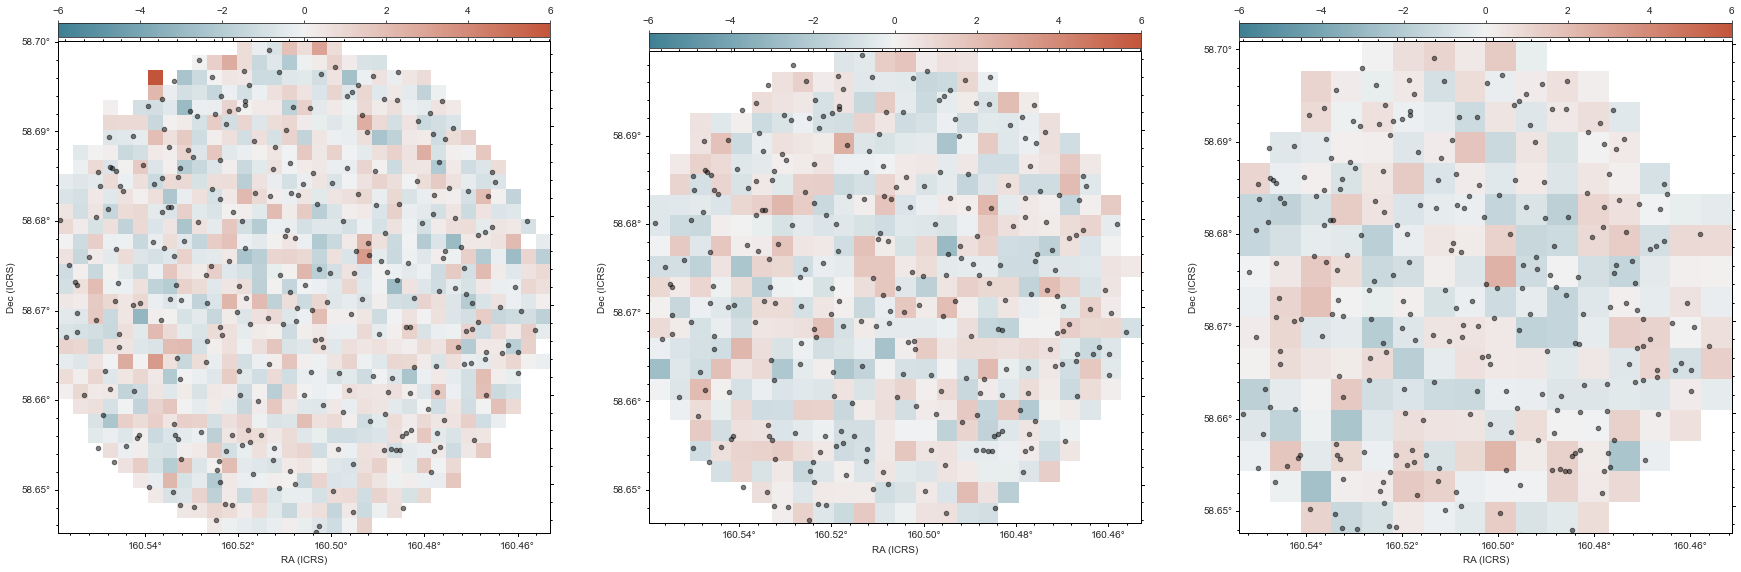

In [28]:
t=Bayes_pval_sources(fits_images)
if len(t)>0:
    priors,prior_list=process_prior(t,
                    path_to_data=['../../../data/'],
                      source=source,
                      field=field,
                      path_to_SPIRE=path_to_SPIRE,
                      redshift_file=redshift_file,
                      redshift_prior=[0.1,2.0],radius=10)
    xidplus.save(priors,None,'./output/{}/prior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2')
    prior_list.write('./output/{}/prior_list_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2.ascii',format='ascii',overwrite=True)
    hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
    phys_prior=create_phys_prior(priors,prior_list,emulator_path)
    mcmc=fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=n_chains,chain_method='parallel')

    ## For numpyro to sample from the prior, the data needs to be set to None
    import copy
    #make a deepcopy of the priors
    priors_prior_pred=copy.deepcopy(priors)
    #set data to None
    for i in range(0,len(priors)):
        priors_prior_pred[i].sim=None
    #sample from the prior using numpyro's Predictive function
    prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
    prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    
    #sample from the prior using numpyro's Predictive function
    prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = mcmc.get_samples(), num_samples = 50)
    prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]
    samples=mcmc.get_samples()
    divergences=mcmc.get_extra_fields()['diverging']
    numpyro_data = az.from_numpyro(
        mcmc,
        prior=prior_pred,
        posterior_predictive=prior_pred_samp,
        coords={"src": np.arange(0,priors[0].nsrc),
               "band":np.arange(0,3)},
        dims={"agn": ["src"],
             "bkg":["band"],
             "redshift":["src"],
              "sfr":["src"]},
        )
    numpyro_data.to_netcdf('./output/{}/posterior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2.nc')
    
    from xidplus import postmaps
    import aplpy
    sns.set_style("white")
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    Bayes_pvals = []
    hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
    fig = plt.figure(figsize=(10 * len(priors), 10))
    figs = []
    for i in range(0, len(priors)):
        figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
        Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))


    for i in range(0, len(priors)):
        figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                             marker='o', s=20, alpha=0.5)
        figs[i].tick_labels.set_xformat('dd.dd')
        figs[i].tick_labels.set_yformat('dd.dd')
        figs[i]._data[
            priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
        Bayes_pvals[i]
        figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
        figs[i].add_colorbar()
        figs[i].colorbar.set_location('top')

Read in the source we are interested in from Rowan-Robinsons's catalogue.

In [29]:


from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[esb['RA'][source[0]]]*u.degree, dec=[esb['Dec'][source[0]]]*u.degree)

In [30]:
#Run the DAOstarfinder on the original maps for all SPIRE bands
from photutils import DAOStarFinder
fwhm=[17.6,23.9,35.2]
new_scat_flux=[]
new_scat_pos=[]
for b in range(0,len(priors)):
    tmp_fits=postmaps.make_fits_image(priors[b],priors[b].sim)
    wcs_temp = wcs.WCS(tmp_fits[1].header)
    daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5.0,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5)    
    new_scat = daofind(tmp_fits[1].data)
    new_scat_coords=wcs_temp.pixel_to_world(new_scat['xcentroid'],new_scat['ycentroid'])
    idx_new, d2d_new, d3d_new = c.match_to_catalog_sky(new_scat_coords)
    new_scat_flux.append(new_scat['peak'][idx_new])
    new_scat_pos.append(new_scat_coords[idx_new])


In [31]:
posterior_blind_source_coords=[]
posterior_blind_source_flux=[]
# Run starfinder on all posterior maps
for s in range(0,mod_map_array_samp[0].shape[-1]):
    if s%1000==0:
        print(s)
    tmp_posterior_blind_source_coords=[]
    tmp_posterior_blind_source_flux=[]
    for b in range(0,len(priors)):
        tmp_fits=postmaps.make_fits_image(priors[b],mod_map_array_samp[b][...,s])
        #need to widen constriants on roundness and sharpness constraints
        daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5) 
        sources = daofind(tmp_fits[1].data)
        #print(sources)
        wcs_temp = wcs.WCS(tmp_fits[1].header)
        new_coords=wcs_temp.pixel_to_world(sources['xcentroid'],sources['ycentroid'])
   
            
        idx_tmp, d2d_tmp, d3d_tmp = c.match_to_catalog_sky(new_coords)
        tmp_posterior_blind_source_coords.append(new_coords[idx_tmp])
        tmp_posterior_blind_source_flux.append(sources[idx_tmp]['peak'])
    posterior_blind_source_coords.append(tmp_posterior_blind_source_coords)
    posterior_blind_source_flux.append(tmp_posterior_blind_source_flux)
        
    

0


1000


In [32]:
 # get original fluxes from scat
band=[250,350,500]
scat_flux=[]
scat_pos=[]
for b in band:
    file=glob.glob('../../../data/*-{}_SCAT{}SXT_DR2.fits.gz'.format(field[0],b))
    scat=Table.read(file[0])
    orig_scat_coords=SkyCoord(scat['RA'],scat['Dec'])
    
    idx, d2d, d3d = c.match_to_catalog_sky(orig_scat_coords)
    scat_flux.append(scat['Flux'][idx].data)
    scat_pos.append(orig_scat_coords[idx])
scat_flux=np.array(scat_flux)

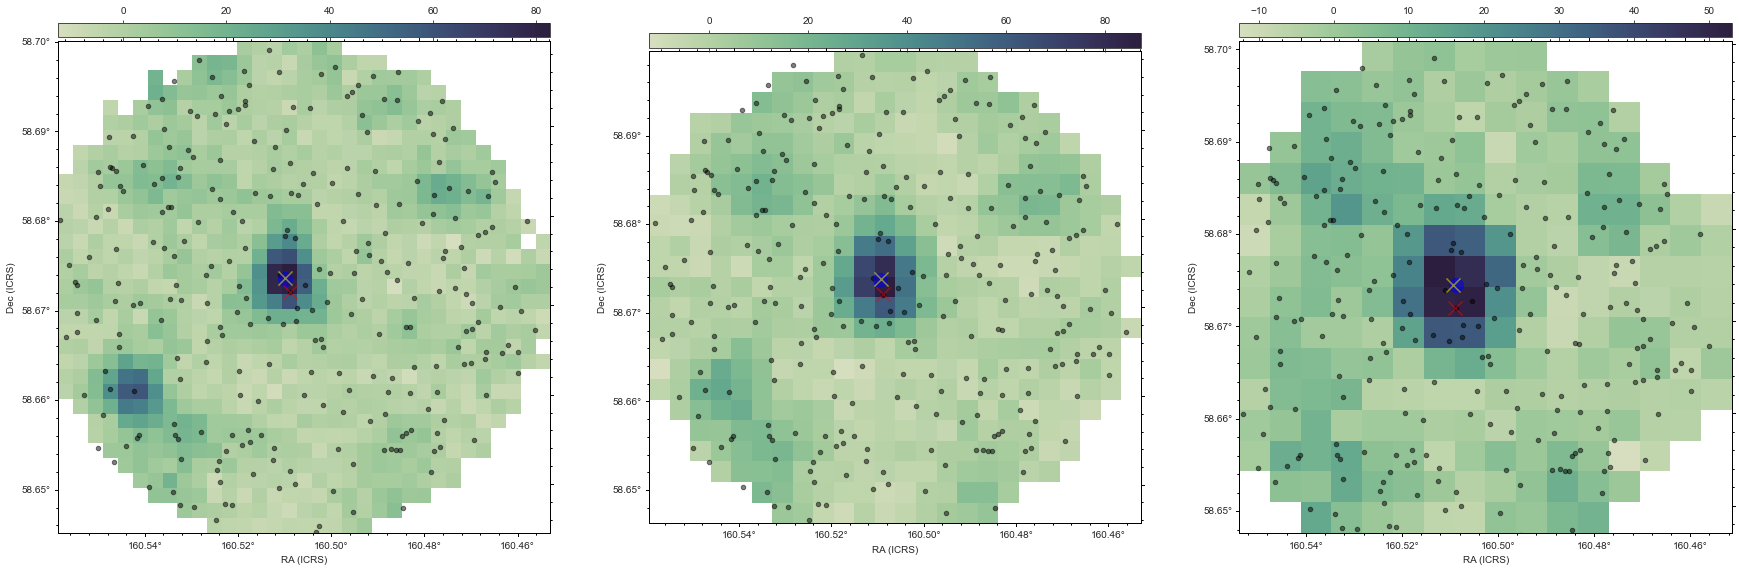

In [33]:
orig_map=xidplus.plot_map(priors)
for i in range(0,3):
    #plot new scat coords
    orig_map[0][i].show_markers(new_scat_pos[i].ra.value,new_scat_pos[i].dec.value,edgecolor='blue', facecolor='blue',
                marker='o', s=200, alpha=0.5)
    orig_map[0][i].show_markers(c.ra.value,c.dec.value, edgecolor='red', facecolor='red',
                marker='x', s=200, alpha=0.5)
    orig_map[0][i].show_markers(scat_pos[i].ra.value,scat_pos[i].dec.value,edgecolor='yellow', facecolor='yellow',
                marker='x', s=200, alpha=0.5)


In [34]:
#stack params and make vector ready to be used by emualator
params = jnp.stack((samples['sfr'].T, samples['agn'].T, samples['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params)))


#stack params and make vector ready to be used by emualator
params_prior = jnp.stack((prior_pred['sfr'].T, prior_pred['agn'].T, prior_pred['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f_prior = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params_prior)))

In [35]:
src_f.shape

(2000, 276, 3)

In [36]:
#find the sources that are within a certain separation of the extreme starburst candidate
sep=12
separation=new_scat_pos[0].separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

 Sources 
           help_id          
---------------------------
HELP_J104201.994+584018.387
HELP_J104201.199+584021.132
HELP_J104202.499+584025.262 
 are possible contributers to flux of extreme starburst


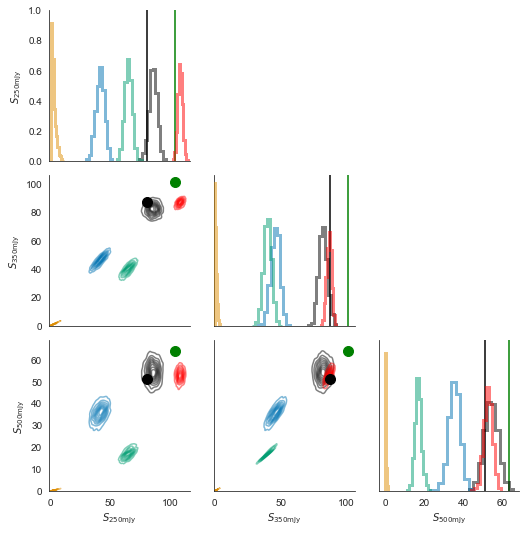

In [37]:
cmap=sns.color_palette('colorblind')
sns.set_style("white")
#set up Pairgrid plot and plot blind source flux
df_blind=pd.DataFrame(np.array(posterior_blind_source_flux)[:,:,0],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g=sns.PairGrid(df_blind)
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='black')
#g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)

#plot the fluxes for the possible sources that could contribute
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    #g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

# plot the combination of flux from those sources
df_sum=pd.DataFrame(np.sum(src_f[:,contrib_sources,:],axis=1),columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g.data=df_sum
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Red')




g.data=df_blind
g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    #g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
g.data=df_sum
g.map_lower(sns.kdeplot, color='Red',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
    
    
#turn off the axes not used
g.axes[0,1].set_axis_off()
g.axes[0,2].set_axis_off()
g.axes[1,2].set_axis_off()

#plot the fluxes from new scat and orig scat
for i in range(0,len(priors)):
    g.axes[i,i].axvline(x=new_scat_flux[i],color='black')
    g.axes[i,i].axvline(x=scat_flux[i],color='green')
    for j in range(0,len(priors)):
        if j>i:
            g.axes[j,i].plot(new_scat_flux[i],new_scat_flux[j],'ko',ms=10)
            g.axes[j,i].plot(scat_flux[i],scat_flux[j],'go',ms=10)
#g.axes[2,0].plot(0.39,32.63,'ko',ms=10)
#g.axes[3,0].plot(0.39,27.0,'ko',ms=10)


### Parameters of contributing sources
The physical parameters of our sources which could be contributing to the extreme starburst

update the webtable to identify issues

In [38]:
esb_web=Table.read('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),format='ascii',encoding='utf-8')
if np.sum(divergences)<1:
    esb_web['status'][source[0]]='[&#9745;](./output/{}/fit_{}.md)'.format(field[0],source[0]+1)
    esb_web.write('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),overwrite=True)
else:
    esb_web['status'][source[0]]='[&#9744;](./output/{}/fit_{}.md)'.format(field[0],source[0]+1)
    esb_web.write('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),overwrite=True)

## Alternative model.
Our alternative model mimics the assumption of the blind catalogue, by removing all sources close to the candidate source. We can do this and comapre the Bayesian P value maps to see if this provides a good fit to the map.

0


0


0


fitting 266 sources 

using 872, 447 and 221 pixels
source density = 109607.03207157165


  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:50:11,  6.62s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:07<13:57,  1.19it/s, 1023 steps of size 2.71e-04. acc. prob=0.32]

warmup:   1%|          | 8/1000 [00:08<14:14,  1.16it/s, 1023 steps of size 1.93e-04. acc. prob=0.37]

warmup:   1%|          | 9/1000 [00:09<14:29,  1.14it/s, 1023 steps of size 3.45e-04. acc. prob=0.44]

warmup:   1%|          | 10/1000 [00:10<14:42,  1.12it/s, 1023 steps of size 5.81e-04. acc. prob=0.49]

warmup:   1%|          | 11/1000 [00:11<14:55,  1.10it/s, 1023 steps of size 1.06e-03. acc. prob=0.54]

warmup:   1%|          | 12/1000 [00:12<15:03,  1.09it/s, 1023 steps of size 5.54e-04. acc. prob=0.54]

warmup:   1%|▏         | 13/1000 [00:13<15:09,  1.09it/s, 1023 steps of size 1.08e-03. acc. prob=0.58]

warmup:   1%|▏         | 14/1000 [00:14<15:13,  1.08it/s, 1023 steps of size 2.01e-03. acc. prob=0.60]

warmup:   2%|▏         | 15/1000 [00:15<15:16,  1.08it/s, 1023 steps of size 2.38e-03. acc. prob=0.62]

warmup:   2%|▏         | 16/1000 [00:16<15:20,  1.07it/s, 1023 steps of size 3.84e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:17<15:23,  1.06it/s, 1023 steps of size 1.05e-03. acc. prob=0.62]

warmup:   2%|▏         | 18/1000 [00:18<15:23,  1.06it/s, 1023 steps of size 1.83e-03. acc. prob=0.64]

warmup:   2%|▏         | 19/1000 [00:18<15:22,  1.06it/s, 1023 steps of size 3.52e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:19<15:21,  1.06it/s, 1023 steps of size 7.72e-04. acc. prob=0.64]

warmup:   2%|▏         | 21/1000 [00:20<15:22,  1.06it/s, 1023 steps of size 1.50e-03. acc. prob=0.66]

warmup:   2%|▏         | 22/1000 [00:21<15:22,  1.06it/s, 1023 steps of size 2.38e-03. acc. prob=0.67]

warmup:   2%|▏         | 23/1000 [00:22<15:21,  1.06it/s, 1023 steps of size 2.71e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:23<15:19,  1.06it/s, 1023 steps of size 4.88e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:24<15:18,  1.06it/s, 1023 steps of size 3.36e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:25<15:17,  1.06it/s, 1023 steps of size 4.66e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:26<15:21,  1.06it/s, 1023 steps of size 3.91e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:27<15:22,  1.05it/s, 1023 steps of size 6.84e-03. acc. prob=0.71]

warmup:   3%|▎         | 29/1000 [00:27<11:51,  1.36it/s, 242 steps of size 2.40e-03. acc. prob=0.70] 

warmup:   3%|▎         | 30/1000 [00:28<12:52,  1.26it/s, 1023 steps of size 3.72e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:29<13:33,  1.19it/s, 1023 steps of size 6.32e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:29<10:11,  1.58it/s, 156 steps of size 1.61e-03. acc. prob=0.70] 

warmup:   3%|▎         | 33/1000 [00:30<11:42,  1.38it/s, 1023 steps of size 2.85e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:31<12:43,  1.26it/s, 1023 steps of size 1.52e-03. acc. prob=0.70]

warmup:   4%|▎         | 35/1000 [00:32<13:26,  1.20it/s, 1023 steps of size 1.68e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:33<13:56,  1.15it/s, 1023 steps of size 1.48e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:34<14:16,  1.12it/s, 1023 steps of size 2.65e-03. acc. prob=0.71]

warmup:   4%|▍         | 38/1000 [00:35<14:30,  1.10it/s, 1023 steps of size 4.59e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:36<14:42,  1.09it/s, 1023 steps of size 4.13e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:37<14:52,  1.08it/s, 1023 steps of size 2.61e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:38<14:55,  1.07it/s, 1023 steps of size 4.25e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:39<14:57,  1.07it/s, 1023 steps of size 6.55e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:40<11:34,  1.38it/s, 1023 steps of size 1.60e-03. acc. prob=0.72]

warmup:   4%|▍         | 45/1000 [00:41<12:25,  1.28it/s, 1023 steps of size 2.73e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:42<13:05,  1.21it/s, 1023 steps of size 3.66e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:42<13:35,  1.17it/s, 1023 steps of size 2.65e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:43<13:57,  1.14it/s, 1023 steps of size 2.96e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:44<14:13,  1.11it/s, 1023 steps of size 4.73e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:45<14:25,  1.10it/s, 1023 steps of size 4.03e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:46<14:34,  1.08it/s, 1023 steps of size 1.49e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:47<14:39,  1.08it/s, 1023 steps of size 2.41e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [00:48<14:41,  1.07it/s, 1023 steps of size 3.28e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:49<14:43,  1.07it/s, 1023 steps of size 4.66e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:50<14:45,  1.07it/s, 1023 steps of size 4.39e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:51<14:47,  1.06it/s, 1023 steps of size 4.03e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:52<14:46,  1.06it/s, 1023 steps of size 6.44e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:53<11:35,  1.35it/s, 1023 steps of size 2.06e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:54<12:21,  1.27it/s, 1023 steps of size 3.29e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:55<12:58,  1.21it/s, 1023 steps of size 3.00e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:56<13:28,  1.16it/s, 1023 steps of size 4.51e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:57<13:48,  1.13it/s, 1023 steps of size 4.86e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:58<14:03,  1.11it/s, 1023 steps of size 3.01e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:59<14:16,  1.09it/s, 1023 steps of size 4.75e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [01:00<14:26,  1.08it/s, 1023 steps of size 1.34e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [01:00<14:33,  1.07it/s, 1023 steps of size 1.95e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:01<14:34,  1.07it/s, 1023 steps of size 2.95e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [01:02<14:33,  1.07it/s, 1023 steps of size 4.33e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:03<14:33,  1.06it/s, 1023 steps of size 2.36e-03. acc. prob=0.74]

warmup:   7%|▋         | 71/1000 [01:04<14:33,  1.06it/s, 1023 steps of size 3.22e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:05<14:35,  1.06it/s, 1023 steps of size 4.39e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:06<14:34,  1.06it/s, 1023 steps of size 4.70e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:07<14:33,  1.06it/s, 1023 steps of size 2.20e-03. acc. prob=0.74]

warmup:   8%|▊         | 75/1000 [01:08<14:32,  1.06it/s, 1023 steps of size 2.44e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:09<14:30,  1.06it/s, 1023 steps of size 2.63e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:10<14:28,  1.06it/s, 1023 steps of size 4.00e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:11<14:29,  1.06it/s, 1023 steps of size 4.15e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:12<14:28,  1.06it/s, 1023 steps of size 6.29e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:12<12:24,  1.24it/s, 540 steps of size 2.98e-03. acc. prob=0.75] 

warmup:   8%|▊         | 81/1000 [01:13<13:00,  1.18it/s, 1023 steps of size 3.60e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:14<13:25,  1.14it/s, 1023 steps of size 4.62e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:15<13:49,  1.11it/s, 1023 steps of size 2.95e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:16<14:00,  1.09it/s, 1023 steps of size 4.44e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:17<14:06,  1.08it/s, 1023 steps of size 6.73e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:18<10:55,  1.39it/s, 1023 steps of size 2.38e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:19<11:47,  1.29it/s, 1023 steps of size 3.31e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:20<12:26,  1.22it/s, 1023 steps of size 4.63e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:21<12:58,  1.17it/s, 1023 steps of size 3.41e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:22<13:19,  1.14it/s, 1023 steps of size 5.13e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:23<13:36,  1.11it/s, 1023 steps of size 5.98e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:23<11:07,  1.36it/s, 363 steps of size 1.87e-03. acc. prob=0.75] 

warmup:   9%|▉         | 94/1000 [01:24<12:01,  1.26it/s, 1023 steps of size 2.46e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [01:25<12:38,  1.19it/s, 1023 steps of size 3.53e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:26<13:07,  1.15it/s, 1023 steps of size 4.33e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:27<13:26,  1.12it/s, 1023 steps of size 5.67e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:28<12:54,  1.16it/s, 846 steps of size 6.01e-03. acc. prob=0.76] 

warmup:  10%|▉         | 99/1000 [01:28<10:00,  1.50it/s, 233 steps of size 4.69e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:29<11:13,  1.34it/s, 1023 steps of size 5.85e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:30<12:04,  1.24it/s, 1023 steps of size 7.75e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:30<08:09,  1.83it/s, 511 steps of size 1.33e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:31<07:54,  1.89it/s, 511 steps of size 1.48e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:31<07:42,  1.94it/s, 511 steps of size 1.73e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:31<06:33,  2.27it/s, 255 steps of size 3.08e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:32<05:42,  2.61it/s, 255 steps of size 8.77e-03. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:32<06:06,  2.43it/s, 511 steps of size 1.50e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:32<05:21,  2.77it/s, 255 steps of size 1.99e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:33<04:48,  3.09it/s, 255 steps of size 2.68e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:33<04:25,  3.35it/s, 255 steps of size 4.84e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:34<05:35,  2.64it/s, 1023 steps of size 6.97e-03. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:35<07:38,  1.93it/s, 1023 steps of size 1.03e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:35<07:28,  1.97it/s, 511 steps of size 1.55e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 116/1000 [01:35<06:23,  2.31it/s, 255 steps of size 1.65e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:36<05:34,  2.64it/s, 255 steps of size 2.85e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:36<04:58,  2.96it/s, 255 steps of size 6.27e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:37<07:31,  1.95it/s, 1023 steps of size 7.01e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:38<09:21,  1.57it/s, 1023 steps of size 1.28e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:38<08:39,  1.69it/s, 511 steps of size 1.29e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 122/1000 [01:39<08:07,  1.80it/s, 511 steps of size 6.88e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:40<09:47,  1.49it/s, 1023 steps of size 1.13e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:40<08:55,  1.64it/s, 511 steps of size 9.42e-03. acc. prob=0.76] 

warmup:  12%|█▎        | 125/1000 [01:41<08:19,  1.75it/s, 511 steps of size 1.65e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:41<06:51,  2.12it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:  13%|█▎        | 127/1000 [01:41<05:49,  2.49it/s, 255 steps of size 4.26e-02. acc. prob=0.77]

warmup:  13%|█▎        | 129/1000 [01:42<04:57,  2.93it/s, 511 steps of size 2.04e-02. acc. prob=0.77]

warmup:  13%|█▎        | 130/1000 [01:42<04:34,  3.17it/s, 255 steps of size 2.08e-02. acc. prob=0.77]

warmup:  13%|█▎        | 131/1000 [01:42<04:16,  3.39it/s, 255 steps of size 1.47e-02. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:43<04:59,  2.90it/s, 511 steps of size 2.12e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:43<04:32,  3.18it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:43<04:12,  3.42it/s, 255 steps of size 2.94e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:43<03:58,  3.62it/s, 255 steps of size 1.42e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:44<04:47,  3.00it/s, 511 steps of size 1.29e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:44<05:22,  2.67it/s, 511 steps of size 7.81e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [01:45<07:48,  1.84it/s, 1023 steps of size 1.22e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:46<07:30,  1.91it/s, 511 steps of size 2.04e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 140/1000 [01:46<06:17,  2.28it/s, 255 steps of size 1.83e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:46<05:24,  2.64it/s, 255 steps of size 1.69e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:46<04:49,  2.97it/s, 255 steps of size 1.85e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:47<04:22,  3.26it/s, 255 steps of size 2.95e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:47<03:32,  4.04it/s, 117 steps of size 6.69e-03. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:48<06:29,  2.19it/s, 1023 steps of size 1.10e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:48<06:33,  2.17it/s, 511 steps of size 1.66e-02. acc. prob=0.77] 

warmup:  15%|█▍        | 147/1000 [01:48<05:35,  2.54it/s, 255 steps of size 1.10e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:49<05:55,  2.40it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:49<05:08,  2.76it/s, 255 steps of size 2.48e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:49<04:36,  3.08it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:50<04:32,  3.11it/s, 1023 steps of size 2.84e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:51<06:23,  2.21it/s, 1023 steps of size 3.68e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:52<07:58,  1.77it/s, 1023 steps of size 5.50e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:53<09:16,  1.52it/s, 1023 steps of size 7.81e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:54<08:34,  1.64it/s, 511 steps of size 3.75e-03. acc. prob=0.76] 

warmup:  16%|█▌        | 158/1000 [01:55<09:49,  1.43it/s, 1023 steps of size 6.75e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [01:55<08:55,  1.57it/s, 511 steps of size 9.32e-03. acc. prob=0.77] 

warmup:  16%|█▌        | 160/1000 [01:55<08:17,  1.69it/s, 511 steps of size 5.13e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [01:56<09:42,  1.44it/s, 1023 steps of size 9.00e-03. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:57<08:47,  1.59it/s, 511 steps of size 1.60e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 164/1000 [01:58<07:47,  1.79it/s, 1023 steps of size 4.78e-03. acc. prob=0.76]

warmup:  16%|█▋        | 165/1000 [01:59<09:04,  1.53it/s, 1023 steps of size 7.08e-03. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:59<08:25,  1.65it/s, 511 steps of size 1.20e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 167/1000 [02:00<07:54,  1.76it/s, 511 steps of size 1.45e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:01<07:27,  1.86it/s, 1023 steps of size 3.36e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:02<08:46,  1.58it/s, 1023 steps of size 5.39e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:03<09:50,  1.40it/s, 1023 steps of size 8.58e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:03<08:56,  1.54it/s, 511 steps of size 7.09e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [02:04<08:18,  1.66it/s, 511 steps of size 7.47e-03. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:04<07:48,  1.76it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:04<06:31,  2.11it/s, 255 steps of size 1.16e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:05<06:32,  2.10it/s, 511 steps of size 2.08e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:06<06:34,  2.08it/s, 1023 steps of size 4.04e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:07<08:06,  1.69it/s, 1023 steps of size 4.93e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:08<09:20,  1.46it/s, 1023 steps of size 8.72e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:08<08:33,  1.60it/s, 511 steps of size 8.86e-03. acc. prob=0.77] 

warmup:  18%|█▊        | 182/1000 [02:09<07:57,  1.71it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:10<07:21,  1.85it/s, 1023 steps of size 2.92e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:10<08:40,  1.57it/s, 1023 steps of size 4.63e-03. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:11<09:42,  1.40it/s, 1023 steps of size 6.11e-03. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:12<10:31,  1.29it/s, 1023 steps of size 1.05e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:13<09:21,  1.45it/s, 511 steps of size 1.18e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 189/1000 [02:13<08:30,  1.59it/s, 511 steps of size 7.14e-03. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:14<07:53,  1.71it/s, 511 steps of size 1.18e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:14<07:25,  1.81it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:15<06:55,  1.94it/s, 461 steps of size 4.45e-03. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:16<08:38,  1.56it/s, 1023 steps of size 4.95e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:17<09:55,  1.35it/s, 1023 steps of size 7.18e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:17<08:51,  1.52it/s, 511 steps of size 1.16e-02. acc. prob=0.77] 

warmup:  20%|█▉        | 196/1000 [02:18<08:05,  1.65it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:18<07:20,  1.82it/s, 1023 steps of size 5.44e-03. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:19<08:38,  1.55it/s, 1023 steps of size 5.91e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:20<09:41,  1.38it/s, 1023 steps of size 8.71e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:21<08:47,  1.52it/s, 511 steps of size 8.73e-03. acc. prob=0.77] 

warmup:  20%|██        | 202/1000 [02:21<08:04,  1.65it/s, 511 steps of size 6.84e-03. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:22<07:33,  1.76it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:23<07:14,  1.83it/s, 1023 steps of size 6.59e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:24<08:30,  1.56it/s, 1023 steps of size 8.00e-03. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:24<07:54,  1.67it/s, 511 steps of size 1.19e-02. acc. prob=0.77] 

warmup:  21%|██        | 209/1000 [02:25<06:04,  2.17it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:25<06:06,  2.16it/s, 511 steps of size 5.60e-03. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:26<07:41,  1.71it/s, 1023 steps of size 8.69e-03. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:27<07:17,  1.80it/s, 511 steps of size 8.94e-03. acc. prob=0.77] 

warmup:  21%|██▏       | 213/1000 [02:27<06:58,  1.88it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:27<05:34,  2.35it/s, 164 steps of size 1.66e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:28<04:51,  2.69it/s, 255 steps of size 1.39e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:28<03:50,  3.40it/s, 110 steps of size 9.67e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:28<04:30,  2.89it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:28<04:05,  3.19it/s, 255 steps of size 1.57e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:29<03:37,  3.59it/s, 209 steps of size 1.08e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:29<04:21,  2.98it/s, 511 steps of size 9.14e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:30<04:53,  2.66it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:30<04:20,  2.99it/s, 255 steps of size 8.03e-03. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:30<04:52,  2.66it/s, 511 steps of size 9.54e-03. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:31<05:15,  2.46it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:31<04:09,  3.11it/s, 134 steps of size 5.57e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:32<06:32,  1.97it/s, 1023 steps of size 8.03e-03. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:32<06:23,  2.01it/s, 511 steps of size 7.98e-03. acc. prob=0.77] 

warmup:  23%|██▎       | 228/1000 [02:33<06:17,  2.04it/s, 511 steps of size 9.92e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:33<05:26,  2.36it/s, 293 steps of size 2.29e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:34<07:25,  1.73it/s, 1023 steps of size 3.46e-03. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:35<08:48,  1.46it/s, 1023 steps of size 4.94e-03. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:36<09:54,  1.29it/s, 1023 steps of size 6.53e-03. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:37<10:40,  1.20it/s, 1023 steps of size 9.70e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:37<09:18,  1.37it/s, 511 steps of size 5.47e-03. acc. prob=0.77] 

warmup:  24%|██▎       | 235/1000 [02:38<10:10,  1.25it/s, 1023 steps of size 8.20e-03. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:39<08:55,  1.43it/s, 511 steps of size 1.20e-02. acc. prob=0.77] 

warmup:  24%|██▎       | 237/1000 [02:39<07:19,  1.74it/s, 306 steps of size 6.84e-03. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:39<06:55,  1.84it/s, 511 steps of size 9.56e-03. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [02:40<06:37,  1.91it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:41<06:29,  1.95it/s, 1023 steps of size 6.22e-03. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [02:42<07:49,  1.62it/s, 1023 steps of size 9.01e-03. acc. prob=0.77]

warmup:  24%|██▍       | 243/1000 [02:42<07:19,  1.72it/s, 511 steps of size 1.32e-02. acc. prob=0.78] 

warmup:  24%|██▍       | 245/1000 [02:43<05:29,  2.29it/s, 511 steps of size 5.41e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [02:44<06:58,  1.80it/s, 1023 steps of size 7.33e-03. acc. prob=0.77]

warmup:  25%|██▍       | 247/1000 [02:44<06:41,  1.87it/s, 511 steps of size 9.49e-03. acc. prob=0.77] 

warmup:  25%|██▍       | 248/1000 [02:45<06:30,  1.93it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:45<06:20,  1.97it/s, 511 steps of size 9.60e-03. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:46<06:13,  2.01it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:46<05:16,  2.36it/s, 255 steps of size 5.23e-02. acc. prob=0.77]

warmup:  25%|██▌       | 253/1000 [02:47<05:32,  2.24it/s, 1023 steps of size 6.61e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:47<05:37,  2.21it/s, 511 steps of size 6.53e-03. acc. prob=0.77] 

warmup:  26%|██▌       | 255/1000 [02:48<07:10,  1.73it/s, 1023 steps of size 8.65e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:49<06:48,  1.82it/s, 511 steps of size 1.32e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 257/1000 [02:49<05:43,  2.16it/s, 255 steps of size 1.54e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:49<04:55,  2.51it/s, 255 steps of size 2.68e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:50<05:21,  2.31it/s, 1023 steps of size 8.56e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:51<05:28,  2.25it/s, 511 steps of size 1.50e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 262/1000 [02:51<04:48,  2.56it/s, 255 steps of size 2.16e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:51<04:07,  2.98it/s, 198 steps of size 2.04e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:51<03:46,  3.25it/s, 255 steps of size 6.03e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:52<05:58,  2.05it/s, 1023 steps of size 5.94e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:53<07:37,  1.60it/s, 1023 steps of size 1.10e-02. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:54<07:04,  1.73it/s, 511 steps of size 1.98e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 269/1000 [02:55<06:29,  1.88it/s, 1023 steps of size 5.12e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:56<07:43,  1.58it/s, 1023 steps of size 8.06e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:56<07:11,  1.69it/s, 511 steps of size 1.47e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 273/1000 [02:57<06:43,  1.80it/s, 1023 steps of size 4.02e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:58<07:47,  1.55it/s, 1023 steps of size 4.04e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:59<08:41,  1.39it/s, 1023 steps of size 7.02e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [02:59<07:53,  1.53it/s, 511 steps of size 1.15e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 277/1000 [03:00<07:16,  1.66it/s, 511 steps of size 6.32e-03. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [03:01<08:26,  1.43it/s, 1023 steps of size 1.13e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [03:01<07:37,  1.57it/s, 511 steps of size 1.85e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 281/1000 [03:01<04:37,  2.59it/s, 114 steps of size 1.36e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [03:02<04:11,  2.86it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [03:02<03:49,  3.12it/s, 255 steps of size 7.58e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [03:02<04:18,  2.77it/s, 511 steps of size 9.58e-03. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [03:03<04:40,  2.55it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [03:03<04:08,  2.88it/s, 255 steps of size 8.16e-03. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [03:04<04:33,  2.61it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [03:04<04:51,  2.44it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [03:04<04:12,  2.82it/s, 243 steps of size 6.97e-03. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [03:05<04:36,  2.57it/s, 511 steps of size 8.53e-03. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [03:05<04:54,  2.41it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [03:05<04:16,  2.76it/s, 255 steps of size 9.00e-03. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [03:06<04:39,  2.53it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [03:06<04:05,  2.88it/s, 255 steps of size 4.46e-03. acc. prob=0.77]

warmup:  30%|██▉       | 295/1000 [03:07<06:10,  1.90it/s, 1023 steps of size 7.35e-03. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [03:08<05:58,  1.96it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 297/1000 [03:08<05:50,  2.01it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:08<04:54,  2.38it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [03:09<05:06,  2.29it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:09<04:02,  2.89it/s, 141 steps of size 3.08e-03. acc. prob=0.77]

warmup:  30%|███       | 301/1000 [03:10<06:07,  1.90it/s, 1023 steps of size 4.91e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:11<07:36,  1.53it/s, 1023 steps of size 6.27e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:12<08:36,  1.35it/s, 1023 steps of size 7.62e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:12<07:39,  1.51it/s, 511 steps of size 7.64e-03. acc. prob=0.78] 

warmup:  30%|███       | 305/1000 [03:13<06:59,  1.66it/s, 511 steps of size 8.59e-03. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:13<06:31,  1.77it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:13<05:22,  2.15it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:14<05:29,  2.10it/s, 1023 steps of size 8.73e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:15<05:29,  2.09it/s, 511 steps of size 1.31e-02. acc. prob=0.78] 

warmup:  31%|███       | 311/1000 [03:15<04:45,  2.41it/s, 255 steps of size 5.73e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:16<06:24,  1.79it/s, 1023 steps of size 8.98e-03. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:17<06:07,  1.87it/s, 511 steps of size 1.00e-02. acc. prob=0.78] 

warmup:  31%|███▏      | 314/1000 [03:17<05:54,  1.94it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:17<04:58,  2.30it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:17<04:18,  2.65it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:18<03:49,  2.98it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:18<03:10,  3.58it/s, 154 steps of size 1.40e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:18<03:01,  3.75it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:19<04:11,  2.70it/s, 1023 steps of size 5.25e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:20<05:46,  1.96it/s, 1023 steps of size 7.29e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:21<05:40,  1.99it/s, 511 steps of size 1.11e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 324/1000 [03:21<05:33,  2.02it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:21<04:45,  2.37it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:21<04:08,  2.71it/s, 255 steps of size 1.04e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:22<04:28,  2.51it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:22<03:56,  2.85it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:23<04:34,  2.44it/s, 1023 steps of size 8.63e-03. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:24<04:43,  2.36it/s, 511 steps of size 1.29e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 332/1000 [03:24<04:51,  2.29it/s, 511 steps of size 1.73e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:24<04:15,  2.62it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:24<03:39,  3.03it/s, 209 steps of size 1.37e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:25<03:21,  3.30it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:25<03:03,  3.61it/s, 229 steps of size 1.05e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:25<03:42,  2.98it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:26<03:23,  3.26it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:26<03:08,  3.51it/s, 511 steps of size 9.15e-03. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:27<03:38,  3.02it/s, 511 steps of size 6.18e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:28<05:22,  2.04it/s, 1023 steps of size 8.06e-03. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:28<05:18,  2.06it/s, 511 steps of size 8.69e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 344/1000 [03:29<05:18,  2.06it/s, 511 steps of size 9.71e-03. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:29<05:15,  2.08it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:29<05:12,  2.09it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:30<04:15,  2.55it/s, 194 steps of size 1.10e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:30<04:30,  2.41it/s, 511 steps of size 8.46e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:31<04:42,  2.30it/s, 511 steps of size 9.71e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:31<04:49,  2.25it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:32<04:54,  2.21it/s, 511 steps of size 3.99e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:33<06:27,  1.67it/s, 1023 steps of size 5.48e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:33<07:33,  1.43it/s, 1023 steps of size 7.72e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:34<06:48,  1.58it/s, 511 steps of size 1.01e-02. acc. prob=0.78] 

warmup:  36%|███▌      | 355/1000 [03:34<06:16,  1.71it/s, 511 steps of size 6.50e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:35<05:54,  1.82it/s, 511 steps of size 8.93e-03. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:35<05:39,  1.89it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:36<05:28,  1.95it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:36<05:20,  2.00it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:37<05:14,  2.04it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:38<05:23,  1.97it/s, 1023 steps of size 5.94e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:39<06:34,  1.61it/s, 1023 steps of size 7.38e-03. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:39<06:09,  1.72it/s, 511 steps of size 1.02e-02. acc. prob=0.78] 

warmup:  36%|███▋      | 365/1000 [03:40<05:49,  1.82it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:40<04:53,  2.16it/s, 255 steps of size 6.58e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:40<04:55,  2.14it/s, 511 steps of size 9.22e-03. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:41<04:55,  2.14it/s, 511 steps of size 8.59e-03. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:41<04:55,  2.13it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:42<04:56,  2.13it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:42<04:12,  2.49it/s, 255 steps of size 4.12e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:43<05:55,  1.77it/s, 1023 steps of size 4.10e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:44<07:07,  1.47it/s, 1023 steps of size 5.76e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:45<07:55,  1.32it/s, 1023 steps of size 8.02e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:45<07:02,  1.48it/s, 511 steps of size 9.64e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 376/1000 [03:46<06:24,  1.62it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:46<05:56,  1.75it/s, 511 steps of size 7.21e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:47<05:37,  1.84it/s, 511 steps of size 9.95e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:47<05:25,  1.91it/s, 511 steps of size 9.62e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:48<05:15,  1.97it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:48<05:07,  2.01it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:48<04:18,  2.39it/s, 255 steps of size 7.23e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:49<04:28,  2.30it/s, 511 steps of size 8.02e-03. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:49<04:34,  2.24it/s, 511 steps of size 9.77e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:50<04:40,  2.19it/s, 511 steps of size 7.36e-03. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:50<04:42,  2.17it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:51<04:44,  2.16it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:51<04:01,  2.53it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:51<03:32,  2.88it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:51<02:51,  3.55it/s, 134 steps of size 1.39e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:52<02:43,  3.73it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:52<02:37,  3.87it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:52<02:08,  4.74it/s, 107 steps of size 2.20e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:53<02:20,  4.30it/s, 511 steps of size 9.90e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:53<02:56,  3.43it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:53<02:47,  3.61it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:53<02:40,  3.76it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:54<02:35,  3.86it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:54<02:31,  3.96it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:54<02:28,  4.04it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:55<02:33,  3.88it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:55<03:05,  3.22it/s, 511 steps of size 8.24e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:56<03:30,  2.83it/s, 511 steps of size 7.67e-03. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:56<03:48,  2.60it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:57<04:02,  2.44it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:57<03:33,  2.78it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:58<04:09,  2.37it/s, 1023 steps of size 5.50e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:59<05:22,  1.82it/s, 1023 steps of size 7.22e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:59<05:10,  1.89it/s, 511 steps of size 9.44e-03. acc. prob=0.78] 

warmup:  41%|████▏     | 413/1000 [04:00<05:03,  1.94it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [04:00<04:55,  1.98it/s, 511 steps of size 8.44e-03. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [04:01<04:50,  2.01it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [04:01<04:45,  2.04it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [04:01<04:02,  2.41it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [04:02<03:31,  2.75it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [04:02<03:09,  3.07it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [04:02<02:53,  3.35it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [04:02<02:42,  3.57it/s, 255 steps of size 1.24e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [04:03<02:34,  3.75it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [04:03<03:09,  3.05it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [04:04<03:33,  2.70it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [04:04<03:50,  2.49it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [04:04<04:02,  2.37it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:05<04:10,  2.29it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:05<04:17,  2.22it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:06<04:22,  2.17it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:06<04:24,  2.16it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:07<04:25,  2.14it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [04:07<04:25,  2.14it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [04:08<03:46,  2.51it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:08<03:09,  2.99it/s, 197 steps of size 1.97e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:08<02:52,  3.27it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:08<02:40,  3.51it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:08<02:32,  3.70it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:09<02:26,  3.84it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:09<03:01,  3.09it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:10<03:26,  2.72it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:10<03:03,  3.04it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:10<02:47,  3.32it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:10<02:28,  3.75it/s, 196 steps of size 1.26e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:11<03:02,  3.04it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:11<02:48,  3.30it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:12<03:15,  2.83it/s, 511 steps of size 9.26e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:12<03:34,  2.57it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:12<03:48,  2.42it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:13<03:57,  2.32it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:13<03:24,  2.68it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:14<03:40,  2.49it/s, 511 steps of size 1.76e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:15<03:13,  2.83it/s, 1023 steps of size 3.59e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:16<04:23,  2.07it/s, 1023 steps of size 5.39e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:16<05:22,  1.69it/s, 1023 steps of size 8.72e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:17<05:07,  1.77it/s, 511 steps of size 1.18e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 458/1000 [04:17<04:53,  1.84it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:18<04:43,  1.91it/s, 511 steps of size 2.28e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:19<04:30,  1.99it/s, 1023 steps of size 7.17e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:19<04:25,  2.02it/s, 511 steps of size 1.31e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 463/1000 [04:20<03:50,  2.33it/s, 255 steps of size 8.30e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:20<03:58,  2.25it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:20<03:27,  2.58it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:21<03:47,  2.35it/s, 1023 steps of size 3.42e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:22<04:52,  1.82it/s, 1023 steps of size 4.53e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:23<05:45,  1.54it/s, 1023 steps of size 7.12e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:24<05:19,  1.66it/s, 511 steps of size 8.85e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 471/1000 [04:24<04:59,  1.77it/s, 511 steps of size 8.25e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:25<04:44,  1.85it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:25<04:34,  1.92it/s, 511 steps of size 5.99e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:26<04:26,  1.97it/s, 511 steps of size 9.91e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:26<04:21,  2.01it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:26<03:40,  2.38it/s, 255 steps of size 1.58e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:27<05:00,  1.74it/s, 1023 steps of size 2.80e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:28<05:57,  1.46it/s, 1023 steps of size 5.05e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:29<06:36,  1.31it/s, 1023 steps of size 8.55e-03. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:30<05:50,  1.48it/s, 511 steps of size 1.28e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 481/1000 [04:30<04:42,  1.84it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:30<03:54,  2.21it/s, 255 steps of size 7.02e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:30<03:57,  2.18it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:31<03:59,  2.15it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:32<04:01,  2.13it/s, 1023 steps of size 3.91e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:33<05:00,  1.70it/s, 1023 steps of size 5.46e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:34<05:47,  1.47it/s, 1023 steps of size 8.29e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:34<05:18,  1.61it/s, 511 steps of size 1.40e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 490/1000 [04:34<04:22,  1.94it/s, 255 steps of size 1.04e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:35<04:15,  1.99it/s, 511 steps of size 9.77e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:35<04:11,  2.02it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:36<04:07,  2.05it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:36<03:10,  2.65it/s, 119 steps of size 3.98e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:37<04:34,  1.84it/s, 1023 steps of size 6.40e-03. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:37<04:23,  1.91it/s, 511 steps of size 8.63e-03. acc. prob=0.78] 

warmup:  50%|████▉     | 497/1000 [04:38<04:15,  1.97it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:38<03:35,  2.33it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:39<03:42,  2.25it/s, 511 steps of size 9.22e-03. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:39<03:46,  2.21it/s, 511 steps of size 8.51e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:40<03:48,  2.18it/s, 511 steps of size 8.51e-03. acc. prob=0.86]

sample:  50%|█████     | 502/1000 [04:40<03:50,  2.16it/s, 511 steps of size 8.51e-03. acc. prob=0.75]

sample:  50%|█████     | 503/1000 [04:41<03:51,  2.15it/s, 511 steps of size 8.51e-03. acc. prob=0.83]

sample:  50%|█████     | 504/1000 [04:41<03:52,  2.14it/s, 511 steps of size 8.51e-03. acc. prob=0.86]

sample:  50%|█████     | 505/1000 [04:41<03:53,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.85]

sample:  51%|█████     | 506/1000 [04:42<03:52,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.85]

sample:  51%|█████     | 507/1000 [04:42<03:52,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.86]

sample:  51%|█████     | 508/1000 [04:43<03:51,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.86]

sample:  51%|█████     | 509/1000 [04:43<03:51,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.86]

sample:  51%|█████     | 510/1000 [04:44<03:50,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.85]

sample:  51%|█████     | 511/1000 [04:44<03:50,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.84]

sample:  51%|█████     | 512/1000 [04:45<03:50,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.85]

sample:  51%|█████▏    | 513/1000 [04:45<03:50,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.86]

sample:  51%|█████▏    | 514/1000 [04:46<03:50,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.87]

sample:  52%|█████▏    | 515/1000 [04:46<03:51,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  52%|█████▏    | 516/1000 [04:47<03:50,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  52%|█████▏    | 517/1000 [04:47<03:49,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.87]

sample:  52%|█████▏    | 518/1000 [04:48<03:48,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  52%|█████▏    | 519/1000 [04:48<03:47,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  52%|█████▏    | 520/1000 [04:49<03:47,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  52%|█████▏    | 521/1000 [04:49<03:47,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  52%|█████▏    | 522/1000 [04:50<03:46,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.87]

sample:  52%|█████▏    | 523/1000 [04:50<03:46,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  52%|█████▏    | 524/1000 [04:50<03:46,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  52%|█████▎    | 525/1000 [04:51<03:45,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  53%|█████▎    | 526/1000 [04:51<03:45,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  53%|█████▎    | 527/1000 [04:52<03:44,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  53%|█████▎    | 528/1000 [04:52<03:43,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.88]

sample:  53%|█████▎    | 529/1000 [04:53<03:42,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  53%|█████▎    | 530/1000 [04:53<03:41,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  53%|█████▎    | 531/1000 [04:54<03:41,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [04:54<03:40,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [04:55<03:40,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  53%|█████▎    | 534/1000 [04:55<03:40,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  54%|█████▎    | 535/1000 [04:56<03:39,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  54%|█████▎    | 536/1000 [04:56<03:39,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  54%|█████▎    | 537/1000 [04:57<03:38,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  54%|█████▍    | 538/1000 [04:57<03:37,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  54%|█████▍    | 539/1000 [04:58<03:39,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  54%|█████▍    | 540/1000 [04:58<03:38,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  54%|█████▍    | 541/1000 [04:59<03:37,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  54%|█████▍    | 542/1000 [04:59<03:36,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  54%|█████▍    | 543/1000 [04:59<03:36,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  54%|█████▍    | 544/1000 [05:00<03:36,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▍    | 545/1000 [05:00<03:35,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▍    | 546/1000 [05:01<03:35,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▍    | 547/1000 [05:01<03:34,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▍    | 548/1000 [05:02<03:33,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▍    | 549/1000 [05:02<03:32,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▌    | 550/1000 [05:03<03:32,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▌    | 551/1000 [05:03<03:31,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▌    | 552/1000 [05:04<03:31,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  55%|█████▌    | 553/1000 [05:04<03:30,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  55%|█████▌    | 554/1000 [05:05<03:30,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▌    | 555/1000 [05:05<03:31,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▌    | 556/1000 [05:06<03:31,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▌    | 557/1000 [05:06<03:30,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▌    | 558/1000 [05:07<03:29,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▌    | 559/1000 [05:07<03:28,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▌    | 560/1000 [05:08<03:27,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▌    | 561/1000 [05:08<03:28,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▌    | 562/1000 [05:08<03:27,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▋    | 563/1000 [05:09<03:26,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▋    | 564/1000 [05:09<03:25,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  56%|█████▋    | 565/1000 [05:10<03:25,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 566/1000 [05:10<03:25,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 567/1000 [05:11<03:24,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 568/1000 [05:11<03:24,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 569/1000 [05:12<03:23,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 570/1000 [05:12<03:22,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 571/1000 [05:13<03:22,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 572/1000 [05:13<03:21,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 573/1000 [05:14<03:21,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▋    | 574/1000 [05:14<03:20,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  57%|█████▊    | 575/1000 [05:15<03:20,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  58%|█████▊    | 576/1000 [05:15<03:20,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  58%|█████▊    | 577/1000 [05:16<03:20,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  58%|█████▊    | 578/1000 [05:16<03:19,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  58%|█████▊    | 579/1000 [05:16<03:19,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  58%|█████▊    | 580/1000 [05:17<03:18,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  58%|█████▊    | 581/1000 [05:17<03:17,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  58%|█████▊    | 582/1000 [05:18<03:17,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  58%|█████▊    | 583/1000 [05:18<03:16,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  58%|█████▊    | 584/1000 [05:19<03:16,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  58%|█████▊    | 585/1000 [05:19<03:15,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  59%|█████▊    | 586/1000 [05:20<03:15,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  59%|█████▊    | 587/1000 [05:20<03:15,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  59%|█████▉    | 588/1000 [05:21<03:14,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  59%|█████▉    | 589/1000 [05:21<03:15,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  59%|█████▉    | 590/1000 [05:22<03:14,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  59%|█████▉    | 591/1000 [05:22<03:13,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  59%|█████▉    | 592/1000 [05:23<03:13,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  59%|█████▉    | 593/1000 [05:23<03:13,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  59%|█████▉    | 594/1000 [05:24<03:13,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|█████▉    | 595/1000 [05:24<03:12,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|█████▉    | 596/1000 [05:25<03:11,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|█████▉    | 597/1000 [05:25<03:11,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|█████▉    | 598/1000 [05:25<03:10,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|█████▉    | 599/1000 [05:26<03:09,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|██████    | 600/1000 [05:26<03:09,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|██████    | 601/1000 [05:27<03:08,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|██████    | 602/1000 [05:27<03:07,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|██████    | 603/1000 [05:28<03:07,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|██████    | 604/1000 [05:28<03:06,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  60%|██████    | 605/1000 [05:29<03:06,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████    | 606/1000 [05:29<03:05,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████    | 607/1000 [05:30<03:05,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████    | 608/1000 [05:30<03:05,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████    | 609/1000 [05:31<03:05,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████    | 610/1000 [05:31<03:04,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████    | 611/1000 [05:32<03:03,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████    | 612/1000 [05:32<03:03,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████▏   | 613/1000 [05:33<03:02,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  61%|██████▏   | 614/1000 [05:33<03:03,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 615/1000 [05:34<03:02,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 616/1000 [05:34<03:01,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 617/1000 [05:34<03:01,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 618/1000 [05:35<03:00,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 619/1000 [05:35<03:00,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 620/1000 [05:36<02:59,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 621/1000 [05:36<02:59,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 622/1000 [05:37<02:58,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [05:37<02:58,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▏   | 624/1000 [05:38<02:57,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  62%|██████▎   | 625/1000 [05:38<02:57,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 626/1000 [05:39<02:56,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 627/1000 [05:39<02:56,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 628/1000 [05:40<02:55,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [05:40<02:55,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [05:41<02:55,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [05:41<02:54,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [05:42<02:54,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [05:42<02:53,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [05:43<02:54,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [05:43<02:53,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▎   | 636/1000 [05:43<02:52,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▎   | 637/1000 [05:44<02:51,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▍   | 638/1000 [05:44<02:51,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▍   | 639/1000 [05:45<02:50,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▍   | 640/1000 [05:45<02:50,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▍   | 641/1000 [05:46<02:50,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▍   | 642/1000 [05:46<02:49,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▍   | 643/1000 [05:47<02:49,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▍   | 644/1000 [05:47<02:49,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  64%|██████▍   | 645/1000 [05:48<02:48,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▍   | 646/1000 [05:48<02:47,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▍   | 647/1000 [05:49<02:47,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▍   | 648/1000 [05:49<02:46,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▍   | 649/1000 [05:50<02:46,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▌   | 650/1000 [05:50<02:45,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▌   | 651/1000 [05:51<02:45,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▌   | 652/1000 [05:51<02:45,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▌   | 653/1000 [05:52<02:44,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  65%|██████▌   | 654/1000 [05:52<02:43,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▌   | 655/1000 [05:52<02:43,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [05:53<02:42,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [05:53<02:42,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [05:54<02:42,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [05:54<02:42,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [05:55<02:42,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [05:55<02:42,  2.08it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [05:56<02:41,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [05:56<02:40,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [05:57<02:39,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [05:57<02:38,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [05:58<02:38,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 667/1000 [05:58<02:37,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 668/1000 [05:59<02:36,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 669/1000 [05:59<02:36,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 670/1000 [06:00<02:35,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 671/1000 [06:00<02:35,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 672/1000 [06:01<02:35,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 673/1000 [06:01<02:34,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  67%|██████▋   | 674/1000 [06:01<02:34,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [06:02<02:33,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 676/1000 [06:02<02:33,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 677/1000 [06:03<02:32,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 678/1000 [06:03<02:31,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 679/1000 [06:04<02:31,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 680/1000 [06:04<02:30,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 681/1000 [06:05<02:30,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 682/1000 [06:05<02:30,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 683/1000 [06:06<02:29,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 684/1000 [06:06<02:29,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  68%|██████▊   | 685/1000 [06:07<02:28,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▊   | 686/1000 [06:07<02:28,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▊   | 687/1000 [06:08<02:27,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▉   | 688/1000 [06:08<02:27,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▉   | 689/1000 [06:09<02:26,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▉   | 690/1000 [06:09<02:26,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▉   | 691/1000 [06:10<02:25,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▉   | 692/1000 [06:10<02:25,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▉   | 693/1000 [06:10<02:25,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  69%|██████▉   | 694/1000 [06:11<02:24,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|██████▉   | 695/1000 [06:11<02:25,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|██████▉   | 696/1000 [06:12<02:24,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|██████▉   | 697/1000 [06:12<02:23,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|██████▉   | 698/1000 [06:13<02:22,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|██████▉   | 699/1000 [06:13<02:22,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|███████   | 700/1000 [06:14<02:21,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|███████   | 701/1000 [06:14<02:21,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|███████   | 702/1000 [06:15<02:20,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|███████   | 703/1000 [06:15<02:20,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|███████   | 704/1000 [06:16<02:20,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  70%|███████   | 705/1000 [06:16<02:20,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████   | 706/1000 [06:17<02:19,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████   | 707/1000 [06:17<02:18,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████   | 708/1000 [06:18<02:18,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████   | 709/1000 [06:18<02:17,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████   | 710/1000 [06:19<02:17,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████   | 711/1000 [06:19<02:16,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████   | 712/1000 [06:19<02:16,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████▏  | 713/1000 [06:20<02:15,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  71%|███████▏  | 714/1000 [06:20<02:15,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 715/1000 [06:21<02:14,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 716/1000 [06:21<02:14,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 717/1000 [06:22<02:13,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 718/1000 [06:22<02:13,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 719/1000 [06:23<02:12,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 720/1000 [06:23<02:12,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 721/1000 [06:24<02:11,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 722/1000 [06:24<02:11,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 723/1000 [06:25<02:10,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▏  | 724/1000 [06:25<02:10,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  72%|███████▎  | 725/1000 [06:26<02:10,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  73%|███████▎  | 726/1000 [06:26<02:09,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  73%|███████▎  | 727/1000 [06:27<02:09,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  73%|███████▎  | 728/1000 [06:27<02:09,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  73%|███████▎  | 729/1000 [06:28<02:08,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  73%|███████▎  | 730/1000 [06:28<02:08,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  73%|███████▎  | 731/1000 [06:28<02:08,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.90]

sample:  73%|███████▎  | 732/1000 [06:29<02:07,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  73%|███████▎  | 733/1000 [06:29<02:06,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  73%|███████▎  | 734/1000 [06:30<02:06,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▎  | 735/1000 [06:30<02:05,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▎  | 736/1000 [06:31<02:04,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▎  | 737/1000 [06:31<02:04,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▍  | 738/1000 [06:32<02:03,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▍  | 739/1000 [06:32<02:03,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▍  | 740/1000 [06:33<02:02,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▍  | 741/1000 [06:33<02:02,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▍  | 742/1000 [06:34<02:01,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▍  | 743/1000 [06:34<02:01,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▍  | 744/1000 [06:35<02:00,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  74%|███████▍  | 745/1000 [06:35<02:00,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▍  | 746/1000 [06:36<02:00,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▍  | 747/1000 [06:36<02:00,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▍  | 748/1000 [06:36<01:59,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▍  | 749/1000 [06:37<01:58,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▌  | 750/1000 [06:37<01:58,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▌  | 751/1000 [06:38<01:57,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▌  | 752/1000 [06:38<01:57,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▌  | 753/1000 [06:39<01:56,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  75%|███████▌  | 754/1000 [06:39<01:56,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▌  | 755/1000 [06:40<01:55,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▌  | 756/1000 [06:40<01:55,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▌  | 757/1000 [06:41<01:55,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▌  | 758/1000 [06:41<01:54,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▌  | 759/1000 [06:42<01:53,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▌  | 760/1000 [06:42<01:53,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▌  | 761/1000 [06:43<01:52,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▌  | 762/1000 [06:43<01:52,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▋  | 763/1000 [06:44<01:51,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▋  | 764/1000 [06:44<01:51,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  76%|███████▋  | 765/1000 [06:45<01:50,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 766/1000 [06:45<01:50,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 767/1000 [06:45<01:50,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 768/1000 [06:46<01:50,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 769/1000 [06:46<01:49,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 770/1000 [06:47<01:48,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 771/1000 [06:47<01:48,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 772/1000 [06:48<01:47,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 773/1000 [06:48<01:47,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  77%|███████▋  | 774/1000 [06:49<01:46,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 775/1000 [06:49<01:46,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 776/1000 [06:50<01:45,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 777/1000 [06:50<01:45,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 778/1000 [06:51<01:45,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 779/1000 [06:51<01:45,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 780/1000 [06:52<01:44,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 781/1000 [06:52<01:43,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 782/1000 [06:53<01:43,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 783/1000 [06:53<01:42,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 784/1000 [06:54<01:42,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  78%|███████▊  | 785/1000 [06:54<01:41,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▊  | 786/1000 [06:54<01:41,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▊  | 787/1000 [06:55<01:40,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▉  | 788/1000 [06:55<01:40,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▉  | 789/1000 [06:56<01:39,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▉  | 790/1000 [06:56<01:39,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▉  | 791/1000 [06:57<01:38,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▉  | 792/1000 [06:57<01:38,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▉  | 793/1000 [06:58<01:37,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  79%|███████▉  | 794/1000 [06:58<01:37,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|███████▉  | 795/1000 [06:59<01:36,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|███████▉  | 796/1000 [06:59<01:36,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|███████▉  | 797/1000 [07:00<01:36,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|███████▉  | 798/1000 [07:00<01:36,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|███████▉  | 799/1000 [07:01<01:36,  2.08it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|████████  | 800/1000 [07:01<01:36,  2.07it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|████████  | 801/1000 [07:02<01:35,  2.08it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|████████  | 802/1000 [07:02<01:34,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|████████  | 803/1000 [07:03<01:33,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|████████  | 804/1000 [07:03<01:32,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  80%|████████  | 805/1000 [07:03<01:32,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████  | 806/1000 [07:04<01:32,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████  | 807/1000 [07:04<01:31,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████  | 808/1000 [07:05<01:31,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████  | 809/1000 [07:05<01:30,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████  | 810/1000 [07:06<01:29,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████  | 811/1000 [07:06<01:29,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████  | 812/1000 [07:07<01:28,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████▏ | 813/1000 [07:07<01:28,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  81%|████████▏ | 814/1000 [07:08<01:27,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 815/1000 [07:08<01:27,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 816/1000 [07:09<01:27,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 817/1000 [07:09<01:26,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 818/1000 [07:10<01:25,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 819/1000 [07:10<01:25,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 820/1000 [07:11<01:25,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 821/1000 [07:11<01:24,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 822/1000 [07:12<01:24,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 823/1000 [07:12<01:24,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▏ | 824/1000 [07:12<01:23,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  82%|████████▎ | 825/1000 [07:13<01:23,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 826/1000 [07:13<01:22,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 827/1000 [07:14<01:21,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 828/1000 [07:14<01:21,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 829/1000 [07:15<01:20,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 830/1000 [07:15<01:20,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 831/1000 [07:16<01:20,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 832/1000 [07:16<01:19,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 833/1000 [07:17<01:18,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  83%|████████▎ | 834/1000 [07:17<01:18,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▎ | 835/1000 [07:18<01:17,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▎ | 836/1000 [07:18<01:17,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▎ | 837/1000 [07:19<01:16,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▍ | 838/1000 [07:19<01:16,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▍ | 839/1000 [07:20<01:16,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▍ | 840/1000 [07:20<01:15,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▍ | 841/1000 [07:21<01:15,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▍ | 842/1000 [07:21<01:14,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▍ | 843/1000 [07:21<01:14,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▍ | 844/1000 [07:22<01:13,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  84%|████████▍ | 845/1000 [07:22<01:13,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▍ | 846/1000 [07:23<01:12,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▍ | 847/1000 [07:23<01:12,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▍ | 848/1000 [07:24<01:11,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▍ | 849/1000 [07:24<01:11,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▌ | 850/1000 [07:25<01:11,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▌ | 851/1000 [07:25<01:10,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▌ | 852/1000 [07:26<01:10,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▌ | 853/1000 [07:26<01:09,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  85%|████████▌ | 854/1000 [07:27<01:09,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▌ | 855/1000 [07:27<01:08,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▌ | 856/1000 [07:28<01:08,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▌ | 857/1000 [07:28<01:07,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▌ | 858/1000 [07:29<01:07,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▌ | 859/1000 [07:29<01:06,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▌ | 860/1000 [07:30<01:06,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▌ | 861/1000 [07:30<01:05,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▌ | 862/1000 [07:30<01:05,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▋ | 863/1000 [07:31<01:04,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▋ | 864/1000 [07:31<01:04,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  86%|████████▋ | 865/1000 [07:32<01:04,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 866/1000 [07:32<01:03,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 867/1000 [07:33<01:03,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 868/1000 [07:33<01:03,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 869/1000 [07:34<01:02,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 870/1000 [07:34<01:02,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 871/1000 [07:35<01:01,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 872/1000 [07:35<01:00,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 873/1000 [07:36<01:00,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  87%|████████▋ | 874/1000 [07:36<00:59,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 875/1000 [07:37<00:59,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 876/1000 [07:37<00:58,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 877/1000 [07:38<00:58,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 878/1000 [07:38<00:57,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 879/1000 [07:39<00:57,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 880/1000 [07:39<00:56,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 881/1000 [07:39<00:56,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 882/1000 [07:40<00:55,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 883/1000 [07:40<00:55,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 884/1000 [07:41<00:56,  2.05it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  88%|████████▊ | 885/1000 [07:41<00:55,  2.07it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▊ | 886/1000 [07:42<00:54,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▊ | 887/1000 [07:42<00:53,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▉ | 888/1000 [07:43<00:53,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▉ | 889/1000 [07:43<00:52,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▉ | 890/1000 [07:44<00:52,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▉ | 891/1000 [07:44<00:51,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▉ | 892/1000 [07:45<00:51,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▉ | 893/1000 [07:45<00:50,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  89%|████████▉ | 894/1000 [07:46<00:50,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|████████▉ | 895/1000 [07:46<00:49,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|████████▉ | 896/1000 [07:47<00:49,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|████████▉ | 897/1000 [07:47<00:48,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|████████▉ | 898/1000 [07:48<00:48,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|████████▉ | 899/1000 [07:48<00:47,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|█████████ | 900/1000 [07:48<00:47,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|█████████ | 901/1000 [07:49<00:46,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|█████████ | 902/1000 [07:49<00:46,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|█████████ | 903/1000 [07:50<00:45,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|█████████ | 904/1000 [07:50<00:45,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  90%|█████████ | 905/1000 [07:51<00:44,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████ | 906/1000 [07:51<00:44,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████ | 907/1000 [07:52<00:44,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████ | 908/1000 [07:52<00:43,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████ | 909/1000 [07:53<00:43,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████ | 910/1000 [07:53<00:42,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████ | 911/1000 [07:54<00:42,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████ | 912/1000 [07:54<00:41,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████▏| 913/1000 [07:55<00:41,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  91%|█████████▏| 914/1000 [07:55<00:43,  1.98it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 915/1000 [07:56<00:42,  2.00it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 916/1000 [07:56<00:41,  2.04it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 917/1000 [07:57<00:40,  2.06it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 918/1000 [07:57<00:39,  2.08it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 919/1000 [07:58<00:38,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 920/1000 [07:58<00:38,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 921/1000 [07:59<00:37,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 922/1000 [07:59<00:37,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 923/1000 [07:59<00:36,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▏| 924/1000 [08:00<00:35,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  92%|█████████▎| 925/1000 [08:00<00:35,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 926/1000 [08:01<00:35,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 927/1000 [08:01<00:34,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 928/1000 [08:02<00:34,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 929/1000 [08:02<00:33,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 930/1000 [08:03<00:33,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 931/1000 [08:03<00:32,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 932/1000 [08:04<00:32,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 933/1000 [08:04<00:31,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  93%|█████████▎| 934/1000 [08:05<00:31,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▎| 935/1000 [08:05<00:30,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▎| 936/1000 [08:06<00:30,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▎| 937/1000 [08:06<00:30,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▍| 938/1000 [08:07<00:29,  2.09it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▍| 939/1000 [08:07<00:29,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▍| 940/1000 [08:08<00:28,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▍| 941/1000 [08:08<00:28,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▍| 942/1000 [08:08<00:27,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▍| 943/1000 [08:09<00:26,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▍| 944/1000 [08:09<00:26,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  94%|█████████▍| 945/1000 [08:10<00:26,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▍| 946/1000 [08:10<00:25,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▍| 947/1000 [08:11<00:25,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▍| 948/1000 [08:11<00:24,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▍| 949/1000 [08:12<00:24,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▌| 950/1000 [08:12<00:23,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▌| 951/1000 [08:13<00:23,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▌| 952/1000 [08:13<00:22,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▌| 953/1000 [08:14<00:22,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  95%|█████████▌| 954/1000 [08:14<00:21,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▌| 955/1000 [08:15<00:21,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▌| 956/1000 [08:15<00:20,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▌| 957/1000 [08:16<00:20,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▌| 958/1000 [08:16<00:19,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▌| 959/1000 [08:17<00:19,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▌| 960/1000 [08:17<00:18,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▌| 961/1000 [08:17<00:18,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▌| 962/1000 [08:18<00:17,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▋| 963/1000 [08:18<00:17,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▋| 964/1000 [08:19<00:17,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  96%|█████████▋| 965/1000 [08:19<00:16,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 966/1000 [08:20<00:16,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 967/1000 [08:20<00:15,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 968/1000 [08:21<00:15,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 969/1000 [08:21<00:14,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 970/1000 [08:22<00:14,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 971/1000 [08:22<00:13,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 972/1000 [08:23<00:13,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 973/1000 [08:23<00:12,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  97%|█████████▋| 974/1000 [08:24<00:12,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 975/1000 [08:24<00:11,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 976/1000 [08:25<00:11,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 977/1000 [08:25<00:10,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 978/1000 [08:26<00:10,  2.10it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 979/1000 [08:26<00:09,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 980/1000 [08:26<00:09,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 981/1000 [08:27<00:08,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 982/1000 [08:27<00:08,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 983/1000 [08:28<00:08,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 984/1000 [08:28<00:07,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  98%|█████████▊| 985/1000 [08:29<00:07,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▊| 986/1000 [08:29<00:06,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▊| 987/1000 [08:30<00:06,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▉| 988/1000 [08:30<00:05,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▉| 989/1000 [08:31<00:05,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▉| 990/1000 [08:31<00:04,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▉| 991/1000 [08:32<00:04,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▉| 992/1000 [08:32<00:03,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▉| 993/1000 [08:33<00:03,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample:  99%|█████████▉| 994/1000 [08:33<00:02,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample: 100%|█████████▉| 995/1000 [08:34<00:02,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample: 100%|█████████▉| 996/1000 [08:34<00:01,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample: 100%|█████████▉| 997/1000 [08:34<00:01,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample: 100%|█████████▉| 998/1000 [08:35<00:00,  2.12it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample: 100%|█████████▉| 999/1000 [08:35<00:00,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [08:36<00:00,  2.11it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s, 511 steps of size 8.51e-03. acc. prob=0.89]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:49:12,  6.56s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 8/1000 [00:06<10:09,  1.63it/s, 47 steps of size 1.06e-03. acc. prob=0.44] 

warmup:   1%|          | 12/1000 [00:07<07:46,  2.12it/s, 1023 steps of size 8.51e-04. acc. prob=0.55]

warmup:   1%|▏         | 14/1000 [00:09<09:37,  1.71it/s, 1023 steps of size 5.95e-04. acc. prob=0.58]

warmup:   2%|▏         | 16/1000 [00:11<11:04,  1.48it/s, 1023 steps of size 1.17e-03. acc. prob=0.62]

warmup:   2%|▏         | 17/1000 [00:12<11:43,  1.40it/s, 1023 steps of size 1.87e-03. acc. prob=0.63]

warmup:   2%|▏         | 18/1000 [00:13<12:22,  1.32it/s, 1023 steps of size 3.20e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:14<12:58,  1.26it/s, 1023 steps of size 2.98e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:15<13:34,  1.20it/s, 1023 steps of size 4.57e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:16<13:59,  1.17it/s, 1023 steps of size 6.96e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:16<10:58,  1.48it/s, 153 steps of size 1.46e-03. acc. prob=0.66] 

warmup:   2%|▏         | 23/1000 [00:17<12:08,  1.34it/s, 1023 steps of size 2.53e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:18<13:00,  1.25it/s, 1023 steps of size 4.41e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:19<13:41,  1.19it/s, 1023 steps of size 3.86e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:20<14:07,  1.15it/s, 1023 steps of size 4.34e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:21<14:26,  1.12it/s, 1023 steps of size 4.47e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:22<14:40,  1.10it/s, 1023 steps of size 2.19e-03. acc. prob=0.69]

warmup:   3%|▎         | 29/1000 [00:23<14:49,  1.09it/s, 1023 steps of size 9.24e-04. acc. prob=0.68]

warmup:   3%|▎         | 30/1000 [00:24<14:56,  1.08it/s, 1023 steps of size 1.66e-03. acc. prob=0.69]

warmup:   3%|▎         | 31/1000 [00:24<15:01,  1.08it/s, 1023 steps of size 2.97e-03. acc. prob=0.70]

warmup:   3%|▎         | 32/1000 [00:25<15:03,  1.07it/s, 1023 steps of size 4.14e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:26<15:04,  1.07it/s, 1023 steps of size 2.27e-03. acc. prob=0.70]

warmup:   3%|▎         | 34/1000 [00:27<15:05,  1.07it/s, 1023 steps of size 3.59e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:28<15:06,  1.06it/s, 1023 steps of size 1.43e-03. acc. prob=0.70]

warmup:   4%|▎         | 36/1000 [00:29<15:06,  1.06it/s, 1023 steps of size 2.49e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:30<15:05,  1.06it/s, 1023 steps of size 3.34e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:31<15:05,  1.06it/s, 1023 steps of size 5.13e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:32<13:58,  1.15it/s, 772 steps of size 4.30e-03. acc. prob=0.72] 

warmup:   4%|▍         | 40/1000 [00:33<14:16,  1.12it/s, 1023 steps of size 1.91e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:34<14:37,  1.09it/s, 1023 steps of size 2.74e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:35<14:44,  1.08it/s, 1023 steps of size 4.33e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:36<14:48,  1.08it/s, 1023 steps of size 8.27e-04. acc. prob=0.71]

warmup:   4%|▍         | 44/1000 [00:37<14:52,  1.07it/s, 1023 steps of size 1.42e-03. acc. prob=0.72]

warmup:   4%|▍         | 45/1000 [00:37<14:53,  1.07it/s, 1023 steps of size 2.43e-03. acc. prob=0.72]

warmup:   5%|▍         | 46/1000 [00:38<14:56,  1.06it/s, 1023 steps of size 4.06e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:39<14:57,  1.06it/s, 1023 steps of size 6.22e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:40<12:57,  1.22it/s, 550 steps of size 5.79e-03. acc. prob=0.74] 

warmup:   5%|▍         | 49/1000 [00:40<10:44,  1.48it/s, 366 steps of size 1.90e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:41<12:01,  1.32it/s, 1023 steps of size 2.97e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:42<12:54,  1.23it/s, 1023 steps of size 1.79e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:43<13:33,  1.17it/s, 1023 steps of size 2.89e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [00:44<14:03,  1.12it/s, 1023 steps of size 2.10e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:45<14:22,  1.10it/s, 1023 steps of size 2.39e-03. acc. prob=0.73]

warmup:   6%|▌         | 55/1000 [00:46<14:30,  1.09it/s, 1023 steps of size 3.70e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:47<14:38,  1.07it/s, 1023 steps of size 2.13e-03. acc. prob=0.73]

warmup:   6%|▌         | 57/1000 [00:48<14:47,  1.06it/s, 1023 steps of size 3.52e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:49<14:46,  1.06it/s, 1023 steps of size 4.62e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:50<14:45,  1.06it/s, 1023 steps of size 6.08e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:50<11:00,  1.42it/s, 153 steps of size 3.74e-03. acc. prob=0.74] 

warmup:   6%|▌         | 61/1000 [00:51<12:06,  1.29it/s, 1023 steps of size 5.82e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:51<09:30,  1.64it/s, 238 steps of size 3.87e-03. acc. prob=0.74] 

warmup:   6%|▋         | 63/1000 [00:52<11:03,  1.41it/s, 1023 steps of size 1.76e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:53<12:07,  1.29it/s, 1023 steps of size 2.64e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:54<12:54,  1.21it/s, 1023 steps of size 4.20e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:55<13:24,  1.16it/s, 1023 steps of size 5.46e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [00:56<13:45,  1.13it/s, 1023 steps of size 1.79e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [00:57<14:00,  1.11it/s, 1023 steps of size 2.83e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [00:58<14:10,  1.10it/s, 1023 steps of size 1.09e-03. acc. prob=0.74]

warmup:   7%|▋         | 70/1000 [00:59<14:18,  1.08it/s, 1023 steps of size 1.74e-03. acc. prob=0.74]

warmup:   7%|▋         | 71/1000 [01:00<14:22,  1.08it/s, 1023 steps of size 2.39e-03. acc. prob=0.74]

warmup:   7%|▋         | 72/1000 [01:00<14:24,  1.07it/s, 1023 steps of size 3.04e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:01<14:27,  1.07it/s, 1023 steps of size 3.84e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:02<14:28,  1.07it/s, 1023 steps of size 5.17e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:03<14:36,  1.06it/s, 1023 steps of size 3.23e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:04<14:33,  1.06it/s, 1023 steps of size 4.88e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:05<14:31,  1.06it/s, 1023 steps of size 1.66e-03. acc. prob=0.74]

warmup:   8%|▊         | 78/1000 [01:06<14:29,  1.06it/s, 1023 steps of size 2.58e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:07<14:28,  1.06it/s, 1023 steps of size 3.92e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:08<14:27,  1.06it/s, 1023 steps of size 3.60e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:09<14:28,  1.06it/s, 1023 steps of size 5.30e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:10<14:26,  1.06it/s, 1023 steps of size 2.56e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:11<14:24,  1.06it/s, 1023 steps of size 3.75e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:12<14:22,  1.06it/s, 1023 steps of size 3.96e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:13<14:21,  1.06it/s, 1023 steps of size 4.14e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:14<14:27,  1.05it/s, 1023 steps of size 5.24e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:15<14:28,  1.05it/s, 1023 steps of size 4.57e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:16<14:28,  1.05it/s, 1023 steps of size 6.21e-03. acc. prob=0.76]

warmup:   9%|▉         | 89/1000 [01:16<11:28,  1.32it/s, 321 steps of size 1.89e-03. acc. prob=0.75] 

warmup:   9%|▉         | 90/1000 [01:17<12:18,  1.23it/s, 1023 steps of size 2.39e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:18<12:55,  1.17it/s, 1023 steps of size 3.27e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [01:19<13:18,  1.14it/s, 1023 steps of size 4.30e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:20<13:34,  1.11it/s, 1023 steps of size 3.44e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:21<13:45,  1.10it/s, 1023 steps of size 2.95e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [01:22<13:52,  1.09it/s, 1023 steps of size 4.37e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:23<13:56,  1.08it/s, 1023 steps of size 5.96e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:23<10:12,  1.47it/s, 109 steps of size 1.55e-03. acc. prob=0.75] 

warmup:  10%|▉         | 98/1000 [01:24<11:25,  1.32it/s, 1023 steps of size 2.30e-03. acc. prob=0.75]

warmup:  10%|▉         | 99/1000 [01:25<12:13,  1.23it/s, 1023 steps of size 3.40e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:25<12:47,  1.17it/s, 1023 steps of size 4.60e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:26<13:11,  1.14it/s, 1023 steps of size 6.55e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:27<08:43,  1.71it/s, 511 steps of size 6.74e-03. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:28<10:02,  1.49it/s, 1023 steps of size 9.29e-03. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [01:28<09:16,  1.61it/s, 511 steps of size 8.07e-03. acc. prob=0.75] 

warmup:  11%|█         | 106/1000 [01:29<08:39,  1.72it/s, 511 steps of size 9.39e-03. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:29<08:11,  1.82it/s, 511 steps of size 1.04e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:30<07:50,  1.89it/s, 511 steps of size 1.35e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:30<07:36,  1.95it/s, 511 steps of size 1.86e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:30<06:23,  2.32it/s, 255 steps of size 1.14e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:31<06:34,  2.26it/s, 511 steps of size 1.95e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:31<05:40,  2.61it/s, 255 steps of size 1.36e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:32<06:03,  2.44it/s, 511 steps of size 2.03e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:32<05:17,  2.79it/s, 255 steps of size 2.23e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:32<04:44,  3.11it/s, 255 steps of size 2.88e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:32<04:21,  3.38it/s, 255 steps of size 7.88e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:33<07:14,  2.03it/s, 1023 steps of size 1.42e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:34<07:08,  2.06it/s, 511 steps of size 1.63e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 119/1000 [01:34<07:04,  2.08it/s, 511 steps of size 2.83e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:35<07:08,  2.05it/s, 1023 steps of size 6.13e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:36<08:46,  1.67it/s, 1023 steps of size 7.52e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:37<10:03,  1.45it/s, 1023 steps of size 1.36e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:38<09:11,  1.59it/s, 511 steps of size 1.59e-02. acc. prob=0.76] 

warmup:  12%|█▎        | 125/1000 [01:38<08:34,  1.70it/s, 511 steps of size 9.77e-03. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:39<08:06,  1.80it/s, 511 steps of size 1.41e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:39<07:45,  1.88it/s, 511 steps of size 1.48e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:39<07:29,  1.94it/s, 511 steps of size 1.53e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:40<06:18,  2.30it/s, 255 steps of size 1.91e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:40<05:27,  2.66it/s, 255 steps of size 9.91e-03. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:40<05:51,  2.47it/s, 511 steps of size 1.36e-02. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:41<06:08,  2.36it/s, 511 steps of size 2.31e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:41<05:19,  2.71it/s, 255 steps of size 6.21e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:42<07:47,  1.85it/s, 1023 steps of size 1.06e-02. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:43<07:29,  1.93it/s, 511 steps of size 1.80e-02. acc. prob=0.77] 

warmup:  14%|█▎        | 136/1000 [01:43<06:15,  2.30it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:44<06:31,  2.20it/s, 1023 steps of size 5.44e-03. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [01:45<08:15,  1.74it/s, 1023 steps of size 7.49e-03. acc. prob=0.76]

warmup:  14%|█▍        | 140/1000 [01:46<09:36,  1.49it/s, 1023 steps of size 1.11e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:46<08:49,  1.62it/s, 511 steps of size 1.52e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 142/1000 [01:47<08:14,  1.73it/s, 511 steps of size 1.56e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:47<06:52,  2.08it/s, 255 steps of size 2.07e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:47<05:52,  2.43it/s, 255 steps of size 1.08e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:48<06:10,  2.31it/s, 511 steps of size 1.58e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:48<05:20,  2.67it/s, 255 steps of size 2.53e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:48<04:23,  3.23it/s, 165 steps of size 1.15e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:48<05:08,  2.76it/s, 511 steps of size 1.58e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:49<05:37,  2.52it/s, 511 steps of size 2.47e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:50<06:09,  2.30it/s, 1023 steps of size 5.17e-02. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:50<05:02,  2.80it/s, 511 steps of size 1.14e-02. acc. prob=0.76] 

warmup:  15%|█▌        | 154/1000 [01:51<05:23,  2.62it/s, 511 steps of size 1.60e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:51<04:53,  2.88it/s, 255 steps of size 2.21e-02. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:52<05:36,  2.50it/s, 1023 steps of size 5.39e-03. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [01:53<07:19,  1.92it/s, 1023 steps of size 8.95e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [01:53<07:09,  1.96it/s, 511 steps of size 1.10e-02. acc. prob=0.76] 

warmup:  16%|█▌        | 160/1000 [01:54<07:00,  2.00it/s, 511 steps of size 1.66e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:54<05:41,  2.45it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:55<05:53,  2.37it/s, 511 steps of size 2.31e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:56<06:11,  2.25it/s, 1023 steps of size 5.83e-03. acc. prob=0.76]

warmup:  17%|█▋        | 166/1000 [01:57<07:45,  1.79it/s, 1023 steps of size 1.01e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:57<07:27,  1.86it/s, 511 steps of size 1.74e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 168/1000 [01:58<06:23,  2.17it/s, 255 steps of size 1.44e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [01:58<05:33,  2.49it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [01:59<06:01,  2.29it/s, 1023 steps of size 5.00e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:00<07:42,  1.79it/s, 1023 steps of size 8.11e-03. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:00<07:23,  1.86it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 174/1000 [02:01<07:09,  1.92it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:01<06:58,  1.97it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:02<06:49,  2.01it/s, 511 steps of size 4.88e-03. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:03<08:37,  1.59it/s, 1023 steps of size 8.69e-03. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:03<07:59,  1.71it/s, 511 steps of size 1.51e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 179/1000 [02:03<06:25,  2.13it/s, 206 steps of size 1.11e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:04<06:26,  2.12it/s, 511 steps of size 1.90e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:05<06:36,  2.06it/s, 1023 steps of size 4.03e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:06<08:07,  1.67it/s, 1023 steps of size 6.32e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:07<09:20,  1.46it/s, 1023 steps of size 1.08e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:07<08:31,  1.59it/s, 511 steps of size 5.89e-03. acc. prob=0.77] 

warmup:  19%|█▊        | 186/1000 [02:08<09:41,  1.40it/s, 1023 steps of size 9.03e-03. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:08<08:46,  1.54it/s, 511 steps of size 1.14e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 188/1000 [02:09<08:05,  1.67it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:09<07:35,  1.78it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:10<06:16,  2.15it/s, 255 steps of size 7.83e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:10<06:17,  2.14it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:10<05:21,  2.51it/s, 255 steps of size 9.34e-03. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:11<05:38,  2.38it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:11<05:50,  2.30it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:12<04:45,  2.82it/s, 511 steps of size 1.12e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:12<05:08,  2.61it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:12<04:36,  2.90it/s, 255 steps of size 2.36e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:13<04:12,  3.17it/s, 255 steps of size 8.91e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:13<04:48,  2.77it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:14<05:13,  2.55it/s, 511 steps of size 1.79e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:14<04:29,  2.96it/s, 511 steps of size 1.18e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:15<04:54,  2.70it/s, 511 steps of size 5.61e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:16<06:50,  1.93it/s, 1023 steps of size 8.84e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:16<06:40,  1.98it/s, 511 steps of size 1.29e-02. acc. prob=0.77] 

warmup:  21%|██        | 207/1000 [02:17<06:32,  2.02it/s, 511 steps of size 7.77e-03. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:17<06:26,  2.05it/s, 511 steps of size 6.79e-03. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:18<06:22,  2.07it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:18<06:18,  2.09it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:18<05:22,  2.44it/s, 255 steps of size 2.00e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:18<04:42,  2.79it/s, 255 steps of size 8.74e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:19<05:08,  2.55it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:19<04:32,  2.88it/s, 255 steps of size 1.51e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:19<04:08,  3.16it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:20<03:44,  3.49it/s, 229 steps of size 2.31e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:20<03:33,  3.66it/s, 255 steps of size 2.33e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:20<03:20,  3.89it/s, 231 steps of size 1.71e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:20<02:58,  4.37it/s, 171 steps of size 1.34e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:21<03:57,  3.29it/s, 511 steps of size 8.87e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:21<04:35,  2.82it/s, 511 steps of size 9.89e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:22<05:05,  2.55it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:22<04:28,  2.89it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  22%|██▏       | 224/1000 [02:22<04:02,  3.20it/s, 255 steps of size 1.54e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:22<03:44,  3.45it/s, 255 steps of size 1.09e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:23<04:28,  2.89it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:23<04:57,  2.60it/s, 511 steps of size 1.63e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:24<04:22,  2.94it/s, 255 steps of size 1.01e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:24<04:52,  2.64it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:24<04:19,  2.97it/s, 255 steps of size 1.17e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:25<04:49,  2.65it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:25<04:16,  2.99it/s, 255 steps of size 1.45e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:25<03:54,  3.28it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:26<04:09,  3.07it/s, 1023 steps of size 7.36e-03. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:27<04:31,  2.81it/s, 511 steps of size 8.04e-03. acc. prob=0.77] 

warmup:  24%|██▍       | 238/1000 [02:27<04:51,  2.61it/s, 511 steps of size 9.75e-03. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [02:28<05:07,  2.47it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:28<04:33,  2.77it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:29<05:16,  2.39it/s, 1023 steps of size 7.52e-03. acc. prob=0.77]

warmup:  24%|██▍       | 243/1000 [02:29<05:25,  2.32it/s, 511 steps of size 8.04e-03. acc. prob=0.77] 

warmup:  24%|██▍       | 244/1000 [02:30<05:32,  2.27it/s, 511 steps of size 8.69e-03. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:30<05:38,  2.23it/s, 511 steps of size 9.51e-03. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:31<05:42,  2.20it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:31<05:46,  2.17it/s, 511 steps of size 9.13e-03. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:32<05:48,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:32<05:49,  2.15it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:32<04:58,  2.51it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:33<04:24,  2.83it/s, 1023 steps of size 3.42e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:34<05:55,  2.10it/s, 1023 steps of size 3.40e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:35<07:15,  1.71it/s, 1023 steps of size 5.12e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:36<08:20,  1.49it/s, 1023 steps of size 6.36e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:37<09:11,  1.35it/s, 1023 steps of size 1.08e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:38<08:16,  1.49it/s, 511 steps of size 6.03e-03. acc. prob=0.77] 

warmup:  26%|██▌       | 259/1000 [02:39<09:13,  1.34it/s, 1023 steps of size 6.69e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:39<08:15,  1.49it/s, 511 steps of size 1.05e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 261/1000 [02:40<07:34,  1.62it/s, 511 steps of size 9.98e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:40<07:03,  1.74it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  26%|██▋       | 264/1000 [02:41<06:31,  1.88it/s, 1023 steps of size 2.87e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:42<07:46,  1.58it/s, 1023 steps of size 5.42e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:43<08:44,  1.40it/s, 1023 steps of size 8.98e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:43<07:58,  1.53it/s, 511 steps of size 1.46e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 269/1000 [02:44<07:04,  1.72it/s, 1023 steps of size 4.71e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:45<08:06,  1.50it/s, 1023 steps of size 8.66e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:46<07:29,  1.62it/s, 511 steps of size 1.52e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 273/1000 [02:47<06:49,  1.77it/s, 1023 steps of size 3.40e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:48<07:52,  1.54it/s, 1023 steps of size 5.71e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:49<08:45,  1.38it/s, 1023 steps of size 1.02e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:49<07:56,  1.52it/s, 511 steps of size 8.12e-03. acc. prob=0.78] 

warmup:  28%|██▊       | 277/1000 [02:50<07:19,  1.65it/s, 511 steps of size 8.93e-03. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:50<06:50,  1.76it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:51<06:26,  1.86it/s, 1023 steps of size 5.38e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [02:52<07:35,  1.58it/s, 1023 steps of size 6.47e-03. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:52<07:07,  1.68it/s, 511 steps of size 6.99e-03. acc. prob=0.78] 

warmup:  28%|██▊       | 283/1000 [02:53<06:44,  1.77it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:53<06:29,  1.84it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:54<06:16,  1.90it/s, 1023 steps of size 4.30e-03. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [02:55<07:26,  1.60it/s, 1023 steps of size 7.37e-03. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:56<06:57,  1.71it/s, 511 steps of size 1.23e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 289/1000 [02:56<05:50,  2.03it/s, 259 steps of size 4.51e-03. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:57<07:18,  1.62it/s, 1023 steps of size 7.67e-03. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:57<06:48,  1.74it/s, 511 steps of size 8.00e-03. acc. prob=0.78] 

warmup:  29%|██▉       | 292/1000 [02:58<06:27,  1.83it/s, 511 steps of size 9.32e-03. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:58<06:11,  1.90it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:59<05:59,  1.96it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [03:00<05:48,  2.02it/s, 1023 steps of size 6.11e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [03:01<07:05,  1.65it/s, 1023 steps of size 8.65e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:01<06:41,  1.75it/s, 511 steps of size 1.37e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 299/1000 [03:01<05:14,  2.23it/s, 122 steps of size 5.08e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:02<06:49,  1.71it/s, 1023 steps of size 6.97e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:03<06:26,  1.81it/s, 511 steps of size 6.98e-03. acc. prob=0.78] 

warmup:  30%|███       | 302/1000 [03:03<06:10,  1.88it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:04<05:59,  1.94it/s, 511 steps of size 8.02e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:04<05:49,  1.99it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:05<05:44,  2.02it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:05<05:38,  2.05it/s, 511 steps of size 9.00e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:06<05:35,  2.07it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:06<04:43,  2.44it/s, 255 steps of size 7.79e-03. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:06<04:55,  2.34it/s, 511 steps of size 9.33e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:07<05:06,  2.25it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:07<04:22,  2.62it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:08<04:51,  2.36it/s, 1023 steps of size 7.10e-03. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:09<05:00,  2.29it/s, 511 steps of size 1.01e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 315/1000 [03:09<05:06,  2.24it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:09<04:26,  2.57it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:10<04:41,  2.42it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:10<04:00,  2.84it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:11<04:03,  2.79it/s, 406 steps of size 9.38e-03. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:11<04:22,  2.58it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:12<04:37,  2.44it/s, 511 steps of size 3.44e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:13<06:17,  1.80it/s, 1023 steps of size 5.01e-03. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:13<07:31,  1.50it/s, 1023 steps of size 7.58e-03. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:14<06:52,  1.64it/s, 511 steps of size 8.34e-03. acc. prob=0.78] 

warmup:  33%|███▎      | 326/1000 [03:14<06:24,  1.75it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:15<05:33,  2.02it/s, 334 steps of size 1.20e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:15<05:27,  2.05it/s, 511 steps of size 1.76e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:16<05:22,  2.08it/s, 1023 steps of size 6.47e-03. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:17<06:37,  1.68it/s, 1023 steps of size 9.47e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:18<06:16,  1.78it/s, 511 steps of size 1.32e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 333/1000 [03:18<05:59,  1.86it/s, 511 steps of size 9.53e-03. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:18<05:47,  1.92it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:19<04:53,  2.26it/s, 260 steps of size 3.78e-03. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:20<06:29,  1.71it/s, 1023 steps of size 4.78e-03. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:21<07:37,  1.45it/s, 1023 steps of size 6.91e-03. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:21<06:53,  1.60it/s, 511 steps of size 8.32e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 339/1000 [03:22<06:23,  1.73it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:22<06:01,  1.83it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:22<04:59,  2.20it/s, 255 steps of size 4.83e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:23<06:35,  1.67it/s, 1023 steps of size 7.13e-03. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:24<06:09,  1.78it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  34%|███▍      | 344/1000 [03:24<05:51,  1.87it/s, 511 steps of size 4.73e-03. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:25<07:09,  1.52it/s, 1023 steps of size 5.02e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:26<08:05,  1.35it/s, 1023 steps of size 6.99e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:27<07:13,  1.51it/s, 511 steps of size 9.02e-03. acc. prob=0.78] 

warmup:  35%|███▍      | 348/1000 [03:27<06:37,  1.64it/s, 511 steps of size 7.26e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:27<06:10,  1.76it/s, 511 steps of size 9.50e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:28<05:51,  1.85it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:28<05:10,  2.09it/s, 353 steps of size 8.94e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:29<05:09,  2.09it/s, 511 steps of size 8.11e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:29<05:07,  2.10it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:30<05:06,  2.11it/s, 511 steps of size 5.58e-03. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:31<06:36,  1.63it/s, 1023 steps of size 6.81e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:31<06:08,  1.75it/s, 511 steps of size 7.40e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 357/1000 [03:32<05:48,  1.84it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:32<05:34,  1.92it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:33<05:24,  1.97it/s, 511 steps of size 8.86e-03. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:33<05:18,  2.01it/s, 511 steps of size 9.88e-03. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:33<05:12,  2.04it/s, 511 steps of size 6.67e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:34<05:09,  2.06it/s, 511 steps of size 8.71e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:34<05:08,  2.07it/s, 511 steps of size 4.69e-03. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:35<06:41,  1.58it/s, 1023 steps of size 5.71e-03. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:36<07:40,  1.38it/s, 1023 steps of size 7.26e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:37<06:53,  1.53it/s, 511 steps of size 7.86e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 367/1000 [03:37<06:18,  1.67it/s, 511 steps of size 8.45e-03. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:38<05:53,  1.79it/s, 511 steps of size 8.60e-03. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:38<05:37,  1.87it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:39<05:26,  1.93it/s, 511 steps of size 9.09e-03. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:39<05:16,  1.98it/s, 511 steps of size 6.55e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:40<05:10,  2.02it/s, 511 steps of size 7.37e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:40<05:07,  2.04it/s, 511 steps of size 7.45e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:41<05:03,  2.06it/s, 511 steps of size 8.30e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:41<05:00,  2.08it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:42<04:58,  2.09it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:43<04:56,  2.10it/s, 1023 steps of size 6.04e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:43<06:08,  1.69it/s, 1023 steps of size 8.40e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:44<05:48,  1.78it/s, 511 steps of size 9.64e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 381/1000 [03:44<05:32,  1.86it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:45<05:20,  1.93it/s, 511 steps of size 9.28e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:45<05:13,  1.97it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:46<05:06,  2.01it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:46<04:18,  2.38it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:47<04:27,  2.30it/s, 511 steps of size 7.78e-03. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:47<04:33,  2.24it/s, 511 steps of size 9.46e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:47<04:37,  2.20it/s, 511 steps of size 9.58e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:48<04:40,  2.18it/s, 511 steps of size 9.09e-03. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:48<04:43,  2.15it/s, 511 steps of size 7.28e-03. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:49<04:44,  2.14it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:49<04:44,  2.14it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:50<04:02,  2.51it/s, 255 steps of size 5.18e-03. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:51<05:40,  1.78it/s, 1023 steps of size 4.27e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:51<06:48,  1.48it/s, 1023 steps of size 5.30e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:52<07:35,  1.33it/s, 1023 steps of size 6.88e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:53<06:43,  1.49it/s, 511 steps of size 8.12e-03. acc. prob=0.78] 

warmup:  40%|███▉      | 398/1000 [03:53<06:10,  1.63it/s, 511 steps of size 5.05e-03. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:54<07:08,  1.40it/s, 1023 steps of size 5.45e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:55<07:48,  1.28it/s, 1023 steps of size 7.23e-03. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:56<06:52,  1.45it/s, 511 steps of size 9.90e-03. acc. prob=0.78] 

warmup:  40%|████      | 402/1000 [03:56<06:12,  1.60it/s, 511 steps of size 9.94e-03. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:57<05:45,  1.73it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:57<05:25,  1.83it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:58<05:11,  1.91it/s, 511 steps of size 6.26e-03. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:59<06:26,  1.54it/s, 1023 steps of size 7.74e-03. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:59<05:55,  1.67it/s, 511 steps of size 1.02e-02. acc. prob=0.78] 

warmup:  41%|████      | 408/1000 [04:00<05:33,  1.77it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [04:00<04:17,  2.29it/s, 142 steps of size 1.01e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [04:00<04:23,  2.24it/s, 511 steps of size 8.80e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [04:01<04:28,  2.20it/s, 511 steps of size 6.68e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [04:01<04:32,  2.16it/s, 511 steps of size 8.66e-03. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [04:02<04:34,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [04:02<04:34,  2.13it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [04:03<04:34,  2.13it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [04:03<04:35,  2.12it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [04:03<04:35,  2.12it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [04:04<04:38,  2.09it/s, 1023 steps of size 6.76e-03. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [04:05<04:36,  2.10it/s, 511 steps of size 8.74e-03. acc. prob=0.78] 

warmup:  42%|████▏     | 421/1000 [04:05<04:35,  2.10it/s, 511 steps of size 7.17e-03. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [04:06<04:34,  2.11it/s, 511 steps of size 9.40e-03. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [04:06<04:33,  2.11it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [04:07<04:32,  2.11it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [04:07<03:35,  2.67it/s, 145 steps of size 7.29e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [04:07<03:51,  2.48it/s, 511 steps of size 7.50e-03. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:08<04:02,  2.36it/s, 511 steps of size 9.02e-03. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:08<04:13,  2.26it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:09<04:23,  2.17it/s, 511 steps of size 6.23e-03. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:10<05:44,  1.65it/s, 1023 steps of size 7.96e-03. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:10<05:21,  1.77it/s, 511 steps of size 1.02e-02. acc. prob=0.78] 

warmup:  43%|████▎     | 432/1000 [04:11<05:05,  1.86it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [04:11<04:05,  2.31it/s, 201 steps of size 1.59e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:11<03:20,  2.81it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:12<03:36,  2.60it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:12<03:49,  2.46it/s, 511 steps of size 5.31e-03. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:13<05:11,  1.81it/s, 1023 steps of size 6.94e-03. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:14<04:57,  1.88it/s, 511 steps of size 8.53e-03. acc. prob=0.78] 

warmup:  44%|████▍     | 440/1000 [04:14<04:47,  1.95it/s, 511 steps of size 9.31e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:15<04:40,  1.99it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:15<04:35,  2.03it/s, 511 steps of size 9.61e-03. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:16<04:32,  2.04it/s, 511 steps of size 5.68e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:17<05:46,  1.60it/s, 1023 steps of size 7.39e-03. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:17<05:22,  1.72it/s, 511 steps of size 8.76e-03. acc. prob=0.78] 

warmup:  45%|████▍     | 446/1000 [04:18<05:03,  1.82it/s, 511 steps of size 9.66e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:18<04:51,  1.90it/s, 511 steps of size 5.97e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:19<05:59,  1.54it/s, 1023 steps of size 7.74e-03. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:20<05:29,  1.67it/s, 511 steps of size 8.67e-03. acc. prob=0.78] 

warmup:  45%|████▌     | 450/1000 [04:20<05:07,  1.79it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:20<04:52,  1.88it/s, 511 steps of size 1.45e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [04:21<02:50,  3.21it/s, 112 steps of size 3.57e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:22<04:15,  2.14it/s, 1023 steps of size 4.08e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:22<05:25,  1.68it/s, 1023 steps of size 4.48e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:23<06:16,  1.45it/s, 1023 steps of size 7.28e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:24<05:42,  1.59it/s, 511 steps of size 1.29e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 458/1000 [04:24<04:40,  1.93it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:24<03:55,  2.29it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:25<03:23,  2.65it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:25<02:47,  3.22it/s, 160 steps of size 1.89e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:25<02:35,  3.47it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [04:25<02:26,  3.66it/s, 255 steps of size 7.69e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:26<02:58,  3.01it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:26<02:42,  3.29it/s, 255 steps of size 3.33e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:27<04:23,  2.03it/s, 1023 steps of size 5.91e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:27<04:19,  2.06it/s, 511 steps of size 8.31e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 468/1000 [04:28<04:16,  2.07it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:28<03:37,  2.45it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:28<03:01,  2.93it/s, 196 steps of size 1.98e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [04:28<02:44,  3.22it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:29<02:32,  3.46it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:29<02:24,  3.66it/s, 255 steps of size 7.76e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:29<02:56,  2.98it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:30<02:40,  3.27it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:30<02:30,  3.48it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:30<02:22,  3.68it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:30<02:16,  3.83it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:31<03:10,  2.73it/s, 1023 steps of size 5.03e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:32<04:25,  1.95it/s, 1023 steps of size 8.67e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:33<04:20,  1.99it/s, 511 steps of size 9.76e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 483/1000 [04:33<04:17,  2.01it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:34<03:39,  2.35it/s, 255 steps of size 5.38e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:34<04:56,  1.74it/s, 1023 steps of size 9.31e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:35<04:40,  1.83it/s, 511 steps of size 7.14e-03. acc. prob=0.78] 

warmup:  49%|████▊     | 487/1000 [04:35<04:28,  1.91it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:36<04:20,  1.97it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:36<03:38,  2.34it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:37<03:44,  2.27it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:37<03:49,  2.22it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:38<03:51,  2.19it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:38<03:54,  2.16it/s, 511 steps of size 5.73e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:39<05:07,  1.65it/s, 1023 steps of size 8.89e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:39<04:45,  1.77it/s, 511 steps of size 1.26e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 496/1000 [04:40<03:55,  2.14it/s, 255 steps of size 1.11e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:40<03:55,  2.13it/s, 511 steps of size 1.76e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:40<03:19,  2.51it/s, 252 steps of size 1.38e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:41<02:55,  2.86it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:41<02:22,  3.52it/s, 141 steps of size 1.17e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:41<02:49,  2.94it/s, 511 steps of size 1.17e-02. acc. prob=0.98]

sample:  50%|█████     | 502/1000 [04:42<03:08,  2.64it/s, 511 steps of size 1.17e-02. acc. prob=0.96]

sample:  50%|█████     | 503/1000 [04:42<03:22,  2.46it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  50%|█████     | 504/1000 [04:43<03:31,  2.35it/s, 511 steps of size 1.17e-02. acc. prob=0.90]

sample:  50%|█████     | 505/1000 [04:43<03:37,  2.27it/s, 511 steps of size 1.17e-02. acc. prob=0.90]

sample:  51%|█████     | 506/1000 [04:44<03:42,  2.22it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  51%|█████     | 507/1000 [04:44<03:45,  2.18it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  51%|█████     | 508/1000 [04:45<03:47,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  51%|█████     | 509/1000 [04:45<03:48,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.87]

sample:  51%|█████     | 510/1000 [04:45<03:48,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  51%|█████     | 511/1000 [04:46<03:48,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  51%|█████     | 512/1000 [04:46<03:48,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  51%|█████▏    | 513/1000 [04:47<03:48,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  51%|█████▏    | 514/1000 [04:47<03:48,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  52%|█████▏    | 515/1000 [04:48<03:48,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  52%|█████▏    | 516/1000 [04:48<03:48,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  52%|█████▏    | 517/1000 [04:49<03:48,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  52%|█████▏    | 518/1000 [04:49<03:47,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  52%|█████▏    | 519/1000 [04:50<03:47,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  52%|█████▏    | 520/1000 [04:50<03:47,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  52%|█████▏    | 521/1000 [04:51<03:47,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  52%|█████▏    | 522/1000 [04:51<03:46,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  52%|█████▏    | 523/1000 [04:52<03:45,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  52%|█████▏    | 524/1000 [04:52<03:11,  2.49it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  52%|█████▎    | 525/1000 [04:52<02:47,  2.84it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  53%|█████▎    | 526/1000 [04:53<03:03,  2.58it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  53%|█████▎    | 527/1000 [04:53<03:15,  2.42it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  53%|█████▎    | 528/1000 [04:53<03:23,  2.31it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  53%|█████▎    | 529/1000 [04:54<03:29,  2.25it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  53%|█████▎    | 530/1000 [04:54<03:32,  2.21it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  53%|█████▎    | 531/1000 [04:55<03:34,  2.18it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  53%|█████▎    | 532/1000 [04:55<03:36,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  53%|█████▎    | 533/1000 [04:56<03:37,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  53%|█████▎    | 534/1000 [04:56<03:37,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▎    | 535/1000 [04:57<03:37,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▎    | 536/1000 [04:57<03:37,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▎    | 537/1000 [04:58<03:37,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▍    | 538/1000 [04:58<03:37,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▍    | 539/1000 [04:59<03:37,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▍    | 540/1000 [04:59<03:37,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▍    | 541/1000 [05:00<03:36,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▍    | 542/1000 [05:00<03:36,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  54%|█████▍    | 543/1000 [05:01<03:35,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  54%|█████▍    | 544/1000 [05:01<03:36,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  55%|█████▍    | 545/1000 [05:02<03:35,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  55%|█████▍    | 546/1000 [05:02<03:34,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  55%|█████▍    | 547/1000 [05:02<03:34,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  55%|█████▍    | 548/1000 [05:03<03:33,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  55%|█████▍    | 549/1000 [05:03<03:33,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  55%|█████▌    | 550/1000 [05:04<03:33,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  55%|█████▌    | 551/1000 [05:04<03:32,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  55%|█████▌    | 552/1000 [05:05<03:00,  2.48it/s, 255 steps of size 1.17e-02. acc. prob=0.83]

sample:  55%|█████▌    | 553/1000 [05:05<03:10,  2.35it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  55%|█████▌    | 554/1000 [05:06<03:18,  2.25it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  56%|█████▌    | 555/1000 [05:06<03:23,  2.19it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  56%|█████▌    | 556/1000 [05:07<03:25,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  56%|█████▌    | 557/1000 [05:07<03:27,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  56%|█████▌    | 558/1000 [05:07<03:28,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.83]

sample:  56%|█████▌    | 559/1000 [05:08<03:29,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  56%|█████▌    | 560/1000 [05:08<03:28,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  56%|█████▌    | 561/1000 [05:09<03:27,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  56%|█████▌    | 562/1000 [05:09<03:26,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  56%|█████▋    | 563/1000 [05:10<03:26,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  56%|█████▋    | 564/1000 [05:10<03:25,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  56%|█████▋    | 565/1000 [05:11<03:25,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  57%|█████▋    | 566/1000 [05:11<03:24,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  57%|█████▋    | 567/1000 [05:12<03:24,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  57%|█████▋    | 568/1000 [05:12<03:23,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  57%|█████▋    | 569/1000 [05:13<03:23,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  57%|█████▋    | 570/1000 [05:13<03:23,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  57%|█████▋    | 571/1000 [05:14<03:22,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  57%|█████▋    | 572/1000 [05:14<03:22,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  57%|█████▋    | 573/1000 [05:15<03:21,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  57%|█████▋    | 574/1000 [05:15<03:21,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  57%|█████▊    | 575/1000 [05:16<03:20,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 576/1000 [05:16<03:20,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 577/1000 [05:16<03:19,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 578/1000 [05:17<03:19,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 579/1000 [05:17<03:18,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 580/1000 [05:18<03:18,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 581/1000 [05:18<03:18,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 582/1000 [05:19<03:18,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 583/1000 [05:19<03:18,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 584/1000 [05:20<03:16,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  58%|█████▊    | 585/1000 [05:20<03:16,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▊    | 586/1000 [05:21<03:15,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▊    | 587/1000 [05:21<03:14,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▉    | 588/1000 [05:22<03:14,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▉    | 589/1000 [05:22<03:13,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▉    | 590/1000 [05:23<03:13,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▉    | 591/1000 [05:23<03:12,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▉    | 592/1000 [05:24<03:13,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▉    | 593/1000 [05:24<03:12,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  59%|█████▉    | 594/1000 [05:25<03:11,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  60%|█████▉    | 595/1000 [05:25<03:11,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  60%|█████▉    | 596/1000 [05:25<03:10,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  60%|█████▉    | 597/1000 [05:26<03:10,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  60%|█████▉    | 598/1000 [05:26<03:09,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  60%|█████▉    | 599/1000 [05:27<03:08,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  60%|██████    | 600/1000 [05:27<03:08,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  60%|██████    | 601/1000 [05:28<03:07,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  60%|██████    | 602/1000 [05:28<03:08,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  60%|██████    | 603/1000 [05:29<03:07,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  60%|██████    | 604/1000 [05:29<03:07,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  60%|██████    | 605/1000 [05:30<03:06,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  61%|██████    | 606/1000 [05:30<03:06,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  61%|██████    | 607/1000 [05:31<03:05,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  61%|██████    | 608/1000 [05:31<03:05,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  61%|██████    | 609/1000 [05:32<03:05,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  61%|██████    | 610/1000 [05:32<03:04,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  61%|██████    | 611/1000 [05:33<03:03,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  61%|██████    | 612/1000 [05:33<03:03,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  61%|██████▏   | 613/1000 [05:33<03:03,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  61%|██████▏   | 614/1000 [05:34<03:03,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 615/1000 [05:34<03:02,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 616/1000 [05:35<03:01,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 617/1000 [05:35<03:00,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 618/1000 [05:36<03:00,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 619/1000 [05:36<02:59,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 620/1000 [05:37<02:59,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 621/1000 [05:37<02:59,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 622/1000 [05:38<02:32,  2.48it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  62%|██████▏   | 623/1000 [05:38<02:40,  2.35it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  62%|██████▏   | 624/1000 [05:38<02:46,  2.26it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  62%|██████▎   | 625/1000 [05:39<02:52,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 626/1000 [05:39<02:54,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 627/1000 [05:40<02:56,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 628/1000 [05:40<02:56,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 629/1000 [05:41<02:55,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 630/1000 [05:41<02:54,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 631/1000 [05:42<02:54,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 632/1000 [05:42<02:53,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 633/1000 [05:43<02:54,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  63%|██████▎   | 634/1000 [05:43<02:53,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▎   | 635/1000 [05:44<02:53,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▎   | 636/1000 [05:44<02:53,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▎   | 637/1000 [05:45<02:52,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▍   | 638/1000 [05:45<02:51,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▍   | 639/1000 [05:46<02:51,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▍   | 640/1000 [05:46<02:50,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▍   | 641/1000 [05:46<02:24,  2.48it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▍   | 642/1000 [05:47<02:31,  2.36it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▍   | 643/1000 [05:47<02:36,  2.28it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▍   | 644/1000 [05:48<02:39,  2.23it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  64%|██████▍   | 645/1000 [05:48<02:42,  2.19it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▍   | 646/1000 [05:49<02:43,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▍   | 647/1000 [05:49<02:44,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▍   | 648/1000 [05:50<02:44,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▍   | 649/1000 [05:50<02:44,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▌   | 650/1000 [05:51<02:44,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▌   | 651/1000 [05:51<02:44,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▌   | 652/1000 [05:52<02:43,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▌   | 653/1000 [05:52<02:43,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  65%|██████▌   | 654/1000 [05:52<02:42,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▌   | 655/1000 [05:53<02:42,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▌   | 656/1000 [05:53<02:42,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▌   | 657/1000 [05:54<02:18,  2.48it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▌   | 658/1000 [05:54<02:25,  2.36it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▌   | 659/1000 [05:55<02:29,  2.28it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▌   | 660/1000 [05:55<02:32,  2.23it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▌   | 661/1000 [05:56<02:34,  2.20it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▌   | 662/1000 [05:56<02:11,  2.57it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▋   | 663/1000 [05:56<02:19,  2.42it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▋   | 664/1000 [05:56<02:01,  2.77it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  66%|██████▋   | 665/1000 [05:57<02:11,  2.54it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  67%|██████▋   | 666/1000 [05:57<02:19,  2.39it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  67%|██████▋   | 667/1000 [05:58<02:24,  2.31it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  67%|██████▋   | 668/1000 [05:58<02:28,  2.23it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  67%|██████▋   | 669/1000 [05:59<02:30,  2.20it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  67%|██████▋   | 670/1000 [05:59<02:31,  2.18it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  67%|██████▋   | 671/1000 [06:00<02:32,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  67%|██████▋   | 672/1000 [06:00<02:32,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  67%|██████▋   | 673/1000 [06:01<02:32,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  67%|██████▋   | 674/1000 [06:01<02:33,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 675/1000 [06:02<02:32,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 676/1000 [06:02<02:32,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 677/1000 [06:03<02:31,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 678/1000 [06:03<02:31,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 679/1000 [06:04<02:31,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 680/1000 [06:04<02:31,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 681/1000 [06:05<02:31,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 682/1000 [06:05<02:30,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 683/1000 [06:05<02:07,  2.48it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 684/1000 [06:06<02:13,  2.36it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  68%|██████▊   | 685/1000 [06:06<02:17,  2.29it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▊   | 686/1000 [06:07<02:20,  2.23it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▊   | 687/1000 [06:07<02:00,  2.60it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▉   | 688/1000 [06:07<02:08,  2.44it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▉   | 689/1000 [06:08<02:13,  2.33it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▉   | 690/1000 [06:08<02:17,  2.25it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▉   | 691/1000 [06:09<01:57,  2.62it/s, 255 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▉   | 692/1000 [06:09<02:06,  2.44it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▉   | 693/1000 [06:09<02:11,  2.34it/s, 511 steps of size 1.17e-02. acc. prob=0.84]

sample:  69%|██████▉   | 694/1000 [06:10<02:14,  2.27it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|██████▉   | 695/1000 [06:10<02:17,  2.22it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|██████▉   | 696/1000 [06:11<02:19,  2.19it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|██████▉   | 697/1000 [06:11<02:20,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|██████▉   | 698/1000 [06:12<02:20,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|██████▉   | 699/1000 [06:12<02:21,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|███████   | 700/1000 [06:13<02:21,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|███████   | 701/1000 [06:13<02:23,  2.08it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|███████   | 702/1000 [06:14<02:22,  2.09it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|███████   | 703/1000 [06:14<02:21,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|███████   | 704/1000 [06:14<01:59,  2.47it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  70%|███████   | 705/1000 [06:15<02:05,  2.36it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████   | 706/1000 [06:15<02:08,  2.28it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████   | 707/1000 [06:16<02:11,  2.23it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████   | 708/1000 [06:16<02:12,  2.20it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████   | 709/1000 [06:17<02:13,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████   | 710/1000 [06:17<02:14,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████   | 711/1000 [06:18<02:15,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████   | 712/1000 [06:18<02:15,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████▏  | 713/1000 [06:19<02:15,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  71%|███████▏  | 714/1000 [06:19<02:14,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 715/1000 [06:20<02:14,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 716/1000 [06:20<02:13,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 717/1000 [06:21<02:13,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 718/1000 [06:21<02:13,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 719/1000 [06:22<02:12,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 720/1000 [06:22<02:11,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 721/1000 [06:23<02:11,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 722/1000 [06:23<02:10,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 723/1000 [06:23<02:11,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▏  | 724/1000 [06:24<02:10,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  72%|███████▎  | 725/1000 [06:24<02:09,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 726/1000 [06:25<02:09,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 727/1000 [06:25<02:08,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 728/1000 [06:26<02:08,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 729/1000 [06:26<02:07,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 730/1000 [06:27<02:07,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 731/1000 [06:27<02:07,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 732/1000 [06:28<02:06,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 733/1000 [06:28<02:06,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  73%|███████▎  | 734/1000 [06:29<02:06,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▎  | 735/1000 [06:29<02:05,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▎  | 736/1000 [06:30<02:05,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▎  | 737/1000 [06:30<02:04,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▍  | 738/1000 [06:31<02:03,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▍  | 739/1000 [06:31<02:03,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▍  | 740/1000 [06:32<02:02,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▍  | 741/1000 [06:32<02:02,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▍  | 742/1000 [06:32<02:01,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▍  | 743/1000 [06:33<02:01,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▍  | 744/1000 [06:33<02:01,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  74%|███████▍  | 745/1000 [06:34<02:00,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▍  | 746/1000 [06:34<02:00,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▍  | 747/1000 [06:35<01:59,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▍  | 748/1000 [06:35<01:58,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▍  | 749/1000 [06:36<01:58,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▌  | 750/1000 [06:36<01:57,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▌  | 751/1000 [06:37<01:57,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▌  | 752/1000 [06:37<01:56,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▌  | 753/1000 [06:38<01:56,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  75%|███████▌  | 754/1000 [06:38<01:56,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▌  | 755/1000 [06:39<01:55,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▌  | 756/1000 [06:39<01:55,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▌  | 757/1000 [06:40<01:54,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▌  | 758/1000 [06:40<01:54,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▌  | 759/1000 [06:40<01:53,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▌  | 760/1000 [06:41<01:53,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▌  | 761/1000 [06:41<01:52,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▌  | 762/1000 [06:42<01:52,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▋  | 763/1000 [06:42<01:51,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▋  | 764/1000 [06:43<01:51,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  76%|███████▋  | 765/1000 [06:43<01:51,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 766/1000 [06:44<01:50,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 767/1000 [06:44<01:50,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 768/1000 [06:45<01:50,  2.09it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 769/1000 [06:45<01:50,  2.09it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 770/1000 [06:46<01:50,  2.09it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 771/1000 [06:46<01:49,  2.09it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 772/1000 [06:47<01:49,  2.09it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 773/1000 [06:47<01:48,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  77%|███████▋  | 774/1000 [06:48<01:47,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 775/1000 [06:48<01:47,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 776/1000 [06:49<01:46,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 777/1000 [06:49<01:45,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 778/1000 [06:50<01:44,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 779/1000 [06:50<01:44,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 780/1000 [06:50<01:43,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 781/1000 [06:51<01:43,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 782/1000 [06:51<01:42,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 783/1000 [06:52<01:42,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 784/1000 [06:52<01:42,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  78%|███████▊  | 785/1000 [06:53<01:41,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▊  | 786/1000 [06:53<01:41,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▊  | 787/1000 [06:54<01:40,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▉  | 788/1000 [06:54<01:40,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▉  | 789/1000 [06:55<01:39,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▉  | 790/1000 [06:55<01:39,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▉  | 791/1000 [06:56<01:38,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▉  | 792/1000 [06:56<01:38,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▉  | 793/1000 [06:56<01:23,  2.49it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  79%|███████▉  | 794/1000 [06:57<01:27,  2.36it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|███████▉  | 795/1000 [06:57<01:29,  2.28it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|███████▉  | 796/1000 [06:58<01:31,  2.23it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|███████▉  | 797/1000 [06:58<01:32,  2.19it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|███████▉  | 798/1000 [06:59<01:33,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|███████▉  | 799/1000 [06:59<01:33,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|████████  | 800/1000 [07:00<01:33,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|████████  | 801/1000 [07:00<01:33,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|████████  | 802/1000 [07:01<01:33,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|████████  | 803/1000 [07:01<01:32,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|████████  | 804/1000 [07:02<01:32,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  80%|████████  | 805/1000 [07:02<01:18,  2.49it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████  | 806/1000 [07:02<01:21,  2.37it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████  | 807/1000 [07:03<01:24,  2.29it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████  | 808/1000 [07:03<01:26,  2.23it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████  | 809/1000 [07:04<01:27,  2.19it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████  | 810/1000 [07:04<01:27,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████  | 811/1000 [07:05<01:27,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████  | 812/1000 [07:05<01:27,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████▏ | 813/1000 [07:06<01:27,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  81%|████████▏ | 814/1000 [07:06<01:27,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 815/1000 [07:06<01:13,  2.51it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 816/1000 [07:07<01:17,  2.38it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 817/1000 [07:07<01:19,  2.29it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 818/1000 [07:08<01:21,  2.24it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 819/1000 [07:08<01:22,  2.20it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 820/1000 [07:09<01:22,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 821/1000 [07:09<01:23,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 822/1000 [07:10<01:23,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 823/1000 [07:10<01:22,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▏ | 824/1000 [07:11<01:22,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  82%|████████▎ | 825/1000 [07:11<01:22,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 826/1000 [07:11<01:21,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 827/1000 [07:12<01:21,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 828/1000 [07:12<01:21,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 829/1000 [07:13<01:20,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 830/1000 [07:13<01:20,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 831/1000 [07:14<01:20,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 832/1000 [07:14<01:19,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 833/1000 [07:15<01:18,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  83%|████████▎ | 834/1000 [07:15<01:18,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▎ | 835/1000 [07:16<01:17,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▎ | 836/1000 [07:16<01:17,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▎ | 837/1000 [07:17<01:16,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▍ | 838/1000 [07:17<01:16,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▍ | 839/1000 [07:18<01:16,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▍ | 840/1000 [07:18<01:16,  2.08it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▍ | 841/1000 [07:19<01:16,  2.07it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▍ | 842/1000 [07:19<01:16,  2.07it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▍ | 843/1000 [07:20<01:15,  2.08it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▍ | 844/1000 [07:20<01:14,  2.09it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  84%|████████▍ | 845/1000 [07:21<01:13,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▍ | 846/1000 [07:21<01:13,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▍ | 847/1000 [07:21<01:12,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▍ | 848/1000 [07:22<01:11,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▍ | 849/1000 [07:22<01:11,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▌ | 850/1000 [07:23<01:11,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▌ | 851/1000 [07:23<01:10,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▌ | 852/1000 [07:24<00:59,  2.49it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▌ | 853/1000 [07:24<01:02,  2.37it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  85%|████████▌ | 854/1000 [07:25<01:03,  2.29it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▌ | 855/1000 [07:25<00:54,  2.65it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▌ | 856/1000 [07:25<00:48,  2.99it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▌ | 857/1000 [07:25<00:43,  3.27it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▌ | 858/1000 [07:26<00:50,  2.81it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▌ | 859/1000 [07:26<00:54,  2.56it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▌ | 860/1000 [07:27<00:57,  2.41it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▌ | 861/1000 [07:27<00:59,  2.32it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▌ | 862/1000 [07:28<01:01,  2.26it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▋ | 863/1000 [07:28<01:01,  2.21it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▋ | 864/1000 [07:28<00:52,  2.57it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  86%|████████▋ | 865/1000 [07:29<00:55,  2.41it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 866/1000 [07:29<00:57,  2.32it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 867/1000 [07:30<00:58,  2.26it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 868/1000 [07:30<00:59,  2.21it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 869/1000 [07:31<01:00,  2.18it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 870/1000 [07:31<01:00,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 871/1000 [07:32<01:00,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 872/1000 [07:32<00:59,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 873/1000 [07:33<00:59,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  87%|████████▋ | 874/1000 [07:33<00:59,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 875/1000 [07:34<00:59,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 876/1000 [07:34<00:58,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 877/1000 [07:34<00:58,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 878/1000 [07:35<00:57,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 879/1000 [07:35<00:48,  2.50it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 880/1000 [07:36<00:50,  2.37it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 881/1000 [07:36<00:51,  2.29it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 882/1000 [07:37<00:52,  2.24it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 883/1000 [07:37<00:53,  2.20it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 884/1000 [07:38<00:53,  2.18it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  88%|████████▊ | 885/1000 [07:38<00:53,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▊ | 886/1000 [07:38<00:53,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▊ | 887/1000 [07:39<00:53,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▉ | 888/1000 [07:39<00:52,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▉ | 889/1000 [07:40<00:52,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▉ | 890/1000 [07:40<00:51,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▉ | 891/1000 [07:41<00:51,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▉ | 892/1000 [07:41<00:50,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▉ | 893/1000 [07:42<00:50,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  89%|████████▉ | 894/1000 [07:42<00:50,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|████████▉ | 895/1000 [07:43<00:49,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|████████▉ | 896/1000 [07:43<00:49,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|████████▉ | 897/1000 [07:44<00:48,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|████████▉ | 898/1000 [07:44<00:48,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|████████▉ | 899/1000 [07:45<00:47,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|█████████ | 900/1000 [07:45<00:47,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|█████████ | 901/1000 [07:46<00:46,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|█████████ | 902/1000 [07:46<00:46,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|█████████ | 903/1000 [07:47<00:45,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|█████████ | 904/1000 [07:47<00:45,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  90%|█████████ | 905/1000 [07:47<00:38,  2.49it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████ | 906/1000 [07:48<00:39,  2.35it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████ | 907/1000 [07:48<00:34,  2.72it/s, 255 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████ | 908/1000 [07:48<00:36,  2.50it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████ | 909/1000 [07:49<00:38,  2.37it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████ | 910/1000 [07:49<00:39,  2.29it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████ | 911/1000 [07:50<00:39,  2.24it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████ | 912/1000 [07:50<00:40,  2.19it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████▏| 913/1000 [07:51<00:40,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  91%|█████████▏| 914/1000 [07:51<00:40,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 915/1000 [07:52<00:40,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 916/1000 [07:52<00:39,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 917/1000 [07:53<00:39,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 918/1000 [07:53<00:38,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 919/1000 [07:54<00:38,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 920/1000 [07:54<00:37,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 921/1000 [07:55<00:37,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 922/1000 [07:55<00:36,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  92%|█████████▏| 923/1000 [07:56<00:36,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  92%|█████████▏| 924/1000 [07:56<00:36,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  92%|█████████▎| 925/1000 [07:56<00:35,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  93%|█████████▎| 926/1000 [07:57<00:34,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  93%|█████████▎| 927/1000 [07:57<00:34,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  93%|█████████▎| 928/1000 [07:58<00:34,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  93%|█████████▎| 929/1000 [07:58<00:33,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  93%|█████████▎| 930/1000 [07:59<00:33,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  93%|█████████▎| 931/1000 [07:59<00:32,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  93%|█████████▎| 932/1000 [08:00<00:32,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  93%|█████████▎| 933/1000 [08:00<00:31,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  93%|█████████▎| 934/1000 [08:01<00:31,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▎| 935/1000 [08:01<00:30,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▎| 936/1000 [08:02<00:30,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▎| 937/1000 [08:02<00:29,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▍| 938/1000 [08:03<00:29,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▍| 939/1000 [08:03<00:28,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▍| 940/1000 [08:04<00:28,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▍| 941/1000 [08:04<00:27,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▍| 942/1000 [08:05<00:27,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▍| 943/1000 [08:05<00:26,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▍| 944/1000 [08:05<00:26,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  94%|█████████▍| 945/1000 [08:06<00:25,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▍| 946/1000 [08:06<00:25,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▍| 947/1000 [08:07<00:24,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▍| 948/1000 [08:07<00:24,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▍| 949/1000 [08:08<00:24,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▌| 950/1000 [08:08<00:23,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▌| 951/1000 [08:09<00:23,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▌| 952/1000 [08:09<00:22,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▌| 953/1000 [08:10<00:22,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  95%|█████████▌| 954/1000 [08:10<00:21,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▌| 955/1000 [08:11<00:21,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▌| 956/1000 [08:11<00:20,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▌| 957/1000 [08:12<00:20,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▌| 958/1000 [08:12<00:19,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▌| 959/1000 [08:13<00:19,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▌| 960/1000 [08:13<00:18,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▌| 961/1000 [08:13<00:18,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▌| 962/1000 [08:14<00:17,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▋| 963/1000 [08:14<00:17,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▋| 964/1000 [08:15<00:16,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  96%|█████████▋| 965/1000 [08:15<00:16,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 966/1000 [08:16<00:16,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 967/1000 [08:16<00:15,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 968/1000 [08:17<00:15,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 969/1000 [08:17<00:12,  2.49it/s, 255 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 970/1000 [08:17<00:12,  2.37it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 971/1000 [08:18<00:12,  2.29it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 972/1000 [08:18<00:12,  2.23it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 973/1000 [08:19<00:12,  2.19it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  97%|█████████▋| 974/1000 [08:19<00:11,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  98%|█████████▊| 975/1000 [08:20<00:11,  2.16it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  98%|█████████▊| 976/1000 [08:20<00:11,  2.15it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  98%|█████████▊| 977/1000 [08:21<00:10,  2.14it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  98%|█████████▊| 978/1000 [08:21<00:10,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  98%|█████████▊| 979/1000 [08:22<00:09,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  98%|█████████▊| 980/1000 [08:22<00:09,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample:  98%|█████████▊| 981/1000 [08:23<00:08,  2.13it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  98%|█████████▊| 982/1000 [08:23<00:08,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  98%|█████████▊| 983/1000 [08:24<00:08,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  98%|█████████▊| 984/1000 [08:24<00:07,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  98%|█████████▊| 985/1000 [08:25<00:07,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▊| 986/1000 [08:25<00:06,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▊| 987/1000 [08:26<00:06,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▉| 988/1000 [08:26<00:05,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▉| 989/1000 [08:26<00:05,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▉| 990/1000 [08:27<00:04,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▉| 991/1000 [08:27<00:04,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▉| 992/1000 [08:28<00:03,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▉| 993/1000 [08:28<00:03,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample:  99%|█████████▉| 994/1000 [08:29<00:02,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.85]

sample: 100%|█████████▉| 995/1000 [08:29<00:02,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample: 100%|█████████▉| 996/1000 [08:30<00:01,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample: 100%|█████████▉| 997/1000 [08:30<00:01,  2.12it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample: 100%|█████████▉| 998/1000 [08:31<00:00,  2.11it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample: 100%|█████████▉| 999/1000 [08:31<00:00,  2.10it/s, 511 steps of size 1.17e-02. acc. prob=0.86]

sample: 100%|██████████| 1000/1000 [08:31<00:00,  2.48it/s, 255 steps of size 1.17e-02. acc. prob=0.86]

sample: 100%|██████████| 1000/1000 [08:31<00:00,  1.95it/s, 255 steps of size 1.17e-02. acc. prob=0.86]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:51:10,  6.68s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<14:08,  1.17it/s, 158 steps of size 5.03e-03. acc. prob=0.39]

warmup:   1%|          | 8/1000 [00:07<12:23,  1.33it/s, 1023 steps of size 9.65e-04. acc. prob=0.43]

warmup:   1%|          | 9/1000 [00:08<12:59,  1.27it/s, 1023 steps of size 6.89e-04. acc. prob=0.46]

warmup:   1%|          | 10/1000 [00:09<13:31,  1.22it/s, 1023 steps of size 1.06e-03. acc. prob=0.51]

warmup:   1%|          | 11/1000 [00:10<14:01,  1.17it/s, 1023 steps of size 1.90e-03. acc. prob=0.55]

warmup:   1%|          | 12/1000 [00:11<14:24,  1.14it/s, 1023 steps of size 1.75e-03. acc. prob=0.57]

warmup:   1%|▏         | 13/1000 [00:12<14:40,  1.12it/s, 1023 steps of size 3.08e-03. acc. prob=0.60]

warmup:   1%|▏         | 14/1000 [00:13<14:53,  1.10it/s, 1023 steps of size 4.71e-03. acc. prob=0.62]

warmup:   2%|▏         | 15/1000 [00:14<15:01,  1.09it/s, 1023 steps of size 4.53e-03. acc. prob=0.63]

warmup:   2%|▏         | 16/1000 [00:15<15:08,  1.08it/s, 1023 steps of size 3.10e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:16<15:14,  1.08it/s, 1023 steps of size 5.36e-03. acc. prob=0.65]

warmup:   2%|▏         | 18/1000 [00:17<15:16,  1.07it/s, 1023 steps of size 4.74e-03. acc. prob=0.66]

warmup:   2%|▏         | 19/1000 [00:18<15:18,  1.07it/s, 1023 steps of size 3.20e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:19<15:18,  1.07it/s, 1023 steps of size 3.15e-03. acc. prob=0.66]

warmup:   2%|▏         | 21/1000 [00:20<15:18,  1.07it/s, 1023 steps of size 4.11e-03. acc. prob=0.67]

warmup:   2%|▏         | 22/1000 [00:21<15:20,  1.06it/s, 1023 steps of size 7.06e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:22<11:51,  1.37it/s, 1023 steps of size 1.91e-03. acc. prob=0.68]

warmup:   2%|▎         | 25/1000 [00:23<12:41,  1.28it/s, 1023 steps of size 3.36e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:23<13:21,  1.22it/s, 1023 steps of size 5.56e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:24<13:51,  1.17it/s, 1023 steps of size 3.33e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:25<14:17,  1.13it/s, 1023 steps of size 4.40e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:26<14:44,  1.10it/s, 1023 steps of size 1.45e-03. acc. prob=0.69]

warmup:   3%|▎         | 30/1000 [00:27<14:53,  1.09it/s, 1023 steps of size 2.61e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:28<14:58,  1.08it/s, 1023 steps of size 4.81e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:29<15:01,  1.07it/s, 1023 steps of size 3.37e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:30<15:04,  1.07it/s, 1023 steps of size 5.58e-03. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:31<15:06,  1.07it/s, 1023 steps of size 9.62e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:32<11:38,  1.38it/s, 1023 steps of size 2.93e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:33<12:30,  1.28it/s, 1023 steps of size 5.11e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:34<13:10,  1.22it/s, 1023 steps of size 5.15e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:35<13:40,  1.17it/s, 1023 steps of size 3.17e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:36<14:04,  1.14it/s, 1023 steps of size 5.47e-03. acc. prob=0.73]

warmup:   4%|▍         | 41/1000 [00:37<13:46,  1.16it/s, 882 steps of size 1.93e-03. acc. prob=0.72] 

warmup:   4%|▍         | 42/1000 [00:38<14:07,  1.13it/s, 1023 steps of size 3.06e-03. acc. prob=0.72]

warmup:   4%|▍         | 43/1000 [00:39<14:25,  1.11it/s, 1023 steps of size 3.87e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:39<14:40,  1.09it/s, 1023 steps of size 4.92e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:40<14:13,  1.12it/s, 903 steps of size 2.35e-03. acc. prob=0.72] 

warmup:   5%|▍         | 46/1000 [00:41<14:37,  1.09it/s, 1023 steps of size 3.70e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:42<14:43,  1.08it/s, 1023 steps of size 3.28e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:43<14:46,  1.07it/s, 1023 steps of size 3.62e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:44<14:48,  1.07it/s, 1023 steps of size 5.76e-03. acc. prob=0.74]

warmup:   5%|▌         | 50/1000 [00:45<13:10,  1.20it/s, 645 steps of size 1.84e-03. acc. prob=0.73] 

warmup:   5%|▌         | 51/1000 [00:46<13:41,  1.15it/s, 1023 steps of size 2.82e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:47<14:03,  1.12it/s, 1023 steps of size 4.19e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:48<14:17,  1.10it/s, 1023 steps of size 5.69e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:48<11:03,  1.43it/s, 243 steps of size 2.51e-03. acc. prob=0.73] 

warmup:   6%|▌         | 55/1000 [00:49<12:10,  1.29it/s, 1023 steps of size 4.17e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:50<12:57,  1.21it/s, 1023 steps of size 3.78e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:51<13:30,  1.16it/s, 1023 steps of size 4.31e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:52<13:53,  1.13it/s, 1023 steps of size 3.55e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:52<14:12,  1.10it/s, 1023 steps of size 5.70e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:53<11:20,  1.38it/s, 322 steps of size 4.76e-03. acc. prob=0.74] 

warmup:   6%|▌         | 61/1000 [00:54<12:20,  1.27it/s, 1023 steps of size 3.98e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:55<13:02,  1.20it/s, 1023 steps of size 1.44e-03. acc. prob=0.73]

warmup:   6%|▋         | 63/1000 [00:56<13:33,  1.15it/s, 1023 steps of size 1.60e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:57<13:53,  1.12it/s, 1023 steps of size 2.59e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:58<14:06,  1.10it/s, 1023 steps of size 3.40e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:58<14:16,  1.09it/s, 1023 steps of size 3.77e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [00:59<14:26,  1.08it/s, 1023 steps of size 3.03e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:00<14:33,  1.07it/s, 1023 steps of size 3.81e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:01<14:38,  1.06it/s, 1023 steps of size 4.42e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:02<14:37,  1.06it/s, 1023 steps of size 5.89e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:03<12:08,  1.27it/s, 448 steps of size 4.67e-03. acc. prob=0.75] 

warmup:   7%|▋         | 72/1000 [01:04<12:51,  1.20it/s, 1023 steps of size 6.05e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:04<09:50,  1.57it/s, 196 steps of size 2.39e-03. acc. prob=0.74] 

warmup:   7%|▋         | 74/1000 [01:05<11:14,  1.37it/s, 1023 steps of size 3.72e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:06<12:17,  1.25it/s, 1023 steps of size 3.76e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:07<12:57,  1.19it/s, 1023 steps of size 1.64e-03. acc. prob=0.74]

warmup:   8%|▊         | 77/1000 [01:08<13:24,  1.15it/s, 1023 steps of size 2.52e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:09<13:43,  1.12it/s, 1023 steps of size 3.79e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:09<13:55,  1.10it/s, 1023 steps of size 2.18e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:10<14:03,  1.09it/s, 1023 steps of size 2.96e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:11<14:11,  1.08it/s, 1023 steps of size 3.16e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:12<14:14,  1.07it/s, 1023 steps of size 4.78e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:13<14:16,  1.07it/s, 1023 steps of size 7.15e-03. acc. prob=0.76]

warmup:   8%|▊         | 85/1000 [01:14<11:01,  1.38it/s, 1023 steps of size 2.38e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:15<11:50,  1.29it/s, 1023 steps of size 3.10e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:16<12:30,  1.22it/s, 1023 steps of size 3.91e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:17<12:59,  1.17it/s, 1023 steps of size 1.87e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:18<13:20,  1.14it/s, 1023 steps of size 2.84e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:19<13:35,  1.12it/s, 1023 steps of size 4.23e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:20<13:45,  1.10it/s, 1023 steps of size 3.95e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [01:21<13:59,  1.08it/s, 1023 steps of size 2.16e-03. acc. prob=0.75]

warmup:   9%|▉         | 93/1000 [01:22<14:02,  1.08it/s, 1023 steps of size 3.19e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:23<14:04,  1.07it/s, 1023 steps of size 4.72e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:24<14:06,  1.07it/s, 1023 steps of size 6.31e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:24<11:09,  1.35it/s, 296 steps of size 3.21e-03. acc. prob=0.75] 

warmup:  10%|▉         | 97/1000 [01:25<12:02,  1.25it/s, 1023 steps of size 2.03e-03. acc. prob=0.75]

warmup:  10%|▉         | 98/1000 [01:26<12:41,  1.18it/s, 1023 steps of size 2.99e-03. acc. prob=0.75]

warmup:  10%|▉         | 99/1000 [01:27<13:06,  1.15it/s, 1023 steps of size 3.89e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:28<13:23,  1.12it/s, 1023 steps of size 5.04e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:29<13:36,  1.10it/s, 1023 steps of size 6.95e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:29<08:57,  1.67it/s, 511 steps of size 1.18e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:30<08:28,  1.76it/s, 511 steps of size 1.87e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:30<07:10,  2.08it/s, 255 steps of size 1.92e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:30<06:10,  2.41it/s, 255 steps of size 1.24e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:31<06:24,  2.32it/s, 511 steps of size 1.56e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:31<05:36,  2.65it/s, 255 steps of size 7.05e-03. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:32<08:01,  1.85it/s, 1023 steps of size 1.11e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:32<07:42,  1.92it/s, 511 steps of size 1.84e-02. acc. prob=0.76] 

warmup:  11%|█         | 111/1000 [01:32<06:28,  2.29it/s, 255 steps of size 2.44e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:33<06:59,  2.12it/s, 1023 steps of size 9.81e-03. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:34<07:00,  2.11it/s, 511 steps of size 7.61e-03. acc. prob=0.76] 

warmup:  12%|█▏        | 115/1000 [01:34<06:58,  2.11it/s, 511 steps of size 6.44e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:35<08:51,  1.66it/s, 1023 steps of size 1.10e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:36<08:20,  1.76it/s, 511 steps of size 1.93e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 118/1000 [01:36<06:57,  2.11it/s, 255 steps of size 2.52e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:36<05:38,  2.60it/s, 176 steps of size 4.45e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:37<08:01,  1.83it/s, 1023 steps of size 7.77e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:38<07:40,  1.91it/s, 511 steps of size 1.08e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 122/1000 [01:38<07:26,  1.97it/s, 511 steps of size 1.78e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:38<05:49,  2.51it/s, 149 steps of size 3.40e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:39<08:10,  1.78it/s, 1023 steps of size 5.54e-03. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:40<09:51,  1.48it/s, 1023 steps of size 9.81e-03. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:41<08:58,  1.62it/s, 511 steps of size 1.60e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 127/1000 [01:41<07:18,  1.99it/s, 255 steps of size 2.75e-02. acc. prob=0.77]

warmup:  13%|█▎        | 128/1000 [01:41<06:08,  2.37it/s, 255 steps of size 1.47e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:42<06:20,  2.29it/s, 511 steps of size 9.69e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:42<06:29,  2.24it/s, 511 steps of size 1.47e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:42<06:34,  2.20it/s, 511 steps of size 1.84e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:43<05:37,  2.57it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:43<04:57,  2.92it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:43<04:29,  3.22it/s, 255 steps of size 1.24e-02. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:44<05:10,  2.79it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:44<05:38,  2.55it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:44<04:57,  2.90it/s, 255 steps of size 1.08e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:45<05:30,  2.61it/s, 511 steps of size 1.45e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:45<05:52,  2.44it/s, 511 steps of size 4.98e-03. acc. prob=0.76]

warmup:  14%|█▍        | 140/1000 [01:46<08:11,  1.75it/s, 1023 steps of size 8.35e-03. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:47<07:44,  1.85it/s, 511 steps of size 1.33e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 142/1000 [01:47<07:26,  1.92it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:48<07:13,  1.98it/s, 511 steps of size 1.60e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:48<06:03,  2.36it/s, 255 steps of size 4.59e-03. acc. prob=0.76]

warmup:  14%|█▍        | 145/1000 [01:49<08:15,  1.73it/s, 1023 steps of size 7.48e-03. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:50<09:47,  1.45it/s, 1023 steps of size 1.23e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:50<08:51,  1.61it/s, 511 steps of size 1.35e-02. acc. prob=0.77] 

warmup:  15%|█▍        | 148/1000 [01:51<08:13,  1.73it/s, 511 steps of size 4.80e-03. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:52<09:45,  1.45it/s, 1023 steps of size 7.80e-03. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:52<08:49,  1.61it/s, 511 steps of size 1.26e-02. acc. prob=0.77] 

warmup:  15%|█▌        | 152/1000 [01:52<05:04,  2.79it/s, 1 steps of size 7.11e-03. acc. prob=0.76]  

warmup:  15%|█▌        | 153/1000 [01:53<05:27,  2.59it/s, 511 steps of size 3.44e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:54<07:29,  1.88it/s, 1023 steps of size 4.57e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:55<09:02,  1.56it/s, 1023 steps of size 6.55e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:56<10:16,  1.37it/s, 1023 steps of size 4.97e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:57<11:07,  1.26it/s, 1023 steps of size 5.97e-03. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [01:57<11:42,  1.20it/s, 1023 steps of size 9.20e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [01:58<10:12,  1.37it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 160/1000 [01:58<09:08,  1.53it/s, 511 steps of size 1.78e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:59<07:24,  1.89it/s, 255 steps of size 9.93e-03. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:59<07:09,  1.95it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:59<05:36,  2.48it/s, 153 steps of size 2.29e-03. acc. prob=0.76]

warmup:  16%|█▋        | 164/1000 [02:00<07:50,  1.78it/s, 1023 steps of size 4.37e-03. acc. prob=0.76]

warmup:  16%|█▋        | 165/1000 [02:01<09:31,  1.46it/s, 1023 steps of size 7.01e-03. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:02<08:37,  1.61it/s, 511 steps of size 1.01e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 167/1000 [02:02<07:59,  1.74it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:02<06:23,  2.17it/s, 204 steps of size 2.31e-03. acc. prob=0.76]

warmup:  17%|█▋        | 169/1000 [02:03<08:22,  1.65it/s, 1023 steps of size 4.12e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:04<09:45,  1.42it/s, 1023 steps of size 7.02e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:05<10:42,  1.29it/s, 1023 steps of size 9.99e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:06<09:31,  1.45it/s, 511 steps of size 8.39e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [02:06<08:41,  1.59it/s, 511 steps of size 2.57e-03. acc. prob=0.76]

warmup:  17%|█▋        | 174/1000 [02:07<10:03,  1.37it/s, 1023 steps of size 4.54e-03. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:08<10:57,  1.26it/s, 1023 steps of size 8.14e-03. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:08<09:36,  1.43it/s, 511 steps of size 1.01e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 177/1000 [02:09<08:42,  1.57it/s, 511 steps of size 1.55e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:09<07:03,  1.94it/s, 255 steps of size 2.33e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:09<05:54,  2.32it/s, 255 steps of size 8.19e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:10<06:04,  2.25it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:10<06:12,  2.20it/s, 511 steps of size 1.75e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:11<05:19,  2.56it/s, 255 steps of size 3.57e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:12<07:33,  1.80it/s, 1023 steps of size 5.88e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:13<09:07,  1.49it/s, 1023 steps of size 8.94e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:13<08:18,  1.64it/s, 511 steps of size 1.54e-02. acc. prob=0.77] 

warmup:  19%|█▊        | 186/1000 [02:13<06:26,  2.10it/s, 168 steps of size 1.89e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:13<05:27,  2.48it/s, 255 steps of size 3.17e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:14<05:53,  2.29it/s, 1023 steps of size 5.67e-03. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:15<07:34,  1.78it/s, 1023 steps of size 8.93e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:16<07:16,  1.85it/s, 511 steps of size 6.54e-03. acc. prob=0.77] 

warmup:  19%|█▉        | 192/1000 [02:17<08:44,  1.54it/s, 1023 steps of size 8.38e-03. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:17<08:03,  1.67it/s, 511 steps of size 1.21e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 194/1000 [02:18<07:33,  1.78it/s, 511 steps of size 1.08e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:18<07:11,  1.87it/s, 511 steps of size 6.30e-03. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:19<08:46,  1.53it/s, 1023 steps of size 1.00e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:20<08:02,  1.67it/s, 511 steps of size 7.72e-03. acc. prob=0.77] 

warmup:  20%|█▉        | 198/1000 [02:20<07:30,  1.78it/s, 511 steps of size 5.68e-03. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:21<09:05,  1.47it/s, 1023 steps of size 6.06e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:22<10:06,  1.32it/s, 1023 steps of size 9.33e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:22<08:57,  1.49it/s, 511 steps of size 1.03e-02. acc. prob=0.77] 

warmup:  20%|██        | 202/1000 [02:23<08:11,  1.62it/s, 511 steps of size 9.08e-03. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:23<07:36,  1.75it/s, 511 steps of size 1.45e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:23<05:43,  2.32it/s, 109 steps of size 8.32e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:24<05:52,  2.25it/s, 511 steps of size 5.41e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:25<07:50,  1.69it/s, 1023 steps of size 6.82e-03. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:26<09:14,  1.43it/s, 1023 steps of size 4.25e-03. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:27<10:10,  1.30it/s, 1023 steps of size 5.34e-03. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:28<10:50,  1.22it/s, 1023 steps of size 8.38e-03. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:28<09:26,  1.39it/s, 511 steps of size 1.32e-02. acc. prob=0.77] 

warmup:  21%|██        | 211/1000 [02:29<08:27,  1.55it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:29<06:25,  2.05it/s, 137 steps of size 5.58e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:30<08:11,  1.60it/s, 1023 steps of size 7.56e-03. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:30<07:34,  1.73it/s, 511 steps of size 4.29e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 215/1000 [02:31<09:00,  1.45it/s, 1023 steps of size 6.65e-03. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:32<09:59,  1.31it/s, 1023 steps of size 5.54e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:33<10:40,  1.22it/s, 1023 steps of size 8.00e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:33<09:17,  1.40it/s, 511 steps of size 1.24e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 219/1000 [02:34<07:52,  1.65it/s, 380 steps of size 6.50e-03. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:35<09:20,  1.39it/s, 1023 steps of size 9.61e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:35<08:22,  1.55it/s, 511 steps of size 1.46e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 222/1000 [02:35<06:23,  2.03it/s, 149 steps of size 1.78e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:36<06:21,  2.03it/s, 1023 steps of size 5.65e-03. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:37<07:47,  1.66it/s, 1023 steps of size 8.61e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:38<07:20,  1.76it/s, 511 steps of size 1.22e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 227/1000 [02:38<07:00,  1.84it/s, 511 steps of size 1.71e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:39<06:39,  1.93it/s, 1023 steps of size 6.14e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:40<07:59,  1.61it/s, 1023 steps of size 9.15e-03. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:41<07:31,  1.70it/s, 511 steps of size 7.65e-03. acc. prob=0.77] 

warmup:  23%|██▎       | 232/1000 [02:41<07:10,  1.79it/s, 511 steps of size 7.45e-03. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:42<06:51,  1.87it/s, 511 steps of size 8.93e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:42<06:36,  1.93it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:43<06:28,  1.97it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:44<06:21,  2.00it/s, 1023 steps of size 7.20e-03. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:44<07:42,  1.65it/s, 1023 steps of size 6.46e-03. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [02:45<08:51,  1.43it/s, 1023 steps of size 9.38e-03. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [02:46<08:04,  1.57it/s, 511 steps of size 1.33e-02. acc. prob=0.78] 

warmup:  24%|██▍       | 241/1000 [02:46<07:28,  1.69it/s, 511 steps of size 6.35e-03. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [02:47<08:43,  1.45it/s, 1023 steps of size 8.56e-03. acc. prob=0.77]

warmup:  24%|██▍       | 243/1000 [02:48<07:54,  1.59it/s, 511 steps of size 1.26e-02. acc. prob=0.78] 

warmup:  24%|██▍       | 244/1000 [02:48<07:19,  1.72it/s, 511 steps of size 8.47e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:49<06:54,  1.82it/s, 511 steps of size 7.73e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [02:49<06:38,  1.89it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:50<06:24,  1.96it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:51<06:19,  1.98it/s, 1023 steps of size 6.39e-03. acc. prob=0.77]

warmup:  25%|██▌       | 250/1000 [02:52<07:40,  1.63it/s, 1023 steps of size 8.84e-03. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:52<07:12,  1.73it/s, 511 steps of size 9.80e-02. acc. prob=0.78] 

warmup:  25%|██▌       | 253/1000 [02:52<04:27,  2.80it/s, 131 steps of size 2.92e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:53<06:11,  2.01it/s, 1023 steps of size 4.02e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:54<07:33,  1.64it/s, 1023 steps of size 6.25e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:55<07:05,  1.75it/s, 511 steps of size 1.07e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 257/1000 [02:55<06:44,  1.84it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:55<05:40,  2.18it/s, 255 steps of size 2.39e-03. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:56<07:23,  1.67it/s, 1023 steps of size 4.20e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:57<08:36,  1.43it/s, 1023 steps of size 7.71e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:58<07:46,  1.58it/s, 511 steps of size 1.06e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 262/1000 [02:58<07:11,  1.71it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:58<05:54,  2.08it/s, 255 steps of size 3.57e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:59<07:34,  1.62it/s, 1023 steps of size 5.58e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [03:00<08:45,  1.40it/s, 1023 steps of size 8.62e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [03:01<07:51,  1.56it/s, 511 steps of size 1.21e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 267/1000 [03:01<06:22,  1.92it/s, 255 steps of size 7.31e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [03:01<06:11,  1.97it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [03:02<06:02,  2.01it/s, 511 steps of size 1.82e-02. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [03:03<05:56,  2.04it/s, 1023 steps of size 4.01e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [03:04<07:17,  1.66it/s, 1023 steps of size 7.14e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [03:04<06:52,  1.76it/s, 511 steps of size 8.52e-03. acc. prob=0.77] 

warmup:  27%|██▋       | 274/1000 [03:05<06:32,  1.85it/s, 511 steps of size 9.41e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [03:05<06:18,  1.92it/s, 511 steps of size 8.32e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [03:06<06:08,  1.96it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [03:06<04:51,  2.48it/s, 511 steps of size 1.13e-02. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [03:07<05:02,  2.38it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [03:07<04:20,  2.77it/s, 207 steps of size 1.25e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [03:07<03:55,  3.05it/s, 255 steps of size 7.86e-03. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [03:08<04:23,  2.72it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [03:09<04:59,  2.39it/s, 1023 steps of size 3.28e-03. acc. prob=0.77]

warmup:  28%|██▊       | 285/1000 [03:10<06:28,  1.84it/s, 1023 steps of size 5.64e-03. acc. prob=0.77]

warmup:  29%|██▊       | 286/1000 [03:10<07:40,  1.55it/s, 1023 steps of size 9.51e-03. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [03:11<07:08,  1.67it/s, 511 steps of size 8.02e-03. acc. prob=0.78] 

warmup:  29%|██▉       | 288/1000 [03:11<06:42,  1.77it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [03:12<05:36,  2.11it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [03:12<04:38,  2.55it/s, 205 steps of size 1.14e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [03:12<04:56,  2.39it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [03:13<05:08,  2.29it/s, 511 steps of size 7.37e-03. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [03:13<05:17,  2.23it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [03:14<05:23,  2.18it/s, 511 steps of size 2.01e-03. acc. prob=0.77]

warmup:  30%|██▉       | 295/1000 [03:15<07:04,  1.66it/s, 1023 steps of size 3.23e-03. acc. prob=0.77]

warmup:  30%|██▉       | 296/1000 [03:16<08:17,  1.42it/s, 1023 steps of size 5.36e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [03:17<09:05,  1.29it/s, 1023 steps of size 8.66e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:17<08:01,  1.46it/s, 511 steps of size 1.37e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 299/1000 [03:17<06:26,  1.82it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:17<04:57,  2.36it/s, 138 steps of size 6.25e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:18<05:06,  2.28it/s, 511 steps of size 9.87e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:18<05:13,  2.23it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:19<04:28,  2.60it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:19<04:46,  2.43it/s, 511 steps of size 4.01e-03. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:20<06:35,  1.76it/s, 1023 steps of size 6.24e-03. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:21<07:54,  1.46it/s, 1023 steps of size 9.87e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:21<07:11,  1.61it/s, 511 steps of size 1.57e-02. acc. prob=0.78] 

warmup:  31%|███       | 308/1000 [03:22<05:29,  2.10it/s, 145 steps of size 1.81e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:23<05:28,  2.10it/s, 1023 steps of size 4.91e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:24<06:47,  1.69it/s, 1023 steps of size 7.75e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:24<06:25,  1.79it/s, 511 steps of size 6.13e-03. acc. prob=0.78] 

warmup:  31%|███▏      | 313/1000 [03:25<07:35,  1.51it/s, 1023 steps of size 7.25e-03. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:25<06:58,  1.64it/s, 511 steps of size 8.67e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 315/1000 [03:26<06:31,  1.75it/s, 511 steps of size 9.81e-03. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:26<06:11,  1.84it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:27<05:09,  2.21it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:28<05:14,  2.17it/s, 1023 steps of size 4.89e-03. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:28<06:34,  1.73it/s, 1023 steps of size 6.02e-03. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:29<07:36,  1.49it/s, 1023 steps of size 8.05e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:30<06:59,  1.62it/s, 511 steps of size 5.47e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 323/1000 [03:31<08:00,  1.41it/s, 1023 steps of size 7.82e-03. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:31<07:13,  1.56it/s, 511 steps of size 1.14e-02. acc. prob=0.78] 

warmup:  32%|███▎      | 325/1000 [03:32<06:39,  1.69it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:32<05:29,  2.05it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:32<05:25,  2.07it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:33<04:35,  2.44it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:34<04:54,  2.28it/s, 1023 steps of size 5.48e-03. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:35<06:16,  1.77it/s, 1023 steps of size 7.76e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:35<06:00,  1.85it/s, 511 steps of size 1.16e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 333/1000 [03:36<05:47,  1.92it/s, 511 steps of size 8.42e-03. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:36<05:39,  1.96it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:36<05:31,  2.00it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:37<05:26,  2.04it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:37<04:36,  2.40it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:37<04:00,  2.75it/s, 255 steps of size 9.45e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:38<04:21,  2.53it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:38<03:32,  3.11it/s, 154 steps of size 8.77e-03. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:39<04:01,  2.73it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:39<03:35,  3.05it/s, 255 steps of size 8.93e-03. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:39<04:03,  2.70it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:39<03:36,  3.02it/s, 255 steps of size 1.02e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:40<04:04,  2.68it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:40<04:23,  2.48it/s, 511 steps of size 4.06e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:41<06:09,  1.77it/s, 1023 steps of size 4.16e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:42<07:22,  1.47it/s, 1023 steps of size 3.96e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:43<08:12,  1.32it/s, 1023 steps of size 5.56e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:44<08:47,  1.23it/s, 1023 steps of size 8.07e-03. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:45<07:40,  1.41it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  35%|███▌      | 352/1000 [03:45<06:54,  1.56it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:45<05:17,  2.04it/s, 153 steps of size 3.31e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:46<06:46,  1.59it/s, 1023 steps of size 4.55e-03. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:47<07:49,  1.37it/s, 1023 steps of size 4.75e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:48<08:29,  1.26it/s, 1023 steps of size 4.60e-03. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:49<08:57,  1.20it/s, 1023 steps of size 6.57e-03. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:50<07:46,  1.38it/s, 511 steps of size 8.42e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 359/1000 [03:50<06:56,  1.54it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:50<06:23,  1.67it/s, 511 steps of size 9.04e-03. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:51<05:57,  1.79it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:51<05:40,  1.87it/s, 511 steps of size 9.48e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:52<05:27,  1.94it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:52<05:21,  1.98it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:53<04:16,  2.48it/s, 177 steps of size 4.92e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:53<05:58,  1.77it/s, 1023 steps of size 6.86e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:54<05:39,  1.86it/s, 511 steps of size 7.97e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 368/1000 [03:54<05:26,  1.93it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:55<05:17,  1.99it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:55<04:26,  2.36it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:55<03:50,  2.72it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:56<03:17,  3.17it/s, 511 steps of size 5.92e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:57<04:54,  2.12it/s, 1023 steps of size 8.30e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:57<04:54,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 376/1000 [03:58<04:53,  2.12it/s, 511 steps of size 8.83e-03. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:58<04:53,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:59<04:53,  2.12it/s, 511 steps of size 8.62e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:59<04:53,  2.12it/s, 511 steps of size 8.69e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [04:00<04:52,  2.12it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [04:00<04:51,  2.12it/s, 511 steps of size 5.78e-03. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [04:01<06:18,  1.63it/s, 1023 steps of size 7.67e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [04:02<05:51,  1.75it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 384/1000 [04:02<05:34,  1.84it/s, 511 steps of size 8.97e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [04:02<05:20,  1.92it/s, 511 steps of size 9.85e-03. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [04:03<05:10,  1.97it/s, 511 steps of size 9.47e-03. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [04:03<05:03,  2.02it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [04:04<04:15,  2.39it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [04:04<03:42,  2.74it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [04:04<02:56,  3.46it/s, 121 steps of size 1.05e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [04:05<03:29,  2.91it/s, 511 steps of size 9.80e-03. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [04:05<03:52,  2.62it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [04:05<04:08,  2.45it/s, 511 steps of size 6.73e-03. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [04:06<04:20,  2.33it/s, 511 steps of size 8.46e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [04:06<04:27,  2.26it/s, 511 steps of size 6.99e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [04:07<04:32,  2.22it/s, 511 steps of size 7.00e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [04:07<04:35,  2.19it/s, 511 steps of size 8.35e-03. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [04:08<04:37,  2.17it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [04:08<04:39,  2.15it/s, 511 steps of size 8.74e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [04:09<04:39,  2.14it/s, 511 steps of size 9.90e-03. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [04:09<04:41,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [04:10<04:41,  2.13it/s, 511 steps of size 8.17e-03. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [04:10<04:40,  2.12it/s, 511 steps of size 7.06e-03. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [04:11<04:41,  2.12it/s, 511 steps of size 9.59e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [04:11<04:42,  2.11it/s, 511 steps of size 6.57e-03. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [04:12<04:41,  2.11it/s, 511 steps of size 8.77e-03. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [04:12<04:40,  2.12it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [04:13<04:39,  2.12it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [04:13<04:38,  2.12it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [04:13<03:56,  2.49it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [04:13<03:16,  2.99it/s, 191 steps of size 1.01e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [04:14<03:40,  2.67it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [04:14<03:15,  3.00it/s, 255 steps of size 5.90e-03. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [04:15<05:01,  1.94it/s, 1023 steps of size 7.87e-03. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [04:16<04:54,  1.99it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  42%|████▏     | 416/1000 [04:16<04:48,  2.02it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [04:16<04:03,  2.40it/s, 255 steps of size 6.02e-03. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [04:17<05:33,  1.74it/s, 1023 steps of size 8.00e-03. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [04:18<05:15,  1.84it/s, 511 steps of size 6.84e-03. acc. prob=0.78] 

warmup:  42%|████▏     | 420/1000 [04:18<05:02,  1.92it/s, 511 steps of size 7.46e-03. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [04:19<04:54,  1.97it/s, 511 steps of size 9.79e-03. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [04:19<04:47,  2.01it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [04:19<04:02,  2.38it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [04:20<04:11,  2.29it/s, 511 steps of size 9.58e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [04:20<04:17,  2.23it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [04:21<04:23,  2.18it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:21<03:44,  2.55it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:21<03:19,  2.86it/s, 255 steps of size 1.45e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:21<02:44,  3.47it/s, 157 steps of size 8.28e-03. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:22<03:15,  2.92it/s, 511 steps of size 8.66e-03. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:22<03:37,  2.62it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [04:23<03:51,  2.45it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:23<03:15,  2.89it/s, 511 steps of size 6.86e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:24<03:33,  2.65it/s, 511 steps of size 8.70e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:24<03:46,  2.49it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:25<03:56,  2.38it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:25<04:05,  2.29it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:25<03:33,  2.63it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:26<03:09,  2.96it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:26<03:30,  2.65it/s, 511 steps of size 8.25e-03. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:27<03:46,  2.47it/s, 511 steps of size 7.95e-03. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:27<03:56,  2.35it/s, 511 steps of size 9.23e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:28<04:04,  2.28it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:28<04:08,  2.23it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:29<04:13,  2.19it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:29<04:15,  2.17it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:30<04:16,  2.15it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:30<03:27,  2.66it/s, 182 steps of size 1.08e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:30<03:42,  2.47it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:31<03:53,  2.35it/s, 511 steps of size 1.41e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:32<03:22,  2.69it/s, 1023 steps of size 4.34e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:33<04:28,  2.03it/s, 1023 steps of size 6.06e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:33<04:24,  2.05it/s, 511 steps of size 8.27e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 457/1000 [04:33<04:22,  2.07it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [04:34<03:47,  2.39it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:34<03:19,  2.71it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:35<03:43,  2.41it/s, 1023 steps of size 3.48e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:36<04:51,  1.85it/s, 1023 steps of size 5.77e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [04:37<05:45,  1.55it/s, 1023 steps of size 7.35e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:37<05:20,  1.67it/s, 511 steps of size 8.20e-03. acc. prob=0.78] 

warmup:  46%|████▋     | 465/1000 [04:38<05:01,  1.78it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:38<04:11,  2.12it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:38<03:35,  2.48it/s, 255 steps of size 2.03e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:39<04:57,  1.79it/s, 1023 steps of size 3.80e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:40<05:56,  1.49it/s, 1023 steps of size 6.49e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:41<05:25,  1.63it/s, 511 steps of size 1.19e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 471/1000 [04:41<05:02,  1.75it/s, 511 steps of size 1.94e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:42<04:42,  1.86it/s, 1023 steps of size 3.57e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:43<05:34,  1.57it/s, 1023 steps of size 6.39e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:43<05:11,  1.68it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 476/1000 [04:44<04:53,  1.78it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:44<04:05,  2.13it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:45<03:13,  2.69it/s, 511 steps of size 8.80e-03. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:45<03:25,  2.53it/s, 511 steps of size 6.41e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:46<03:35,  2.41it/s, 511 steps of size 8.92e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:46<03:43,  2.32it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:46<03:15,  2.65it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:47<03:28,  2.47it/s, 511 steps of size 2.10e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:47<03:01,  2.84it/s, 243 steps of size 2.03e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:47<02:24,  3.56it/s, 115 steps of size 1.04e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:48<02:53,  2.96it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:48<02:37,  3.25it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:49<03:15,  2.60it/s, 1023 steps of size 4.72e-03. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:50<04:25,  1.92it/s, 1023 steps of size 7.98e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:50<04:18,  1.97it/s, 511 steps of size 1.30e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 493/1000 [04:50<03:40,  2.30it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:51<03:49,  2.20it/s, 1023 steps of size 7.08e-03. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:52<03:52,  2.17it/s, 511 steps of size 8.37e-03. acc. prob=0.78] 

warmup:  50%|████▉     | 497/1000 [04:52<03:53,  2.15it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:53<03:22,  2.47it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:54<03:44,  2.23it/s, 1023 steps of size 9.08e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:54<03:47,  2.20it/s, 511 steps of size 9.08e-03. acc. prob=1.00] 

sample:  50%|█████     | 502/1000 [04:55<03:49,  2.17it/s, 511 steps of size 9.08e-03. acc. prob=1.00]

sample:  50%|█████     | 503/1000 [04:55<03:50,  2.15it/s, 511 steps of size 9.08e-03. acc. prob=0.94]

sample:  50%|█████     | 504/1000 [04:56<03:52,  2.13it/s, 511 steps of size 9.08e-03. acc. prob=0.94]

sample:  50%|█████     | 505/1000 [04:56<03:52,  2.13it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  51%|█████     | 506/1000 [04:56<03:52,  2.13it/s, 511 steps of size 9.08e-03. acc. prob=0.91]

sample:  51%|█████     | 507/1000 [04:57<03:51,  2.13it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  51%|█████     | 508/1000 [04:57<03:51,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  51%|█████     | 509/1000 [04:58<03:51,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.91]

sample:  51%|█████     | 510/1000 [04:58<03:52,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  51%|█████     | 511/1000 [04:59<03:52,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  51%|█████     | 512/1000 [04:59<03:50,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.87]

sample:  51%|█████▏    | 513/1000 [05:00<03:50,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.88]

sample:  51%|█████▏    | 514/1000 [05:00<03:49,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  52%|█████▏    | 515/1000 [05:01<03:50,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.87]

sample:  52%|█████▏    | 516/1000 [05:01<03:49,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.88]

sample:  52%|█████▏    | 517/1000 [05:02<03:48,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.88]

sample:  52%|█████▏    | 518/1000 [05:02<03:47,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.87]

sample:  52%|█████▏    | 519/1000 [05:03<03:47,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.87]

sample:  52%|█████▏    | 520/1000 [05:03<03:46,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.87]

sample:  52%|█████▏    | 521/1000 [05:04<03:45,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.87]

sample:  52%|█████▏    | 522/1000 [05:04<03:45,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.87]

sample:  52%|█████▏    | 523/1000 [05:04<03:44,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.88]

sample:  52%|█████▏    | 524/1000 [05:05<03:44,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.88]

sample:  52%|█████▎    | 525/1000 [05:05<03:44,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.88]

sample:  53%|█████▎    | 526/1000 [05:06<03:44,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.88]

sample:  53%|█████▎    | 527/1000 [05:06<03:45,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.88]

sample:  53%|█████▎    | 528/1000 [05:07<03:46,  2.08it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  53%|█████▎    | 529/1000 [05:07<03:44,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  53%|█████▎    | 530/1000 [05:08<03:43,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  53%|█████▎    | 531/1000 [05:08<03:42,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [05:09<03:41,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [05:09<03:41,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  53%|█████▎    | 534/1000 [05:10<03:40,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [05:10<03:39,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  54%|█████▎    | 536/1000 [05:11<03:39,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  54%|█████▎    | 537/1000 [05:11<03:38,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  54%|█████▍    | 538/1000 [05:12<03:38,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  54%|█████▍    | 539/1000 [05:12<03:37,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  54%|█████▍    | 540/1000 [05:13<03:38,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  54%|█████▍    | 541/1000 [05:13<03:37,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  54%|█████▍    | 542/1000 [05:13<03:36,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  54%|█████▍    | 543/1000 [05:14<03:35,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  54%|█████▍    | 544/1000 [05:14<03:35,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  55%|█████▍    | 545/1000 [05:15<03:34,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  55%|█████▍    | 546/1000 [05:15<03:34,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  55%|█████▍    | 547/1000 [05:16<03:34,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  55%|█████▍    | 548/1000 [05:16<03:33,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  55%|█████▍    | 549/1000 [05:17<03:32,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  55%|█████▌    | 550/1000 [05:17<03:33,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  55%|█████▌    | 551/1000 [05:18<03:33,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.89]

sample:  55%|█████▌    | 552/1000 [05:18<03:32,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  55%|█████▌    | 553/1000 [05:19<03:31,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  55%|█████▌    | 554/1000 [05:19<03:30,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▌    | 555/1000 [05:20<03:30,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▌    | 556/1000 [05:20<03:29,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▌    | 557/1000 [05:21<03:29,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▌    | 558/1000 [05:21<03:29,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▌    | 559/1000 [05:22<03:28,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▌    | 560/1000 [05:22<03:29,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▌    | 561/1000 [05:22<03:28,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▌    | 562/1000 [05:23<03:27,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▋    | 563/1000 [05:23<03:26,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▋    | 564/1000 [05:24<03:25,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  56%|█████▋    | 565/1000 [05:24<03:25,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 566/1000 [05:25<03:25,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 567/1000 [05:25<03:25,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 568/1000 [05:26<03:27,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 569/1000 [05:26<03:25,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 570/1000 [05:27<03:25,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 571/1000 [05:27<03:25,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 572/1000 [05:28<03:25,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 573/1000 [05:28<03:24,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 574/1000 [05:29<03:23,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  57%|█████▊    | 575/1000 [05:29<03:22,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 576/1000 [05:30<03:21,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 577/1000 [05:30<03:20,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 578/1000 [05:31<03:21,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 579/1000 [05:31<03:20,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 580/1000 [05:32<03:19,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 581/1000 [05:32<03:18,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 582/1000 [05:32<03:17,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 583/1000 [05:33<03:16,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 584/1000 [05:33<03:16,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  58%|█████▊    | 585/1000 [05:34<03:15,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▊    | 586/1000 [05:34<03:15,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▊    | 587/1000 [05:35<03:14,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▉    | 588/1000 [05:35<03:14,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▉    | 589/1000 [05:36<03:14,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▉    | 590/1000 [05:36<03:14,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▉    | 591/1000 [05:37<03:13,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▉    | 592/1000 [05:37<03:12,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▉    | 593/1000 [05:38<03:12,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  59%|█████▉    | 594/1000 [05:38<03:11,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|█████▉    | 595/1000 [05:39<03:11,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|█████▉    | 596/1000 [05:39<03:10,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|█████▉    | 597/1000 [05:40<03:10,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|█████▉    | 598/1000 [05:40<03:09,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|█████▉    | 599/1000 [05:40<03:09,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|██████    | 600/1000 [05:41<03:10,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|██████    | 601/1000 [05:41<03:09,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|██████    | 602/1000 [05:42<03:08,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|██████    | 603/1000 [05:42<03:07,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|██████    | 604/1000 [05:43<03:07,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  60%|██████    | 605/1000 [05:43<03:06,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  61%|██████    | 606/1000 [05:44<03:05,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  61%|██████    | 607/1000 [05:44<03:05,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  61%|██████    | 608/1000 [05:45<03:04,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  61%|██████    | 609/1000 [05:45<03:04,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  61%|██████    | 610/1000 [05:46<03:04,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.91]

sample:  61%|██████    | 611/1000 [05:46<03:07,  2.08it/s, 511 steps of size 9.08e-03. acc. prob=0.91]

sample:  61%|██████    | 612/1000 [05:47<03:05,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  61%|██████▏   | 613/1000 [05:47<03:04,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  61%|██████▏   | 614/1000 [05:48<03:03,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 615/1000 [05:48<03:02,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 616/1000 [05:49<03:01,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 617/1000 [05:49<03:00,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 618/1000 [05:49<03:00,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 619/1000 [05:50<02:59,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 620/1000 [05:50<02:59,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 621/1000 [05:51<02:59,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 622/1000 [05:51<02:58,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [05:52<02:58,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▏   | 624/1000 [05:52<02:57,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  62%|██████▎   | 625/1000 [05:53<02:56,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 626/1000 [05:53<02:56,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 627/1000 [05:54<02:56,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 628/1000 [05:54<02:55,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [05:55<02:55,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [05:55<02:54,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [05:56<02:54,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [05:56<02:53,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [05:57<02:53,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [05:57<02:52,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [05:58<02:52,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▎   | 636/1000 [05:58<02:51,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▎   | 637/1000 [05:58<02:51,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▍   | 638/1000 [05:59<02:51,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▍   | 639/1000 [05:59<02:51,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▍   | 640/1000 [06:00<02:50,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▍   | 641/1000 [06:00<02:50,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▍   | 642/1000 [06:01<02:50,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▍   | 643/1000 [06:01<02:50,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▍   | 644/1000 [06:02<02:49,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  64%|██████▍   | 645/1000 [06:02<02:48,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▍   | 646/1000 [06:03<02:47,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▍   | 647/1000 [06:03<02:46,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▍   | 648/1000 [06:04<02:46,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▍   | 649/1000 [06:04<02:45,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▌   | 650/1000 [06:05<02:45,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▌   | 651/1000 [06:05<02:44,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▌   | 652/1000 [06:06<02:44,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▌   | 653/1000 [06:06<02:44,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  65%|██████▌   | 654/1000 [06:07<02:43,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▌   | 655/1000 [06:07<02:43,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [06:07<02:42,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [06:08<02:41,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [06:08<02:41,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [06:09<02:40,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [06:09<02:40,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [06:10<02:39,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [06:10<02:39,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [06:11<02:39,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [06:11<02:38,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [06:12<02:38,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [06:12<02:37,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 667/1000 [06:13<02:37,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 668/1000 [06:13<02:36,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 669/1000 [06:14<02:35,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 670/1000 [06:14<02:35,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 671/1000 [06:15<02:34,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 672/1000 [06:15<02:34,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 673/1000 [06:15<02:34,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  67%|██████▋   | 674/1000 [06:16<02:34,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [06:16<02:33,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 676/1000 [06:17<02:33,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 677/1000 [06:17<02:32,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 678/1000 [06:18<02:32,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 679/1000 [06:18<02:31,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 680/1000 [06:19<02:31,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 681/1000 [06:19<02:30,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 682/1000 [06:20<02:30,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 683/1000 [06:20<02:30,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 684/1000 [06:21<02:30,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  68%|██████▊   | 685/1000 [06:21<02:29,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▊   | 686/1000 [06:22<02:28,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▊   | 687/1000 [06:22<02:28,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▉   | 688/1000 [06:23<02:27,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▉   | 689/1000 [06:23<02:27,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▉   | 690/1000 [06:24<02:26,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▉   | 691/1000 [06:24<02:25,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▉   | 692/1000 [06:24<02:25,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▉   | 693/1000 [06:25<02:24,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  69%|██████▉   | 694/1000 [06:25<02:24,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|██████▉   | 695/1000 [06:26<02:24,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|██████▉   | 696/1000 [06:26<02:23,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|██████▉   | 697/1000 [06:27<02:23,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|██████▉   | 698/1000 [06:27<02:22,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|██████▉   | 699/1000 [06:28<02:22,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|███████   | 700/1000 [06:28<02:21,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|███████   | 701/1000 [06:29<02:21,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|███████   | 702/1000 [06:29<02:20,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|███████   | 703/1000 [06:30<02:22,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|███████   | 704/1000 [06:30<02:20,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  70%|███████   | 705/1000 [06:31<02:20,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████   | 706/1000 [06:31<02:19,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████   | 707/1000 [06:32<02:19,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████   | 708/1000 [06:32<02:18,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████   | 709/1000 [06:33<02:18,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████   | 710/1000 [06:33<02:17,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████   | 711/1000 [06:33<02:16,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████   | 712/1000 [06:34<02:16,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████▏  | 713/1000 [06:34<02:16,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  71%|███████▏  | 714/1000 [06:35<02:16,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 715/1000 [06:35<02:16,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 716/1000 [06:36<02:16,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 717/1000 [06:36<02:15,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 718/1000 [06:37<02:15,  2.08it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 719/1000 [06:37<02:14,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 720/1000 [06:38<02:13,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 721/1000 [06:38<02:12,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 722/1000 [06:39<02:11,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 723/1000 [06:39<02:10,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▏  | 724/1000 [06:40<02:10,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  72%|███████▎  | 725/1000 [06:40<02:10,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 726/1000 [06:41<02:09,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 727/1000 [06:41<02:09,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 728/1000 [06:42<02:08,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 729/1000 [06:42<02:07,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 730/1000 [06:43<02:07,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 731/1000 [06:43<02:06,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 732/1000 [06:43<02:06,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 733/1000 [06:44<02:05,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  73%|███████▎  | 734/1000 [06:44<02:05,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▎  | 735/1000 [06:45<02:04,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▎  | 736/1000 [06:45<02:04,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▎  | 737/1000 [06:46<02:04,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▍  | 738/1000 [06:46<02:03,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▍  | 739/1000 [06:47<02:03,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▍  | 740/1000 [06:47<02:02,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▍  | 741/1000 [06:48<02:01,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▍  | 742/1000 [06:48<02:01,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▍  | 743/1000 [06:49<02:01,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▍  | 744/1000 [06:49<02:00,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  74%|███████▍  | 745/1000 [06:50<02:00,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▍  | 746/1000 [06:50<02:03,  2.06it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▍  | 747/1000 [06:51<02:01,  2.08it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▍  | 748/1000 [06:51<02:00,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▍  | 749/1000 [06:52<01:59,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▌  | 750/1000 [06:52<01:58,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▌  | 751/1000 [06:52<01:58,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▌  | 752/1000 [06:53<01:57,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▌  | 753/1000 [06:53<01:56,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  75%|███████▌  | 754/1000 [06:54<01:56,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▌  | 755/1000 [06:54<01:55,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▌  | 756/1000 [06:55<01:55,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▌  | 757/1000 [06:55<01:54,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▌  | 758/1000 [06:56<01:54,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▌  | 759/1000 [06:56<01:54,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▌  | 760/1000 [06:57<01:53,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▌  | 761/1000 [06:57<01:52,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▌  | 762/1000 [06:58<01:52,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▋  | 763/1000 [06:58<01:51,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▋  | 764/1000 [06:59<01:51,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  76%|███████▋  | 765/1000 [06:59<01:50,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 766/1000 [07:00<01:50,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 767/1000 [07:00<01:49,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 768/1000 [07:00<01:49,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 769/1000 [07:01<01:49,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 770/1000 [07:01<01:48,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 771/1000 [07:02<01:48,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 772/1000 [07:02<01:47,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 773/1000 [07:03<01:47,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  77%|███████▋  | 774/1000 [07:03<01:46,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 775/1000 [07:04<01:46,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 776/1000 [07:04<01:45,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 777/1000 [07:05<01:45,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 778/1000 [07:05<01:44,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 779/1000 [07:06<01:44,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 780/1000 [07:06<01:45,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 781/1000 [07:07<01:44,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 782/1000 [07:07<01:44,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 783/1000 [07:08<01:43,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 784/1000 [07:08<01:43,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  78%|███████▊  | 785/1000 [07:09<01:42,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▊  | 786/1000 [07:09<01:41,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▊  | 787/1000 [07:10<01:41,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▉  | 788/1000 [07:10<01:40,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▉  | 789/1000 [07:10<01:40,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▉  | 790/1000 [07:11<01:39,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▉  | 791/1000 [07:11<01:39,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▉  | 792/1000 [07:12<01:39,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▉  | 793/1000 [07:12<01:38,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  79%|███████▉  | 794/1000 [07:13<01:37,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|███████▉  | 795/1000 [07:13<01:37,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|███████▉  | 796/1000 [07:14<01:36,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|███████▉  | 797/1000 [07:14<01:36,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|███████▉  | 798/1000 [07:15<01:35,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|███████▉  | 799/1000 [07:15<01:35,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|████████  | 800/1000 [07:16<01:34,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|████████  | 801/1000 [07:16<01:34,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|████████  | 802/1000 [07:17<01:33,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|████████  | 803/1000 [07:17<01:33,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|████████  | 804/1000 [07:18<01:32,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  80%|████████  | 805/1000 [07:18<01:32,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████  | 806/1000 [07:19<01:31,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████  | 807/1000 [07:19<01:31,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████  | 808/1000 [07:19<01:31,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████  | 809/1000 [07:20<01:30,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████  | 810/1000 [07:20<01:30,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████  | 811/1000 [07:21<01:29,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████  | 812/1000 [07:21<01:29,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████▏ | 813/1000 [07:22<01:28,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  81%|████████▏ | 814/1000 [07:22<01:27,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 815/1000 [07:23<01:27,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 816/1000 [07:23<01:26,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 817/1000 [07:24<01:26,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 818/1000 [07:24<01:25,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 819/1000 [07:25<01:25,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 820/1000 [07:25<01:25,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 821/1000 [07:26<01:24,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 822/1000 [07:26<01:24,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 823/1000 [07:27<01:23,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▏ | 824/1000 [07:27<01:23,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  82%|████████▎ | 825/1000 [07:28<01:22,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 826/1000 [07:28<01:22,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 827/1000 [07:28<01:21,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 828/1000 [07:29<01:21,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 829/1000 [07:29<01:20,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 830/1000 [07:30<01:20,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 831/1000 [07:30<01:19,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 832/1000 [07:31<01:19,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 833/1000 [07:31<01:19,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  83%|████████▎ | 834/1000 [07:32<01:18,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▎ | 835/1000 [07:32<01:18,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▎ | 836/1000 [07:33<01:17,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▎ | 837/1000 [07:33<01:16,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▍ | 838/1000 [07:34<01:16,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▍ | 839/1000 [07:34<01:15,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▍ | 840/1000 [07:35<01:15,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▍ | 841/1000 [07:35<01:15,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▍ | 842/1000 [07:36<01:14,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▍ | 843/1000 [07:36<01:14,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▍ | 844/1000 [07:36<01:13,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  84%|████████▍ | 845/1000 [07:37<01:13,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▍ | 846/1000 [07:37<01:12,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▍ | 847/1000 [07:38<01:12,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▍ | 848/1000 [07:38<01:11,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▍ | 849/1000 [07:39<01:11,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▌ | 850/1000 [07:39<01:10,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▌ | 851/1000 [07:40<01:10,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▌ | 852/1000 [07:40<01:10,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▌ | 853/1000 [07:41<01:10,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  85%|████████▌ | 854/1000 [07:41<01:09,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▌ | 855/1000 [07:42<01:09,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▌ | 856/1000 [07:42<01:08,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▌ | 857/1000 [07:43<01:08,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▌ | 858/1000 [07:43<01:07,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▌ | 859/1000 [07:44<01:06,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▌ | 860/1000 [07:44<01:06,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▌ | 861/1000 [07:45<01:05,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▌ | 862/1000 [07:45<01:05,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▋ | 863/1000 [07:46<01:04,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▋ | 864/1000 [07:46<01:04,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  86%|████████▋ | 865/1000 [07:46<01:03,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 866/1000 [07:47<01:03,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 867/1000 [07:47<01:02,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 868/1000 [07:48<01:02,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 869/1000 [07:48<01:01,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 870/1000 [07:49<01:01,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 871/1000 [07:49<01:00,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 872/1000 [07:50<01:00,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 873/1000 [07:50<00:59,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  87%|████████▋ | 874/1000 [07:51<00:59,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 875/1000 [07:51<00:59,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 876/1000 [07:52<00:58,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 877/1000 [07:52<00:58,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 878/1000 [07:53<00:57,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 879/1000 [07:53<00:57,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 880/1000 [07:54<00:56,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 881/1000 [07:54<00:56,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 882/1000 [07:54<00:55,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 883/1000 [07:55<00:55,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 884/1000 [07:55<00:55,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  88%|████████▊ | 885/1000 [07:56<00:54,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▊ | 886/1000 [07:56<00:54,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▊ | 887/1000 [07:57<00:53,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▉ | 888/1000 [07:57<00:52,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▉ | 889/1000 [07:58<00:52,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▉ | 890/1000 [07:58<00:51,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▉ | 891/1000 [07:59<00:51,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▉ | 892/1000 [07:59<00:50,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▉ | 893/1000 [08:00<00:50,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  89%|████████▉ | 894/1000 [08:00<00:50,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|████████▉ | 895/1000 [08:01<00:49,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|████████▉ | 896/1000 [08:01<00:49,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|████████▉ | 897/1000 [08:02<00:48,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|████████▉ | 898/1000 [08:02<00:48,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|████████▉ | 899/1000 [08:03<00:47,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|█████████ | 900/1000 [08:03<00:47,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|█████████ | 901/1000 [08:03<00:46,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|█████████ | 902/1000 [08:04<00:46,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|█████████ | 903/1000 [08:04<00:45,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|█████████ | 904/1000 [08:05<00:45,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  90%|█████████ | 905/1000 [08:05<00:44,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████ | 906/1000 [08:06<00:44,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████ | 907/1000 [08:06<00:44,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████ | 908/1000 [08:07<00:43,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████ | 909/1000 [08:07<00:42,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████ | 910/1000 [08:08<00:42,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████ | 911/1000 [08:08<00:41,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████ | 912/1000 [08:09<00:41,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████▏| 913/1000 [08:09<00:41,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  91%|█████████▏| 914/1000 [08:10<00:40,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 915/1000 [08:10<00:40,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 916/1000 [08:11<00:39,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 917/1000 [08:11<00:39,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 918/1000 [08:11<00:38,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 919/1000 [08:12<00:38,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 920/1000 [08:12<00:37,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 921/1000 [08:13<00:37,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 922/1000 [08:13<00:36,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 923/1000 [08:14<00:36,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▏| 924/1000 [08:14<00:36,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  92%|█████████▎| 925/1000 [08:15<00:35,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 926/1000 [08:15<00:35,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 927/1000 [08:16<00:35,  2.08it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 928/1000 [08:16<00:34,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 929/1000 [08:17<00:33,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 930/1000 [08:17<00:33,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 931/1000 [08:18<00:32,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 932/1000 [08:18<00:32,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 933/1000 [08:19<00:31,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  93%|█████████▎| 934/1000 [08:19<00:31,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▎| 935/1000 [08:20<00:30,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▎| 936/1000 [08:20<00:30,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▎| 937/1000 [08:21<00:29,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▍| 938/1000 [08:21<00:29,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▍| 939/1000 [08:21<00:28,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▍| 940/1000 [08:22<00:28,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▍| 941/1000 [08:22<00:27,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▍| 942/1000 [08:23<00:27,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▍| 943/1000 [08:23<00:26,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▍| 944/1000 [08:24<00:26,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  94%|█████████▍| 945/1000 [08:24<00:25,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▍| 946/1000 [08:25<00:25,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▍| 947/1000 [08:25<00:24,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▍| 948/1000 [08:26<00:24,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▍| 949/1000 [08:26<00:24,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▌| 950/1000 [08:27<00:23,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▌| 951/1000 [08:27<00:23,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▌| 952/1000 [08:28<00:22,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▌| 953/1000 [08:28<00:22,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  95%|█████████▌| 954/1000 [08:29<00:21,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▌| 955/1000 [08:29<00:21,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▌| 956/1000 [08:29<00:20,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▌| 957/1000 [08:30<00:20,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▌| 958/1000 [08:30<00:19,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▌| 959/1000 [08:31<00:19,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▌| 960/1000 [08:31<00:18,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▌| 961/1000 [08:32<00:18,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▌| 962/1000 [08:32<00:17,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▋| 963/1000 [08:33<00:17,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▋| 964/1000 [08:33<00:16,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  96%|█████████▋| 965/1000 [08:34<00:16,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 966/1000 [08:34<00:16,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 967/1000 [08:35<00:15,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 968/1000 [08:35<00:15,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 969/1000 [08:36<00:14,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 970/1000 [08:36<00:14,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 971/1000 [08:37<00:13,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 972/1000 [08:37<00:13,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 973/1000 [08:38<00:12,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  97%|█████████▋| 974/1000 [08:38<00:12,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 975/1000 [08:38<00:11,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 976/1000 [08:39<00:11,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 977/1000 [08:39<00:10,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 978/1000 [08:40<00:10,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 979/1000 [08:40<00:09,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 980/1000 [08:41<00:09,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 981/1000 [08:41<00:08,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 982/1000 [08:42<00:08,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 983/1000 [08:42<00:08,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 984/1000 [08:43<00:07,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  98%|█████████▊| 985/1000 [08:43<00:07,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▊| 986/1000 [08:44<00:06,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▊| 987/1000 [08:44<00:06,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▉| 988/1000 [08:45<00:05,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▉| 989/1000 [08:45<00:05,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▉| 990/1000 [08:46<00:04,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▉| 991/1000 [08:46<00:04,  2.12it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▉| 992/1000 [08:46<00:03,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▉| 993/1000 [08:47<00:03,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample:  99%|█████████▉| 994/1000 [08:47<00:02,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample: 100%|█████████▉| 995/1000 [08:48<00:02,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample: 100%|█████████▉| 996/1000 [08:48<00:01,  2.09it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample: 100%|█████████▉| 997/1000 [08:49<00:01,  2.10it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample: 100%|█████████▉| 998/1000 [08:49<00:00,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample: 100%|█████████▉| 999/1000 [08:50<00:00,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [08:50<00:00,  2.11it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [08:50<00:00,  1.88it/s, 511 steps of size 9.08e-03. acc. prob=0.90]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:54:08,  6.86s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:07<13:08,  1.26it/s, 511 steps of size 1.97e-03. acc. prob=0.41]

warmup:   1%|          | 8/1000 [00:07<11:10,  1.48it/s, 127 steps of size 5.20e-04. acc. prob=0.41]

warmup:   1%|          | 9/1000 [00:08<12:02,  1.37it/s, 1023 steps of size 7.36e-04. acc. prob=0.47]

warmup:   1%|          | 10/1000 [00:09<12:48,  1.29it/s, 1023 steps of size 9.20e-04. acc. prob=0.51]

warmup:   1%|          | 11/1000 [00:10<13:28,  1.22it/s, 1023 steps of size 1.73e-03. acc. prob=0.55]

warmup:   1%|          | 12/1000 [00:11<13:58,  1.18it/s, 1023 steps of size 2.55e-03. acc. prob=0.58]

warmup:   1%|▏         | 13/1000 [00:12<14:21,  1.15it/s, 1023 steps of size 1.79e-03. acc. prob=0.59]

warmup:   1%|▏         | 14/1000 [00:13<14:39,  1.12it/s, 1023 steps of size 1.66e-03. acc. prob=0.60]

warmup:   2%|▏         | 15/1000 [00:14<14:51,  1.10it/s, 1023 steps of size 2.53e-03. acc. prob=0.62]

warmup:   2%|▏         | 16/1000 [00:15<15:08,  1.08it/s, 1023 steps of size 4.80e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:15<15:13,  1.08it/s, 1023 steps of size 3.43e-03. acc. prob=0.65]

warmup:   2%|▏         | 18/1000 [00:16<15:16,  1.07it/s, 1023 steps of size 6.31e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:17<11:56,  1.37it/s, 1023 steps of size 3.40e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:18<12:47,  1.28it/s, 1023 steps of size 6.56e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:18<09:56,  1.64it/s, 123 steps of size 7.82e-04. acc. prob=0.65] 

warmup:   2%|▏         | 23/1000 [00:19<11:25,  1.43it/s, 1023 steps of size 1.51e-03. acc. prob=0.67]

warmup:   2%|▏         | 24/1000 [00:20<12:34,  1.29it/s, 1023 steps of size 2.56e-03. acc. prob=0.68]

warmup:   2%|▎         | 25/1000 [00:21<13:19,  1.22it/s, 1023 steps of size 2.90e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:22<13:53,  1.17it/s, 1023 steps of size 2.58e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:23<14:16,  1.14it/s, 1023 steps of size 3.07e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:24<14:41,  1.10it/s, 1023 steps of size 2.40e-03. acc. prob=0.69]

warmup:   3%|▎         | 29/1000 [00:25<14:51,  1.09it/s, 1023 steps of size 3.77e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:26<14:56,  1.08it/s, 1023 steps of size 3.44e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:27<15:00,  1.08it/s, 1023 steps of size 3.67e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:28<15:02,  1.07it/s, 1023 steps of size 6.71e-03. acc. prob=0.72]

warmup:   3%|▎         | 33/1000 [00:28<11:04,  1.46it/s, 119 steps of size 8.75e-04. acc. prob=0.69] 

warmup:   3%|▎         | 34/1000 [00:29<12:16,  1.31it/s, 1023 steps of size 1.60e-03. acc. prob=0.70]

warmup:   4%|▎         | 35/1000 [00:30<13:15,  1.21it/s, 1023 steps of size 2.63e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:31<13:49,  1.16it/s, 1023 steps of size 4.73e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:32<14:13,  1.13it/s, 1023 steps of size 5.03e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:33<14:30,  1.10it/s, 1023 steps of size 1.39e-03. acc. prob=0.71]

warmup:   4%|▍         | 39/1000 [00:34<14:41,  1.09it/s, 1023 steps of size 2.22e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:35<14:47,  1.08it/s, 1023 steps of size 3.01e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:36<14:58,  1.07it/s, 1023 steps of size 4.54e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:37<14:59,  1.07it/s, 1023 steps of size 5.12e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:38<15:00,  1.06it/s, 1023 steps of size 5.89e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:38<11:51,  1.34it/s, 308 steps of size 1.34e-03. acc. prob=0.72] 

warmup:   4%|▍         | 45/1000 [00:39<12:46,  1.25it/s, 1023 steps of size 2.32e-03. acc. prob=0.72]

warmup:   5%|▍         | 46/1000 [00:40<13:26,  1.18it/s, 1023 steps of size 3.31e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:41<13:52,  1.14it/s, 1023 steps of size 5.27e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:42<14:10,  1.12it/s, 1023 steps of size 1.10e-03. acc. prob=0.72]

warmup:   5%|▍         | 49/1000 [00:43<14:22,  1.10it/s, 1023 steps of size 1.70e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:43<14:31,  1.09it/s, 1023 steps of size 2.76e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:44<14:38,  1.08it/s, 1023 steps of size 3.47e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:45<14:43,  1.07it/s, 1023 steps of size 4.27e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:46<14:44,  1.07it/s, 1023 steps of size 1.73e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:47<14:45,  1.07it/s, 1023 steps of size 2.60e-03. acc. prob=0.73]

warmup:   6%|▌         | 55/1000 [00:48<14:45,  1.07it/s, 1023 steps of size 3.60e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:49<14:46,  1.06it/s, 1023 steps of size 5.76e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:50<11:26,  1.37it/s, 1023 steps of size 1.58e-03. acc. prob=0.73]

warmup:   6%|▌         | 59/1000 [00:51<12:14,  1.28it/s, 1023 steps of size 2.46e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:52<12:56,  1.21it/s, 1023 steps of size 2.81e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:53<13:25,  1.17it/s, 1023 steps of size 3.28e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:54<13:46,  1.14it/s, 1023 steps of size 5.11e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:55<14:02,  1.11it/s, 1023 steps of size 8.24e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [00:56<11:01,  1.41it/s, 1023 steps of size 2.77e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:57<11:53,  1.31it/s, 1023 steps of size 2.93e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [00:58<12:35,  1.24it/s, 1023 steps of size 4.23e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [00:59<13:07,  1.18it/s, 1023 steps of size 4.17e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:00<13:33,  1.14it/s, 1023 steps of size 6.02e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:01<10:55,  1.42it/s, 1023 steps of size 3.14e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:01<11:46,  1.31it/s, 1023 steps of size 3.27e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:02<12:28,  1.24it/s, 1023 steps of size 5.05e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:03<13:01,  1.18it/s, 1023 steps of size 2.32e-03. acc. prob=0.74]

warmup:   8%|▊         | 75/1000 [01:04<13:31,  1.14it/s, 1023 steps of size 3.44e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:05<13:52,  1.11it/s, 1023 steps of size 3.80e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:06<14:04,  1.09it/s, 1023 steps of size 2.86e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:07<14:13,  1.08it/s, 1023 steps of size 2.38e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:08<14:15,  1.08it/s, 1023 steps of size 3.46e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:09<14:19,  1.07it/s, 1023 steps of size 4.89e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:10<14:20,  1.07it/s, 1023 steps of size 4.21e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:11<14:20,  1.07it/s, 1023 steps of size 5.36e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:12<14:20,  1.07it/s, 1023 steps of size 2.47e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:13<14:20,  1.06it/s, 1023 steps of size 3.32e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:14<14:20,  1.06it/s, 1023 steps of size 4.55e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:15<14:22,  1.06it/s, 1023 steps of size 3.91e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:16<14:22,  1.06it/s, 1023 steps of size 4.16e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:17<14:20,  1.06it/s, 1023 steps of size 5.85e-03. acc. prob=0.76]

warmup:   9%|▉         | 89/1000 [01:17<11:04,  1.37it/s, 245 steps of size 2.11e-03. acc. prob=0.75] 

warmup:   9%|▉         | 90/1000 [01:18<12:01,  1.26it/s, 1023 steps of size 3.12e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:19<12:41,  1.19it/s, 1023 steps of size 4.58e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:20<13:10,  1.15it/s, 1023 steps of size 2.99e-03. acc. prob=0.75]

warmup:   9%|▉         | 93/1000 [01:21<13:28,  1.12it/s, 1023 steps of size 2.90e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:22<13:40,  1.10it/s, 1023 steps of size 3.48e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [01:22<13:49,  1.09it/s, 1023 steps of size 2.28e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:23<13:55,  1.08it/s, 1023 steps of size 3.30e-03. acc. prob=0.75]

warmup:  10%|▉         | 97/1000 [01:24<14:00,  1.07it/s, 1023 steps of size 3.77e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:25<14:02,  1.07it/s, 1023 steps of size 3.45e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:26<14:03,  1.07it/s, 1023 steps of size 4.52e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:27<14:03,  1.07it/s, 1023 steps of size 3.75e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:28<14:03,  1.07it/s, 1023 steps of size 5.36e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:29<09:11,  1.63it/s, 511 steps of size 6.74e-03. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:30<10:25,  1.43it/s, 1023 steps of size 9.37e-03. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [01:30<09:31,  1.57it/s, 511 steps of size 6.47e-03. acc. prob=0.75] 

warmup:  11%|█         | 106/1000 [01:31<10:44,  1.39it/s, 1023 steps of size 7.59e-03. acc. prob=0.75]

warmup:  11%|█         | 107/1000 [01:32<11:37,  1.28it/s, 1023 steps of size 1.36e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:33<09:35,  1.55it/s, 1023 steps of size 1.93e-03. acc. prob=0.75]

warmup:  11%|█         | 110/1000 [01:34<10:37,  1.40it/s, 1023 steps of size 2.87e-03. acc. prob=0.75]

warmup:  11%|█         | 111/1000 [01:35<11:29,  1.29it/s, 1023 steps of size 5.41e-03. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:36<12:08,  1.22it/s, 1023 steps of size 9.37e-03. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:36<10:42,  1.38it/s, 511 steps of size 1.00e-02. acc. prob=0.76] 

warmup:  11%|█▏        | 114/1000 [01:37<09:38,  1.53it/s, 511 steps of size 2.54e-03. acc. prob=0.75]

warmup:  12%|█▏        | 115/1000 [01:38<10:54,  1.35it/s, 1023 steps of size 4.45e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:39<11:50,  1.24it/s, 1023 steps of size 7.44e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:40<12:28,  1.18it/s, 1023 steps of size 9.22e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:40<10:49,  1.36it/s, 511 steps of size 9.21e-03. acc. prob=0.76] 

warmup:  12%|█▏        | 119/1000 [01:40<09:39,  1.52it/s, 511 steps of size 7.61e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:41<08:49,  1.66it/s, 511 steps of size 1.33e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:42<07:57,  1.84it/s, 1023 steps of size 5.49e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:43<09:26,  1.55it/s, 1023 steps of size 6.67e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:44<10:34,  1.38it/s, 1023 steps of size 1.20e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:44<08:43,  1.67it/s, 265 steps of size 1.65e-03. acc. prob=0.76] 

warmup:  13%|█▎        | 126/1000 [01:45<10:08,  1.44it/s, 1023 steps of size 2.82e-03. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:46<11:08,  1.31it/s, 1023 steps of size 5.05e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:47<11:51,  1.23it/s, 1023 steps of size 3.40e-03. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:48<12:22,  1.17it/s, 1023 steps of size 5.99e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:49<12:44,  1.14it/s, 1023 steps of size 2.05e-03. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:50<13:01,  1.11it/s, 1023 steps of size 3.60e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:51<13:11,  1.10it/s, 1023 steps of size 5.92e-03. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:52<13:18,  1.09it/s, 1023 steps of size 9.01e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:52<11:21,  1.27it/s, 511 steps of size 7.58e-03. acc. prob=0.76] 

warmup:  14%|█▎        | 135/1000 [01:53<09:58,  1.44it/s, 511 steps of size 8.65e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [01:53<09:00,  1.60it/s, 511 steps of size 5.51e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [01:54<10:21,  1.39it/s, 1023 steps of size 9.06e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [01:54<09:17,  1.55it/s, 511 steps of size 8.19e-03. acc. prob=0.76] 

warmup:  14%|█▍        | 139/1000 [01:55<08:31,  1.68it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:56<07:46,  1.84it/s, 1023 steps of size 3.65e-03. acc. prob=0.76]

warmup:  14%|█▍        | 142/1000 [01:57<09:10,  1.56it/s, 1023 steps of size 4.79e-03. acc. prob=0.76]

warmup:  14%|█▍        | 143/1000 [01:58<10:16,  1.39it/s, 1023 steps of size 7.97e-03. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:58<09:18,  1.53it/s, 511 steps of size 1.18e-02. acc. prob=0.77] 

warmup:  15%|█▍        | 146/1000 [01:59<08:15,  1.72it/s, 1023 steps of size 4.60e-03. acc. prob=0.76]

warmup:  15%|█▍        | 147/1000 [02:00<09:37,  1.48it/s, 1023 steps of size 6.55e-03. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:01<10:33,  1.34it/s, 1023 steps of size 7.63e-03. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:02<09:31,  1.49it/s, 511 steps of size 8.54e-03. acc. prob=0.77] 

warmup:  15%|█▌        | 150/1000 [02:02<08:43,  1.62it/s, 511 steps of size 6.65e-03. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:03<10:00,  1.41it/s, 1023 steps of size 9.08e-02. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:03<06:17,  2.24it/s, 255 steps of size 1.19e-02. acc. prob=0.76] 

warmup:  15%|█▌        | 154/1000 [02:04<06:22,  2.21it/s, 511 steps of size 1.76e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:04<05:35,  2.52it/s, 255 steps of size 2.03e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [02:04<04:59,  2.82it/s, 255 steps of size 2.81e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [02:05<05:54,  2.37it/s, 1023 steps of size 4.59e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [02:06<07:37,  1.84it/s, 1023 steps of size 6.21e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [02:07<09:01,  1.55it/s, 1023 steps of size 1.13e-02. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [02:08<08:22,  1.67it/s, 511 steps of size 1.38e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 162/1000 [02:08<07:52,  1.77it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [02:08<07:30,  1.86it/s, 511 steps of size 7.54e-03. acc. prob=0.76]

warmup:  16%|█▋        | 164/1000 [02:09<07:13,  1.93it/s, 511 steps of size 1.09e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [02:09<07:02,  1.97it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:10<05:57,  2.33it/s, 255 steps of size 9.80e-03. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:10<06:08,  2.26it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:10<05:17,  2.62it/s, 255 steps of size 7.92e-03. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:11<05:40,  2.44it/s, 511 steps of size 8.87e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:11<05:57,  2.32it/s, 511 steps of size 1.39e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:12<05:11,  2.66it/s, 255 steps of size 1.75e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:12<04:37,  2.98it/s, 255 steps of size 3.12e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:12<04:00,  3.44it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:13<04:38,  2.97it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:13<04:15,  3.22it/s, 255 steps of size 1.82e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:13<03:58,  3.44it/s, 255 steps of size 3.06e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:14<05:13,  2.62it/s, 1023 steps of size 9.50e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:15<05:30,  2.48it/s, 511 steps of size 9.68e-03. acc. prob=0.77] 

warmup:  18%|█▊        | 181/1000 [02:15<05:45,  2.37it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:16<05:55,  2.30it/s, 511 steps of size 1.92e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:16<05:10,  2.63it/s, 255 steps of size 1.99e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:16<04:36,  2.95it/s, 255 steps of size 2.63e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:17<05:31,  2.46it/s, 1023 steps of size 7.42e-03. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:18<05:44,  2.36it/s, 511 steps of size 1.25e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 188/1000 [02:18<05:54,  2.29it/s, 511 steps of size 1.94e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:18<05:10,  2.61it/s, 255 steps of size 2.51e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:18<04:13,  3.19it/s, 141 steps of size 1.79e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:19<03:56,  3.43it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:19<03:42,  3.63it/s, 255 steps of size 1.53e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:19<03:33,  3.78it/s, 255 steps of size 1.40e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:20<04:23,  3.06it/s, 511 steps of size 6.45e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:21<06:49,  1.97it/s, 1023 steps of size 1.02e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:21<06:39,  2.01it/s, 511 steps of size 1.50e-02. acc. prob=0.77] 

warmup:  20%|█▉        | 197/1000 [02:21<05:36,  2.38it/s, 255 steps of size 2.34e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:22<04:52,  2.74it/s, 255 steps of size 3.26e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:22<05:32,  2.40it/s, 1023 steps of size 8.52e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:23<05:43,  2.33it/s, 511 steps of size 1.16e-02. acc. prob=0.77] 

warmup:  20%|██        | 202/1000 [02:23<05:51,  2.27it/s, 511 steps of size 1.78e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:24<05:06,  2.60it/s, 255 steps of size 2.85e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:24<04:07,  3.22it/s, 127 steps of size 7.76e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:24<04:44,  2.80it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:25<05:10,  2.56it/s, 511 steps of size 1.74e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:25<04:35,  2.88it/s, 255 steps of size 1.44e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:25<04:08,  3.18it/s, 255 steps of size 2.08e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:25<03:50,  3.44it/s, 255 steps of size 1.38e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:26<04:32,  2.90it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:26<05:01,  2.62it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:27<05:21,  2.45it/s, 511 steps of size 2.07e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:27<04:40,  2.80it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:27<04:13,  3.11it/s, 255 steps of size 2.49e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:28<03:52,  3.37it/s, 255 steps of size 2.48e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:28<03:38,  3.59it/s, 255 steps of size 2.36e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:28<03:27,  3.77it/s, 255 steps of size 1.44e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:28<03:20,  3.90it/s, 255 steps of size 1.63e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:28<03:15,  3.99it/s, 255 steps of size 8.23e-03. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:29<04:06,  3.16it/s, 511 steps of size 9.29e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:29<04:43,  2.74it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:30<05:10,  2.51it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:30<04:31,  2.86it/s, 255 steps of size 2.16e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:30<04:05,  3.17it/s, 255 steps of size 1.23e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:31<04:40,  2.76it/s, 511 steps of size 1.82e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:31<04:11,  3.08it/s, 255 steps of size 1.56e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:31<03:50,  3.36it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:32<03:35,  3.58it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:32<03:25,  3.75it/s, 255 steps of size 1.08e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:32<04:12,  3.05it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:33<03:51,  3.33it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:33<03:36,  3.55it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:33<03:25,  3.73it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [02:33<03:17,  3.87it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [02:33<03:12,  3.97it/s, 255 steps of size 3.14e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:34<02:41,  4.72it/s, 127 steps of size 2.94e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:34<02:20,  5.43it/s, 127 steps of size 9.28e-03. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:34<03:26,  3.69it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:35<04:12,  3.01it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:35<03:51,  3.28it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:35<03:35,  3.52it/s, 255 steps of size 1.01e-02. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [02:36<04:18,  2.94it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:36<03:55,  3.22it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:36<03:38,  3.47it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:36<03:19,  3.78it/s, 225 steps of size 2.04e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:37<03:12,  3.91it/s, 255 steps of size 1.06e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:37<04:03,  3.09it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:37<04:36,  2.72it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:38<04:59,  2.51it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:38<04:22,  2.86it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:38<03:35,  3.48it/s, 153 steps of size 1.66e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:39<02:37,  4.76it/s, 255 steps of size 9.35e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:39<03:24,  3.64it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:40<04:04,  3.05it/s, 511 steps of size 9.90e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:40<04:32,  2.73it/s, 511 steps of size 8.96e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:40<04:54,  2.53it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:41<04:20,  2.85it/s, 255 steps of size 1.50e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:41<03:55,  3.15it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  26%|██▌       | 261/1000 [02:42<04:46,  2.58it/s, 1023 steps of size 3.62e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:43<06:25,  1.91it/s, 1023 steps of size 5.89e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:44<07:48,  1.57it/s, 1023 steps of size 6.79e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:44<07:17,  1.68it/s, 511 steps of size 1.26e-02. acc. prob=0.77] 

warmup:  26%|██▋       | 265/1000 [02:44<06:05,  2.01it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  27%|██▋       | 267/1000 [02:45<06:05,  2.01it/s, 1023 steps of size 4.06e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:46<07:24,  1.65it/s, 1023 steps of size 7.59e-03. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [02:47<06:58,  1.74it/s, 511 steps of size 1.02e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 270/1000 [02:47<06:38,  1.83it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  27%|██▋       | 271/1000 [02:48<05:35,  2.17it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  27%|██▋       | 272/1000 [02:48<04:38,  2.61it/s, 203 steps of size 1.66e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [02:48<04:07,  2.94it/s, 255 steps of size 1.16e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [02:49<04:34,  2.64it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:49<04:55,  2.45it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:49<04:19,  2.79it/s, 255 steps of size 3.15e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [02:49<03:27,  3.48it/s, 127 steps of size 1.76e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:50<03:12,  3.76it/s, 233 steps of size 1.80e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:50<03:05,  3.89it/s, 255 steps of size 2.60e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [02:51<05:32,  2.17it/s, 1023 steps of size 4.57e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [02:52<07:14,  1.66it/s, 1023 steps of size 7.22e-03. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:52<06:45,  1.77it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 283/1000 [02:53<06:24,  1.86it/s, 511 steps of size 1.79e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:54<06:12,  1.92it/s, 1023 steps of size 4.14e-03. acc. prob=0.77]

warmup:  29%|██▊       | 286/1000 [02:55<07:27,  1.60it/s, 1023 steps of size 7.16e-03. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:55<06:58,  1.71it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 288/1000 [02:56<06:35,  1.80it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:56<05:13,  2.27it/s, 158 steps of size 3.57e-03. acc. prob=0.77]

warmup:  29%|██▉       | 290/1000 [02:57<06:54,  1.71it/s, 1023 steps of size 6.07e-03. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:58<08:06,  1.46it/s, 1023 steps of size 7.85e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:58<07:21,  1.60it/s, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 293/1000 [02:58<06:48,  1.73it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:59<05:36,  2.10it/s, 255 steps of size 1.58e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:59<04:45,  2.47it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:59<04:10,  2.81it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:59<03:21,  3.48it/s, 132 steps of size 9.03e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:00<04:02,  2.90it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [03:00<03:38,  3.20it/s, 255 steps of size 6.47e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:01<04:11,  2.78it/s, 511 steps of size 9.94e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:01<04:34,  2.54it/s, 511 steps of size 5.30e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:02<06:31,  1.78it/s, 1023 steps of size 8.54e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:02<06:12,  1.87it/s, 511 steps of size 8.07e-03. acc. prob=0.78] 

warmup:  30%|███       | 304/1000 [03:03<05:58,  1.94it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:03<04:59,  2.32it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:04<03:58,  2.90it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:04<03:39,  3.15it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:04<03:07,  3.69it/s, 150 steps of size 1.16e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:04<03:45,  3.05it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:05<04:13,  2.72it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:05<04:33,  2.52it/s, 511 steps of size 8.32e-03. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:06<04:47,  2.39it/s, 511 steps of size 8.19e-03. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:06<04:57,  2.31it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:07<05:04,  2.25it/s, 511 steps of size 6.18e-03. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:08<06:45,  1.69it/s, 1023 steps of size 9.56e-03. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:08<06:19,  1.80it/s, 511 steps of size 1.49e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 318/1000 [03:08<05:14,  2.17it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:09<05:15,  2.16it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:09<04:16,  2.65it/s, 185 steps of size 3.26e-03. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:10<06:11,  1.83it/s, 1023 steps of size 4.97e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:11<07:31,  1.50it/s, 1023 steps of size 5.53e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:12<08:26,  1.34it/s, 1023 steps of size 8.27e-03. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:12<07:29,  1.50it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  32%|███▎      | 325/1000 [03:13<06:49,  1.65it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:13<06:21,  1.77it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:14<05:14,  2.14it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:15<05:22,  2.08it/s, 1023 steps of size 6.65e-03. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:15<05:20,  2.09it/s, 511 steps of size 7.59e-03. acc. prob=0.78] 

warmup:  33%|███▎      | 331/1000 [03:16<05:18,  2.10it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:16<05:17,  2.11it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:17<05:20,  2.08it/s, 1023 steps of size 4.25e-03. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:18<06:33,  1.69it/s, 1023 steps of size 5.88e-03. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:19<07:33,  1.46it/s, 1023 steps of size 8.45e-03. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:19<06:58,  1.59it/s, 511 steps of size 8.76e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 338/1000 [03:20<06:29,  1.70it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:20<06:08,  1.79it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:21<05:52,  1.87it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:21<04:38,  2.37it/s, 161 steps of size 1.48e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:21<04:01,  2.72it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:22<03:23,  3.22it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:22<03:49,  2.86it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:22<03:29,  3.12it/s, 255 steps of size 3.79e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:23<05:18,  2.05it/s, 1023 steps of size 5.20e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:24<06:41,  1.62it/s, 1023 steps of size 6.91e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:25<06:13,  1.74it/s, 511 steps of size 7.54e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 350/1000 [03:25<05:53,  1.84it/s, 511 steps of size 9.25e-03. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:26<05:39,  1.91it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:26<04:44,  2.28it/s, 255 steps of size 6.71e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:26<04:50,  2.23it/s, 511 steps of size 9.01e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:27<04:54,  2.20it/s, 511 steps of size 9.83e-03. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:27<04:56,  2.18it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:28<04:58,  2.16it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:28<04:13,  2.53it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:28<03:30,  3.04it/s, 186 steps of size 8.85e-03. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:29<03:57,  2.70it/s, 511 steps of size 9.93e-03. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:29<04:17,  2.49it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:30<04:30,  2.36it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:30<03:10,  3.34it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:31<04:01,  2.63it/s, 1023 steps of size 6.55e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:31<04:14,  2.50it/s, 511 steps of size 9.25e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 367/1000 [03:32<04:24,  2.40it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:32<03:54,  2.69it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:32<03:31,  2.98it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:33<03:04,  3.41it/s, 197 steps of size 1.38e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:33<02:54,  3.61it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:34<03:50,  2.72it/s, 1023 steps of size 7.97e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:34<04:06,  2.54it/s, 511 steps of size 8.52e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 375/1000 [03:35<04:18,  2.42it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:35<04:29,  2.31it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:36<04:35,  2.26it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:36<03:59,  2.60it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:36<03:19,  3.10it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:37<03:43,  2.77it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:37<03:23,  3.04it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:38<04:02,  2.54it/s, 1023 steps of size 6.83e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:38<04:12,  2.43it/s, 511 steps of size 5.47e-03. acc. prob=0.78] 

warmup:  39%|███▊      | 386/1000 [03:39<05:34,  1.84it/s, 1023 steps of size 6.46e-03. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:40<06:37,  1.54it/s, 1023 steps of size 8.51e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:41<06:07,  1.67it/s, 511 steps of size 8.14e-03. acc. prob=0.78] 

warmup:  39%|███▉      | 389/1000 [03:41<05:44,  1.77it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:42<05:27,  1.86it/s, 511 steps of size 8.78e-03. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:42<05:15,  1.93it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:43<05:06,  1.99it/s, 511 steps of size 9.89e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:43<05:00,  2.02it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:44<04:55,  2.05it/s, 511 steps of size 7.60e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:44<04:52,  2.07it/s, 511 steps of size 6.79e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:45<04:50,  2.08it/s, 511 steps of size 9.16e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:45<04:49,  2.08it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:45<04:04,  2.46it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:46<03:33,  2.81it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:46<03:12,  3.12it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:46<02:33,  3.90it/s, 114 steps of size 9.80e-03. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:46<03:11,  3.12it/s, 511 steps of size 9.12e-03. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:47<03:38,  2.73it/s, 511 steps of size 8.98e-03. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:47<03:57,  2.51it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:48<04:12,  2.36it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:48<03:38,  2.72it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:48<02:52,  3.43it/s, 121 steps of size 9.15e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:49<03:24,  2.90it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:49<03:46,  2.61it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:50<04:02,  2.44it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:50<04:12,  2.33it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:50<03:34,  2.74it/s, 234 steps of size 9.49e-03. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:51<03:52,  2.52it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:51<04:07,  2.37it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:52<04:16,  2.28it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:52<03:41,  2.64it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:52<03:16,  2.96it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:53<02:50,  3.40it/s, 511 steps of size 6.88e-03. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:53<03:17,  2.94it/s, 511 steps of size 9.11e-03. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:54<03:38,  2.65it/s, 511 steps of size 9.63e-03. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:54<03:53,  2.47it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:55<04:04,  2.36it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:55<03:33,  2.69it/s, 255 steps of size 8.49e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:55<03:50,  2.50it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:56<04:01,  2.38it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:56<04:09,  2.30it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:57<04:15,  2.24it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:57<03:39,  2.60it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:57<03:53,  2.44it/s, 511 steps of size 8.10e-03. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:58<04:03,  2.34it/s, 511 steps of size 8.73e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:58<04:10,  2.27it/s, 511 steps of size 7.67e-03. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:59<04:17,  2.20it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:59<04:20,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:00<04:21,  2.16it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:00<04:22,  2.15it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:00<03:43,  2.52it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:01<03:55,  2.39it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:01<04:03,  2.30it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:02<03:30,  2.67it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:02<02:44,  3.40it/s, 112 steps of size 9.80e-03. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:02<03:13,  2.88it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:03<03:33,  2.60it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:03<03:09,  2.94it/s, 255 steps of size 4.96e-03. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:04<04:48,  1.92it/s, 1023 steps of size 5.88e-03. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:05<05:59,  1.54it/s, 1023 steps of size 6.98e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:05<05:29,  1.68it/s, 511 steps of size 9.06e-03. acc. prob=0.78] 

warmup:  45%|████▍     | 448/1000 [04:06<05:07,  1.79it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:06<04:53,  1.88it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:07<04:42,  1.95it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:07<03:56,  2.32it/s, 255 steps of size 1.59e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:08<03:20,  2.72it/s, 1023 steps of size 3.17e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:09<04:26,  2.05it/s, 1023 steps of size 4.32e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:10<05:27,  1.66it/s, 1023 steps of size 6.60e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:10<05:08,  1.76it/s, 511 steps of size 1.15e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 458/1000 [04:11<04:54,  1.84it/s, 511 steps of size 8.38e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:11<04:43,  1.91it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:12<04:34,  1.97it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:12<04:28,  2.01it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:13<04:23,  2.04it/s, 511 steps of size 2.01e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:14<04:22,  2.04it/s, 1023 steps of size 7.08e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:14<04:20,  2.05it/s, 511 steps of size 8.95e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 466/1000 [04:15<04:19,  2.06it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:15<03:43,  2.38it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:15<03:16,  2.70it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:15<02:56,  3.01it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:16<03:17,  2.69it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [04:16<02:56,  3.00it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:16<02:40,  3.28it/s, 255 steps of size 2.45e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:17<03:20,  2.62it/s, 1023 steps of size 4.46e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:18<04:32,  1.93it/s, 1023 steps of size 7.31e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:19<04:25,  1.97it/s, 511 steps of size 1.18e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 477/1000 [04:19<04:20,  2.01it/s, 511 steps of size 4.20e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:20<05:24,  1.61it/s, 1023 steps of size 4.26e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:21<06:11,  1.40it/s, 1023 steps of size 6.47e-03. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:21<05:34,  1.56it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 481/1000 [04:22<05:07,  1.69it/s, 511 steps of size 1.82e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:22<04:12,  2.05it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:23<04:09,  2.07it/s, 511 steps of size 7.01e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:23<04:07,  2.09it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:24<04:05,  2.10it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:24<03:28,  2.47it/s, 255 steps of size 3.07e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:24<02:44,  3.13it/s, 127 steps of size 6.12e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:25<04:22,  1.95it/s, 1023 steps of size 9.97e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:25<04:17,  1.99it/s, 511 steps of size 1.27e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 490/1000 [04:26<03:36,  2.35it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:26<03:08,  2.71it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:26<02:48,  3.02it/s, 255 steps of size 2.92e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:26<02:15,  3.73it/s, 127 steps of size 5.56e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:27<03:58,  2.12it/s, 1023 steps of size 9.28e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:28<03:58,  2.12it/s, 511 steps of size 1.47e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 496/1000 [04:28<03:22,  2.48it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:28<02:41,  3.11it/s, 141 steps of size 8.74e-03. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:28<03:03,  2.73it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:29<02:44,  3.05it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:29<02:32,  3.29it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:29<02:56,  2.83it/s, 511 steps of size 1.15e-02. acc. prob=0.94]

sample:  50%|█████     | 502/1000 [04:30<03:13,  2.57it/s, 511 steps of size 1.15e-02. acc. prob=0.71]

sample:  50%|█████     | 503/1000 [04:30<03:25,  2.42it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  50%|█████     | 504/1000 [04:31<03:33,  2.32it/s, 511 steps of size 1.15e-02. acc. prob=0.75]

sample:  50%|█████     | 505/1000 [04:31<03:39,  2.26it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  51%|█████     | 506/1000 [04:32<03:42,  2.22it/s, 511 steps of size 1.15e-02. acc. prob=0.75]

sample:  51%|█████     | 507/1000 [04:32<03:45,  2.19it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  51%|█████     | 508/1000 [04:33<03:47,  2.17it/s, 511 steps of size 1.15e-02. acc. prob=0.75]

sample:  51%|█████     | 509/1000 [04:33<03:48,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  51%|█████     | 510/1000 [04:34<03:48,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  51%|█████     | 511/1000 [04:34<03:49,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  51%|█████     | 512/1000 [04:35<03:49,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  51%|█████▏    | 513/1000 [04:35<03:49,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  51%|█████▏    | 514/1000 [04:36<03:48,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  52%|█████▏    | 515/1000 [04:36<03:48,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.75]

sample:  52%|█████▏    | 516/1000 [04:37<03:48,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.76]

sample:  52%|█████▏    | 517/1000 [04:37<03:48,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  52%|█████▏    | 518/1000 [04:37<03:47,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  52%|█████▏    | 519/1000 [04:38<03:46,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  52%|█████▏    | 520/1000 [04:38<03:46,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.75]

sample:  52%|█████▏    | 521/1000 [04:39<03:45,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  52%|█████▏    | 522/1000 [04:39<03:46,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.75]

sample:  52%|█████▏    | 523/1000 [04:40<03:45,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.76]

sample:  52%|█████▏    | 524/1000 [04:40<03:44,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  52%|█████▎    | 525/1000 [04:41<03:44,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  53%|█████▎    | 526/1000 [04:41<03:43,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  53%|█████▎    | 527/1000 [04:42<03:42,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  53%|█████▎    | 528/1000 [04:42<03:42,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  53%|█████▎    | 529/1000 [04:43<03:41,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  53%|█████▎    | 530/1000 [04:43<03:41,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.76]

sample:  53%|█████▎    | 531/1000 [04:44<03:40,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.76]

sample:  53%|█████▎    | 532/1000 [04:44<03:40,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  53%|█████▎    | 533/1000 [04:45<03:40,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  53%|█████▎    | 534/1000 [04:45<03:40,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

sample:  54%|█████▎    | 535/1000 [04:45<03:39,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  54%|█████▎    | 536/1000 [04:46<03:38,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  54%|█████▎    | 537/1000 [04:46<03:38,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  54%|█████▍    | 538/1000 [04:47<03:38,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  54%|█████▍    | 539/1000 [04:47<03:05,  2.49it/s, 255 steps of size 1.15e-02. acc. prob=0.79]

sample:  54%|█████▍    | 540/1000 [04:48<03:14,  2.37it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  54%|█████▍    | 541/1000 [04:48<03:21,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  54%|█████▍    | 542/1000 [04:49<03:25,  2.23it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  54%|█████▍    | 543/1000 [04:49<03:28,  2.19it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  54%|█████▍    | 544/1000 [04:50<03:30,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  55%|█████▍    | 545/1000 [04:50<03:31,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  55%|█████▍    | 546/1000 [04:50<03:31,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

sample:  55%|█████▍    | 547/1000 [04:51<03:31,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  55%|█████▍    | 548/1000 [04:51<03:31,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  55%|█████▍    | 549/1000 [04:52<03:31,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  55%|█████▌    | 550/1000 [04:52<03:31,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  55%|█████▌    | 551/1000 [04:53<03:31,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  55%|█████▌    | 552/1000 [04:53<02:59,  2.50it/s, 255 steps of size 1.15e-02. acc. prob=0.79]

sample:  55%|█████▌    | 553/1000 [04:54<03:08,  2.38it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  55%|█████▌    | 554/1000 [04:54<02:43,  2.74it/s, 255 steps of size 1.15e-02. acc. prob=0.80]

sample:  56%|█████▌    | 555/1000 [04:54<02:58,  2.50it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  56%|█████▌    | 556/1000 [04:55<03:07,  2.37it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▌    | 557/1000 [04:55<03:13,  2.29it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▌    | 558/1000 [04:56<03:17,  2.24it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▌    | 559/1000 [04:56<03:20,  2.20it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▌    | 560/1000 [04:57<03:22,  2.18it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▌    | 561/1000 [04:57<03:23,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▌    | 562/1000 [04:58<03:23,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▋    | 563/1000 [04:58<03:24,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▋    | 564/1000 [04:58<03:24,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  56%|█████▋    | 565/1000 [04:59<03:24,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  57%|█████▋    | 566/1000 [04:59<03:26,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.79]

sample:  57%|█████▋    | 567/1000 [05:00<03:25,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  57%|█████▋    | 568/1000 [05:00<03:25,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  57%|█████▋    | 569/1000 [05:01<03:25,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  57%|█████▋    | 570/1000 [05:01<03:25,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  57%|█████▋    | 571/1000 [05:02<03:24,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  57%|█████▋    | 572/1000 [05:02<03:23,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  57%|█████▋    | 573/1000 [05:03<03:22,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  57%|█████▋    | 574/1000 [05:03<03:21,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  57%|█████▊    | 575/1000 [05:04<03:21,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  58%|█████▊    | 576/1000 [05:04<03:20,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  58%|█████▊    | 577/1000 [05:05<03:20,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  58%|█████▊    | 578/1000 [05:05<03:19,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.80]

sample:  58%|█████▊    | 579/1000 [05:06<03:18,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  58%|█████▊    | 580/1000 [05:06<03:18,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  58%|█████▊    | 581/1000 [05:07<03:17,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  58%|█████▊    | 582/1000 [05:07<03:18,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  58%|█████▊    | 583/1000 [05:07<03:18,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  58%|█████▊    | 584/1000 [05:08<03:18,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  58%|█████▊    | 585/1000 [05:08<03:17,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▊    | 586/1000 [05:09<03:16,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▊    | 587/1000 [05:09<03:16,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▉    | 588/1000 [05:10<03:15,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▉    | 589/1000 [05:10<03:15,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▉    | 590/1000 [05:11<02:45,  2.47it/s, 255 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▉    | 591/1000 [05:11<02:53,  2.35it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▉    | 592/1000 [05:12<02:59,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▉    | 593/1000 [05:12<03:02,  2.23it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  59%|█████▉    | 594/1000 [05:12<03:05,  2.19it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  60%|█████▉    | 595/1000 [05:13<03:06,  2.17it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  60%|█████▉    | 596/1000 [05:13<03:07,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  60%|█████▉    | 597/1000 [05:14<03:07,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  60%|█████▉    | 598/1000 [05:14<03:09,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  60%|█████▉    | 599/1000 [05:15<03:08,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  60%|██████    | 600/1000 [05:15<03:08,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  60%|██████    | 601/1000 [05:16<03:08,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.81]

sample:  60%|██████    | 602/1000 [05:16<03:07,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  60%|██████    | 603/1000 [05:17<03:07,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  60%|██████    | 604/1000 [05:17<03:07,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  60%|██████    | 605/1000 [05:18<03:06,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  61%|██████    | 606/1000 [05:18<03:06,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  61%|██████    | 607/1000 [05:19<03:05,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  61%|██████    | 608/1000 [05:19<03:05,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  61%|██████    | 609/1000 [05:20<03:05,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  61%|██████    | 610/1000 [05:20<03:04,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  61%|██████    | 611/1000 [05:21<03:04,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  61%|██████    | 612/1000 [05:21<03:03,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  61%|██████▏   | 613/1000 [05:21<03:02,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  61%|██████▏   | 614/1000 [05:22<03:01,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  62%|██████▏   | 615/1000 [05:22<03:01,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  62%|██████▏   | 616/1000 [05:23<03:00,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  62%|██████▏   | 617/1000 [05:23<03:00,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  62%|██████▏   | 618/1000 [05:24<02:59,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  62%|██████▏   | 619/1000 [05:24<03:00,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  62%|██████▏   | 620/1000 [05:25<02:59,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  62%|██████▏   | 621/1000 [05:25<02:59,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  62%|██████▏   | 622/1000 [05:26<02:58,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  62%|██████▏   | 623/1000 [05:26<02:57,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  62%|██████▏   | 624/1000 [05:27<02:59,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  62%|██████▎   | 625/1000 [05:27<02:58,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  63%|██████▎   | 626/1000 [05:28<02:57,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  63%|██████▎   | 627/1000 [05:28<02:56,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  63%|██████▎   | 628/1000 [05:29<02:55,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  63%|██████▎   | 629/1000 [05:29<02:55,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  63%|██████▎   | 630/1000 [05:30<02:55,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  63%|██████▎   | 631/1000 [05:30<02:54,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  63%|██████▎   | 632/1000 [05:30<02:54,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  63%|██████▎   | 633/1000 [05:31<02:53,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  63%|██████▎   | 634/1000 [05:31<02:52,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▎   | 635/1000 [05:32<02:52,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▎   | 636/1000 [05:32<02:52,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▎   | 637/1000 [05:33<02:52,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▍   | 638/1000 [05:33<02:53,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▍   | 639/1000 [05:34<02:52,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▍   | 640/1000 [05:34<02:52,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▍   | 641/1000 [05:35<02:52,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▍   | 642/1000 [05:35<02:51,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▍   | 643/1000 [05:36<02:50,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▍   | 644/1000 [05:36<02:48,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  64%|██████▍   | 645/1000 [05:37<02:48,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▍   | 646/1000 [05:37<02:47,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▍   | 647/1000 [05:38<02:46,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▍   | 648/1000 [05:38<02:46,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▍   | 649/1000 [05:39<02:45,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▌   | 650/1000 [05:39<02:45,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▌   | 651/1000 [05:39<02:45,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▌   | 652/1000 [05:40<02:44,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▌   | 653/1000 [05:40<02:44,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  65%|██████▌   | 654/1000 [05:41<02:43,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▌   | 655/1000 [05:41<02:42,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▌   | 656/1000 [05:42<02:42,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▌   | 657/1000 [05:42<02:41,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▌   | 658/1000 [05:43<02:41,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▌   | 659/1000 [05:43<02:41,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▌   | 660/1000 [05:44<02:40,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▌   | 661/1000 [05:44<02:40,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▌   | 662/1000 [05:45<02:40,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▋   | 663/1000 [05:45<02:39,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▋   | 664/1000 [05:46<02:39,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  66%|██████▋   | 665/1000 [05:46<02:38,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 666/1000 [05:47<02:37,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 667/1000 [05:47<02:37,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 668/1000 [05:48<02:36,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 669/1000 [05:48<02:36,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 670/1000 [05:48<02:36,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 671/1000 [05:49<02:35,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 672/1000 [05:49<02:36,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 673/1000 [05:50<02:12,  2.47it/s, 255 steps of size 1.15e-02. acc. prob=0.82]

sample:  67%|██████▋   | 674/1000 [05:50<02:18,  2.35it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 675/1000 [05:51<02:22,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 676/1000 [05:51<02:25,  2.23it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 677/1000 [05:52<02:27,  2.20it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 678/1000 [05:52<02:28,  2.17it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 679/1000 [05:52<02:28,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 680/1000 [05:53<02:29,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 681/1000 [05:53<02:29,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 682/1000 [05:54<02:29,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 683/1000 [05:54<02:29,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 684/1000 [05:55<02:30,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  68%|██████▊   | 685/1000 [05:55<02:29,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▊   | 686/1000 [05:56<02:28,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▊   | 687/1000 [05:56<02:28,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▉   | 688/1000 [05:57<02:28,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▉   | 689/1000 [05:57<02:27,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▉   | 690/1000 [05:58<02:26,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▉   | 691/1000 [05:58<02:25,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▉   | 692/1000 [05:59<02:25,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▉   | 693/1000 [05:59<02:24,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  69%|██████▉   | 694/1000 [06:00<02:24,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|██████▉   | 695/1000 [06:00<02:24,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|██████▉   | 696/1000 [06:01<02:23,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|██████▉   | 697/1000 [06:01<02:22,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|██████▉   | 698/1000 [06:01<02:22,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|██████▉   | 699/1000 [06:02<02:21,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|███████   | 700/1000 [06:02<02:21,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|███████   | 701/1000 [06:03<02:20,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|███████   | 702/1000 [06:03<02:20,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|███████   | 703/1000 [06:04<02:19,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|███████   | 704/1000 [06:04<01:58,  2.49it/s, 255 steps of size 1.15e-02. acc. prob=0.82]

sample:  70%|███████   | 705/1000 [06:05<02:05,  2.36it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  71%|███████   | 706/1000 [06:05<02:08,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  71%|███████   | 707/1000 [06:05<02:11,  2.23it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  71%|███████   | 708/1000 [06:06<01:52,  2.59it/s, 255 steps of size 1.15e-02. acc. prob=0.82]

sample:  71%|███████   | 709/1000 [06:06<02:00,  2.42it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  71%|███████   | 710/1000 [06:07<02:05,  2.31it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  71%|███████   | 711/1000 [06:07<02:10,  2.22it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  71%|███████   | 712/1000 [06:08<02:11,  2.19it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  71%|███████▏  | 713/1000 [06:08<02:12,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  71%|███████▏  | 714/1000 [06:09<02:13,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 715/1000 [06:09<01:53,  2.51it/s, 255 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 716/1000 [06:09<02:00,  2.36it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 717/1000 [06:10<02:04,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 718/1000 [06:10<02:06,  2.23it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 719/1000 [06:11<02:07,  2.20it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 720/1000 [06:11<02:08,  2.17it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 721/1000 [06:11<01:49,  2.55it/s, 255 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 722/1000 [06:12<01:55,  2.41it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 723/1000 [06:12<01:59,  2.31it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▏  | 724/1000 [06:13<02:02,  2.25it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  72%|███████▎  | 725/1000 [06:13<02:04,  2.21it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 726/1000 [06:14<02:05,  2.18it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 727/1000 [06:14<02:06,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 728/1000 [06:15<02:07,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 729/1000 [06:15<02:07,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 730/1000 [06:16<02:06,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 731/1000 [06:16<02:06,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 732/1000 [06:17<02:06,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 733/1000 [06:17<02:05,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  73%|███████▎  | 734/1000 [06:18<02:05,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  74%|███████▎  | 735/1000 [06:18<02:04,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  74%|███████▎  | 736/1000 [06:19<02:04,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  74%|███████▎  | 737/1000 [06:19<02:03,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  74%|███████▍  | 738/1000 [06:19<02:03,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  74%|███████▍  | 739/1000 [06:20<02:03,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  74%|███████▍  | 740/1000 [06:20<02:02,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  74%|███████▍  | 741/1000 [06:21<02:02,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.82]

sample:  74%|███████▍  | 742/1000 [06:21<02:02,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  74%|███████▍  | 743/1000 [06:22<02:01,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  74%|███████▍  | 744/1000 [06:22<02:00,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  74%|███████▍  | 745/1000 [06:23<02:00,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▍  | 746/1000 [06:23<01:59,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▍  | 747/1000 [06:24<02:00,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▍  | 748/1000 [06:24<02:01,  2.07it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▍  | 749/1000 [06:25<02:00,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▌  | 750/1000 [06:25<01:59,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▌  | 751/1000 [06:26<01:58,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▌  | 752/1000 [06:26<01:57,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▌  | 753/1000 [06:27<01:57,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  75%|███████▌  | 754/1000 [06:27<01:56,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▌  | 755/1000 [06:28<01:56,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▌  | 756/1000 [06:28<01:55,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▌  | 757/1000 [06:28<01:54,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▌  | 758/1000 [06:29<01:54,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▌  | 759/1000 [06:29<01:54,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▌  | 760/1000 [06:30<01:53,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▌  | 761/1000 [06:30<01:52,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▌  | 762/1000 [06:31<01:52,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▋  | 763/1000 [06:31<01:51,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▋  | 764/1000 [06:32<01:51,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  76%|███████▋  | 765/1000 [06:32<01:50,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 766/1000 [06:33<01:50,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 767/1000 [06:33<01:49,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 768/1000 [06:34<01:49,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 769/1000 [06:34<01:49,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 770/1000 [06:35<01:48,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 771/1000 [06:35<01:48,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 772/1000 [06:36<01:48,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 773/1000 [06:36<01:47,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  77%|███████▋  | 774/1000 [06:37<01:46,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 775/1000 [06:37<01:46,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 776/1000 [06:37<01:45,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 777/1000 [06:38<01:45,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 778/1000 [06:38<01:45,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 779/1000 [06:39<01:44,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 780/1000 [06:39<01:44,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 781/1000 [06:40<01:44,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 782/1000 [06:40<01:43,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 783/1000 [06:41<01:43,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 784/1000 [06:41<01:42,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  78%|███████▊  | 785/1000 [06:42<01:42,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▊  | 786/1000 [06:42<01:42,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▊  | 787/1000 [06:43<01:41,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▉  | 788/1000 [06:43<01:40,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▉  | 789/1000 [06:44<01:40,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▉  | 790/1000 [06:44<01:39,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▉  | 791/1000 [06:45<01:40,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▉  | 792/1000 [06:45<01:40,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▉  | 793/1000 [06:46<01:39,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  79%|███████▉  | 794/1000 [06:46<01:38,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|███████▉  | 795/1000 [06:47<01:37,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|███████▉  | 796/1000 [06:47<01:36,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|███████▉  | 797/1000 [06:47<01:36,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|███████▉  | 798/1000 [06:48<01:36,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|███████▉  | 799/1000 [06:48<01:35,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.84]

sample:  80%|████████  | 800/1000 [06:49<01:35,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|████████  | 801/1000 [06:49<01:35,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|████████  | 802/1000 [06:50<01:34,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|████████  | 803/1000 [06:50<01:33,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|████████  | 804/1000 [06:51<01:19,  2.48it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample:  80%|████████  | 805/1000 [06:51<01:22,  2.36it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  81%|████████  | 806/1000 [06:51<01:24,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  81%|████████  | 807/1000 [06:52<01:26,  2.23it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  81%|████████  | 808/1000 [06:52<01:27,  2.19it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  81%|████████  | 809/1000 [06:53<01:28,  2.17it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  81%|████████  | 810/1000 [06:53<01:28,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.84]

sample:  81%|████████  | 811/1000 [06:54<01:28,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.84]

sample:  81%|████████  | 812/1000 [06:54<01:28,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.84]

sample:  81%|████████▏ | 813/1000 [06:55<01:27,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  81%|████████▏ | 814/1000 [06:55<01:14,  2.50it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 815/1000 [06:56<01:17,  2.37it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 816/1000 [06:56<01:20,  2.29it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 817/1000 [06:56<01:21,  2.24it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 818/1000 [06:57<01:22,  2.20it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 819/1000 [06:57<01:23,  2.18it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 820/1000 [06:58<01:27,  2.06it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 821/1000 [06:58<01:27,  2.04it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 822/1000 [06:59<01:26,  2.06it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 823/1000 [06:59<01:25,  2.06it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▏ | 824/1000 [07:00<01:24,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  82%|████████▎ | 825/1000 [07:00<01:23,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 826/1000 [07:01<01:23,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 827/1000 [07:01<01:22,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 828/1000 [07:02<01:21,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 829/1000 [07:02<01:21,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 830/1000 [07:03<01:20,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 831/1000 [07:03<01:20,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 832/1000 [07:04<01:19,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 833/1000 [07:04<01:18,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  83%|████████▎ | 834/1000 [07:05<01:20,  2.07it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▎ | 835/1000 [07:05<01:19,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▎ | 836/1000 [07:06<01:18,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▎ | 837/1000 [07:06<01:17,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▍ | 838/1000 [07:07<01:16,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▍ | 839/1000 [07:07<01:16,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▍ | 840/1000 [07:07<01:04,  2.47it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▍ | 841/1000 [07:08<01:07,  2.35it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▍ | 842/1000 [07:08<01:09,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▍ | 843/1000 [07:09<01:10,  2.23it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▍ | 844/1000 [07:09<01:11,  2.18it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  84%|████████▍ | 845/1000 [07:10<01:11,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▍ | 846/1000 [07:10<01:11,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▍ | 847/1000 [07:11<01:11,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▍ | 848/1000 [07:11<01:11,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▍ | 849/1000 [07:12<01:10,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▌ | 850/1000 [07:12<01:10,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▌ | 851/1000 [07:12<01:10,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▌ | 852/1000 [07:13<01:09,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▌ | 853/1000 [07:13<01:09,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  85%|████████▌ | 854/1000 [07:14<01:09,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▌ | 855/1000 [07:14<01:09,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▌ | 856/1000 [07:15<01:09,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▌ | 857/1000 [07:15<01:08,  2.08it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▌ | 858/1000 [07:16<01:07,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▌ | 859/1000 [07:16<01:07,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▌ | 860/1000 [07:17<01:06,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▌ | 861/1000 [07:17<01:06,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▌ | 862/1000 [07:18<01:05,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▋ | 863/1000 [07:18<01:04,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▋ | 864/1000 [07:19<01:04,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  86%|████████▋ | 865/1000 [07:19<01:04,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 866/1000 [07:20<01:03,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 867/1000 [07:20<01:02,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 868/1000 [07:21<01:02,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 869/1000 [07:21<01:01,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 870/1000 [07:21<00:52,  2.50it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 871/1000 [07:22<00:54,  2.37it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 872/1000 [07:22<00:55,  2.29it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 873/1000 [07:23<00:56,  2.24it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  87%|████████▋ | 874/1000 [07:23<00:57,  2.20it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 875/1000 [07:24<00:57,  2.18it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 876/1000 [07:24<00:57,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 877/1000 [07:25<00:57,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 878/1000 [07:25<00:57,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 879/1000 [07:25<00:48,  2.51it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 880/1000 [07:26<00:50,  2.38it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 881/1000 [07:26<00:51,  2.30it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 882/1000 [07:27<00:52,  2.24it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 883/1000 [07:27<00:53,  2.20it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 884/1000 [07:28<00:53,  2.18it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  88%|████████▊ | 885/1000 [07:28<00:53,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▊ | 886/1000 [07:29<00:53,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▊ | 887/1000 [07:29<00:44,  2.52it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▉ | 888/1000 [07:29<00:47,  2.38it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▉ | 889/1000 [07:30<00:48,  2.29it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▉ | 890/1000 [07:30<00:49,  2.24it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▉ | 891/1000 [07:31<00:49,  2.20it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▉ | 892/1000 [07:31<00:49,  2.18it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▉ | 893/1000 [07:32<00:49,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  89%|████████▉ | 894/1000 [07:32<00:49,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|████████▉ | 895/1000 [07:33<00:49,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|████████▉ | 896/1000 [07:33<00:48,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|████████▉ | 897/1000 [07:33<00:41,  2.51it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|████████▉ | 898/1000 [07:34<00:43,  2.36it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|████████▉ | 899/1000 [07:34<00:44,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|█████████ | 900/1000 [07:35<00:44,  2.22it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|█████████ | 901/1000 [07:35<00:45,  2.19it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|█████████ | 902/1000 [07:36<00:45,  2.17it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|█████████ | 903/1000 [07:36<00:44,  2.16it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|█████████ | 904/1000 [07:37<00:44,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  90%|█████████ | 905/1000 [07:37<00:44,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████ | 906/1000 [07:38<00:44,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████ | 907/1000 [07:38<00:43,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████ | 908/1000 [07:38<00:43,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████ | 909/1000 [07:39<00:43,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████ | 910/1000 [07:39<00:42,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████ | 911/1000 [07:40<00:42,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████ | 912/1000 [07:40<00:41,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████▏| 913/1000 [07:41<00:41,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  91%|█████████▏| 914/1000 [07:41<00:40,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 915/1000 [07:42<00:40,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 916/1000 [07:42<00:39,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 917/1000 [07:43<00:39,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 918/1000 [07:43<00:38,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 919/1000 [07:44<00:38,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 920/1000 [07:44<00:37,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 921/1000 [07:45<00:37,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 922/1000 [07:45<00:37,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 923/1000 [07:46<00:36,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▏| 924/1000 [07:46<00:35,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  92%|█████████▎| 925/1000 [07:47<00:35,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 926/1000 [07:47<00:34,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 927/1000 [07:47<00:34,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 928/1000 [07:48<00:34,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 929/1000 [07:48<00:33,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 930/1000 [07:49<00:33,  2.07it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 931/1000 [07:49<00:33,  2.06it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 932/1000 [07:50<00:32,  2.07it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 933/1000 [07:50<00:32,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  93%|█████████▎| 934/1000 [07:51<00:31,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▎| 935/1000 [07:51<00:30,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▎| 936/1000 [07:52<00:30,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▎| 937/1000 [07:52<00:29,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▍| 938/1000 [07:53<00:29,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▍| 939/1000 [07:53<00:29,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▍| 940/1000 [07:54<00:28,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▍| 941/1000 [07:54<00:28,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▍| 942/1000 [07:55<00:27,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▍| 943/1000 [07:55<00:27,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▍| 944/1000 [07:56<00:26,  2.10it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  94%|█████████▍| 945/1000 [07:56<00:26,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▍| 946/1000 [07:57<00:25,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▍| 947/1000 [07:57<00:25,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▍| 948/1000 [07:57<00:24,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▍| 949/1000 [07:58<00:24,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▌| 950/1000 [07:58<00:23,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▌| 951/1000 [07:59<00:23,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▌| 952/1000 [07:59<00:22,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▌| 953/1000 [08:00<00:22,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  95%|█████████▌| 954/1000 [08:00<00:21,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▌| 955/1000 [08:01<00:21,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▌| 956/1000 [08:01<00:20,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▌| 957/1000 [08:02<00:20,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▌| 958/1000 [08:02<00:19,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▌| 959/1000 [08:03<00:19,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▌| 960/1000 [08:03<00:18,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▌| 961/1000 [08:04<00:18,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▌| 962/1000 [08:04<00:17,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▋| 963/1000 [08:05<00:17,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▋| 964/1000 [08:05<00:17,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  96%|█████████▋| 965/1000 [08:05<00:16,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 966/1000 [08:06<00:16,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 967/1000 [08:06<00:15,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 968/1000 [08:07<00:15,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 969/1000 [08:07<00:14,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 970/1000 [08:08<00:14,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 971/1000 [08:08<00:13,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 972/1000 [08:09<00:13,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 973/1000 [08:09<00:12,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  97%|█████████▋| 974/1000 [08:10<00:12,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 975/1000 [08:10<00:11,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 976/1000 [08:11<00:11,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 977/1000 [08:11<00:10,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 978/1000 [08:12<00:10,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 979/1000 [08:12<00:09,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 980/1000 [08:13<00:09,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 981/1000 [08:13<00:08,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 982/1000 [08:14<00:08,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 983/1000 [08:14<00:08,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 984/1000 [08:14<00:06,  2.48it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample:  98%|█████████▊| 985/1000 [08:15<00:06,  2.35it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▊| 986/1000 [08:15<00:06,  2.27it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▊| 987/1000 [08:16<00:05,  2.22it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▉| 988/1000 [08:16<00:05,  2.19it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▉| 989/1000 [08:17<00:05,  2.17it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▉| 990/1000 [08:17<00:04,  2.15it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▉| 991/1000 [08:18<00:04,  2.14it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▉| 992/1000 [08:18<00:03,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▉| 993/1000 [08:18<00:03,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample:  99%|█████████▉| 994/1000 [08:19<00:02,  2.13it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample: 100%|█████████▉| 995/1000 [08:19<00:02,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample: 100%|█████████▉| 996/1000 [08:20<00:01,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample: 100%|█████████▉| 997/1000 [08:20<00:01,  2.12it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample: 100%|█████████▉| 998/1000 [08:21<00:00,  2.11it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample: 100%|█████████▉| 999/1000 [08:21<00:00,  2.46it/s, 255 steps of size 1.15e-02. acc. prob=0.83]

sample: 100%|██████████| 1000/1000 [08:22<00:00,  2.33it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

sample: 100%|██████████| 1000/1000 [08:22<00:00,  1.99it/s, 511 steps of size 1.15e-02. acc. prob=0.83]

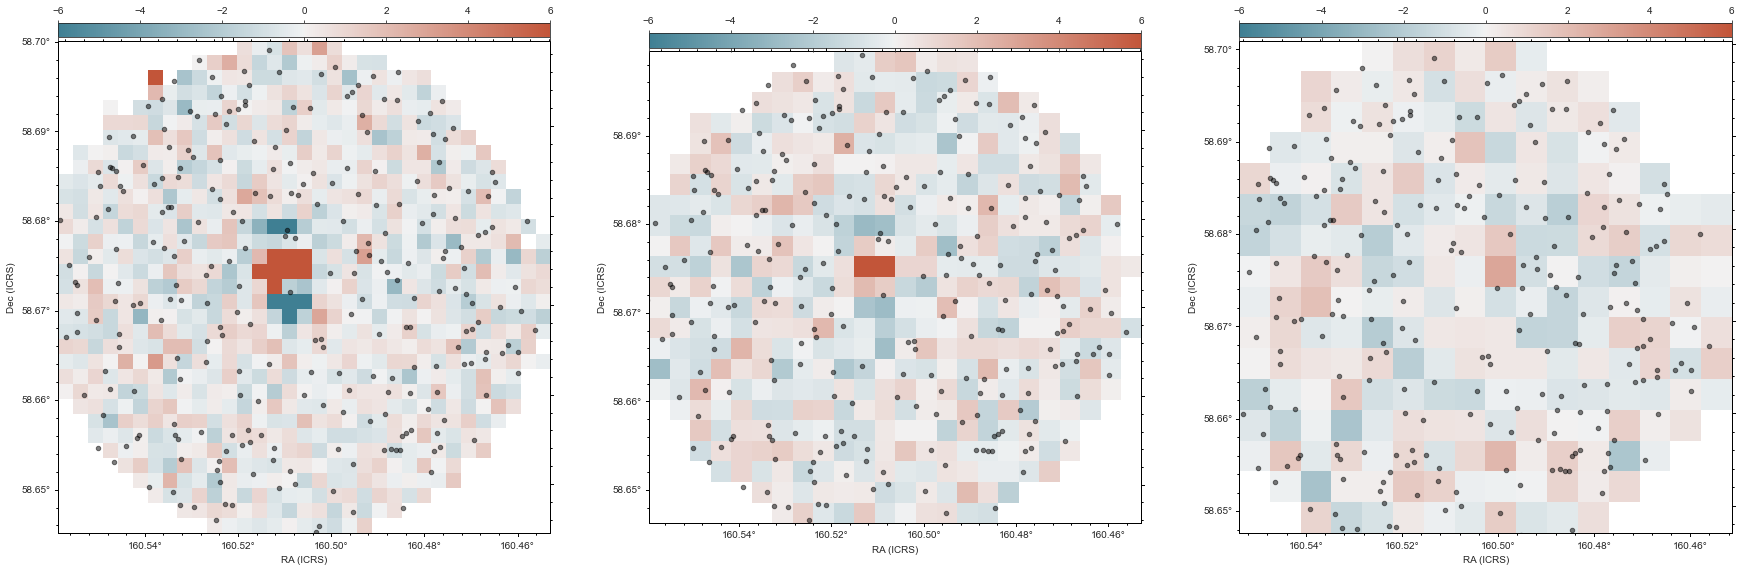

In [39]:
t=Bayes_pval_sources(fits_images)
if len(t)>0:
    priors,prior_list=process_prior(t,
                    path_to_data=['../../../data/'],
                      source=source,
                      field=field,
                      path_to_SPIRE=path_to_SPIRE,
                      redshift_file=redshift_file,
                      redshift_prior=[0.1,2.0],radius=10,alt_model=True)
    xidplus.save(priors,None,'./output/{}/prior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2_alt')
    prior_list.write('./output/{}/prior_list_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2_alt.ascii',format='ascii',overwrite=True)
    hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
    phys_prior=create_phys_prior(priors,prior_list,emulator_path)
    mcmc=fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=n_chains,chain_method='parallel')

    ## For numpyro to sample from the prior, the data needs to be set to None
    import copy
    #make a deepcopy of the priors
    priors_prior_pred=copy.deepcopy(priors)
    #set data to None
    for i in range(0,len(priors)):
        priors_prior_pred[i].sim=None
    #sample from the prior using numpyro's Predictive function
    prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
    prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    
    #sample from the prior using numpyro's Predictive function
    prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = mcmc.get_samples(), num_samples = 50)
    prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]
    samples=mcmc.get_samples()
    divergences=mcmc.get_extra_fields()['diverging']
    numpyro_data = az.from_numpyro(
        mcmc,
        prior=prior_pred,
        posterior_predictive=prior_pred_samp,
        coords={"src": np.arange(0,priors[0].nsrc),
               "band":np.arange(0,3)},
        dims={"agn": ["src"],
             "bkg":["band"],
             "redshift":["src"],
              "sfr":["src"]},
        )
    numpyro_data.to_netcdf('./output/{}/posterior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2_alt.nc')
    from xidplus import postmaps
    import aplpy
    sns.set_style("white")
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    Bayes_pvals = []
    hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
    fig = plt.figure(figsize=(10 * len(priors), 10))
    figs = []
    for i in range(0, len(priors)):
        figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
        Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))


    for i in range(0, len(priors)):
        figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                             marker='o', s=20, alpha=0.5)
        figs[i].tick_labels.set_xformat('dd.dd')
        figs[i].tick_labels.set_yformat('dd.dd')
        figs[i]._data[
            priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
        Bayes_pvals[i]
        figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
        figs[i].add_colorbar()
        figs[i].colorbar.set_location('top')